In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as f
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from sklearn import preprocessing
from tqdm import tqdm
from sklearn.preprocessing import FunctionTransformer
import seaborn as sns 
from scipy import stats
import statsmodels.api as sm

from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import ElasticNet, Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import SVR
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.neural_network import MLPRegressor
from scipy.stats import norm
import copy
from sklearn.model_selection import KFold
from catboost import CatBoostRegressor, Pool, metrics, cv
import xgboost as xgb
from scipy.stats import gmean
from sklearn.impute import KNNImputer

/data/hieunm/anaconda3/envs/action-env/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [120]:
train_df = pd.read_csv('./n_train.csv')
test_df = pd.read_csv('./n_test.csv')

In [126]:
train_df['average-total-water-mixing-ration'] = (9.81 * train_df['contest-prwtr-eatm-14d__prwtr'] / (train_df['contest-slp-14d__slp'] - train_df['contest-pres-sfc-gauss-14d__pres']))
test_df['average-total-water-mixing-ration'] = (9.81 * test_df['contest-prwtr-eatm-14d__prwtr'] / (test_df['contest-slp-14d__slp'] - test_df['contest-pres-sfc-gauss-14d__pres']))
train_df['consendation'] = train_df['contest-rhum-sig995-14d__rhum'] / 100 * train_df['contest-pevpr-sfc-gauss-14d__pevpr']
test_df['consendation'] = test_df['contest-rhum-sig995-14d__rhum'] / 100 * test_df['contest-pevpr-sfc-gauss-14d__pevpr']

In [209]:
exclude_cols = ['index', 'startdate']
temporal_attrs = ['year', 'quarter', 'month', 'week', 'dayofyear', 'season', 'day_of_year_sin', 'day_of_year_cos', 'week_sin', 'week_cos', 'month_sin', 'month_cos', 'season_sin', 'season_cos', 'quarter_sin', 'quarter_cos']
sub_temporal_attrs = ['month', 'season']
loc_attrs = ['lat', 'lon', 'loc_group']
embedding_attrs = ['climateregions__climateregion']
target=["contest-tmp2m-14d__tmp2m"]

main_attrs = [c for c in train_df.columns if c not in exclude_cols and c not in temporal_attrs and c not in loc_attrs and c not in target and c not in embedding_attrs]
print("Main features:", len(main_attrs))

Main features: 242


In [210]:
independent_corr = train_df[temporal_attrs + loc_attrs + embedding_attrs + main_attrs].corr()
seleted_corr_columns = np.full((independent_corr.shape[0],), True, dtype=bool)
for i in range(independent_corr.shape[0]):
    for j in range(i + 1, independent_corr.shape[0]):
        if independent_corr.iloc[i, j] >= 0.85:
            if seleted_corr_columns[j]:
                seleted_corr_columns[j] = False

KeyboardInterrupt: 

In [188]:
selected_columns = train_df[temporal_attrs + loc_attrs + embedding_attrs + main_attrs].columns[seleted_corr_columns]
print(selected_columns.shape)

(173,)


In [190]:
out_cols = ['icec-2010-1',
 'icec-2010-2',
 'icec-2010-3',
 'icec-2010-4',
 'icec-2010-5',
 'icec-2010-6',
 'icec-2010-7',
 'icec-2010-8',
 'icec-2010-9',
 'icec-2010-10',
 'year',
 'quarter',
 'month_cos',
 'quarter_sin',
 'quarter_cos']
features = [c for c in selected_columns if c not in out_cols]

In [211]:
from sklearn.model_selection import KFold
import xgboost as xgb
from catboost import CatBoostRegressor
import lightgbm as lgb
from scipy.stats import gmean
X_train, X_validation, y_train, y_validation = train_test_split(train_df[temporal_attrs + loc_attrs + embedding_attrs + main_attrs], train_df[target[0]], test_size=0.33, random_state=42)
categorical_features_indices = np.where(X_train.dtypes != float)[0]
categorical_feautures = [X_train.columns.tolist()[i] for i in categorical_features_indices]
X_test = test_df[temporal_attrs + loc_attrs + embedding_attrs + main_attrs]

clf = CatBoostRegressor(verbose=200)
clf.fit(X_train, 
        y_train, 
        eval_set=[(X_validation, y_validation)], 
        verbose=True, 
        cat_features=categorical_features_indices,
        early_stopping_rounds=100)
s = clf.predict(X_test)
df = pd.read_csv('best_sub.csv')
t = df['contest-tmp2m-14d__tmp2m']
df['contest-tmp2m-14d__tmp2m'] = s
df.to_csv('submission_corr_important.csv', index=False)

best_df = pd.read_csv('best_sub.csv')
y_best = best_df[target[0]].values

from numpy import dot
from numpy.linalg import norm

cos_sim = dot(y_best, s)/(norm(y_best)*norm(s))
print("cos_sim with best submission:", cos_sim)

Learning rate set to 0.121296
0:	learn: 8.8255223	test: 8.8200137	best: 8.8200137 (0)	total: 167ms	remaining: 2m 46s
1:	learn: 7.9162133	test: 7.9118177	best: 7.9118177 (1)	total: 298ms	remaining: 2m 28s
2:	learn: 7.1039911	test: 7.1008199	best: 7.1008199 (2)	total: 432ms	remaining: 2m 23s
3:	learn: 6.3970083	test: 6.3931626	best: 6.3931626 (3)	total: 553ms	remaining: 2m 17s
4:	learn: 5.7727066	test: 5.7685970	best: 5.7685970 (4)	total: 678ms	remaining: 2m 15s
5:	learn: 5.2404588	test: 5.2360609	best: 5.2360609 (5)	total: 794ms	remaining: 2m 11s
6:	learn: 4.7758699	test: 4.7714458	best: 4.7714458 (6)	total: 904ms	remaining: 2m 8s
7:	learn: 4.3834862	test: 4.3789711	best: 4.3789711 (7)	total: 1.03s	remaining: 2m 7s
8:	learn: 4.0318949	test: 4.0278957	best: 4.0278957 (8)	total: 1.15s	remaining: 2m 6s
9:	learn: 3.7226393	test: 3.7189679	best: 3.7189679 (9)	total: 1.26s	remaining: 2m 5s
10:	learn: 3.4585894	test: 3.4546402	best: 3.4546402 (10)	total: 1.38s	remaining: 2m 3s
11:	learn: 3.227

95:	learn: 1.1615775	test: 1.1451216	best: 1.1451216 (95)	total: 12.1s	remaining: 1m 54s
96:	learn: 1.1573368	test: 1.1410201	best: 1.1410201 (96)	total: 12.2s	remaining: 1m 53s
97:	learn: 1.1531604	test: 1.1368451	best: 1.1368451 (97)	total: 12.3s	remaining: 1m 53s
98:	learn: 1.1490261	test: 1.1326471	best: 1.1326471 (98)	total: 12.4s	remaining: 1m 53s
99:	learn: 1.1456288	test: 1.1292387	best: 1.1292387 (99)	total: 12.6s	remaining: 1m 53s
100:	learn: 1.1425095	test: 1.1261933	best: 1.1261933 (100)	total: 12.7s	remaining: 1m 52s
101:	learn: 1.1389480	test: 1.1228178	best: 1.1228178 (101)	total: 12.8s	remaining: 1m 52s
102:	learn: 1.1363554	test: 1.1202243	best: 1.1202243 (102)	total: 12.9s	remaining: 1m 52s
103:	learn: 1.1330035	test: 1.1170751	best: 1.1170751 (103)	total: 13s	remaining: 1m 51s
104:	learn: 1.1290147	test: 1.1130013	best: 1.1130013 (104)	total: 13.1s	remaining: 1m 51s
105:	learn: 1.1258441	test: 1.1097161	best: 1.1097161 (105)	total: 13.2s	remaining: 1m 51s
106:	learn:

187:	learn: 0.9215316	test: 0.9047722	best: 0.9047722 (187)	total: 23.1s	remaining: 1m 39s
188:	learn: 0.9197624	test: 0.9030215	best: 0.9030215 (188)	total: 23.2s	remaining: 1m 39s
189:	learn: 0.9159742	test: 0.8990699	best: 0.8990699 (189)	total: 23.4s	remaining: 1m 39s
190:	learn: 0.9133423	test: 0.8965055	best: 0.8965055 (190)	total: 23.5s	remaining: 1m 39s
191:	learn: 0.9117940	test: 0.8949767	best: 0.8949767 (191)	total: 23.6s	remaining: 1m 39s
192:	learn: 0.9101720	test: 0.8934559	best: 0.8934559 (192)	total: 23.7s	remaining: 1m 39s
193:	learn: 0.9082586	test: 0.8915674	best: 0.8915674 (193)	total: 23.8s	remaining: 1m 39s
194:	learn: 0.9069347	test: 0.8902229	best: 0.8902229 (194)	total: 23.9s	remaining: 1m 38s
195:	learn: 0.9053368	test: 0.8885695	best: 0.8885695 (195)	total: 24.1s	remaining: 1m 38s
196:	learn: 0.9039371	test: 0.8871071	best: 0.8871071 (196)	total: 24.2s	remaining: 1m 38s
197:	learn: 0.9030033	test: 0.8861533	best: 0.8861533 (197)	total: 24.3s	remaining: 1m 38s

278:	learn: 0.8000819	test: 0.7852790	best: 0.7852790 (278)	total: 34.2s	remaining: 1m 28s
279:	learn: 0.7990894	test: 0.7843566	best: 0.7843566 (279)	total: 34.3s	remaining: 1m 28s
280:	learn: 0.7982206	test: 0.7834936	best: 0.7834936 (280)	total: 34.4s	remaining: 1m 28s
281:	learn: 0.7972728	test: 0.7826046	best: 0.7826046 (281)	total: 34.5s	remaining: 1m 27s
282:	learn: 0.7964525	test: 0.7818611	best: 0.7818611 (282)	total: 34.6s	remaining: 1m 27s
283:	learn: 0.7952112	test: 0.7805865	best: 0.7805865 (283)	total: 34.7s	remaining: 1m 27s
284:	learn: 0.7942604	test: 0.7796153	best: 0.7796153 (284)	total: 34.8s	remaining: 1m 27s
285:	learn: 0.7933295	test: 0.7786868	best: 0.7786868 (285)	total: 35s	remaining: 1m 27s
286:	learn: 0.7926282	test: 0.7779934	best: 0.7779934 (286)	total: 35.1s	remaining: 1m 27s
287:	learn: 0.7917721	test: 0.7774131	best: 0.7774131 (287)	total: 35.2s	remaining: 1m 27s
288:	learn: 0.7907329	test: 0.7763222	best: 0.7763222 (288)	total: 35.3s	remaining: 1m 26s
2

370:	learn: 0.7230563	test: 0.7125476	best: 0.7125476 (370)	total: 45.9s	remaining: 1m 17s
371:	learn: 0.7223195	test: 0.7118382	best: 0.7118382 (371)	total: 46.1s	remaining: 1m 17s
372:	learn: 0.7217809	test: 0.7112715	best: 0.7112715 (372)	total: 46.2s	remaining: 1m 17s
373:	learn: 0.7211222	test: 0.7105870	best: 0.7105870 (373)	total: 46.3s	remaining: 1m 17s
374:	learn: 0.7207215	test: 0.7101844	best: 0.7101844 (374)	total: 46.4s	remaining: 1m 17s
375:	learn: 0.7202093	test: 0.7096069	best: 0.7096069 (375)	total: 46.5s	remaining: 1m 17s
376:	learn: 0.7196872	test: 0.7092025	best: 0.7092025 (376)	total: 46.6s	remaining: 1m 17s
377:	learn: 0.7189874	test: 0.7085413	best: 0.7085413 (377)	total: 46.7s	remaining: 1m 16s
378:	learn: 0.7182131	test: 0.7077994	best: 0.7077994 (378)	total: 46.9s	remaining: 1m 16s
379:	learn: 0.7175993	test: 0.7072678	best: 0.7072678 (379)	total: 47s	remaining: 1m 16s
380:	learn: 0.7167812	test: 0.7064969	best: 0.7064969 (380)	total: 47.1s	remaining: 1m 16s
3

462:	learn: 0.6673044	test: 0.6602029	best: 0.6602029 (462)	total: 57.2s	remaining: 1m 6s
463:	learn: 0.6668044	test: 0.6597187	best: 0.6597187 (463)	total: 57.3s	remaining: 1m 6s
464:	learn: 0.6664103	test: 0.6593261	best: 0.6593261 (464)	total: 57.4s	remaining: 1m 6s
465:	learn: 0.6658553	test: 0.6588041	best: 0.6588041 (465)	total: 57.5s	remaining: 1m 5s
466:	learn: 0.6653363	test: 0.6583007	best: 0.6583007 (466)	total: 57.6s	remaining: 1m 5s
467:	learn: 0.6647744	test: 0.6577752	best: 0.6577752 (467)	total: 57.7s	remaining: 1m 5s
468:	learn: 0.6644182	test: 0.6573908	best: 0.6573908 (468)	total: 57.9s	remaining: 1m 5s
469:	learn: 0.6640234	test: 0.6570330	best: 0.6570330 (469)	total: 58s	remaining: 1m 5s
470:	learn: 0.6635445	test: 0.6565677	best: 0.6565677 (470)	total: 58.1s	remaining: 1m 5s
471:	learn: 0.6631792	test: 0.6562284	best: 0.6562284 (471)	total: 58.2s	remaining: 1m 5s
472:	learn: 0.6626879	test: 0.6557506	best: 0.6557506 (472)	total: 58.3s	remaining: 1m 4s
473:	learn: 

555:	learn: 0.6238114	test: 0.6194239	best: 0.6194239 (555)	total: 1m 8s	remaining: 54.6s
556:	learn: 0.6234240	test: 0.6190324	best: 0.6190324 (556)	total: 1m 8s	remaining: 54.4s
557:	learn: 0.6230563	test: 0.6187093	best: 0.6187093 (557)	total: 1m 8s	remaining: 54.4s
558:	learn: 0.6225911	test: 0.6182304	best: 0.6182304 (558)	total: 1m 8s	remaining: 54.2s
559:	learn: 0.6221507	test: 0.6177483	best: 0.6177483 (559)	total: 1m 8s	remaining: 54.1s
560:	learn: 0.6217242	test: 0.6173712	best: 0.6173712 (560)	total: 1m 8s	remaining: 54s
561:	learn: 0.6213089	test: 0.6169981	best: 0.6169981 (561)	total: 1m 9s	remaining: 53.8s
562:	learn: 0.6208890	test: 0.6165764	best: 0.6165764 (562)	total: 1m 9s	remaining: 53.7s
563:	learn: 0.6205943	test: 0.6163418	best: 0.6163418 (563)	total: 1m 9s	remaining: 53.6s
564:	learn: 0.6200989	test: 0.6158675	best: 0.6158675 (564)	total: 1m 9s	remaining: 53.5s
565:	learn: 0.6196203	test: 0.6153701	best: 0.6153701 (565)	total: 1m 9s	remaining: 53.4s
566:	learn: 

646:	learn: 0.5895426	test: 0.5876390	best: 0.5876390 (646)	total: 1m 19s	remaining: 43.3s
647:	learn: 0.5892253	test: 0.5873550	best: 0.5873550 (647)	total: 1m 19s	remaining: 43.2s
648:	learn: 0.5888911	test: 0.5870630	best: 0.5870630 (648)	total: 1m 19s	remaining: 43.1s
649:	learn: 0.5885728	test: 0.5867689	best: 0.5867689 (649)	total: 1m 19s	remaining: 43s
650:	learn: 0.5882514	test: 0.5864528	best: 0.5864528 (650)	total: 1m 19s	remaining: 42.8s
651:	learn: 0.5877931	test: 0.5860208	best: 0.5860208 (651)	total: 1m 19s	remaining: 42.7s
652:	learn: 0.5875470	test: 0.5857780	best: 0.5857780 (652)	total: 1m 20s	remaining: 42.6s
653:	learn: 0.5872362	test: 0.5855105	best: 0.5855105 (653)	total: 1m 20s	remaining: 42.4s
654:	learn: 0.5869233	test: 0.5851961	best: 0.5851961 (654)	total: 1m 20s	remaining: 42.3s
655:	learn: 0.5866805	test: 0.5849726	best: 0.5849726 (655)	total: 1m 20s	remaining: 42.2s
656:	learn: 0.5864492	test: 0.5847085	best: 0.5847085 (656)	total: 1m 20s	remaining: 42.1s
6

738:	learn: 0.5600024	test: 0.5603727	best: 0.5603727 (738)	total: 1m 30s	remaining: 32s
739:	learn: 0.5597107	test: 0.5601018	best: 0.5601018 (739)	total: 1m 30s	remaining: 31.9s
740:	learn: 0.5594851	test: 0.5598990	best: 0.5598990 (740)	total: 1m 30s	remaining: 31.8s
741:	learn: 0.5592347	test: 0.5596445	best: 0.5596445 (741)	total: 1m 30s	remaining: 31.6s
742:	learn: 0.5588825	test: 0.5592996	best: 0.5592996 (742)	total: 1m 31s	remaining: 31.5s
743:	learn: 0.5586578	test: 0.5590845	best: 0.5590845 (743)	total: 1m 31s	remaining: 31.4s
744:	learn: 0.5583783	test: 0.5587822	best: 0.5587822 (744)	total: 1m 31s	remaining: 31.3s
745:	learn: 0.5581346	test: 0.5585283	best: 0.5585283 (745)	total: 1m 31s	remaining: 31.2s
746:	learn: 0.5577776	test: 0.5581843	best: 0.5581843 (746)	total: 1m 31s	remaining: 31.1s
747:	learn: 0.5574997	test: 0.5579536	best: 0.5579536 (747)	total: 1m 31s	remaining: 30.9s
748:	learn: 0.5570537	test: 0.5575420	best: 0.5575420 (748)	total: 1m 31s	remaining: 30.8s
7

830:	learn: 0.5348070	test: 0.5364710	best: 0.5364710 (830)	total: 1m 41s	remaining: 20.6s
831:	learn: 0.5345364	test: 0.5362191	best: 0.5362191 (831)	total: 1m 41s	remaining: 20.5s
832:	learn: 0.5342360	test: 0.5359452	best: 0.5359452 (832)	total: 1m 41s	remaining: 20.4s
833:	learn: 0.5340307	test: 0.5357330	best: 0.5357330 (833)	total: 1m 41s	remaining: 20.3s
834:	learn: 0.5337774	test: 0.5355547	best: 0.5355547 (834)	total: 1m 41s	remaining: 20.1s
835:	learn: 0.5334424	test: 0.5352077	best: 0.5352077 (835)	total: 1m 42s	remaining: 20s
836:	learn: 0.5330450	test: 0.5348664	best: 0.5348664 (836)	total: 1m 42s	remaining: 19.9s
837:	learn: 0.5326054	test: 0.5345351	best: 0.5345351 (837)	total: 1m 42s	remaining: 19.8s
838:	learn: 0.5323932	test: 0.5343569	best: 0.5343569 (838)	total: 1m 42s	remaining: 19.7s
839:	learn: 0.5320000	test: 0.5340664	best: 0.5340664 (839)	total: 1m 42s	remaining: 19.6s
840:	learn: 0.5317760	test: 0.5338629	best: 0.5338629 (840)	total: 1m 42s	remaining: 19.5s
8

921:	learn: 0.5129101	test: 0.5161424	best: 0.5161424 (921)	total: 1m 51s	remaining: 9.47s
922:	learn: 0.5126834	test: 0.5159365	best: 0.5159365 (922)	total: 1m 52s	remaining: 9.35s
923:	learn: 0.5125112	test: 0.5157576	best: 0.5157576 (923)	total: 1m 52s	remaining: 9.23s
924:	learn: 0.5123657	test: 0.5156117	best: 0.5156117 (924)	total: 1m 52s	remaining: 9.1s
925:	learn: 0.5121565	test: 0.5153988	best: 0.5153988 (925)	total: 1m 52s	remaining: 8.98s
926:	learn: 0.5118769	test: 0.5151662	best: 0.5151662 (926)	total: 1m 52s	remaining: 8.86s
927:	learn: 0.5115553	test: 0.5148735	best: 0.5148735 (927)	total: 1m 52s	remaining: 8.74s
928:	learn: 0.5113425	test: 0.5146635	best: 0.5146635 (928)	total: 1m 52s	remaining: 8.62s
929:	learn: 0.5111019	test: 0.5144305	best: 0.5144305 (929)	total: 1m 52s	remaining: 8.49s
930:	learn: 0.5109072	test: 0.5142369	best: 0.5142369 (930)	total: 1m 52s	remaining: 8.37s
931:	learn: 0.5106696	test: 0.5140356	best: 0.5140356 (931)	total: 1m 53s	remaining: 8.25s


In [198]:
selected_cols = []
for i in range(feature_importance.shape[0]):
    if feature_importance[i] >= 0.01:
        selected_cols.append(features[i])

In [199]:
selected_cols

['day_of_year_sin',
 'day_of_year_cos',
 'lat',
 'lon',
 'climateregions__climateregion',
 'contest-pevpr-sfc-gauss-14d__pevpr',
 'nmme0-tmp2m-34w__cancm30',
 'contest-wind-h10-14d__wind-hgt-10',
 'contest-rhum-sig995-14d__rhum',
 'nmme-prate-34w__cancm3',
 'nmme-prate-34w__ccsm3',
 'nmme-prate-34w__ccsm4',
 'nmme-prate-34w__cfsv2',
 'nmme-prate-34w__gfdl',
 'nmme-prate-34w__gfdlflora',
 'nmme-prate-34w__nasa',
 'nmme0-prate-56w__cancm30',
 'nmme0-prate-56w__cancm40',
 'nmme0-prate-56w__ccsm30',
 'nmme0-prate-56w__ccsm40',
 'nmme0-prate-56w__cfsv20',
 'nmme0-prate-56w__gfdlflora0',
 'nmme0-prate-56w__gfdl0',
 'nmme0-prate-56w__nasa0',
 'nmme0-prate-34w__cancm40',
 'contest-slp-14d__slp',
 'contest-wind-vwnd-925-14d__wind-vwnd-925',
 'contest-pres-sfc-gauss-14d__pres',
 'contest-wind-uwnd-250-14d__wind-uwnd-250',
 'contest-prwtr-eatm-14d__prwtr',
 'contest-wind-vwnd-250-14d__wind-vwnd-250',
 'contest-precip-14d__precip',
 'contest-wind-h850-14d__wind-hgt-850',
 'contest-wind-uwnd-925-14

Text(0.5, 1.0, 'Feature Importance')

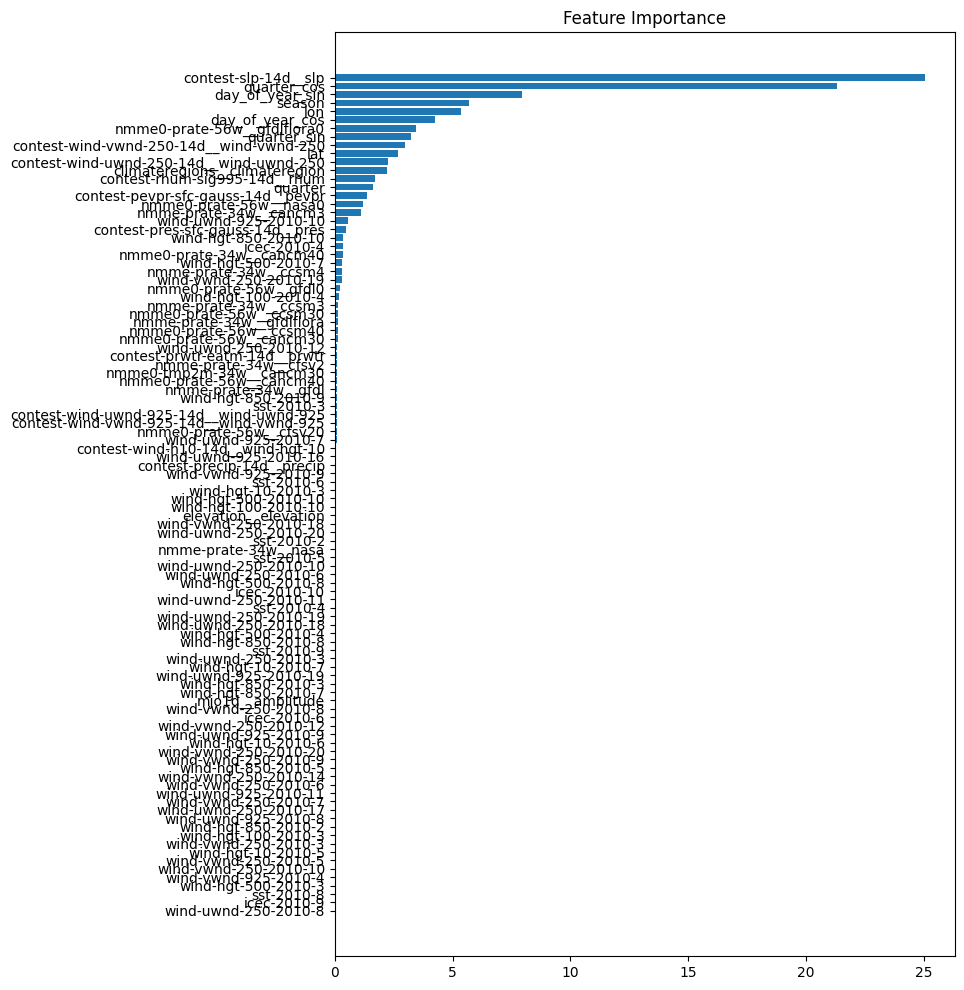

In [193]:
import matplotlib.pyplot as plt
feature_importance = clf.feature_importances_
max_features = 100
sorted_idx = np.argsort(feature_importance)[-max_features:]
fig = plt.figure(figsize=(8, 12))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(train_df[selected_columns].columns)[sorted_idx])
plt.title('Feature Importance')

In [200]:
from sklearn.model_selection import KFold
import xgboost as xgb
from catboost import CatBoostRegressor
import lightgbm as lgb
from scipy.stats import gmean
X_train, X_validation, y_train, y_validation = train_test_split(train_df[selected_cols], train_df[target[0]], test_size=0.33, random_state=42)
categorical_features_indices = np.where(X_train.dtypes != float)[0]
categorical_feautures = [X_train.columns.tolist()[i] for i in categorical_features_indices]
X_test = test_df[selected_cols]

clf = CatBoostRegressor(verbose=200)
clf.fit(X_train, 
        y_train, 
        eval_set=[(X_validation, y_validation)], 
        verbose=True, 
        cat_features=categorical_features_indices,
        early_stopping_rounds=100)

Learning rate set to 0.121296
0:	learn: 8.8623503	test: 8.8572331	best: 8.8572331 (0)	total: 67.4ms	remaining: 1m 7s
1:	learn: 7.9872130	test: 7.9846772	best: 7.9846772 (1)	total: 125ms	remaining: 1m 2s
2:	learn: 7.2220880	test: 7.2192554	best: 7.2192554 (2)	total: 183ms	remaining: 1m
3:	learn: 6.5570420	test: 6.5554754	best: 6.5554754 (3)	total: 234ms	remaining: 58.2s
4:	learn: 5.9623254	test: 5.9615583	best: 5.9615583 (4)	total: 284ms	remaining: 56.6s
5:	learn: 5.4452934	test: 5.4464285	best: 5.4464285 (5)	total: 339ms	remaining: 56.1s
6:	learn: 5.0045068	test: 5.0058400	best: 5.0058400 (6)	total: 403ms	remaining: 57.1s
7:	learn: 4.6216094	test: 4.6238686	best: 4.6238686 (7)	total: 457ms	remaining: 56.7s
8:	learn: 4.2634355	test: 4.2653458	best: 4.2653458 (8)	total: 516ms	remaining: 56.8s
9:	learn: 3.9741102	test: 3.9769364	best: 3.9769364 (9)	total: 572ms	remaining: 56.6s
10:	learn: 3.7100629	test: 3.7132430	best: 3.7132430 (10)	total: 626ms	remaining: 56.3s
11:	learn: 3.4971988	tes

94:	learn: 1.4072558	test: 1.4096718	best: 1.4096718 (94)	total: 6.09s	remaining: 58.1s
95:	learn: 1.4030595	test: 1.4054312	best: 1.4054312 (95)	total: 6.15s	remaining: 58s
96:	learn: 1.3996241	test: 1.4019595	best: 1.4019595 (96)	total: 6.23s	remaining: 58s
97:	learn: 1.3946510	test: 1.3971763	best: 1.3971763 (97)	total: 6.29s	remaining: 57.9s
98:	learn: 1.3913779	test: 1.3939830	best: 1.3939830 (98)	total: 6.35s	remaining: 57.8s
99:	learn: 1.3870571	test: 1.3898821	best: 1.3898821 (99)	total: 6.41s	remaining: 57.7s
100:	learn: 1.3827114	test: 1.3854866	best: 1.3854866 (100)	total: 6.48s	remaining: 57.6s
101:	learn: 1.3792438	test: 1.3821283	best: 1.3821283 (101)	total: 6.53s	remaining: 57.5s
102:	learn: 1.3750608	test: 1.3777257	best: 1.3777257 (102)	total: 6.59s	remaining: 57.4s
103:	learn: 1.3708435	test: 1.3735978	best: 1.3735978 (103)	total: 6.65s	remaining: 57.3s
104:	learn: 1.3638796	test: 1.3666540	best: 1.3666540 (104)	total: 6.72s	remaining: 57.3s
105:	learn: 1.3605725	test

186:	learn: 1.1163247	test: 1.1207127	best: 1.1207127 (186)	total: 12.6s	remaining: 54.6s
187:	learn: 1.1141991	test: 1.1185527	best: 1.1185527 (187)	total: 12.6s	remaining: 54.5s
188:	learn: 1.1119364	test: 1.1163182	best: 1.1163182 (188)	total: 12.7s	remaining: 54.4s
189:	learn: 1.1098773	test: 1.1142441	best: 1.1142441 (189)	total: 12.7s	remaining: 54.2s
190:	learn: 1.1049680	test: 1.1093258	best: 1.1093258 (190)	total: 12.8s	remaining: 54.1s
191:	learn: 1.1030821	test: 1.1074012	best: 1.1074012 (191)	total: 12.8s	remaining: 53.9s
192:	learn: 1.1011278	test: 1.1054669	best: 1.1054669 (192)	total: 12.9s	remaining: 53.9s
193:	learn: 1.0992073	test: 1.1035864	best: 1.1035864 (193)	total: 12.9s	remaining: 53.8s
194:	learn: 1.0971375	test: 1.1015556	best: 1.1015556 (194)	total: 13s	remaining: 53.6s
195:	learn: 1.0930407	test: 1.0975896	best: 1.0975896 (195)	total: 13s	remaining: 53.5s
196:	learn: 1.0914598	test: 1.0961142	best: 1.0961142 (196)	total: 13.1s	remaining: 53.4s
197:	learn: 1.

278:	learn: 0.9554617	test: 0.9612033	best: 0.9612033 (278)	total: 21.6s	remaining: 55.9s
279:	learn: 0.9541611	test: 0.9599446	best: 0.9599446 (279)	total: 21.8s	remaining: 56.1s
280:	learn: 0.9528295	test: 0.9585619	best: 0.9585619 (280)	total: 22s	remaining: 56.3s
281:	learn: 0.9516336	test: 0.9574337	best: 0.9574337 (281)	total: 22.2s	remaining: 56.5s
282:	learn: 0.9503308	test: 0.9561815	best: 0.9561815 (282)	total: 22.3s	remaining: 56.5s
283:	learn: 0.9495618	test: 0.9554507	best: 0.9554507 (283)	total: 22.5s	remaining: 56.6s
284:	learn: 0.9484940	test: 0.9544144	best: 0.9544144 (284)	total: 22.7s	remaining: 56.8s
285:	learn: 0.9474517	test: 0.9533740	best: 0.9533740 (285)	total: 22.8s	remaining: 57s
286:	learn: 0.9463502	test: 0.9522482	best: 0.9522482 (286)	total: 22.9s	remaining: 57s
287:	learn: 0.9454720	test: 0.9513435	best: 0.9513435 (287)	total: 23.1s	remaining: 57s
288:	learn: 0.9446114	test: 0.9504260	best: 0.9504260 (288)	total: 23.3s	remaining: 57.3s
289:	learn: 0.9435

370:	learn: 0.8527034	test: 0.8608443	best: 0.8608443 (370)	total: 37.2s	remaining: 1m 3s
371:	learn: 0.8519849	test: 0.8601152	best: 0.8601152 (371)	total: 37.5s	remaining: 1m 3s
372:	learn: 0.8510868	test: 0.8591769	best: 0.8591769 (372)	total: 37.7s	remaining: 1m 3s
373:	learn: 0.8504489	test: 0.8586069	best: 0.8586069 (373)	total: 37.8s	remaining: 1m 3s
374:	learn: 0.8484628	test: 0.8567095	best: 0.8567095 (374)	total: 38.1s	remaining: 1m 3s
375:	learn: 0.8477672	test: 0.8559681	best: 0.8559681 (375)	total: 38.3s	remaining: 1m 3s
376:	learn: 0.8471315	test: 0.8553770	best: 0.8553770 (376)	total: 38.4s	remaining: 1m 3s
377:	learn: 0.8465924	test: 0.8548931	best: 0.8548931 (377)	total: 38.6s	remaining: 1m 3s
378:	learn: 0.8453910	test: 0.8537491	best: 0.8537491 (378)	total: 38.7s	remaining: 1m 3s
379:	learn: 0.8445888	test: 0.8529393	best: 0.8529393 (379)	total: 38.8s	remaining: 1m 3s
380:	learn: 0.8439445	test: 0.8522932	best: 0.8522932 (380)	total: 39s	remaining: 1m 3s
381:	learn: 

465:	learn: 0.7799754	test: 0.7898012	best: 0.7898012 (465)	total: 48s	remaining: 55s
466:	learn: 0.7786032	test: 0.7884516	best: 0.7884516 (466)	total: 48s	remaining: 54.8s
467:	learn: 0.7780917	test: 0.7879664	best: 0.7879664 (467)	total: 48.1s	remaining: 54.7s
468:	learn: 0.7773598	test: 0.7872516	best: 0.7872516 (468)	total: 48.1s	remaining: 54.5s
469:	learn: 0.7768798	test: 0.7868050	best: 0.7868050 (469)	total: 48.2s	remaining: 54.4s
470:	learn: 0.7764172	test: 0.7863671	best: 0.7863671 (470)	total: 48.3s	remaining: 54.2s
471:	learn: 0.7755108	test: 0.7855276	best: 0.7855276 (471)	total: 48.3s	remaining: 54s
472:	learn: 0.7746501	test: 0.7846465	best: 0.7846465 (472)	total: 48.4s	remaining: 53.9s
473:	learn: 0.7740713	test: 0.7840756	best: 0.7840756 (473)	total: 48.4s	remaining: 53.7s
474:	learn: 0.7735569	test: 0.7835556	best: 0.7835556 (474)	total: 48.4s	remaining: 53.5s
475:	learn: 0.7727361	test: 0.7827398	best: 0.7827398 (475)	total: 48.5s	remaining: 53.4s
476:	learn: 0.7721

558:	learn: 0.7253697	test: 0.7365556	best: 0.7365556 (558)	total: 52.6s	remaining: 41.5s
559:	learn: 0.7246663	test: 0.7358178	best: 0.7358178 (559)	total: 52.6s	remaining: 41.4s
560:	learn: 0.7243356	test: 0.7355066	best: 0.7355066 (560)	total: 52.7s	remaining: 41.2s
561:	learn: 0.7237198	test: 0.7348814	best: 0.7348814 (561)	total: 52.8s	remaining: 41.1s
562:	learn: 0.7232315	test: 0.7344290	best: 0.7344290 (562)	total: 52.8s	remaining: 41s
563:	learn: 0.7226275	test: 0.7339052	best: 0.7339052 (563)	total: 52.9s	remaining: 40.9s
564:	learn: 0.7221944	test: 0.7334832	best: 0.7334832 (564)	total: 52.9s	remaining: 40.8s
565:	learn: 0.7218708	test: 0.7332017	best: 0.7332017 (565)	total: 53s	remaining: 40.7s
566:	learn: 0.7213178	test: 0.7326733	best: 0.7326733 (566)	total: 53.1s	remaining: 40.6s
567:	learn: 0.7208157	test: 0.7321425	best: 0.7321425 (567)	total: 53.2s	remaining: 40.4s
568:	learn: 0.7205238	test: 0.7318904	best: 0.7318904 (568)	total: 53.2s	remaining: 40.3s
569:	learn: 0.

653:	learn: 0.6816150	test: 0.6945896	best: 0.6945896 (653)	total: 58.9s	remaining: 31.1s
654:	learn: 0.6813618	test: 0.6943446	best: 0.6943446 (654)	total: 58.9s	remaining: 31s
655:	learn: 0.6810017	test: 0.6939583	best: 0.6939583 (655)	total: 59s	remaining: 30.9s
656:	learn: 0.6807505	test: 0.6937183	best: 0.6937183 (656)	total: 59s	remaining: 30.8s
657:	learn: 0.6801547	test: 0.6930917	best: 0.6930917 (657)	total: 59.1s	remaining: 30.7s
658:	learn: 0.6798804	test: 0.6928629	best: 0.6928629 (658)	total: 59.2s	remaining: 30.6s
659:	learn: 0.6793974	test: 0.6924203	best: 0.6924203 (659)	total: 59.2s	remaining: 30.5s
660:	learn: 0.6790019	test: 0.6920484	best: 0.6920484 (660)	total: 59.3s	remaining: 30.4s
661:	learn: 0.6785831	test: 0.6916439	best: 0.6916439 (661)	total: 59.4s	remaining: 30.3s
662:	learn: 0.6783092	test: 0.6913939	best: 0.6913939 (662)	total: 59.4s	remaining: 30.2s
663:	learn: 0.6780207	test: 0.6911392	best: 0.6911392 (663)	total: 59.5s	remaining: 30.1s
664:	learn: 0.67

745:	learn: 0.6458574	test: 0.6605431	best: 0.6605431 (745)	total: 1m 5s	remaining: 22.4s
746:	learn: 0.6455673	test: 0.6603013	best: 0.6603013 (746)	total: 1m 5s	remaining: 22.3s
747:	learn: 0.6453589	test: 0.6600961	best: 0.6600961 (747)	total: 1m 5s	remaining: 22.2s
748:	learn: 0.6450992	test: 0.6598676	best: 0.6598676 (748)	total: 1m 5s	remaining: 22.1s
749:	learn: 0.6447449	test: 0.6595839	best: 0.6595839 (749)	total: 1m 5s	remaining: 22s
750:	learn: 0.6442803	test: 0.6591329	best: 0.6591329 (750)	total: 1m 6s	remaining: 21.9s
751:	learn: 0.6440695	test: 0.6589337	best: 0.6589337 (751)	total: 1m 6s	remaining: 21.8s
752:	learn: 0.6434290	test: 0.6583039	best: 0.6583039 (752)	total: 1m 6s	remaining: 21.7s
753:	learn: 0.6431047	test: 0.6579858	best: 0.6579858 (753)	total: 1m 6s	remaining: 21.6s
754:	learn: 0.6428299	test: 0.6577365	best: 0.6577365 (754)	total: 1m 6s	remaining: 21.5s
755:	learn: 0.6424558	test: 0.6574230	best: 0.6574230 (755)	total: 1m 6s	remaining: 21.5s
756:	learn: 

836:	learn: 0.6163652	test: 0.6327752	best: 0.6327752 (836)	total: 1m 12s	remaining: 14.1s
837:	learn: 0.6161691	test: 0.6325824	best: 0.6325824 (837)	total: 1m 12s	remaining: 14s
838:	learn: 0.6159141	test: 0.6323551	best: 0.6323551 (838)	total: 1m 12s	remaining: 13.9s
839:	learn: 0.6155666	test: 0.6320493	best: 0.6320493 (839)	total: 1m 12s	remaining: 13.8s
840:	learn: 0.6153273	test: 0.6318333	best: 0.6318333 (840)	total: 1m 12s	remaining: 13.8s
841:	learn: 0.6150124	test: 0.6315744	best: 0.6315744 (841)	total: 1m 13s	remaining: 13.7s
842:	learn: 0.6145970	test: 0.6311574	best: 0.6311574 (842)	total: 1m 13s	remaining: 13.6s
843:	learn: 0.6144085	test: 0.6309882	best: 0.6309882 (843)	total: 1m 13s	remaining: 13.6s
844:	learn: 0.6136663	test: 0.6302695	best: 0.6302695 (844)	total: 1m 13s	remaining: 13.5s
845:	learn: 0.6133284	test: 0.6299381	best: 0.6299381 (845)	total: 1m 13s	remaining: 13.4s
846:	learn: 0.6126333	test: 0.6292085	best: 0.6292085 (846)	total: 1m 13s	remaining: 13.3s
8

928:	learn: 0.5894379	test: 0.6074482	best: 0.6074482 (928)	total: 1m 23s	remaining: 6.38s
929:	learn: 0.5891629	test: 0.6071861	best: 0.6071861 (929)	total: 1m 23s	remaining: 6.29s
930:	learn: 0.5888957	test: 0.6069288	best: 0.6069288 (930)	total: 1m 23s	remaining: 6.21s
931:	learn: 0.5887248	test: 0.6067903	best: 0.6067903 (931)	total: 1m 23s	remaining: 6.12s
932:	learn: 0.5884540	test: 0.6065257	best: 0.6065257 (932)	total: 1m 24s	remaining: 6.04s
933:	learn: 0.5881953	test: 0.6062839	best: 0.6062839 (933)	total: 1m 24s	remaining: 5.95s
934:	learn: 0.5877380	test: 0.6058800	best: 0.6058800 (934)	total: 1m 24s	remaining: 5.87s
935:	learn: 0.5875608	test: 0.6057324	best: 0.6057324 (935)	total: 1m 24s	remaining: 5.78s
936:	learn: 0.5873265	test: 0.6054754	best: 0.6054754 (936)	total: 1m 24s	remaining: 5.7s
937:	learn: 0.5870891	test: 0.6052735	best: 0.6052735 (937)	total: 1m 24s	remaining: 5.61s
938:	learn: 0.5868894	test: 0.6050472	best: 0.6050472 (938)	total: 1m 25s	remaining: 5.53s


In [185]:
important_cols

array(['nmme-prate-34w__ccsm4', 'nmme-prate-34w__gfdlflorb',
       'nmme0-prate-56w__gfdlflorb0', 'month', 'loc_group',
       'nmme0-prate-56w__cancm30', 'nmme-prate-56w__ccsm3',
       'nmme-prate-56w__gfdl', 'nmme-tmp2m-56w__cancm3',
       'nmme-prate-34w__nmmemean', 'nmme0-prate-56w__ccsm30',
       'nmme0-prate-56w__gfdlflora0', 'nmme0-tmp2m-34w__gfdlflora0',
       'nmme0-tmp2m-34w__nmme0mean', 'nmme-prate-34w__gfdl',
       'nmme-prate-56w__cancm3', 'season', 'nmme0-prate-56w__cancm40',
       'contest-slp-14d__slp', 'nmme0-prate-34w__gfdlflorb0', 'lon',
       'nmme-tmp2m-56w__cancm4', 'nmme-prate-56w__cfsv2',
       'nmme0-tmp2m-34w__ccsm30', 'nmme-tmp2m-56w__ccsm3',
       'nmme-prate-56w__gfdlflorb', 'nmme-prate-34w__ccsm3',
       'nmme-tmp2m-56w__gfdlflorb', 'nmme0-tmp2m-34w__ccsm40',
       'nmme-prate-34w__cfsv2', 'contest-rhum-sig995-14d__rhum',
       'contest-wind-h10-14d__wind-hgt-10', 'nmme0-tmp2m-34w__cfsv20',
       'nmme-prate-56w__ccsm4', 'nmme-tmp2m-56w__nmme

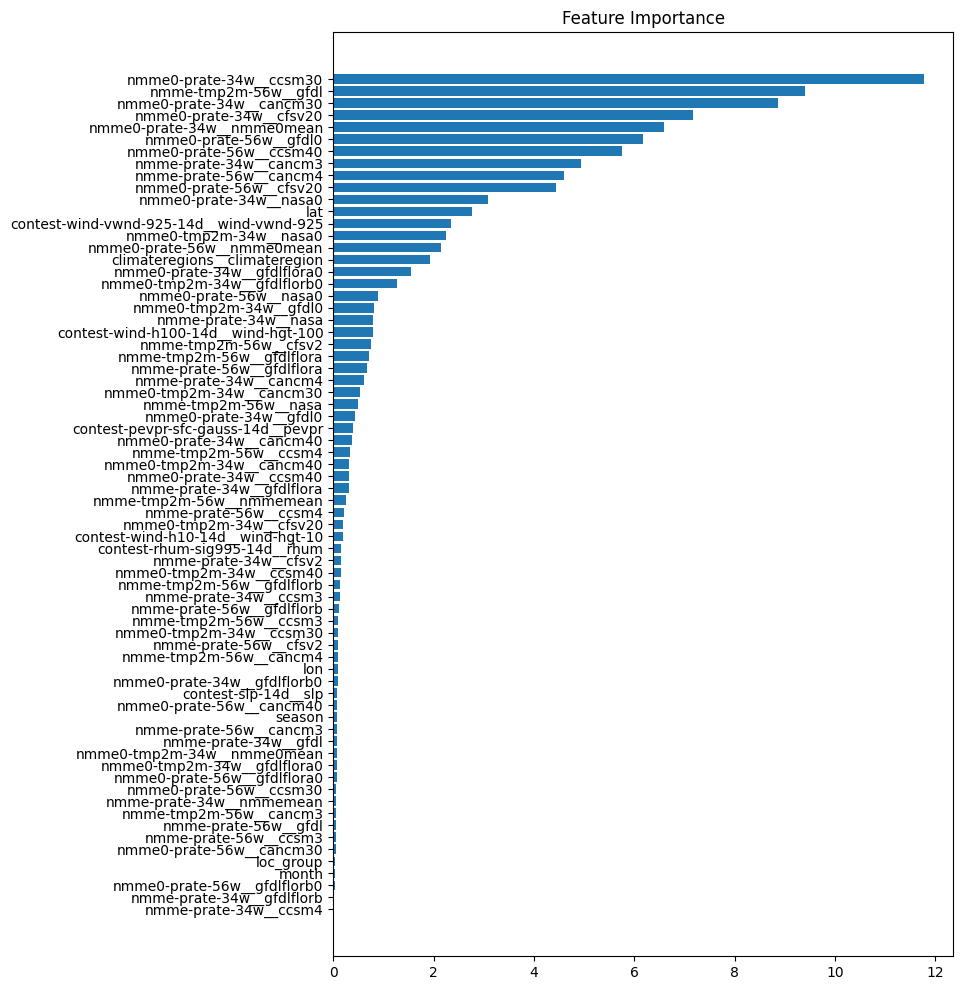

In [184]:
import matplotlib.pyplot as plt
feature_importance = clf.feature_importances_
max_features = 100
sorted_idx = np.argsort(feature_importance)[-max_features:]
fig = plt.figure(figsize=(8, 12))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(train_df[features].columns)[sorted_idx])
plt.title('Feature Importance')
important_cols = np.array(train_df[features].columns)[sorted_idx]

In [182]:
from sklearn.model_selection import KFold
import xgboost as xgb
from catboost import CatBoostRegressor
import lightgbm as lgb
from scipy.stats import gmean
X_train, X_validation, y_train, y_validation = train_test_split(train_df[important_cols], train_df[target[0]], test_size=0.33, random_state=42)
categorical_features_indices = np.where(X_train.dtypes != float)[0]
categorical_feautures = [X_train.columns.tolist()[i] for i in categorical_features_indices]
X_test = test_df[important_cols]

clf = CatBoostRegressor(verbose=200)
clf.fit(X_train, 
        y_train, 
        eval_set=[(X_validation, y_validation)], 
        verbose=True, 
        cat_features=categorical_features_indices,
        early_stopping_rounds=100)

Learning rate set to 0.121296
0:	learn: 8.8214670	test: 8.8159245	best: 8.8159245 (0)	total: 260ms	remaining: 4m 19s
1:	learn: 7.9066346	test: 7.9015518	best: 7.9015518 (1)	total: 447ms	remaining: 3m 42s
2:	learn: 7.1112213	test: 7.1059340	best: 7.1059340 (2)	total: 643ms	remaining: 3m 33s
3:	learn: 6.4156506	test: 6.4124311	best: 6.4124311 (3)	total: 813ms	remaining: 3m 22s
4:	learn: 5.8008016	test: 5.7980838	best: 5.7980838 (4)	total: 1.1s	remaining: 3m 38s
5:	learn: 5.2661247	test: 5.2645574	best: 5.2645574 (5)	total: 1.37s	remaining: 3m 47s
6:	learn: 4.7949038	test: 4.7921539	best: 4.7921539 (6)	total: 1.63s	remaining: 3m 51s
7:	learn: 4.3989349	test: 4.3974294	best: 4.3974294 (7)	total: 1.79s	remaining: 3m 41s
8:	learn: 4.0544091	test: 4.0534519	best: 4.0534519 (8)	total: 2s	remaining: 3m 40s
9:	learn: 3.7634925	test: 3.7631966	best: 3.7631966 (9)	total: 2.3s	remaining: 3m 47s
10:	learn: 3.5053886	test: 3.5042345	best: 3.5042345 (10)	total: 2.6s	remaining: 3m 54s
11:	learn: 3.2884

93:	learn: 1.4004659	test: 1.3859871	best: 1.3859871 (93)	total: 20s	remaining: 3m 12s
94:	learn: 1.3970135	test: 1.3825026	best: 1.3825026 (94)	total: 20.2s	remaining: 3m 12s
95:	learn: 1.3919916	test: 1.3776589	best: 1.3776589 (95)	total: 20.4s	remaining: 3m 11s
96:	learn: 1.3890555	test: 1.3746739	best: 1.3746739 (96)	total: 20.5s	remaining: 3m 10s
97:	learn: 1.3837747	test: 1.3693880	best: 1.3693880 (97)	total: 20.6s	remaining: 3m 10s
98:	learn: 1.3783476	test: 1.3634008	best: 1.3634008 (98)	total: 20.8s	remaining: 3m 8s
99:	learn: 1.3754047	test: 1.3604039	best: 1.3604039 (99)	total: 20.9s	remaining: 3m 8s
100:	learn: 1.3716976	test: 1.3566666	best: 1.3566666 (100)	total: 21.1s	remaining: 3m 7s
101:	learn: 1.3651903	test: 1.3502244	best: 1.3502244 (101)	total: 21.3s	remaining: 3m 7s
102:	learn: 1.3611568	test: 1.3462541	best: 1.3462541 (102)	total: 21.5s	remaining: 3m 7s
103:	learn: 1.3562885	test: 1.3406317	best: 1.3406317 (103)	total: 21.7s	remaining: 3m 7s
104:	learn: 1.3526276

186:	learn: 1.1189006	test: 1.1001929	best: 1.1001929 (186)	total: 30.6s	remaining: 2m 13s
187:	learn: 1.1171112	test: 1.0983739	best: 1.0983739 (187)	total: 30.7s	remaining: 2m 12s
188:	learn: 1.1147096	test: 1.0960217	best: 1.0960217 (188)	total: 30.8s	remaining: 2m 12s
189:	learn: 1.1127897	test: 1.0941392	best: 1.0941392 (189)	total: 30.9s	remaining: 2m 11s
190:	learn: 1.1107021	test: 1.0919250	best: 1.0919250 (190)	total: 31s	remaining: 2m 11s
191:	learn: 1.1085941	test: 1.0897926	best: 1.0897926 (191)	total: 31.1s	remaining: 2m 10s
192:	learn: 1.1073930	test: 1.0885949	best: 1.0885949 (192)	total: 31.2s	remaining: 2m 10s
193:	learn: 1.1059238	test: 1.0872318	best: 1.0872318 (193)	total: 31.4s	remaining: 2m 10s
194:	learn: 1.1045024	test: 1.0858442	best: 1.0858442 (194)	total: 31.5s	remaining: 2m 9s
195:	learn: 1.1029248	test: 1.0843576	best: 1.0843576 (195)	total: 31.6s	remaining: 2m 9s
196:	learn: 1.1016656	test: 1.0830791	best: 1.0830791 (196)	total: 31.6s	remaining: 2m 8s
197:

278:	learn: 0.9773354	test: 0.9584005	best: 0.9584005 (278)	total: 40.9s	remaining: 1m 45s
279:	learn: 0.9757973	test: 0.9567925	best: 0.9567925 (279)	total: 41s	remaining: 1m 45s
280:	learn: 0.9746433	test: 0.9556853	best: 0.9556853 (280)	total: 41.2s	remaining: 1m 45s
281:	learn: 0.9734403	test: 0.9544203	best: 0.9544203 (281)	total: 41.3s	remaining: 1m 45s
282:	learn: 0.9718889	test: 0.9529584	best: 0.9529584 (282)	total: 41.4s	remaining: 1m 44s
283:	learn: 0.9707419	test: 0.9518300	best: 0.9518300 (283)	total: 41.5s	remaining: 1m 44s
284:	learn: 0.9694693	test: 0.9505554	best: 0.9505554 (284)	total: 41.6s	remaining: 1m 44s
285:	learn: 0.9676848	test: 0.9487476	best: 0.9487476 (285)	total: 41.7s	remaining: 1m 44s
286:	learn: 0.9660334	test: 0.9471125	best: 0.9471125 (286)	total: 41.8s	remaining: 1m 43s
287:	learn: 0.9648010	test: 0.9459945	best: 0.9459945 (287)	total: 41.9s	remaining: 1m 43s
288:	learn: 0.9633977	test: 0.9445662	best: 0.9445662 (288)	total: 42s	remaining: 1m 43s
289

370:	learn: 0.8862531	test: 0.8705435	best: 0.8705435 (370)	total: 51.4s	remaining: 1m 27s
371:	learn: 0.8856342	test: 0.8699073	best: 0.8699073 (371)	total: 51.5s	remaining: 1m 26s
372:	learn: 0.8846661	test: 0.8689484	best: 0.8689484 (372)	total: 51.5s	remaining: 1m 26s
373:	learn: 0.8839242	test: 0.8682281	best: 0.8682281 (373)	total: 51.6s	remaining: 1m 26s
374:	learn: 0.8832872	test: 0.8675831	best: 0.8675831 (374)	total: 51.8s	remaining: 1m 26s
375:	learn: 0.8825801	test: 0.8668537	best: 0.8668537 (375)	total: 51.9s	remaining: 1m 26s
376:	learn: 0.8816924	test: 0.8662442	best: 0.8662442 (376)	total: 52s	remaining: 1m 25s
377:	learn: 0.8806018	test: 0.8653183	best: 0.8653183 (377)	total: 52s	remaining: 1m 25s
378:	learn: 0.8798089	test: 0.8645453	best: 0.8645453 (378)	total: 52.2s	remaining: 1m 25s
379:	learn: 0.8790448	test: 0.8637816	best: 0.8637816 (379)	total: 52.3s	remaining: 1m 25s
380:	learn: 0.8781939	test: 0.8629536	best: 0.8629536 (380)	total: 52.4s	remaining: 1m 25s
381

462:	learn: 0.8211398	test: 0.8095288	best: 0.8095288 (462)	total: 1m 10s	remaining: 1m 21s
463:	learn: 0.8205067	test: 0.8088912	best: 0.8088912 (463)	total: 1m 11s	remaining: 1m 22s
464:	learn: 0.8194352	test: 0.8080023	best: 0.8080023 (464)	total: 1m 11s	remaining: 1m 21s
465:	learn: 0.8189303	test: 0.8074897	best: 0.8074897 (465)	total: 1m 11s	remaining: 1m 21s
466:	learn: 0.8183480	test: 0.8069924	best: 0.8069924 (466)	total: 1m 11s	remaining: 1m 21s
467:	learn: 0.8178917	test: 0.8065484	best: 0.8065484 (467)	total: 1m 11s	remaining: 1m 21s
468:	learn: 0.8173291	test: 0.8060608	best: 0.8060608 (468)	total: 1m 12s	remaining: 1m 21s
469:	learn: 0.8167400	test: 0.8054467	best: 0.8054467 (469)	total: 1m 12s	remaining: 1m 21s
470:	learn: 0.8155350	test: 0.8046209	best: 0.8046209 (470)	total: 1m 12s	remaining: 1m 21s
471:	learn: 0.8151080	test: 0.8042641	best: 0.8042641 (471)	total: 1m 12s	remaining: 1m 21s
472:	learn: 0.8145694	test: 0.8037706	best: 0.8037706 (472)	total: 1m 12s	remain

552:	learn: 0.7698594	test: 0.7629180	best: 0.7629180 (552)	total: 1m 30s	remaining: 1m 12s
553:	learn: 0.7694802	test: 0.7625308	best: 0.7625308 (553)	total: 1m 30s	remaining: 1m 12s
554:	learn: 0.7689900	test: 0.7622112	best: 0.7622112 (554)	total: 1m 30s	remaining: 1m 12s
555:	learn: 0.7686549	test: 0.7619306	best: 0.7619306 (555)	total: 1m 30s	remaining: 1m 12s
556:	learn: 0.7681306	test: 0.7616016	best: 0.7616016 (556)	total: 1m 30s	remaining: 1m 11s
557:	learn: 0.7674078	test: 0.7610132	best: 0.7610132 (557)	total: 1m 30s	remaining: 1m 11s
558:	learn: 0.7668532	test: 0.7604417	best: 0.7604417 (558)	total: 1m 30s	remaining: 1m 11s
559:	learn: 0.7664768	test: 0.7602002	best: 0.7602002 (559)	total: 1m 30s	remaining: 1m 11s
560:	learn: 0.7660602	test: 0.7597898	best: 0.7597898 (560)	total: 1m 30s	remaining: 1m 11s
561:	learn: 0.7655766	test: 0.7593267	best: 0.7593267 (561)	total: 1m 30s	remaining: 1m 10s
562:	learn: 0.7648976	test: 0.7587103	best: 0.7587103 (562)	total: 1m 31s	remain

644:	learn: 0.7264287	test: 0.7226505	best: 0.7226505 (644)	total: 1m 39s	remaining: 54.7s
645:	learn: 0.7261035	test: 0.7223670	best: 0.7223670 (645)	total: 1m 39s	remaining: 54.5s
646:	learn: 0.7257617	test: 0.7220071	best: 0.7220071 (646)	total: 1m 39s	remaining: 54.3s
647:	learn: 0.7253382	test: 0.7216297	best: 0.7216297 (647)	total: 1m 39s	remaining: 54.1s
648:	learn: 0.7250526	test: 0.7213773	best: 0.7213773 (648)	total: 1m 39s	remaining: 53.9s
649:	learn: 0.7248508	test: 0.7211787	best: 0.7211787 (649)	total: 1m 39s	remaining: 53.7s
650:	learn: 0.7245003	test: 0.7209568	best: 0.7209568 (650)	total: 1m 39s	remaining: 53.6s
651:	learn: 0.7240006	test: 0.7204424	best: 0.7204424 (651)	total: 1m 40s	remaining: 53.4s
652:	learn: 0.7236129	test: 0.7200907	best: 0.7200907 (652)	total: 1m 40s	remaining: 53.3s
653:	learn: 0.7232920	test: 0.7197993	best: 0.7197993 (653)	total: 1m 40s	remaining: 53.1s
654:	learn: 0.7229346	test: 0.7194566	best: 0.7194566 (654)	total: 1m 40s	remaining: 52.9s

736:	learn: 0.6924501	test: 0.6915435	best: 0.6915435 (736)	total: 1m 49s	remaining: 39.2s
737:	learn: 0.6921173	test: 0.6912307	best: 0.6912307 (737)	total: 1m 50s	remaining: 39.1s
738:	learn: 0.6917088	test: 0.6908527	best: 0.6908527 (738)	total: 1m 50s	remaining: 38.9s
739:	learn: 0.6913655	test: 0.6904886	best: 0.6904886 (739)	total: 1m 50s	remaining: 38.7s
740:	learn: 0.6910892	test: 0.6902487	best: 0.6902487 (740)	total: 1m 50s	remaining: 38.6s
741:	learn: 0.6906367	test: 0.6898129	best: 0.6898129 (741)	total: 1m 50s	remaining: 38.4s
742:	learn: 0.6903823	test: 0.6895406	best: 0.6895406 (742)	total: 1m 50s	remaining: 38.2s
743:	learn: 0.6898344	test: 0.6891431	best: 0.6891431 (743)	total: 1m 50s	remaining: 38.1s
744:	learn: 0.6894936	test: 0.6888410	best: 0.6888410 (744)	total: 1m 50s	remaining: 37.9s
745:	learn: 0.6892772	test: 0.6886446	best: 0.6886446 (745)	total: 1m 50s	remaining: 37.7s
746:	learn: 0.6888578	test: 0.6882585	best: 0.6882585 (746)	total: 1m 50s	remaining: 37.6s

828:	learn: 0.6616789	test: 0.6633599	best: 0.6633599 (828)	total: 2m	remaining: 24.9s
829:	learn: 0.6613273	test: 0.6630379	best: 0.6630379 (829)	total: 2m	remaining: 24.7s
830:	learn: 0.6611729	test: 0.6629124	best: 0.6629124 (830)	total: 2m	remaining: 24.6s
831:	learn: 0.6608613	test: 0.6626149	best: 0.6626149 (831)	total: 2m	remaining: 24.4s
832:	learn: 0.6604672	test: 0.6622655	best: 0.6622655 (832)	total: 2m 1s	remaining: 24.3s
833:	learn: 0.6602770	test: 0.6621141	best: 0.6621141 (833)	total: 2m 1s	remaining: 24.1s
834:	learn: 0.6599318	test: 0.6618121	best: 0.6618121 (834)	total: 2m 1s	remaining: 23.9s
835:	learn: 0.6597324	test: 0.6616123	best: 0.6616123 (835)	total: 2m 1s	remaining: 23.8s
836:	learn: 0.6594109	test: 0.6612948	best: 0.6612948 (836)	total: 2m 1s	remaining: 23.6s
837:	learn: 0.6591142	test: 0.6610426	best: 0.6610426 (837)	total: 2m 1s	remaining: 23.5s
838:	learn: 0.6589532	test: 0.6608805	best: 0.6608805 (838)	total: 2m 1s	remaining: 23.3s
839:	learn: 0.6587264	

920:	learn: 0.6355715	test: 0.6395631	best: 0.6395631 (920)	total: 2m 11s	remaining: 11.3s
921:	learn: 0.6352315	test: 0.6392338	best: 0.6392338 (921)	total: 2m 11s	remaining: 11.1s
922:	learn: 0.6349093	test: 0.6389119	best: 0.6389119 (922)	total: 2m 11s	remaining: 11s
923:	learn: 0.6346635	test: 0.6386556	best: 0.6386556 (923)	total: 2m 11s	remaining: 10.8s
924:	learn: 0.6344129	test: 0.6384172	best: 0.6384172 (924)	total: 2m 11s	remaining: 10.7s
925:	learn: 0.6340981	test: 0.6383371	best: 0.6383371 (925)	total: 2m 11s	remaining: 10.5s
926:	learn: 0.6338243	test: 0.6380671	best: 0.6380671 (926)	total: 2m 12s	remaining: 10.4s
927:	learn: 0.6335606	test: 0.6378187	best: 0.6378187 (927)	total: 2m 12s	remaining: 10.3s
928:	learn: 0.6332204	test: 0.6375197	best: 0.6375197 (928)	total: 2m 12s	remaining: 10.1s
929:	learn: 0.6330498	test: 0.6373728	best: 0.6373728 (929)	total: 2m 12s	remaining: 9.97s
930:	learn: 0.6328219	test: 0.6371918	best: 0.6371918 (930)	total: 2m 12s	remaining: 9.82s
9

In [161]:
X = train_df[np.array(X_validation.columns)[sorted_idx]]
y = train_df[target[0]]

skf = KFold(n_splits=5, random_state=2048, shuffle=True)
skf.get_n_splits(X, y)

categorical_features_indices = np.where(train_df[np.array(X_validation.columns)[sorted_idx]].dtypes != float)[0]
categorical_feautures = [train_df[np.array(X_validation.columns)[sorted_idx]].columns.tolist()[i] for i in categorical_features_indices]

train_index_list = []
test_index_list = []
train_x_list = []
val_x_list = []
train_y_list = []
val_y_list = []

for i, (train_index, test_index) in tqdm(enumerate(skf.split(X, y))):
    train_index_list.append(train_index)
    test_index_list.append(test_index)

    train_x_list.append(X.iloc[train_index])
    val_x_list.append(X.iloc[test_index])
    train_y_list.append(y[train_index])
    val_y_list.append(y[test_index])    
    

5it [00:00,  5.90it/s]


In [118]:
def train_catboost(x, y):
    print(x.shape, y.shape)
    
    cat_models = []
    for i in tqdm(range(5)):
        train_x, val_x = train_x_list[i], val_x_list[i]
        train_y, val_y = train_y_list[i], val_y_list[i]
        clf = CatBoostRegressor(iterations=4900, verbose=200)
        clf.fit(train_x.values, train_y, eval_set=[(val_x.values, val_y)], verbose=True, early_stopping_rounds=100)
        cat_models.append(clf)
    
    return cat_models
cat_models = train_catboost(X, y)

(375734, 162) (375734,)


  0%|                                                                                                | 0/5 [00:00<?, ?it/s]

Learning rate set to 0.047306
0:	learn: 9.4782000	test: 9.4569812	best: 9.4569812 (0)	total: 155ms	remaining: 12m 37s
1:	learn: 9.1013401	test: 9.0815838	best: 9.0815838 (1)	total: 286ms	remaining: 11m 40s
2:	learn: 8.7470320	test: 8.7286321	best: 8.7286321 (2)	total: 379ms	remaining: 10m 18s
3:	learn: 8.4076487	test: 8.3898070	best: 8.3898070 (3)	total: 460ms	remaining: 9m 22s
4:	learn: 8.0890527	test: 8.0719357	best: 8.0719357 (4)	total: 558ms	remaining: 9m 6s
5:	learn: 7.7816380	test: 7.7654682	best: 7.7654682 (5)	total: 640ms	remaining: 8m 42s
6:	learn: 7.4910989	test: 7.4758838	best: 7.4758838 (6)	total: 689ms	remaining: 8m 1s
7:	learn: 7.2131965	test: 7.1994624	best: 7.1994624 (7)	total: 769ms	remaining: 7m 49s
8:	learn: 6.9503700	test: 6.9370842	best: 6.9370842 (8)	total: 855ms	remaining: 7m 44s
9:	learn: 6.7034248	test: 6.6910883	best: 6.6910883 (9)	total: 945ms	remaining: 7m 42s
10:	learn: 6.4635009	test: 6.4519541	best: 6.4519541 (10)	total: 1.02s	remaining: 7m 35s
11:	learn:

96:	learn: 1.8726945	test: 1.8698142	best: 1.8698142 (96)	total: 6.81s	remaining: 5m 37s
97:	learn: 1.8675961	test: 1.8647143	best: 1.8647143 (97)	total: 6.91s	remaining: 5m 38s
98:	learn: 1.8624131	test: 1.8595104	best: 1.8595104 (98)	total: 6.99s	remaining: 5m 39s
99:	learn: 1.8539492	test: 1.8511802	best: 1.8511802 (99)	total: 7.04s	remaining: 5m 38s
100:	learn: 1.8492864	test: 1.8465481	best: 1.8465481 (100)	total: 7.09s	remaining: 5m 36s
101:	learn: 1.8436605	test: 1.8408854	best: 1.8408854 (101)	total: 7.12s	remaining: 5m 34s
102:	learn: 1.8393381	test: 1.8366942	best: 1.8366942 (102)	total: 7.14s	remaining: 5m 32s
103:	learn: 1.8324223	test: 1.8298203	best: 1.8298203 (103)	total: 7.23s	remaining: 5m 33s
104:	learn: 1.8277849	test: 1.8251751	best: 1.8251751 (104)	total: 7.28s	remaining: 5m 32s
105:	learn: 1.8201132	test: 1.8176388	best: 1.8176388 (105)	total: 7.32s	remaining: 5m 31s
106:	learn: 1.8139001	test: 1.8113496	best: 1.8113496 (106)	total: 7.37s	remaining: 5m 30s
107:	le

187:	learn: 1.5216393	test: 1.5199103	best: 1.5199103 (187)	total: 13.5s	remaining: 5m 37s
188:	learn: 1.5181841	test: 1.5165187	best: 1.5165187 (188)	total: 13.5s	remaining: 5m 36s
189:	learn: 1.5151628	test: 1.5135448	best: 1.5135448 (189)	total: 13.5s	remaining: 5m 35s
190:	learn: 1.5127416	test: 1.5111121	best: 1.5111121 (190)	total: 13.6s	remaining: 5m 35s
191:	learn: 1.5098062	test: 1.5082971	best: 1.5082971 (191)	total: 13.7s	remaining: 5m 35s
192:	learn: 1.5069661	test: 1.5054538	best: 1.5054538 (192)	total: 13.7s	remaining: 5m 34s
193:	learn: 1.5048697	test: 1.5033749	best: 1.5033749 (193)	total: 13.8s	remaining: 5m 34s
194:	learn: 1.5025327	test: 1.5010427	best: 1.5010427 (194)	total: 13.8s	remaining: 5m 33s
195:	learn: 1.5004276	test: 1.4989507	best: 1.4989507 (195)	total: 13.9s	remaining: 5m 32s
196:	learn: 1.4976605	test: 1.4961778	best: 1.4961778 (196)	total: 13.9s	remaining: 5m 31s
197:	learn: 1.4953788	test: 1.4939170	best: 1.4939170 (197)	total: 13.9s	remaining: 5m 30s

281:	learn: 1.3246435	test: 1.3253427	best: 1.3253427 (281)	total: 16.8s	remaining: 4m 35s
282:	learn: 1.3233064	test: 1.3240779	best: 1.3240779 (282)	total: 16.9s	remaining: 4m 34s
283:	learn: 1.3220161	test: 1.3228317	best: 1.3228317 (283)	total: 16.9s	remaining: 4m 34s
284:	learn: 1.3198775	test: 1.3206712	best: 1.3206712 (284)	total: 16.9s	remaining: 4m 33s
285:	learn: 1.3180316	test: 1.3188487	best: 1.3188487 (285)	total: 16.9s	remaining: 4m 33s
286:	learn: 1.3164957	test: 1.3173987	best: 1.3173987 (286)	total: 17s	remaining: 4m 32s
287:	learn: 1.3150596	test: 1.3159754	best: 1.3159754 (287)	total: 17s	remaining: 4m 31s
288:	learn: 1.3138878	test: 1.3148306	best: 1.3148306 (288)	total: 17s	remaining: 4m 31s
289:	learn: 1.3127417	test: 1.3136563	best: 1.3136563 (289)	total: 17s	remaining: 4m 30s
290:	learn: 1.3112134	test: 1.3121656	best: 1.3121656 (290)	total: 17.1s	remaining: 4m 30s
291:	learn: 1.3096834	test: 1.3106748	best: 1.3106748 (291)	total: 17.1s	remaining: 4m 29s
292:	le

374:	learn: 1.1917647	test: 1.1947327	best: 1.1947327 (374)	total: 19.4s	remaining: 3m 54s
375:	learn: 1.1908553	test: 1.1938360	best: 1.1938360 (375)	total: 19.4s	remaining: 3m 53s
376:	learn: 1.1898439	test: 1.1928449	best: 1.1928449 (376)	total: 19.4s	remaining: 3m 53s
377:	learn: 1.1886700	test: 1.1916900	best: 1.1916900 (377)	total: 19.5s	remaining: 3m 53s
378:	learn: 1.1871635	test: 1.1901964	best: 1.1901964 (378)	total: 19.5s	remaining: 3m 52s
379:	learn: 1.1861643	test: 1.1891424	best: 1.1891424 (379)	total: 19.5s	remaining: 3m 52s
380:	learn: 1.1852652	test: 1.1882766	best: 1.1882766 (380)	total: 19.6s	remaining: 3m 51s
381:	learn: 1.1837228	test: 1.1868629	best: 1.1868629 (381)	total: 19.6s	remaining: 3m 51s
382:	learn: 1.1828400	test: 1.1860065	best: 1.1860065 (382)	total: 19.6s	remaining: 3m 51s
383:	learn: 1.1805908	test: 1.1839018	best: 1.1839018 (383)	total: 19.6s	remaining: 3m 50s
384:	learn: 1.1794829	test: 1.1828470	best: 1.1828470 (384)	total: 19.7s	remaining: 3m 50s

469:	learn: 1.0899423	test: 1.0943396	best: 1.0943396 (469)	total: 22.6s	remaining: 3m 33s
470:	learn: 1.0892416	test: 1.0936739	best: 1.0936739 (470)	total: 22.7s	remaining: 3m 33s
471:	learn: 1.0887777	test: 1.0932574	best: 1.0932574 (471)	total: 22.7s	remaining: 3m 32s
472:	learn: 1.0881190	test: 1.0926092	best: 1.0926092 (472)	total: 22.7s	remaining: 3m 32s
473:	learn: 1.0868653	test: 1.0913610	best: 1.0913610 (473)	total: 22.8s	remaining: 3m 32s
474:	learn: 1.0859692	test: 1.0905006	best: 1.0905006 (474)	total: 22.8s	remaining: 3m 32s
475:	learn: 1.0848159	test: 1.0894409	best: 1.0894409 (475)	total: 22.9s	remaining: 3m 32s
476:	learn: 1.0839543	test: 1.0886004	best: 1.0886004 (476)	total: 22.9s	remaining: 3m 32s
477:	learn: 1.0830710	test: 1.0877291	best: 1.0877291 (477)	total: 22.9s	remaining: 3m 32s
478:	learn: 1.0823006	test: 1.0869744	best: 1.0869744 (478)	total: 23s	remaining: 3m 31s
479:	learn: 1.0816367	test: 1.0863305	best: 1.0863305 (479)	total: 23s	remaining: 3m 31s
480

560:	learn: 1.0169474	test: 1.0234224	best: 1.0234224 (560)	total: 25.9s	remaining: 3m 20s
561:	learn: 1.0157497	test: 1.0222112	best: 1.0222112 (561)	total: 25.9s	remaining: 3m 20s
562:	learn: 1.0151349	test: 1.0215912	best: 1.0215912 (562)	total: 26s	remaining: 3m 20s
563:	learn: 1.0139389	test: 1.0203775	best: 1.0203775 (563)	total: 26s	remaining: 3m 20s
564:	learn: 1.0132215	test: 1.0196660	best: 1.0196660 (564)	total: 26.1s	remaining: 3m 19s
565:	learn: 1.0126026	test: 1.0190629	best: 1.0190629 (565)	total: 26.1s	remaining: 3m 19s
566:	learn: 1.0119489	test: 1.0184167	best: 1.0184167 (566)	total: 26.2s	remaining: 3m 19s
567:	learn: 1.0113666	test: 1.0178127	best: 1.0178127 (567)	total: 26.2s	remaining: 3m 19s
568:	learn: 1.0109555	test: 1.0174227	best: 1.0174227 (568)	total: 26.2s	remaining: 3m 19s
569:	learn: 1.0101864	test: 1.0167231	best: 1.0167231 (569)	total: 26.3s	remaining: 3m 19s
570:	learn: 1.0089541	test: 1.0155231	best: 1.0155231 (570)	total: 26.3s	remaining: 3m 19s
571

656:	learn: 0.9518797	test: 0.9598791	best: 0.9598791 (656)	total: 29.5s	remaining: 3m 10s
657:	learn: 0.9512628	test: 0.9592695	best: 0.9592695 (657)	total: 29.5s	remaining: 3m 10s
658:	learn: 0.9507471	test: 0.9587559	best: 0.9587559 (658)	total: 29.5s	remaining: 3m 10s
659:	learn: 0.9503290	test: 0.9583557	best: 0.9583557 (659)	total: 29.5s	remaining: 3m 9s
660:	learn: 0.9495806	test: 0.9575956	best: 0.9575956 (660)	total: 29.6s	remaining: 3m 9s
661:	learn: 0.9492760	test: 0.9572990	best: 0.9572990 (661)	total: 29.6s	remaining: 3m 9s
662:	learn: 0.9488932	test: 0.9569332	best: 0.9569332 (662)	total: 29.6s	remaining: 3m 9s
663:	learn: 0.9484070	test: 0.9564781	best: 0.9564781 (663)	total: 29.7s	remaining: 3m 9s
664:	learn: 0.9477469	test: 0.9557751	best: 0.9557751 (664)	total: 29.7s	remaining: 3m 9s
665:	learn: 0.9470528	test: 0.9550876	best: 0.9550876 (665)	total: 29.7s	remaining: 3m 9s
666:	learn: 0.9465528	test: 0.9546420	best: 0.9546420 (666)	total: 29.8s	remaining: 3m 8s
667:	le

751:	learn: 0.9030475	test: 0.9124090	best: 0.9124090 (751)	total: 32.9s	remaining: 3m 1s
752:	learn: 0.9025083	test: 0.9119283	best: 0.9119283 (752)	total: 33s	remaining: 3m 1s
753:	learn: 0.9018474	test: 0.9112176	best: 0.9112176 (753)	total: 33s	remaining: 3m 1s
754:	learn: 0.9013120	test: 0.9107086	best: 0.9107086 (754)	total: 33s	remaining: 3m 1s
755:	learn: 0.9008596	test: 0.9102534	best: 0.9102534 (755)	total: 33.1s	remaining: 3m 1s
756:	learn: 0.9003766	test: 0.9097524	best: 0.9097524 (756)	total: 33.1s	remaining: 3m 1s
757:	learn: 0.8997117	test: 0.9091766	best: 0.9091766 (757)	total: 33.1s	remaining: 3m 1s
758:	learn: 0.8992785	test: 0.9087439	best: 0.9087439 (758)	total: 33.2s	remaining: 3m
759:	learn: 0.8989978	test: 0.9084678	best: 0.9084678 (759)	total: 33.2s	remaining: 3m
760:	learn: 0.8986418	test: 0.9081281	best: 0.9081281 (760)	total: 33.2s	remaining: 3m
761:	learn: 0.8982867	test: 0.9077829	best: 0.9077829 (761)	total: 33.3s	remaining: 3m
762:	learn: 0.8978592	test: 

846:	learn: 0.8631406	test: 0.8734722	best: 0.8734722 (846)	total: 36.3s	remaining: 2m 53s
847:	learn: 0.8627758	test: 0.8731148	best: 0.8731148 (847)	total: 36.4s	remaining: 2m 53s
848:	learn: 0.8624885	test: 0.8728376	best: 0.8728376 (848)	total: 36.4s	remaining: 2m 53s
849:	learn: 0.8620405	test: 0.8723688	best: 0.8723688 (849)	total: 36.4s	remaining: 2m 53s
850:	learn: 0.8615533	test: 0.8719080	best: 0.8719080 (850)	total: 36.5s	remaining: 2m 53s
851:	learn: 0.8608532	test: 0.8711923	best: 0.8711923 (851)	total: 36.5s	remaining: 2m 53s
852:	learn: 0.8605947	test: 0.8709429	best: 0.8709429 (852)	total: 36.5s	remaining: 2m 53s
853:	learn: 0.8602007	test: 0.8705635	best: 0.8705635 (853)	total: 36.6s	remaining: 2m 53s
854:	learn: 0.8598352	test: 0.8702163	best: 0.8702163 (854)	total: 36.6s	remaining: 2m 53s
855:	learn: 0.8595196	test: 0.8699115	best: 0.8699115 (855)	total: 36.6s	remaining: 2m 53s
856:	learn: 0.8591618	test: 0.8695535	best: 0.8695535 (856)	total: 36.7s	remaining: 2m 52s

939:	learn: 0.8257803	test: 0.8368384	best: 0.8368384 (939)	total: 39.8s	remaining: 2m 47s
940:	learn: 0.8254618	test: 0.8365251	best: 0.8365251 (940)	total: 39.8s	remaining: 2m 47s
941:	learn: 0.8251789	test: 0.8362505	best: 0.8362505 (941)	total: 39.9s	remaining: 2m 47s
942:	learn: 0.8245799	test: 0.8356171	best: 0.8356171 (942)	total: 39.9s	remaining: 2m 47s
943:	learn: 0.8242174	test: 0.8352825	best: 0.8352825 (943)	total: 39.9s	remaining: 2m 47s
944:	learn: 0.8237488	test: 0.8348211	best: 0.8348211 (944)	total: 40s	remaining: 2m 47s
945:	learn: 0.8234434	test: 0.8345375	best: 0.8345375 (945)	total: 40s	remaining: 2m 47s
946:	learn: 0.8232308	test: 0.8343369	best: 0.8343369 (946)	total: 40.1s	remaining: 2m 47s
947:	learn: 0.8229249	test: 0.8340332	best: 0.8340332 (947)	total: 40.1s	remaining: 2m 47s
948:	learn: 0.8226506	test: 0.8337722	best: 0.8337722 (948)	total: 40.1s	remaining: 2m 47s
949:	learn: 0.8222827	test: 0.8333977	best: 0.8333977 (949)	total: 40.2s	remaining: 2m 47s
950

1031:	learn: 0.7935869	test: 0.8054321	best: 0.8054321 (1031)	total: 43.5s	remaining: 2m 43s
1032:	learn: 0.7934050	test: 0.8052548	best: 0.8052548 (1032)	total: 43.5s	remaining: 2m 43s
1033:	learn: 0.7931528	test: 0.8050308	best: 0.8050308 (1033)	total: 43.6s	remaining: 2m 42s
1034:	learn: 0.7927417	test: 0.8045967	best: 0.8045967 (1034)	total: 43.6s	remaining: 2m 42s
1035:	learn: 0.7924908	test: 0.8043406	best: 0.8043406 (1035)	total: 43.7s	remaining: 2m 42s
1036:	learn: 0.7919840	test: 0.8038502	best: 0.8038502 (1036)	total: 43.7s	remaining: 2m 42s
1037:	learn: 0.7915634	test: 0.8034045	best: 0.8034045 (1037)	total: 43.7s	remaining: 2m 42s
1038:	learn: 0.7910923	test: 0.8029257	best: 0.8029257 (1038)	total: 43.8s	remaining: 2m 42s
1039:	learn: 0.7907172	test: 0.8025528	best: 0.8025528 (1039)	total: 43.8s	remaining: 2m 42s
1040:	learn: 0.7901708	test: 0.8020067	best: 0.8020067 (1040)	total: 43.9s	remaining: 2m 42s
1041:	learn: 0.7898634	test: 0.8016934	best: 0.8016934 (1041)	total: 4

1125:	learn: 0.7627021	test: 0.7751443	best: 0.7751443 (1125)	total: 47.5s	remaining: 2m 39s
1126:	learn: 0.7624349	test: 0.7748786	best: 0.7748786 (1126)	total: 47.6s	remaining: 2m 39s
1127:	learn: 0.7621581	test: 0.7746221	best: 0.7746221 (1127)	total: 47.6s	remaining: 2m 39s
1128:	learn: 0.7618908	test: 0.7743496	best: 0.7743496 (1128)	total: 47.6s	remaining: 2m 39s
1129:	learn: 0.7616904	test: 0.7741575	best: 0.7741575 (1129)	total: 47.7s	remaining: 2m 39s
1130:	learn: 0.7614207	test: 0.7739143	best: 0.7739143 (1130)	total: 47.7s	remaining: 2m 39s
1131:	learn: 0.7611836	test: 0.7736742	best: 0.7736742 (1131)	total: 47.8s	remaining: 2m 39s
1132:	learn: 0.7608387	test: 0.7733378	best: 0.7733378 (1132)	total: 47.8s	remaining: 2m 38s
1133:	learn: 0.7605763	test: 0.7730881	best: 0.7730881 (1133)	total: 47.9s	remaining: 2m 38s
1134:	learn: 0.7603461	test: 0.7728566	best: 0.7728566 (1134)	total: 47.9s	remaining: 2m 38s
1135:	learn: 0.7601783	test: 0.7726893	best: 0.7726893 (1135)	total: 4

1219:	learn: 0.7382411	test: 0.7514383	best: 0.7514383 (1219)	total: 51.1s	remaining: 2m 34s
1220:	learn: 0.7381038	test: 0.7513336	best: 0.7513336 (1220)	total: 51.2s	remaining: 2m 34s
1221:	learn: 0.7378354	test: 0.7510727	best: 0.7510727 (1221)	total: 51.2s	remaining: 2m 34s
1222:	learn: 0.7374856	test: 0.7507355	best: 0.7507355 (1222)	total: 51.3s	remaining: 2m 34s
1223:	learn: 0.7372689	test: 0.7505495	best: 0.7505495 (1223)	total: 51.3s	remaining: 2m 34s
1224:	learn: 0.7370403	test: 0.7503091	best: 0.7503091 (1224)	total: 51.3s	remaining: 2m 33s
1225:	learn: 0.7365696	test: 0.7498670	best: 0.7498670 (1225)	total: 51.4s	remaining: 2m 33s
1226:	learn: 0.7362260	test: 0.7495603	best: 0.7495603 (1226)	total: 51.4s	remaining: 2m 33s
1227:	learn: 0.7360191	test: 0.7493524	best: 0.7493524 (1227)	total: 51.4s	remaining: 2m 33s
1228:	learn: 0.7357360	test: 0.7490664	best: 0.7490664 (1228)	total: 51.5s	remaining: 2m 33s
1229:	learn: 0.7355279	test: 0.7488586	best: 0.7488586 (1229)	total: 5

1313:	learn: 0.7147186	test: 0.7285859	best: 0.7285859 (1313)	total: 54.9s	remaining: 2m 29s
1314:	learn: 0.7145062	test: 0.7283734	best: 0.7283734 (1314)	total: 54.9s	remaining: 2m 29s
1315:	learn: 0.7140590	test: 0.7279401	best: 0.7279401 (1315)	total: 54.9s	remaining: 2m 29s
1316:	learn: 0.7138654	test: 0.7277651	best: 0.7277651 (1316)	total: 55s	remaining: 2m 29s
1317:	learn: 0.7136434	test: 0.7275474	best: 0.7275474 (1317)	total: 55s	remaining: 2m 29s
1318:	learn: 0.7134198	test: 0.7273044	best: 0.7273044 (1318)	total: 55.1s	remaining: 2m 29s
1319:	learn: 0.7131937	test: 0.7270882	best: 0.7270882 (1319)	total: 55.1s	remaining: 2m 29s
1320:	learn: 0.7130579	test: 0.7269701	best: 0.7269701 (1320)	total: 55.2s	remaining: 2m 29s
1321:	learn: 0.7128818	test: 0.7267939	best: 0.7267939 (1321)	total: 55.2s	remaining: 2m 29s
1322:	learn: 0.7127271	test: 0.7266702	best: 0.7266702 (1322)	total: 55.2s	remaining: 2m 29s
1323:	learn: 0.7125633	test: 0.7265189	best: 0.7265189 (1323)	total: 55.3s

1407:	learn: 0.6935661	test: 0.7080047	best: 0.7080047 (1407)	total: 58.4s	remaining: 2m 24s
1408:	learn: 0.6933702	test: 0.7078094	best: 0.7078094 (1408)	total: 58.4s	remaining: 2m 24s
1409:	learn: 0.6932133	test: 0.7076544	best: 0.7076544 (1409)	total: 58.5s	remaining: 2m 24s
1410:	learn: 0.6930406	test: 0.7074953	best: 0.7074953 (1410)	total: 58.5s	remaining: 2m 24s
1411:	learn: 0.6928673	test: 0.7073247	best: 0.7073247 (1411)	total: 58.5s	remaining: 2m 24s
1412:	learn: 0.6926873	test: 0.7071368	best: 0.7071368 (1412)	total: 58.5s	remaining: 2m 24s
1413:	learn: 0.6923323	test: 0.7067874	best: 0.7067874 (1413)	total: 58.6s	remaining: 2m 24s
1414:	learn: 0.6920882	test: 0.7065395	best: 0.7065395 (1414)	total: 58.6s	remaining: 2m 24s
1415:	learn: 0.6919179	test: 0.7063762	best: 0.7063762 (1415)	total: 58.6s	remaining: 2m 24s
1416:	learn: 0.6916841	test: 0.7061437	best: 0.7061437 (1416)	total: 58.7s	remaining: 2m 24s
1417:	learn: 0.6915025	test: 0.7059874	best: 0.7059874 (1417)	total: 5

1502:	learn: 0.6745843	test: 0.6895957	best: 0.6895957 (1502)	total: 1m 1s	remaining: 2m 18s
1503:	learn: 0.6743489	test: 0.6893799	best: 0.6893799 (1503)	total: 1m 1s	remaining: 2m 18s
1504:	learn: 0.6741611	test: 0.6891895	best: 0.6891895 (1504)	total: 1m 1s	remaining: 2m 18s
1505:	learn: 0.6740673	test: 0.6891021	best: 0.6891021 (1505)	total: 1m 1s	remaining: 2m 18s
1506:	learn: 0.6739237	test: 0.6889577	best: 0.6889577 (1506)	total: 1m 1s	remaining: 2m 18s
1507:	learn: 0.6737176	test: 0.6887565	best: 0.6887565 (1507)	total: 1m 1s	remaining: 2m 18s
1508:	learn: 0.6735940	test: 0.6886350	best: 0.6886350 (1508)	total: 1m 1s	remaining: 2m 18s
1509:	learn: 0.6733292	test: 0.6883819	best: 0.6883819 (1509)	total: 1m 1s	remaining: 2m 18s
1510:	learn: 0.6731211	test: 0.6881812	best: 0.6881812 (1510)	total: 1m 1s	remaining: 2m 18s
1511:	learn: 0.6729840	test: 0.6880553	best: 0.6880553 (1511)	total: 1m 1s	remaining: 2m 18s
1512:	learn: 0.6728271	test: 0.6879144	best: 0.6879144 (1512)	total: 1

1593:	learn: 0.6576098	test: 0.6730654	best: 0.6730654 (1593)	total: 1m 6s	remaining: 2m 16s
1594:	learn: 0.6574082	test: 0.6728775	best: 0.6728775 (1594)	total: 1m 6s	remaining: 2m 17s
1595:	learn: 0.6572360	test: 0.6727032	best: 0.6727032 (1595)	total: 1m 6s	remaining: 2m 16s
1596:	learn: 0.6570616	test: 0.6725214	best: 0.6725214 (1596)	total: 1m 6s	remaining: 2m 16s
1597:	learn: 0.6568006	test: 0.6722563	best: 0.6722563 (1597)	total: 1m 6s	remaining: 2m 16s
1598:	learn: 0.6566390	test: 0.6721118	best: 0.6721118 (1598)	total: 1m 6s	remaining: 2m 16s
1599:	learn: 0.6565256	test: 0.6720074	best: 0.6720074 (1599)	total: 1m 6s	remaining: 2m 16s
1600:	learn: 0.6563399	test: 0.6718129	best: 0.6718129 (1600)	total: 1m 6s	remaining: 2m 16s
1601:	learn: 0.6561690	test: 0.6716532	best: 0.6716532 (1601)	total: 1m 6s	remaining: 2m 16s
1602:	learn: 0.6560815	test: 0.6715802	best: 0.6715802 (1602)	total: 1m 6s	remaining: 2m 16s
1603:	learn: 0.6559544	test: 0.6714428	best: 0.6714428 (1603)	total: 1

1684:	learn: 0.6427084	test: 0.6586204	best: 0.6586204 (1684)	total: 1m 13s	remaining: 2m 19s
1685:	learn: 0.6425067	test: 0.6584243	best: 0.6584243 (1685)	total: 1m 13s	remaining: 2m 19s
1686:	learn: 0.6423681	test: 0.6582839	best: 0.6582839 (1686)	total: 1m 13s	remaining: 2m 19s
1687:	learn: 0.6422184	test: 0.6581276	best: 0.6581276 (1687)	total: 1m 13s	remaining: 2m 19s
1688:	learn: 0.6420967	test: 0.6580090	best: 0.6580090 (1688)	total: 1m 13s	remaining: 2m 19s
1689:	learn: 0.6419433	test: 0.6578594	best: 0.6578594 (1689)	total: 1m 13s	remaining: 2m 19s
1690:	learn: 0.6417638	test: 0.6576762	best: 0.6576762 (1690)	total: 1m 13s	remaining: 2m 19s
1691:	learn: 0.6415367	test: 0.6574506	best: 0.6574506 (1691)	total: 1m 13s	remaining: 2m 19s
1692:	learn: 0.6414007	test: 0.6573337	best: 0.6573337 (1692)	total: 1m 13s	remaining: 2m 19s
1693:	learn: 0.6412679	test: 0.6572128	best: 0.6572128 (1693)	total: 1m 13s	remaining: 2m 19s
1694:	learn: 0.6411181	test: 0.6570599	best: 0.6570599 (1694

1772:	learn: 0.6289503	test: 0.6452228	best: 0.6452228 (1772)	total: 1m 20s	remaining: 2m 21s
1773:	learn: 0.6288232	test: 0.6451047	best: 0.6451047 (1773)	total: 1m 20s	remaining: 2m 21s
1774:	learn: 0.6286743	test: 0.6449655	best: 0.6449655 (1774)	total: 1m 20s	remaining: 2m 21s
1775:	learn: 0.6285311	test: 0.6448309	best: 0.6448309 (1775)	total: 1m 20s	remaining: 2m 21s
1776:	learn: 0.6283951	test: 0.6446995	best: 0.6446995 (1776)	total: 1m 20s	remaining: 2m 21s
1777:	learn: 0.6282398	test: 0.6445448	best: 0.6445448 (1777)	total: 1m 20s	remaining: 2m 21s
1778:	learn: 0.6281214	test: 0.6444416	best: 0.6444416 (1778)	total: 1m 20s	remaining: 2m 21s
1779:	learn: 0.6280136	test: 0.6443311	best: 0.6443311 (1779)	total: 1m 20s	remaining: 2m 21s
1780:	learn: 0.6278943	test: 0.6442236	best: 0.6442236 (1780)	total: 1m 20s	remaining: 2m 21s
1781:	learn: 0.6277909	test: 0.6441139	best: 0.6441139 (1781)	total: 1m 20s	remaining: 2m 21s
1782:	learn: 0.6276522	test: 0.6439812	best: 0.6439812 (1782

1861:	learn: 0.6152470	test: 0.6318498	best: 0.6318498 (1861)	total: 1m 25s	remaining: 2m 20s
1862:	learn: 0.6151252	test: 0.6317397	best: 0.6317397 (1862)	total: 1m 25s	remaining: 2m 20s
1863:	learn: 0.6149820	test: 0.6315924	best: 0.6315924 (1863)	total: 1m 25s	remaining: 2m 19s
1864:	learn: 0.6148676	test: 0.6314881	best: 0.6314881 (1864)	total: 1m 26s	remaining: 2m 19s
1865:	learn: 0.6147257	test: 0.6313623	best: 0.6313623 (1865)	total: 1m 26s	remaining: 2m 19s
1866:	learn: 0.6146613	test: 0.6312988	best: 0.6312988 (1866)	total: 1m 26s	remaining: 2m 19s
1867:	learn: 0.6145057	test: 0.6311433	best: 0.6311433 (1867)	total: 1m 26s	remaining: 2m 19s
1868:	learn: 0.6143449	test: 0.6309842	best: 0.6309842 (1868)	total: 1m 26s	remaining: 2m 19s
1869:	learn: 0.6141573	test: 0.6308055	best: 0.6308055 (1869)	total: 1m 26s	remaining: 2m 19s
1870:	learn: 0.6140186	test: 0.6306728	best: 0.6306728 (1870)	total: 1m 26s	remaining: 2m 19s
1871:	learn: 0.6139233	test: 0.6305862	best: 0.6305862 (1871

1951:	learn: 0.6028916	test: 0.6198731	best: 0.6198731 (1951)	total: 1m 32s	remaining: 2m 19s
1952:	learn: 0.6027233	test: 0.6197251	best: 0.6197251 (1952)	total: 1m 32s	remaining: 2m 19s
1953:	learn: 0.6026318	test: 0.6196483	best: 0.6196483 (1953)	total: 1m 32s	remaining: 2m 19s
1954:	learn: 0.6025446	test: 0.6195631	best: 0.6195631 (1954)	total: 1m 32s	remaining: 2m 19s
1955:	learn: 0.6024488	test: 0.6194708	best: 0.6194708 (1955)	total: 1m 32s	remaining: 2m 19s
1956:	learn: 0.6023163	test: 0.6193500	best: 0.6193500 (1956)	total: 1m 32s	remaining: 2m 19s
1957:	learn: 0.6022304	test: 0.6192877	best: 0.6192877 (1957)	total: 1m 32s	remaining: 2m 19s
1958:	learn: 0.6020936	test: 0.6191391	best: 0.6191391 (1958)	total: 1m 32s	remaining: 2m 18s
1959:	learn: 0.6019367	test: 0.6189857	best: 0.6189857 (1959)	total: 1m 32s	remaining: 2m 18s
1960:	learn: 0.6017820	test: 0.6188259	best: 0.6188259 (1960)	total: 1m 32s	remaining: 2m 18s
1961:	learn: 0.6016169	test: 0.6186689	best: 0.6186689 (1961

2040:	learn: 0.5914847	test: 0.6088621	best: 0.6088621 (2040)	total: 1m 39s	remaining: 2m 19s
2041:	learn: 0.5913792	test: 0.6087508	best: 0.6087508 (2041)	total: 1m 39s	remaining: 2m 19s
2042:	learn: 0.5912561	test: 0.6086286	best: 0.6086286 (2042)	total: 1m 40s	remaining: 2m 19s
2043:	learn: 0.5911363	test: 0.6084994	best: 0.6084994 (2043)	total: 1m 40s	remaining: 2m 19s
2044:	learn: 0.5910491	test: 0.6084158	best: 0.6084158 (2044)	total: 1m 40s	remaining: 2m 20s
2045:	learn: 0.5909401	test: 0.6083119	best: 0.6083119 (2045)	total: 1m 40s	remaining: 2m 20s
2046:	learn: 0.5907950	test: 0.6081849	best: 0.6081849 (2046)	total: 1m 40s	remaining: 2m 20s
2047:	learn: 0.5906756	test: 0.6080668	best: 0.6080668 (2047)	total: 1m 40s	remaining: 2m 20s
2048:	learn: 0.5905264	test: 0.6079259	best: 0.6079259 (2048)	total: 1m 40s	remaining: 2m 20s
2049:	learn: 0.5904573	test: 0.6078560	best: 0.6078560 (2049)	total: 1m 40s	remaining: 2m 20s
2050:	learn: 0.5901271	test: 0.6075432	best: 0.6075432 (2050

2129:	learn: 0.5808970	test: 0.5986926	best: 0.5986926 (2129)	total: 1m 44s	remaining: 2m 15s
2130:	learn: 0.5807494	test: 0.5985443	best: 0.5985443 (2130)	total: 1m 44s	remaining: 2m 15s
2131:	learn: 0.5806591	test: 0.5984498	best: 0.5984498 (2131)	total: 1m 44s	remaining: 2m 15s
2132:	learn: 0.5805668	test: 0.5983603	best: 0.5983603 (2132)	total: 1m 44s	remaining: 2m 15s
2133:	learn: 0.5804620	test: 0.5982639	best: 0.5982639 (2133)	total: 1m 44s	remaining: 2m 15s
2134:	learn: 0.5803129	test: 0.5981177	best: 0.5981177 (2134)	total: 1m 44s	remaining: 2m 15s
2135:	learn: 0.5801878	test: 0.5979983	best: 0.5979983 (2135)	total: 1m 44s	remaining: 2m 15s
2136:	learn: 0.5800904	test: 0.5978989	best: 0.5978989 (2136)	total: 1m 44s	remaining: 2m 15s
2137:	learn: 0.5800234	test: 0.5978312	best: 0.5978312 (2137)	total: 1m 44s	remaining: 2m 15s
2138:	learn: 0.5799499	test: 0.5977577	best: 0.5977577 (2138)	total: 1m 44s	remaining: 2m 15s
2139:	learn: 0.5798447	test: 0.5976519	best: 0.5976519 (2139

2217:	learn: 0.5701563	test: 0.5882926	best: 0.5882926 (2217)	total: 1m 48s	remaining: 2m 11s
2218:	learn: 0.5699703	test: 0.5881152	best: 0.5881152 (2218)	total: 1m 48s	remaining: 2m 11s
2219:	learn: 0.5698229	test: 0.5879889	best: 0.5879889 (2219)	total: 1m 48s	remaining: 2m 11s
2220:	learn: 0.5697001	test: 0.5878952	best: 0.5878952 (2220)	total: 1m 48s	remaining: 2m 11s
2221:	learn: 0.5695792	test: 0.5877824	best: 0.5877824 (2221)	total: 1m 48s	remaining: 2m 11s
2222:	learn: 0.5694627	test: 0.5876660	best: 0.5876660 (2222)	total: 1m 49s	remaining: 2m 11s
2223:	learn: 0.5693933	test: 0.5876042	best: 0.5876042 (2223)	total: 1m 49s	remaining: 2m 11s
2224:	learn: 0.5693170	test: 0.5875416	best: 0.5875416 (2224)	total: 1m 49s	remaining: 2m 11s
2225:	learn: 0.5692152	test: 0.5874296	best: 0.5874296 (2225)	total: 1m 49s	remaining: 2m 11s
2226:	learn: 0.5691418	test: 0.5873530	best: 0.5873530 (2226)	total: 1m 49s	remaining: 2m 11s
2227:	learn: 0.5690571	test: 0.5872689	best: 0.5872689 (2227

2308:	learn: 0.5605495	test: 0.5790681	best: 0.5790681 (2308)	total: 1m 53s	remaining: 2m 7s
2309:	learn: 0.5604219	test: 0.5789581	best: 0.5789581 (2309)	total: 1m 54s	remaining: 2m 7s
2310:	learn: 0.5603428	test: 0.5788690	best: 0.5788690 (2310)	total: 1m 54s	remaining: 2m 7s
2311:	learn: 0.5602653	test: 0.5787922	best: 0.5787922 (2311)	total: 1m 54s	remaining: 2m 7s
2312:	learn: 0.5601685	test: 0.5786990	best: 0.5786990 (2312)	total: 1m 54s	remaining: 2m 7s
2313:	learn: 0.5600687	test: 0.5786061	best: 0.5786061 (2313)	total: 1m 54s	remaining: 2m 7s
2314:	learn: 0.5599708	test: 0.5785189	best: 0.5785189 (2314)	total: 1m 54s	remaining: 2m 7s
2315:	learn: 0.5598793	test: 0.5784328	best: 0.5784328 (2315)	total: 1m 54s	remaining: 2m 7s
2316:	learn: 0.5597034	test: 0.5782628	best: 0.5782628 (2316)	total: 1m 54s	remaining: 2m 7s
2317:	learn: 0.5596151	test: 0.5781992	best: 0.5781992 (2317)	total: 1m 54s	remaining: 2m 7s
2318:	learn: 0.5594426	test: 0.5780160	best: 0.5780160 (2318)	total: 1

2398:	learn: 0.5511963	test: 0.5701466	best: 0.5701466 (2398)	total: 1m 59s	remaining: 2m 4s
2399:	learn: 0.5511119	test: 0.5700705	best: 0.5700705 (2399)	total: 1m 59s	remaining: 2m 4s
2400:	learn: 0.5510481	test: 0.5700060	best: 0.5700060 (2400)	total: 1m 59s	remaining: 2m 4s
2401:	learn: 0.5508988	test: 0.5698551	best: 0.5698551 (2401)	total: 1m 59s	remaining: 2m 4s
2402:	learn: 0.5507384	test: 0.5696842	best: 0.5696842 (2402)	total: 1m 59s	remaining: 2m 4s
2403:	learn: 0.5506374	test: 0.5695864	best: 0.5695864 (2403)	total: 1m 59s	remaining: 2m 4s
2404:	learn: 0.5505695	test: 0.5695336	best: 0.5695336 (2404)	total: 1m 59s	remaining: 2m 4s
2405:	learn: 0.5504648	test: 0.5694415	best: 0.5694415 (2405)	total: 1m 59s	remaining: 2m 4s
2406:	learn: 0.5503052	test: 0.5692670	best: 0.5692670 (2406)	total: 1m 59s	remaining: 2m 4s
2407:	learn: 0.5502352	test: 0.5691937	best: 0.5691937 (2407)	total: 1m 59s	remaining: 2m 4s
2408:	learn: 0.5501196	test: 0.5690811	best: 0.5690811 (2408)	total: 1

2491:	learn: 0.5420195	test: 0.5612596	best: 0.5612596 (2491)	total: 2m 3s	remaining: 1m 59s
2492:	learn: 0.5419489	test: 0.5611887	best: 0.5611887 (2492)	total: 2m 3s	remaining: 1m 59s
2493:	learn: 0.5418838	test: 0.5611249	best: 0.5611249 (2493)	total: 2m 3s	remaining: 1m 59s
2494:	learn: 0.5417944	test: 0.5610420	best: 0.5610420 (2494)	total: 2m 3s	remaining: 1m 59s
2495:	learn: 0.5415961	test: 0.5608552	best: 0.5608552 (2495)	total: 2m 3s	remaining: 1m 59s
2496:	learn: 0.5414938	test: 0.5607570	best: 0.5607570 (2496)	total: 2m 3s	remaining: 1m 59s
2497:	learn: 0.5414129	test: 0.5606767	best: 0.5606767 (2497)	total: 2m 3s	remaining: 1m 59s
2498:	learn: 0.5413287	test: 0.5605851	best: 0.5605851 (2498)	total: 2m 3s	remaining: 1m 59s
2499:	learn: 0.5412111	test: 0.5604634	best: 0.5604634 (2499)	total: 2m 3s	remaining: 1m 59s
2500:	learn: 0.5411474	test: 0.5603999	best: 0.5603999 (2500)	total: 2m 4s	remaining: 1m 58s
2501:	learn: 0.5410592	test: 0.5603278	best: 0.5603278 (2501)	total: 2

2581:	learn: 0.5330561	test: 0.5526150	best: 0.5526150 (2581)	total: 2m 8s	remaining: 1m 55s
2582:	learn: 0.5329786	test: 0.5525533	best: 0.5525533 (2582)	total: 2m 9s	remaining: 1m 55s
2583:	learn: 0.5328897	test: 0.5524654	best: 0.5524654 (2583)	total: 2m 9s	remaining: 1m 55s
2584:	learn: 0.5328147	test: 0.5523994	best: 0.5523994 (2584)	total: 2m 9s	remaining: 1m 55s
2585:	learn: 0.5327355	test: 0.5523295	best: 0.5523295 (2585)	total: 2m 9s	remaining: 1m 55s
2586:	learn: 0.5326642	test: 0.5522564	best: 0.5522564 (2586)	total: 2m 9s	remaining: 1m 55s
2587:	learn: 0.5325873	test: 0.5521799	best: 0.5521799 (2587)	total: 2m 9s	remaining: 1m 55s
2588:	learn: 0.5324582	test: 0.5520596	best: 0.5520596 (2588)	total: 2m 9s	remaining: 1m 55s
2589:	learn: 0.5323883	test: 0.5519898	best: 0.5519898 (2589)	total: 2m 9s	remaining: 1m 55s
2590:	learn: 0.5323104	test: 0.5519169	best: 0.5519169 (2590)	total: 2m 9s	remaining: 1m 55s
2591:	learn: 0.5322376	test: 0.5518495	best: 0.5518495 (2591)	total: 2

2671:	learn: 0.5251927	test: 0.5451529	best: 0.5451529 (2671)	total: 2m 13s	remaining: 1m 51s
2672:	learn: 0.5251263	test: 0.5450839	best: 0.5450839 (2672)	total: 2m 13s	remaining: 1m 51s
2673:	learn: 0.5249759	test: 0.5449334	best: 0.5449334 (2673)	total: 2m 14s	remaining: 1m 51s
2674:	learn: 0.5249328	test: 0.5448924	best: 0.5448924 (2674)	total: 2m 14s	remaining: 1m 51s
2675:	learn: 0.5248443	test: 0.5448136	best: 0.5448136 (2675)	total: 2m 14s	remaining: 1m 51s
2676:	learn: 0.5247831	test: 0.5447525	best: 0.5447525 (2676)	total: 2m 14s	remaining: 1m 51s
2677:	learn: 0.5247224	test: 0.5447081	best: 0.5447081 (2677)	total: 2m 14s	remaining: 1m 51s
2678:	learn: 0.5246662	test: 0.5446456	best: 0.5446456 (2678)	total: 2m 14s	remaining: 1m 51s
2679:	learn: 0.5245924	test: 0.5445732	best: 0.5445732 (2679)	total: 2m 14s	remaining: 1m 51s
2680:	learn: 0.5245188	test: 0.5445110	best: 0.5445110 (2680)	total: 2m 14s	remaining: 1m 51s
2681:	learn: 0.5244509	test: 0.5444500	best: 0.5444500 (2681

2763:	learn: 0.5174092	test: 0.5377766	best: 0.5377766 (2763)	total: 2m 19s	remaining: 1m 47s
2764:	learn: 0.5173294	test: 0.5377172	best: 0.5377172 (2764)	total: 2m 19s	remaining: 1m 47s
2765:	learn: 0.5172438	test: 0.5376411	best: 0.5376411 (2765)	total: 2m 19s	remaining: 1m 47s
2766:	learn: 0.5171616	test: 0.5375668	best: 0.5375668 (2766)	total: 2m 19s	remaining: 1m 47s
2767:	learn: 0.5170887	test: 0.5374971	best: 0.5374971 (2767)	total: 2m 19s	remaining: 1m 47s
2768:	learn: 0.5170526	test: 0.5374606	best: 0.5374606 (2768)	total: 2m 19s	remaining: 1m 47s
2769:	learn: 0.5169807	test: 0.5373882	best: 0.5373882 (2769)	total: 2m 19s	remaining: 1m 47s
2770:	learn: 0.5169219	test: 0.5373219	best: 0.5373219 (2770)	total: 2m 19s	remaining: 1m 47s
2771:	learn: 0.5168413	test: 0.5372395	best: 0.5372395 (2771)	total: 2m 19s	remaining: 1m 47s
2772:	learn: 0.5167759	test: 0.5371692	best: 0.5371692 (2772)	total: 2m 20s	remaining: 1m 47s
2773:	learn: 0.5166577	test: 0.5370685	best: 0.5370685 (2773

2856:	learn: 0.5092031	test: 0.5299166	best: 0.5299166 (2856)	total: 2m 23s	remaining: 1m 42s
2857:	learn: 0.5091432	test: 0.5298548	best: 0.5298548 (2857)	total: 2m 23s	remaining: 1m 42s
2858:	learn: 0.5090834	test: 0.5297996	best: 0.5297996 (2858)	total: 2m 23s	remaining: 1m 42s
2859:	learn: 0.5090035	test: 0.5297253	best: 0.5297253 (2859)	total: 2m 23s	remaining: 1m 42s
2860:	learn: 0.5089019	test: 0.5296218	best: 0.5296218 (2860)	total: 2m 23s	remaining: 1m 42s
2861:	learn: 0.5088483	test: 0.5295721	best: 0.5295721 (2861)	total: 2m 24s	remaining: 1m 42s
2862:	learn: 0.5087955	test: 0.5295229	best: 0.5295229 (2862)	total: 2m 24s	remaining: 1m 42s
2863:	learn: 0.5087274	test: 0.5294543	best: 0.5294543 (2863)	total: 2m 24s	remaining: 1m 42s
2864:	learn: 0.5086058	test: 0.5293467	best: 0.5293467 (2864)	total: 2m 24s	remaining: 1m 42s
2865:	learn: 0.5085529	test: 0.5293023	best: 0.5293023 (2865)	total: 2m 24s	remaining: 1m 42s
2866:	learn: 0.5084654	test: 0.5292267	best: 0.5292267 (2866

2945:	learn: 0.5025593	test: 0.5236063	best: 0.5236063 (2945)	total: 2m 28s	remaining: 1m 38s
2946:	learn: 0.5025239	test: 0.5235625	best: 0.5235625 (2946)	total: 2m 28s	remaining: 1m 38s
2947:	learn: 0.5024772	test: 0.5235213	best: 0.5235213 (2947)	total: 2m 28s	remaining: 1m 38s
2948:	learn: 0.5024191	test: 0.5234740	best: 0.5234740 (2948)	total: 2m 28s	remaining: 1m 38s
2949:	learn: 0.5023607	test: 0.5234237	best: 0.5234237 (2949)	total: 2m 28s	remaining: 1m 38s
2950:	learn: 0.5022905	test: 0.5233533	best: 0.5233533 (2950)	total: 2m 28s	remaining: 1m 38s
2951:	learn: 0.5022324	test: 0.5232957	best: 0.5232957 (2951)	total: 2m 29s	remaining: 1m 38s
2952:	learn: 0.5021821	test: 0.5232531	best: 0.5232531 (2952)	total: 2m 29s	remaining: 1m 38s
2953:	learn: 0.5020803	test: 0.5231561	best: 0.5231561 (2953)	total: 2m 29s	remaining: 1m 38s
2954:	learn: 0.5019148	test: 0.5230108	best: 0.5230108 (2954)	total: 2m 29s	remaining: 1m 38s
2955:	learn: 0.5018418	test: 0.5229412	best: 0.5229412 (2955

3035:	learn: 0.4957976	test: 0.5170626	best: 0.5170626 (3035)	total: 2m 34s	remaining: 1m 34s
3036:	learn: 0.4957597	test: 0.5170285	best: 0.5170285 (3036)	total: 2m 34s	remaining: 1m 34s
3037:	learn: 0.4957095	test: 0.5169823	best: 0.5169823 (3037)	total: 2m 34s	remaining: 1m 34s
3038:	learn: 0.4956316	test: 0.5169093	best: 0.5169093 (3038)	total: 2m 34s	remaining: 1m 34s
3039:	learn: 0.4955664	test: 0.5168583	best: 0.5168583 (3039)	total: 2m 34s	remaining: 1m 34s
3040:	learn: 0.4955104	test: 0.5168049	best: 0.5168049 (3040)	total: 2m 34s	remaining: 1m 34s
3041:	learn: 0.4954289	test: 0.5167194	best: 0.5167194 (3041)	total: 2m 34s	remaining: 1m 34s
3042:	learn: 0.4953659	test: 0.5166694	best: 0.5166694 (3042)	total: 2m 34s	remaining: 1m 34s
3043:	learn: 0.4953118	test: 0.5166244	best: 0.5166244 (3043)	total: 2m 34s	remaining: 1m 34s
3044:	learn: 0.4952441	test: 0.5165590	best: 0.5165590 (3044)	total: 2m 34s	remaining: 1m 34s
3045:	learn: 0.4951973	test: 0.5165208	best: 0.5165208 (3045

3124:	learn: 0.4893510	test: 0.5109428	best: 0.5109428 (3124)	total: 2m 40s	remaining: 1m 31s
3125:	learn: 0.4892699	test: 0.5108625	best: 0.5108625 (3125)	total: 2m 40s	remaining: 1m 31s
3126:	learn: 0.4892212	test: 0.5108130	best: 0.5108130 (3126)	total: 2m 40s	remaining: 1m 31s
3127:	learn: 0.4891479	test: 0.5107436	best: 0.5107436 (3127)	total: 2m 40s	remaining: 1m 31s
3128:	learn: 0.4890183	test: 0.5106071	best: 0.5106071 (3128)	total: 2m 40s	remaining: 1m 31s
3129:	learn: 0.4889598	test: 0.5105475	best: 0.5105475 (3129)	total: 2m 41s	remaining: 1m 31s
3130:	learn: 0.4889101	test: 0.5105090	best: 0.5105090 (3130)	total: 2m 41s	remaining: 1m 31s
3131:	learn: 0.4888475	test: 0.5104519	best: 0.5104519 (3131)	total: 2m 41s	remaining: 1m 31s
3132:	learn: 0.4887911	test: 0.5104045	best: 0.5104045 (3132)	total: 2m 41s	remaining: 1m 31s
3133:	learn: 0.4887350	test: 0.5103529	best: 0.5103529 (3133)	total: 2m 41s	remaining: 1m 31s
3134:	learn: 0.4886373	test: 0.5102473	best: 0.5102473 (3134

3212:	learn: 0.4834639	test: 0.5052683	best: 0.5052683 (3212)	total: 2m 45s	remaining: 1m 27s
3213:	learn: 0.4833582	test: 0.5051664	best: 0.5051664 (3213)	total: 2m 46s	remaining: 1m 27s
3214:	learn: 0.4833122	test: 0.5051202	best: 0.5051202 (3214)	total: 2m 46s	remaining: 1m 27s
3215:	learn: 0.4832313	test: 0.5050415	best: 0.5050415 (3215)	total: 2m 46s	remaining: 1m 26s
3216:	learn: 0.4831708	test: 0.5049794	best: 0.5049794 (3216)	total: 2m 46s	remaining: 1m 26s
3217:	learn: 0.4831107	test: 0.5049292	best: 0.5049292 (3217)	total: 2m 46s	remaining: 1m 26s
3218:	learn: 0.4830019	test: 0.5048246	best: 0.5048246 (3218)	total: 2m 46s	remaining: 1m 26s
3219:	learn: 0.4829520	test: 0.5047748	best: 0.5047748 (3219)	total: 2m 46s	remaining: 1m 26s
3220:	learn: 0.4828766	test: 0.5047052	best: 0.5047052 (3220)	total: 2m 46s	remaining: 1m 26s
3221:	learn: 0.4828215	test: 0.5046626	best: 0.5046626 (3221)	total: 2m 46s	remaining: 1m 26s
3222:	learn: 0.4827474	test: 0.5045855	best: 0.5045855 (3222

3305:	learn: 0.4772251	test: 0.4993694	best: 0.4993694 (3305)	total: 2m 50s	remaining: 1m 22s
3306:	learn: 0.4771298	test: 0.4992702	best: 0.4992702 (3306)	total: 2m 50s	remaining: 1m 22s
3307:	learn: 0.4770582	test: 0.4991990	best: 0.4991990 (3307)	total: 2m 50s	remaining: 1m 22s
3308:	learn: 0.4769928	test: 0.4991253	best: 0.4991253 (3308)	total: 2m 51s	remaining: 1m 22s
3309:	learn: 0.4769359	test: 0.4990734	best: 0.4990734 (3309)	total: 2m 51s	remaining: 1m 22s
3310:	learn: 0.4768675	test: 0.4989992	best: 0.4989992 (3310)	total: 2m 51s	remaining: 1m 22s
3311:	learn: 0.4767953	test: 0.4989342	best: 0.4989342 (3311)	total: 2m 51s	remaining: 1m 22s
3312:	learn: 0.4767466	test: 0.4988867	best: 0.4988867 (3312)	total: 2m 51s	remaining: 1m 22s
3313:	learn: 0.4766955	test: 0.4988345	best: 0.4988345 (3313)	total: 2m 51s	remaining: 1m 21s
3314:	learn: 0.4766292	test: 0.4987720	best: 0.4987720 (3314)	total: 2m 51s	remaining: 1m 21s
3315:	learn: 0.4765812	test: 0.4987345	best: 0.4987345 (3315

3393:	learn: 0.4717169	test: 0.4941613	best: 0.4941613 (3393)	total: 2m 54s	remaining: 1m 17s
3394:	learn: 0.4716627	test: 0.4941190	best: 0.4941190 (3394)	total: 2m 55s	remaining: 1m 17s
3395:	learn: 0.4716037	test: 0.4940657	best: 0.4940657 (3395)	total: 2m 55s	remaining: 1m 17s
3396:	learn: 0.4715383	test: 0.4939965	best: 0.4939965 (3396)	total: 2m 55s	remaining: 1m 17s
3397:	learn: 0.4714633	test: 0.4939228	best: 0.4939228 (3397)	total: 2m 55s	remaining: 1m 17s
3398:	learn: 0.4714005	test: 0.4938598	best: 0.4938598 (3398)	total: 2m 55s	remaining: 1m 17s
3399:	learn: 0.4713007	test: 0.4937674	best: 0.4937674 (3399)	total: 2m 55s	remaining: 1m 17s
3400:	learn: 0.4712489	test: 0.4937206	best: 0.4937206 (3400)	total: 2m 55s	remaining: 1m 17s
3401:	learn: 0.4711774	test: 0.4936460	best: 0.4936460 (3401)	total: 2m 55s	remaining: 1m 17s
3402:	learn: 0.4711510	test: 0.4936177	best: 0.4936177 (3402)	total: 2m 55s	remaining: 1m 17s
3403:	learn: 0.4710993	test: 0.4935694	best: 0.4935694 (3403

3481:	learn: 0.4665256	test: 0.4892094	best: 0.4892094 (3481)	total: 3m 2s	remaining: 1m 14s
3482:	learn: 0.4664668	test: 0.4891592	best: 0.4891592 (3482)	total: 3m 2s	remaining: 1m 14s
3483:	learn: 0.4663266	test: 0.4889985	best: 0.4889985 (3483)	total: 3m 2s	remaining: 1m 14s
3484:	learn: 0.4662310	test: 0.4889042	best: 0.4889042 (3484)	total: 3m 2s	remaining: 1m 14s
3485:	learn: 0.4661676	test: 0.4888447	best: 0.4888447 (3485)	total: 3m 2s	remaining: 1m 14s
3486:	learn: 0.4661327	test: 0.4888083	best: 0.4888083 (3486)	total: 3m 2s	remaining: 1m 14s
3487:	learn: 0.4660842	test: 0.4887697	best: 0.4887697 (3487)	total: 3m 2s	remaining: 1m 13s
3488:	learn: 0.4660327	test: 0.4887226	best: 0.4887226 (3488)	total: 3m 2s	remaining: 1m 13s
3489:	learn: 0.4659844	test: 0.4886827	best: 0.4886827 (3489)	total: 3m 2s	remaining: 1m 13s
3490:	learn: 0.4659303	test: 0.4886360	best: 0.4886360 (3490)	total: 3m 2s	remaining: 1m 13s
3491:	learn: 0.4658750	test: 0.4885800	best: 0.4885800 (3491)	total: 3

3570:	learn: 0.4610946	test: 0.4840352	best: 0.4840352 (3570)	total: 3m 6s	remaining: 1m 9s
3571:	learn: 0.4610288	test: 0.4839744	best: 0.4839744 (3571)	total: 3m 6s	remaining: 1m 9s
3572:	learn: 0.4609830	test: 0.4839349	best: 0.4839349 (3572)	total: 3m 6s	remaining: 1m 9s
3573:	learn: 0.4609459	test: 0.4839023	best: 0.4839023 (3573)	total: 3m 6s	remaining: 1m 9s
3574:	learn: 0.4608965	test: 0.4838569	best: 0.4838569 (3574)	total: 3m 6s	remaining: 1m 9s
3575:	learn: 0.4608367	test: 0.4837995	best: 0.4837995 (3575)	total: 3m 6s	remaining: 1m 9s
3576:	learn: 0.4607726	test: 0.4837298	best: 0.4837298 (3576)	total: 3m 6s	remaining: 1m 9s
3577:	learn: 0.4606204	test: 0.4835816	best: 0.4835816 (3577)	total: 3m 6s	remaining: 1m 8s
3578:	learn: 0.4605549	test: 0.4835155	best: 0.4835155 (3578)	total: 3m 6s	remaining: 1m 8s
3579:	learn: 0.4605092	test: 0.4834741	best: 0.4834741 (3579)	total: 3m 6s	remaining: 1m 8s
3580:	learn: 0.4604755	test: 0.4834450	best: 0.4834450 (3580)	total: 3m 6s	remai

3660:	learn: 0.4557045	test: 0.4788611	best: 0.4788611 (3660)	total: 3m 10s	remaining: 1m 4s
3661:	learn: 0.4556577	test: 0.4788123	best: 0.4788123 (3661)	total: 3m 10s	remaining: 1m 4s
3662:	learn: 0.4556249	test: 0.4787800	best: 0.4787800 (3662)	total: 3m 10s	remaining: 1m 4s
3663:	learn: 0.4555131	test: 0.4786625	best: 0.4786625 (3663)	total: 3m 10s	remaining: 1m 4s
3664:	learn: 0.4554455	test: 0.4786075	best: 0.4786075 (3664)	total: 3m 10s	remaining: 1m 4s
3665:	learn: 0.4553886	test: 0.4785471	best: 0.4785471 (3665)	total: 3m 10s	remaining: 1m 4s
3666:	learn: 0.4553434	test: 0.4785030	best: 0.4785030 (3666)	total: 3m 10s	remaining: 1m 4s
3667:	learn: 0.4552931	test: 0.4784553	best: 0.4784553 (3667)	total: 3m 10s	remaining: 1m 4s
3668:	learn: 0.4552482	test: 0.4784179	best: 0.4784179 (3668)	total: 3m 10s	remaining: 1m 4s
3669:	learn: 0.4551424	test: 0.4783061	best: 0.4783061 (3669)	total: 3m 11s	remaining: 1m 4s
3670:	learn: 0.4550983	test: 0.4782621	best: 0.4782621 (3670)	total: 3

3750:	learn: 0.4503411	test: 0.4737078	best: 0.4737078 (3750)	total: 3m 14s	remaining: 59.7s
3751:	learn: 0.4502777	test: 0.4736431	best: 0.4736431 (3751)	total: 3m 14s	remaining: 59.7s
3752:	learn: 0.4502259	test: 0.4735976	best: 0.4735976 (3752)	total: 3m 15s	remaining: 59.6s
3753:	learn: 0.4501283	test: 0.4735069	best: 0.4735069 (3753)	total: 3m 15s	remaining: 59.5s
3754:	learn: 0.4500424	test: 0.4734211	best: 0.4734211 (3754)	total: 3m 15s	remaining: 59.5s
3755:	learn: 0.4499982	test: 0.4733737	best: 0.4733737 (3755)	total: 3m 15s	remaining: 59.4s
3756:	learn: 0.4499417	test: 0.4733245	best: 0.4733245 (3756)	total: 3m 15s	remaining: 59.4s
3757:	learn: 0.4498613	test: 0.4732514	best: 0.4732514 (3757)	total: 3m 15s	remaining: 59.3s
3758:	learn: 0.4497948	test: 0.4731828	best: 0.4731828 (3758)	total: 3m 15s	remaining: 59.3s
3759:	learn: 0.4497657	test: 0.4731556	best: 0.4731556 (3759)	total: 3m 15s	remaining: 59.2s
3760:	learn: 0.4497352	test: 0.4731273	best: 0.4731273 (3760)	total: 3

3845:	learn: 0.4451485	test: 0.4688181	best: 0.4688181 (3845)	total: 3m 20s	remaining: 54.8s
3846:	learn: 0.4450911	test: 0.4687494	best: 0.4687494 (3846)	total: 3m 20s	remaining: 54.8s
3847:	learn: 0.4450533	test: 0.4687171	best: 0.4687171 (3847)	total: 3m 20s	remaining: 54.7s
3848:	learn: 0.4449923	test: 0.4686488	best: 0.4686488 (3848)	total: 3m 20s	remaining: 54.7s
3849:	learn: 0.4449525	test: 0.4686090	best: 0.4686090 (3849)	total: 3m 20s	remaining: 54.6s
3850:	learn: 0.4448983	test: 0.4685552	best: 0.4685552 (3850)	total: 3m 20s	remaining: 54.6s
3851:	learn: 0.4448475	test: 0.4685032	best: 0.4685032 (3851)	total: 3m 20s	remaining: 54.5s
3852:	learn: 0.4447950	test: 0.4684672	best: 0.4684672 (3852)	total: 3m 20s	remaining: 54.4s
3853:	learn: 0.4447631	test: 0.4684411	best: 0.4684411 (3853)	total: 3m 20s	remaining: 54.4s
3854:	learn: 0.4447098	test: 0.4683991	best: 0.4683991 (3854)	total: 3m 20s	remaining: 54.3s
3855:	learn: 0.4446239	test: 0.4683074	best: 0.4683074 (3855)	total: 3

3936:	learn: 0.4402727	test: 0.4642545	best: 0.4642545 (3936)	total: 3m 26s	remaining: 50.6s
3937:	learn: 0.4402180	test: 0.4641993	best: 0.4641993 (3937)	total: 3m 26s	remaining: 50.6s
3938:	learn: 0.4401946	test: 0.4641751	best: 0.4641751 (3938)	total: 3m 27s	remaining: 50.5s
3939:	learn: 0.4401416	test: 0.4641324	best: 0.4641324 (3939)	total: 3m 27s	remaining: 50.5s
3940:	learn: 0.4400890	test: 0.4640869	best: 0.4640869 (3940)	total: 3m 27s	remaining: 50.4s
3941:	learn: 0.4400359	test: 0.4640344	best: 0.4640344 (3941)	total: 3m 27s	remaining: 50.4s
3942:	learn: 0.4399913	test: 0.4639936	best: 0.4639936 (3942)	total: 3m 27s	remaining: 50.3s
3943:	learn: 0.4399432	test: 0.4639497	best: 0.4639497 (3943)	total: 3m 27s	remaining: 50.3s
3944:	learn: 0.4399088	test: 0.4639145	best: 0.4639145 (3944)	total: 3m 27s	remaining: 50.3s
3945:	learn: 0.4398721	test: 0.4638862	best: 0.4638862 (3945)	total: 3m 27s	remaining: 50.2s
3946:	learn: 0.4398424	test: 0.4638559	best: 0.4638559 (3946)	total: 3

4025:	learn: 0.4360631	test: 0.4602176	best: 0.4602176 (4025)	total: 3m 36s	remaining: 46.9s
4026:	learn: 0.4360101	test: 0.4601723	best: 0.4601723 (4026)	total: 3m 36s	remaining: 46.9s
4027:	learn: 0.4359615	test: 0.4601315	best: 0.4601315 (4027)	total: 3m 36s	remaining: 46.8s
4028:	learn: 0.4359112	test: 0.4600907	best: 0.4600907 (4028)	total: 3m 36s	remaining: 46.8s
4029:	learn: 0.4358677	test: 0.4600541	best: 0.4600541 (4029)	total: 3m 36s	remaining: 46.8s
4030:	learn: 0.4358210	test: 0.4600106	best: 0.4600106 (4030)	total: 3m 36s	remaining: 46.7s
4031:	learn: 0.4357901	test: 0.4599834	best: 0.4599834 (4031)	total: 3m 36s	remaining: 46.7s
4032:	learn: 0.4357580	test: 0.4599481	best: 0.4599481 (4032)	total: 3m 37s	remaining: 46.7s
4033:	learn: 0.4357247	test: 0.4599183	best: 0.4599183 (4033)	total: 3m 37s	remaining: 46.6s
4034:	learn: 0.4356942	test: 0.4598893	best: 0.4598893 (4034)	total: 3m 37s	remaining: 46.6s
4035:	learn: 0.4356474	test: 0.4598504	best: 0.4598504 (4035)	total: 3

4117:	learn: 0.4314758	test: 0.4558769	best: 0.4558769 (4117)	total: 3m 42s	remaining: 42.2s
4118:	learn: 0.4314162	test: 0.4558202	best: 0.4558202 (4118)	total: 3m 42s	remaining: 42.1s
4119:	learn: 0.4313731	test: 0.4557771	best: 0.4557771 (4119)	total: 3m 42s	remaining: 42.1s
4120:	learn: 0.4312668	test: 0.4556654	best: 0.4556654 (4120)	total: 3m 42s	remaining: 42s
4121:	learn: 0.4312224	test: 0.4556281	best: 0.4556281 (4121)	total: 3m 42s	remaining: 42s
4122:	learn: 0.4311228	test: 0.4555269	best: 0.4555269 (4122)	total: 3m 42s	remaining: 41.9s
4123:	learn: 0.4310728	test: 0.4554754	best: 0.4554754 (4123)	total: 3m 42s	remaining: 41.8s
4124:	learn: 0.4310009	test: 0.4553999	best: 0.4553999 (4124)	total: 3m 42s	remaining: 41.8s
4125:	learn: 0.4309379	test: 0.4553440	best: 0.4553440 (4125)	total: 3m 42s	remaining: 41.7s
4126:	learn: 0.4308875	test: 0.4552996	best: 0.4552996 (4126)	total: 3m 42s	remaining: 41.7s
4127:	learn: 0.4308426	test: 0.4552596	best: 0.4552596 (4127)	total: 3m 42

4208:	learn: 0.4266252	test: 0.4513004	best: 0.4513004 (4208)	total: 3m 46s	remaining: 37.2s
4209:	learn: 0.4265775	test: 0.4512644	best: 0.4512644 (4209)	total: 3m 46s	remaining: 37.1s
4210:	learn: 0.4265397	test: 0.4512230	best: 0.4512230 (4210)	total: 3m 46s	remaining: 37.1s
4211:	learn: 0.4265026	test: 0.4511871	best: 0.4511871 (4211)	total: 3m 46s	remaining: 37s
4212:	learn: 0.4264462	test: 0.4511343	best: 0.4511343 (4212)	total: 3m 46s	remaining: 36.9s
4213:	learn: 0.4264057	test: 0.4511006	best: 0.4511006 (4213)	total: 3m 46s	remaining: 36.9s
4214:	learn: 0.4263503	test: 0.4510432	best: 0.4510432 (4214)	total: 3m 46s	remaining: 36.8s
4215:	learn: 0.4263200	test: 0.4510189	best: 0.4510189 (4215)	total: 3m 46s	remaining: 36.8s
4216:	learn: 0.4262861	test: 0.4509910	best: 0.4509910 (4216)	total: 3m 46s	remaining: 36.7s
4217:	learn: 0.4262556	test: 0.4509598	best: 0.4509598 (4217)	total: 3m 46s	remaining: 36.7s
4218:	learn: 0.4262110	test: 0.4509135	best: 0.4509135 (4218)	total: 3m 

4297:	learn: 0.4226552	test: 0.4475457	best: 0.4475457 (4297)	total: 3m 50s	remaining: 32.3s
4298:	learn: 0.4225985	test: 0.4474944	best: 0.4474944 (4298)	total: 3m 50s	remaining: 32.3s
4299:	learn: 0.4225612	test: 0.4474691	best: 0.4474691 (4299)	total: 3m 50s	remaining: 32.2s
4300:	learn: 0.4225200	test: 0.4474318	best: 0.4474318 (4300)	total: 3m 50s	remaining: 32.1s
4301:	learn: 0.4224951	test: 0.4474109	best: 0.4474109 (4301)	total: 3m 50s	remaining: 32.1s
4302:	learn: 0.4224601	test: 0.4473769	best: 0.4473769 (4302)	total: 3m 50s	remaining: 32s
4303:	learn: 0.4224202	test: 0.4473366	best: 0.4473366 (4303)	total: 3m 50s	remaining: 32s
4304:	learn: 0.4223774	test: 0.4472947	best: 0.4472947 (4304)	total: 3m 51s	remaining: 31.9s
4305:	learn: 0.4223433	test: 0.4472671	best: 0.4472671 (4305)	total: 3m 51s	remaining: 31.9s
4306:	learn: 0.4222761	test: 0.4472099	best: 0.4472099 (4306)	total: 3m 51s	remaining: 31.8s
4307:	learn: 0.4222444	test: 0.4471834	best: 0.4471834 (4307)	total: 3m 51

4389:	learn: 0.4181462	test: 0.4432670	best: 0.4432670 (4389)	total: 3m 55s	remaining: 27.3s
4390:	learn: 0.4181072	test: 0.4432298	best: 0.4432298 (4390)	total: 3m 55s	remaining: 27.3s
4391:	learn: 0.4180748	test: 0.4432023	best: 0.4432023 (4391)	total: 3m 55s	remaining: 27.2s
4392:	learn: 0.4180461	test: 0.4431800	best: 0.4431800 (4392)	total: 3m 55s	remaining: 27.2s
4393:	learn: 0.4180141	test: 0.4431558	best: 0.4431558 (4393)	total: 3m 55s	remaining: 27.1s
4394:	learn: 0.4179438	test: 0.4430881	best: 0.4430881 (4394)	total: 3m 55s	remaining: 27.1s
4395:	learn: 0.4179072	test: 0.4430516	best: 0.4430516 (4395)	total: 3m 55s	remaining: 27s
4396:	learn: 0.4178710	test: 0.4430120	best: 0.4430120 (4396)	total: 3m 55s	remaining: 26.9s
4397:	learn: 0.4178259	test: 0.4429698	best: 0.4429698 (4397)	total: 3m 55s	remaining: 26.9s
4398:	learn: 0.4177793	test: 0.4429277	best: 0.4429277 (4398)	total: 3m 55s	remaining: 26.8s
4399:	learn: 0.4177243	test: 0.4428702	best: 0.4428702 (4399)	total: 3m 

4480:	learn: 0.4137224	test: 0.4390372	best: 0.4390372 (4480)	total: 3m 59s	remaining: 22.4s
4481:	learn: 0.4136819	test: 0.4389980	best: 0.4389980 (4481)	total: 3m 59s	remaining: 22.4s
4482:	learn: 0.4136301	test: 0.4389497	best: 0.4389497 (4482)	total: 3m 59s	remaining: 22.3s
4483:	learn: 0.4135905	test: 0.4389140	best: 0.4389140 (4483)	total: 3m 59s	remaining: 22.3s
4484:	learn: 0.4135557	test: 0.4388789	best: 0.4388789 (4484)	total: 4m	remaining: 22.2s
4485:	learn: 0.4135134	test: 0.4388395	best: 0.4388395 (4485)	total: 4m	remaining: 22.2s
4486:	learn: 0.4134698	test: 0.4388025	best: 0.4388025 (4486)	total: 4m	remaining: 22.1s
4487:	learn: 0.4134344	test: 0.4387652	best: 0.4387652 (4487)	total: 4m	remaining: 22s
4488:	learn: 0.4134117	test: 0.4387448	best: 0.4387448 (4488)	total: 4m	remaining: 22s
4489:	learn: 0.4133767	test: 0.4387170	best: 0.4387170 (4489)	total: 4m	remaining: 21.9s
4490:	learn: 0.4133394	test: 0.4386860	best: 0.4386860 (4490)	total: 4m	remaining: 21.9s
4491:	lea

4572:	learn: 0.4098000	test: 0.4352373	best: 0.4352373 (4572)	total: 4m 4s	remaining: 17.5s
4573:	learn: 0.4097491	test: 0.4351926	best: 0.4351926 (4573)	total: 4m 4s	remaining: 17.5s
4574:	learn: 0.4097187	test: 0.4351537	best: 0.4351537 (4574)	total: 4m 5s	remaining: 17.4s
4575:	learn: 0.4096817	test: 0.4351239	best: 0.4351239 (4575)	total: 4m 5s	remaining: 17.4s
4576:	learn: 0.4096545	test: 0.4350999	best: 0.4350999 (4576)	total: 4m 5s	remaining: 17.3s
4577:	learn: 0.4096242	test: 0.4350747	best: 0.4350747 (4577)	total: 4m 5s	remaining: 17.2s
4578:	learn: 0.4095868	test: 0.4350433	best: 0.4350433 (4578)	total: 4m 5s	remaining: 17.2s
4579:	learn: 0.4094834	test: 0.4349237	best: 0.4349237 (4579)	total: 4m 5s	remaining: 17.1s
4580:	learn: 0.4094509	test: 0.4348965	best: 0.4348965 (4580)	total: 4m 5s	remaining: 17.1s
4581:	learn: 0.4094179	test: 0.4348644	best: 0.4348644 (4581)	total: 4m 5s	remaining: 17s
4582:	learn: 0.4093940	test: 0.4348425	best: 0.4348425 (4582)	total: 4m 5s	remaini

4662:	learn: 0.4061600	test: 0.4319029	best: 0.4319029 (4662)	total: 4m 13s	remaining: 12.9s
4663:	learn: 0.4061321	test: 0.4318837	best: 0.4318837 (4663)	total: 4m 13s	remaining: 12.8s
4664:	learn: 0.4060876	test: 0.4318399	best: 0.4318399 (4664)	total: 4m 13s	remaining: 12.8s
4665:	learn: 0.4059843	test: 0.4317422	best: 0.4317422 (4665)	total: 4m 13s	remaining: 12.7s
4666:	learn: 0.4059421	test: 0.4317049	best: 0.4317049 (4666)	total: 4m 13s	remaining: 12.6s
4667:	learn: 0.4059018	test: 0.4316717	best: 0.4316717 (4667)	total: 4m 13s	remaining: 12.6s
4668:	learn: 0.4058636	test: 0.4316362	best: 0.4316362 (4668)	total: 4m 13s	remaining: 12.5s
4669:	learn: 0.4058267	test: 0.4316031	best: 0.4316031 (4669)	total: 4m 13s	remaining: 12.5s
4670:	learn: 0.4057876	test: 0.4315642	best: 0.4315642 (4670)	total: 4m 13s	remaining: 12.4s
4671:	learn: 0.4057533	test: 0.4315329	best: 0.4315329 (4671)	total: 4m 13s	remaining: 12.4s
4672:	learn: 0.4057171	test: 0.4315021	best: 0.4315021 (4672)	total: 4

4754:	learn: 0.4023184	test: 0.4282997	best: 0.4282997 (4754)	total: 4m 20s	remaining: 7.94s
4755:	learn: 0.4022814	test: 0.4282655	best: 0.4282655 (4755)	total: 4m 20s	remaining: 7.89s
4756:	learn: 0.4022422	test: 0.4282260	best: 0.4282260 (4756)	total: 4m 20s	remaining: 7.83s
4757:	learn: 0.4022037	test: 0.4281756	best: 0.4281756 (4757)	total: 4m 20s	remaining: 7.78s
4758:	learn: 0.4021484	test: 0.4281225	best: 0.4281225 (4758)	total: 4m 20s	remaining: 7.73s
4759:	learn: 0.4021157	test: 0.4280925	best: 0.4280925 (4759)	total: 4m 20s	remaining: 7.67s
4760:	learn: 0.4020554	test: 0.4280434	best: 0.4280434 (4760)	total: 4m 20s	remaining: 7.62s
4761:	learn: 0.4020219	test: 0.4280181	best: 0.4280181 (4761)	total: 4m 21s	remaining: 7.56s
4762:	learn: 0.4019849	test: 0.4279772	best: 0.4279772 (4762)	total: 4m 21s	remaining: 7.51s
4763:	learn: 0.4019469	test: 0.4279420	best: 0.4279420 (4763)	total: 4m 21s	remaining: 7.46s
4764:	learn: 0.4019181	test: 0.4279174	best: 0.4279174 (4764)	total: 4

4846:	learn: 0.3989217	test: 0.4251470	best: 0.4251470 (4846)	total: 4m 26s	remaining: 2.91s
4847:	learn: 0.3988915	test: 0.4251203	best: 0.4251203 (4847)	total: 4m 26s	remaining: 2.86s
4848:	learn: 0.3988462	test: 0.4250723	best: 0.4250723 (4848)	total: 4m 26s	remaining: 2.8s
4849:	learn: 0.3988036	test: 0.4250366	best: 0.4250366 (4849)	total: 4m 26s	remaining: 2.75s
4850:	learn: 0.3987763	test: 0.4250134	best: 0.4250134 (4850)	total: 4m 26s	remaining: 2.69s
4851:	learn: 0.3987458	test: 0.4249867	best: 0.4249867 (4851)	total: 4m 26s	remaining: 2.64s
4852:	learn: 0.3987239	test: 0.4249665	best: 0.4249665 (4852)	total: 4m 26s	remaining: 2.58s
4853:	learn: 0.3986769	test: 0.4249216	best: 0.4249216 (4853)	total: 4m 26s	remaining: 2.53s
4854:	learn: 0.3986548	test: 0.4249018	best: 0.4249018 (4854)	total: 4m 26s	remaining: 2.47s
4855:	learn: 0.3986294	test: 0.4248820	best: 0.4248820 (4855)	total: 4m 26s	remaining: 2.42s
4856:	learn: 0.3985797	test: 0.4248300	best: 0.4248300 (4856)	total: 4m

 20%|█████████████████▍                                                                     | 1/5 [04:37<18:29, 277.48s/it]

Learning rate set to 0.047306
0:	learn: 9.4681383	test: 9.4849784	best: 9.4849784 (0)	total: 60.7ms	remaining: 4m 57s
1:	learn: 9.0948981	test: 9.1100047	best: 9.1100047 (1)	total: 125ms	remaining: 5m 6s
2:	learn: 8.7422772	test: 8.7560915	best: 8.7560915 (2)	total: 192ms	remaining: 5m 12s
3:	learn: 8.4055543	test: 8.4184049	best: 8.4184049 (3)	total: 230ms	remaining: 4m 41s
4:	learn: 8.0872167	test: 8.0992871	best: 8.0992871 (4)	total: 281ms	remaining: 4m 35s
5:	learn: 7.7810462	test: 7.7921291	best: 7.7921291 (5)	total: 355ms	remaining: 4m 49s
6:	learn: 7.4912827	test: 7.5014893	best: 7.5014893 (6)	total: 409ms	remaining: 4m 45s
7:	learn: 7.2145407	test: 7.2236305	best: 7.2236305 (7)	total: 492ms	remaining: 5m
8:	learn: 6.9493149	test: 6.9574516	best: 6.9574516 (8)	total: 531ms	remaining: 4m 48s
9:	learn: 6.6988765	test: 6.7059760	best: 6.7059760 (9)	total: 599ms	remaining: 4m 52s
10:	learn: 6.4611346	test: 6.4674326	best: 6.4674326 (10)	total: 648ms	remaining: 4m 47s
11:	learn: 6.23

95:	learn: 1.8766910	test: 1.8737032	best: 1.8737032 (95)	total: 5.28s	remaining: 4m 23s
96:	learn: 1.8685654	test: 1.8654889	best: 1.8654889 (96)	total: 5.35s	remaining: 4m 25s
97:	learn: 1.8634687	test: 1.8605831	best: 1.8605831 (97)	total: 5.44s	remaining: 4m 26s
98:	learn: 1.8587837	test: 1.8559915	best: 1.8559915 (98)	total: 5.48s	remaining: 4m 25s
99:	learn: 1.8508499	test: 1.8481309	best: 1.8481309 (99)	total: 5.51s	remaining: 4m 24s
100:	learn: 1.8455464	test: 1.8428873	best: 1.8428873 (100)	total: 5.55s	remaining: 4m 23s
101:	learn: 1.8416140	test: 1.8390437	best: 1.8390437 (101)	total: 5.58s	remaining: 4m 22s
102:	learn: 1.8354071	test: 1.8330052	best: 1.8330052 (102)	total: 5.61s	remaining: 4m 21s
103:	learn: 1.8300809	test: 1.8277014	best: 1.8277014 (103)	total: 5.65s	remaining: 4m 20s
104:	learn: 1.8251722	test: 1.8228840	best: 1.8228840 (104)	total: 5.68s	remaining: 4m 19s
105:	learn: 1.8196432	test: 1.8174716	best: 1.8174716 (105)	total: 5.72s	remaining: 4m 18s
106:	lear

186:	learn: 1.5206059	test: 1.5194908	best: 1.5194908 (186)	total: 11.3s	remaining: 4m 43s
187:	learn: 1.5178703	test: 1.5167688	best: 1.5167688 (187)	total: 11.4s	remaining: 4m 46s
188:	learn: 1.5161868	test: 1.5150466	best: 1.5150466 (188)	total: 11.5s	remaining: 4m 47s
189:	learn: 1.5131111	test: 1.5118838	best: 1.5118838 (189)	total: 11.7s	remaining: 4m 49s
190:	learn: 1.5110534	test: 1.5097547	best: 1.5097547 (190)	total: 11.8s	remaining: 4m 50s
191:	learn: 1.5084224	test: 1.5071226	best: 1.5071226 (191)	total: 11.9s	remaining: 4m 51s
192:	learn: 1.5059960	test: 1.5047821	best: 1.5047821 (192)	total: 12.1s	remaining: 4m 56s
193:	learn: 1.5033155	test: 1.5022615	best: 1.5022615 (193)	total: 12.3s	remaining: 4m 59s
194:	learn: 1.4982751	test: 1.4972127	best: 1.4972127 (194)	total: 12.5s	remaining: 5m 1s
195:	learn: 1.4961559	test: 1.4952034	best: 1.4952034 (195)	total: 12.6s	remaining: 5m 3s
196:	learn: 1.4940878	test: 1.4930850	best: 1.4930850 (196)	total: 12.8s	remaining: 5m 5s
19

277:	learn: 1.3339063	test: 1.3329965	best: 1.3329965 (277)	total: 20.6s	remaining: 5m 42s
278:	learn: 1.3322383	test: 1.3313635	best: 1.3313635 (278)	total: 20.6s	remaining: 5m 41s
279:	learn: 1.3310747	test: 1.3302165	best: 1.3302165 (279)	total: 20.7s	remaining: 5m 40s
280:	learn: 1.3295905	test: 1.3287151	best: 1.3287151 (280)	total: 20.7s	remaining: 5m 40s
281:	learn: 1.3283312	test: 1.3275292	best: 1.3275292 (281)	total: 20.7s	remaining: 5m 39s
282:	learn: 1.3259952	test: 1.3251843	best: 1.3251843 (282)	total: 20.8s	remaining: 5m 39s
283:	learn: 1.3234790	test: 1.3226244	best: 1.3226244 (283)	total: 20.8s	remaining: 5m 38s
284:	learn: 1.3217595	test: 1.3208560	best: 1.3208560 (284)	total: 20.9s	remaining: 5m 37s
285:	learn: 1.3206596	test: 1.3197623	best: 1.3197623 (285)	total: 20.9s	remaining: 5m 37s
286:	learn: 1.3194535	test: 1.3185554	best: 1.3185554 (286)	total: 21s	remaining: 5m 36s
287:	learn: 1.3166483	test: 1.3158006	best: 1.3158006 (287)	total: 21s	remaining: 5m 36s
288

371:	learn: 1.1976247	test: 1.1978831	best: 1.1978831 (371)	total: 27.7s	remaining: 5m 37s
372:	learn: 1.1966457	test: 1.1969889	best: 1.1969889 (372)	total: 27.7s	remaining: 5m 36s
373:	learn: 1.1952313	test: 1.1956705	best: 1.1956705 (373)	total: 27.8s	remaining: 5m 36s
374:	learn: 1.1942090	test: 1.1947020	best: 1.1947020 (374)	total: 27.8s	remaining: 5m 35s
375:	learn: 1.1925794	test: 1.1930786	best: 1.1930786 (375)	total: 27.9s	remaining: 5m 35s
376:	learn: 1.1912811	test: 1.1917596	best: 1.1917596 (376)	total: 27.9s	remaining: 5m 35s
377:	learn: 1.1894967	test: 1.1899466	best: 1.1899466 (377)	total: 28s	remaining: 5m 34s
378:	learn: 1.1885234	test: 1.1889815	best: 1.1889815 (378)	total: 28s	remaining: 5m 33s
379:	learn: 1.1873032	test: 1.1877827	best: 1.1877827 (379)	total: 28s	remaining: 5m 33s
380:	learn: 1.1865786	test: 1.1870674	best: 1.1870674 (380)	total: 28.1s	remaining: 5m 32s
381:	learn: 1.1857815	test: 1.1863031	best: 1.1863031 (381)	total: 28.1s	remaining: 5m 32s
382:	

463:	learn: 1.1012599	test: 1.1029616	best: 1.1029616 (463)	total: 34.2s	remaining: 5m 26s
464:	learn: 1.1004439	test: 1.1020983	best: 1.1020983 (464)	total: 34.2s	remaining: 5m 26s
465:	learn: 1.0993980	test: 1.1010578	best: 1.1010578 (465)	total: 34.3s	remaining: 5m 26s
466:	learn: 1.0984550	test: 1.1000993	best: 1.1000993 (466)	total: 34.4s	remaining: 5m 26s
467:	learn: 1.0974540	test: 1.0990743	best: 1.0990743 (467)	total: 34.4s	remaining: 5m 26s
468:	learn: 1.0967223	test: 1.0983618	best: 1.0983618 (468)	total: 34.5s	remaining: 5m 25s
469:	learn: 1.0956885	test: 1.0973621	best: 1.0973621 (469)	total: 34.5s	remaining: 5m 25s
470:	learn: 1.0949614	test: 1.0966424	best: 1.0966424 (470)	total: 34.6s	remaining: 5m 25s
471:	learn: 1.0939017	test: 1.0955717	best: 1.0955717 (471)	total: 34.7s	remaining: 5m 25s
472:	learn: 1.0932277	test: 1.0949530	best: 1.0949530 (472)	total: 34.7s	remaining: 5m 25s
473:	learn: 1.0924741	test: 1.0941884	best: 1.0941884 (473)	total: 34.8s	remaining: 5m 25s

559:	learn: 1.0201417	test: 1.0228717	best: 1.0228717 (559)	total: 38.7s	remaining: 4m 59s
560:	learn: 1.0194803	test: 1.0221740	best: 1.0221740 (560)	total: 38.7s	remaining: 4m 59s
561:	learn: 1.0178992	test: 1.0205688	best: 1.0205688 (561)	total: 38.7s	remaining: 4m 58s
562:	learn: 1.0172030	test: 1.0198032	best: 1.0198032 (562)	total: 38.8s	remaining: 4m 58s
563:	learn: 1.0166379	test: 1.0192223	best: 1.0192223 (563)	total: 38.8s	remaining: 4m 58s
564:	learn: 1.0159724	test: 1.0185831	best: 1.0185831 (564)	total: 38.8s	remaining: 4m 57s
565:	learn: 1.0154919	test: 1.0181037	best: 1.0181037 (565)	total: 38.9s	remaining: 4m 57s
566:	learn: 1.0148057	test: 1.0174759	best: 1.0174759 (566)	total: 38.9s	remaining: 4m 57s
567:	learn: 1.0137761	test: 1.0164492	best: 1.0164492 (567)	total: 38.9s	remaining: 4m 57s
568:	learn: 1.0130373	test: 1.0157560	best: 1.0157560 (568)	total: 39s	remaining: 4m 56s
569:	learn: 1.0118892	test: 1.0145802	best: 1.0145802 (569)	total: 39s	remaining: 4m 56s
570

650:	learn: 0.9555963	test: 0.9595119	best: 0.9595119 (650)	total: 45.7s	remaining: 4m 58s
651:	learn: 0.9548174	test: 0.9587790	best: 0.9587790 (651)	total: 45.8s	remaining: 4m 58s
652:	learn: 0.9543623	test: 0.9583341	best: 0.9583341 (652)	total: 45.9s	remaining: 4m 58s
653:	learn: 0.9538265	test: 0.9578172	best: 0.9578172 (653)	total: 45.9s	remaining: 4m 58s
654:	learn: 0.9533839	test: 0.9573794	best: 0.9573794 (654)	total: 46s	remaining: 4m 58s
655:	learn: 0.9520768	test: 0.9560648	best: 0.9560648 (655)	total: 46.1s	remaining: 4m 58s
656:	learn: 0.9516304	test: 0.9556328	best: 0.9556328 (656)	total: 46.2s	remaining: 4m 58s
657:	learn: 0.9511630	test: 0.9551486	best: 0.9551486 (657)	total: 46.3s	remaining: 4m 58s
658:	learn: 0.9506745	test: 0.9546610	best: 0.9546610 (658)	total: 46.4s	remaining: 4m 58s
659:	learn: 0.9502316	test: 0.9542351	best: 0.9542351 (659)	total: 46.5s	remaining: 4m 58s
660:	learn: 0.9497839	test: 0.9537618	best: 0.9537618 (660)	total: 46.6s	remaining: 4m 58s
6

742:	learn: 0.9041905	test: 0.9088809	best: 0.9088809 (742)	total: 54s	remaining: 5m 2s
743:	learn: 0.9039216	test: 0.9086255	best: 0.9086255 (743)	total: 54s	remaining: 5m 1s
744:	learn: 0.9034738	test: 0.9081781	best: 0.9081781 (744)	total: 54.1s	remaining: 5m 1s
745:	learn: 0.9029619	test: 0.9077080	best: 0.9077080 (745)	total: 54.1s	remaining: 5m 1s
746:	learn: 0.9024496	test: 0.9072169	best: 0.9072169 (746)	total: 54.2s	remaining: 5m 1s
747:	learn: 0.9020743	test: 0.9068386	best: 0.9068386 (747)	total: 54.3s	remaining: 5m 1s
748:	learn: 0.9014705	test: 0.9062143	best: 0.9062143 (748)	total: 54.3s	remaining: 5m 1s
749:	learn: 0.9009586	test: 0.9057311	best: 0.9057311 (749)	total: 54.4s	remaining: 5m
750:	learn: 0.9006169	test: 0.9054086	best: 0.9054086 (750)	total: 54.4s	remaining: 5m
751:	learn: 0.9002794	test: 0.9050891	best: 0.9050891 (751)	total: 54.5s	remaining: 5m
752:	learn: 0.8999138	test: 0.9046971	best: 0.9046971 (752)	total: 54.5s	remaining: 5m
753:	learn: 0.8992998	test

833:	learn: 0.8619762	test: 0.8678374	best: 0.8678374 (833)	total: 58.1s	remaining: 4m 43s
834:	learn: 0.8616387	test: 0.8675073	best: 0.8675073 (834)	total: 58.1s	remaining: 4m 43s
835:	learn: 0.8613274	test: 0.8671908	best: 0.8671908 (835)	total: 58.2s	remaining: 4m 42s
836:	learn: 0.8610029	test: 0.8668636	best: 0.8668636 (836)	total: 58.2s	remaining: 4m 42s
837:	learn: 0.8606353	test: 0.8665271	best: 0.8665271 (837)	total: 58.2s	remaining: 4m 42s
838:	learn: 0.8603549	test: 0.8662492	best: 0.8662492 (838)	total: 58.3s	remaining: 4m 42s
839:	learn: 0.8599400	test: 0.8658661	best: 0.8658661 (839)	total: 58.3s	remaining: 4m 41s
840:	learn: 0.8595582	test: 0.8654854	best: 0.8654854 (840)	total: 58.4s	remaining: 4m 41s
841:	learn: 0.8591152	test: 0.8650694	best: 0.8650694 (841)	total: 58.4s	remaining: 4m 41s
842:	learn: 0.8587551	test: 0.8647161	best: 0.8647161 (842)	total: 58.4s	remaining: 4m 41s
843:	learn: 0.8584603	test: 0.8644360	best: 0.8644360 (843)	total: 58.5s	remaining: 4m 41s

924:	learn: 0.8279434	test: 0.8346777	best: 0.8346777 (924)	total: 1m 3s	remaining: 4m 32s
925:	learn: 0.8275797	test: 0.8343138	best: 0.8343138 (925)	total: 1m 3s	remaining: 4m 32s
926:	learn: 0.8272290	test: 0.8339909	best: 0.8339909 (926)	total: 1m 3s	remaining: 4m 32s
927:	learn: 0.8267713	test: 0.8335663	best: 0.8335663 (927)	total: 1m 3s	remaining: 4m 32s
928:	learn: 0.8264828	test: 0.8332856	best: 0.8332856 (928)	total: 1m 3s	remaining: 4m 31s
929:	learn: 0.8261635	test: 0.8329703	best: 0.8329703 (929)	total: 1m 3s	remaining: 4m 31s
930:	learn: 0.8258936	test: 0.8327080	best: 0.8327080 (930)	total: 1m 3s	remaining: 4m 31s
931:	learn: 0.8255471	test: 0.8323940	best: 0.8323940 (931)	total: 1m 3s	remaining: 4m 31s
932:	learn: 0.8250885	test: 0.8319255	best: 0.8319255 (932)	total: 1m 3s	remaining: 4m 31s
933:	learn: 0.8247574	test: 0.8315963	best: 0.8315963 (933)	total: 1m 3s	remaining: 4m 31s
934:	learn: 0.8239615	test: 0.8308109	best: 0.8308109 (934)	total: 1m 3s	remaining: 4m 31s

1014:	learn: 0.7941117	test: 0.8015111	best: 0.8015111 (1014)	total: 1m 8s	remaining: 4m 24s
1015:	learn: 0.7935700	test: 0.8010100	best: 0.8010100 (1015)	total: 1m 9s	remaining: 4m 23s
1016:	learn: 0.7933269	test: 0.8007596	best: 0.8007596 (1016)	total: 1m 9s	remaining: 4m 23s
1017:	learn: 0.7929519	test: 0.8004108	best: 0.8004108 (1017)	total: 1m 9s	remaining: 4m 23s
1018:	learn: 0.7927509	test: 0.8002386	best: 0.8002386 (1018)	total: 1m 9s	remaining: 4m 23s
1019:	learn: 0.7925122	test: 0.8000143	best: 0.8000143 (1019)	total: 1m 9s	remaining: 4m 23s
1020:	learn: 0.7922667	test: 0.7997705	best: 0.7997705 (1020)	total: 1m 9s	remaining: 4m 23s
1021:	learn: 0.7920244	test: 0.7995119	best: 0.7995119 (1021)	total: 1m 9s	remaining: 4m 22s
1022:	learn: 0.7915729	test: 0.7990979	best: 0.7990979 (1022)	total: 1m 9s	remaining: 4m 22s
1023:	learn: 0.7914038	test: 0.7989176	best: 0.7989176 (1023)	total: 1m 9s	remaining: 4m 22s
1024:	learn: 0.7911150	test: 0.7986549	best: 0.7986549 (1024)	total: 1

1104:	learn: 0.7666504	test: 0.7746431	best: 0.7746431 (1104)	total: 1m 15s	remaining: 4m 19s
1105:	learn: 0.7664226	test: 0.7744151	best: 0.7744151 (1105)	total: 1m 15s	remaining: 4m 19s
1106:	learn: 0.7661700	test: 0.7741970	best: 0.7741970 (1106)	total: 1m 15s	remaining: 4m 19s
1107:	learn: 0.7659452	test: 0.7739970	best: 0.7739970 (1107)	total: 1m 15s	remaining: 4m 19s
1108:	learn: 0.7655707	test: 0.7736353	best: 0.7736353 (1108)	total: 1m 15s	remaining: 4m 19s
1109:	learn: 0.7652966	test: 0.7733873	best: 0.7733873 (1109)	total: 1m 15s	remaining: 4m 19s
1110:	learn: 0.7649818	test: 0.7730945	best: 0.7730945 (1110)	total: 1m 15s	remaining: 4m 19s
1111:	learn: 0.7648332	test: 0.7729283	best: 0.7729283 (1111)	total: 1m 15s	remaining: 4m 18s
1112:	learn: 0.7646373	test: 0.7727306	best: 0.7727306 (1112)	total: 1m 16s	remaining: 4m 18s
1113:	learn: 0.7643346	test: 0.7724436	best: 0.7724436 (1113)	total: 1m 16s	remaining: 4m 18s
1114:	learn: 0.7640609	test: 0.7721657	best: 0.7721657 (1114

1192:	learn: 0.7434912	test: 0.7520870	best: 0.7520870 (1192)	total: 1m 21s	remaining: 4m 11s
1193:	learn: 0.7432787	test: 0.7518888	best: 0.7518888 (1193)	total: 1m 21s	remaining: 4m 11s
1194:	learn: 0.7430067	test: 0.7516193	best: 0.7516193 (1194)	total: 1m 21s	remaining: 4m 12s
1195:	learn: 0.7428313	test: 0.7514453	best: 0.7514453 (1195)	total: 1m 21s	remaining: 4m 12s
1196:	learn: 0.7425653	test: 0.7511851	best: 0.7511851 (1196)	total: 1m 21s	remaining: 4m 12s
1197:	learn: 0.7423489	test: 0.7509784	best: 0.7509784 (1197)	total: 1m 21s	remaining: 4m 12s
1198:	learn: 0.7418303	test: 0.7504936	best: 0.7504936 (1198)	total: 1m 21s	remaining: 4m 12s
1199:	learn: 0.7416071	test: 0.7502610	best: 0.7502610 (1199)	total: 1m 21s	remaining: 4m 12s
1200:	learn: 0.7413923	test: 0.7500778	best: 0.7500778 (1200)	total: 1m 21s	remaining: 4m 11s
1201:	learn: 0.7412678	test: 0.7499736	best: 0.7499736 (1201)	total: 1m 21s	remaining: 4m 12s
1202:	learn: 0.7410882	test: 0.7497976	best: 0.7497976 (1202

1284:	learn: 0.7220427	test: 0.7314114	best: 0.7314114 (1284)	total: 1m 27s	remaining: 4m 5s
1285:	learn: 0.7218256	test: 0.7311909	best: 0.7311909 (1285)	total: 1m 27s	remaining: 4m 4s
1286:	learn: 0.7215569	test: 0.7309372	best: 0.7309372 (1286)	total: 1m 27s	remaining: 4m 4s
1287:	learn: 0.7212941	test: 0.7306788	best: 0.7306788 (1287)	total: 1m 27s	remaining: 4m 4s
1288:	learn: 0.7210054	test: 0.7304340	best: 0.7304340 (1288)	total: 1m 27s	remaining: 4m 4s
1289:	learn: 0.7208029	test: 0.7302394	best: 0.7302394 (1289)	total: 1m 27s	remaining: 4m 4s
1290:	learn: 0.7204936	test: 0.7299059	best: 0.7299059 (1290)	total: 1m 27s	remaining: 4m 4s
1291:	learn: 0.7203399	test: 0.7297627	best: 0.7297627 (1291)	total: 1m 27s	remaining: 4m 3s
1292:	learn: 0.7201516	test: 0.7295765	best: 0.7295765 (1292)	total: 1m 27s	remaining: 4m 3s
1293:	learn: 0.7200036	test: 0.7294207	best: 0.7294207 (1293)	total: 1m 27s	remaining: 4m 3s
1294:	learn: 0.7197932	test: 0.7292123	best: 0.7292123 (1294)	total: 1

1374:	learn: 0.7018841	test: 0.7118444	best: 0.7118444 (1374)	total: 1m 34s	remaining: 4m 2s
1375:	learn: 0.7017074	test: 0.7116528	best: 0.7116528 (1375)	total: 1m 34s	remaining: 4m 2s
1376:	learn: 0.7014931	test: 0.7114341	best: 0.7114341 (1376)	total: 1m 34s	remaining: 4m 2s
1377:	learn: 0.7013306	test: 0.7112800	best: 0.7112800 (1377)	total: 1m 34s	remaining: 4m 2s
1378:	learn: 0.7012141	test: 0.7111617	best: 0.7111617 (1378)	total: 1m 34s	remaining: 4m 2s
1379:	learn: 0.7010423	test: 0.7109861	best: 0.7109861 (1379)	total: 1m 35s	remaining: 4m 2s
1380:	learn: 0.7007562	test: 0.7106989	best: 0.7106989 (1380)	total: 1m 35s	remaining: 4m 2s
1381:	learn: 0.7006168	test: 0.7105702	best: 0.7105702 (1381)	total: 1m 35s	remaining: 4m 2s
1382:	learn: 0.7003042	test: 0.7102665	best: 0.7102665 (1382)	total: 1m 35s	remaining: 4m 2s
1383:	learn: 0.7001790	test: 0.7101421	best: 0.7101421 (1383)	total: 1m 35s	remaining: 4m 2s
1384:	learn: 0.7000175	test: 0.7099980	best: 0.7099980 (1384)	total: 1

1463:	learn: 0.6832638	test: 0.6938055	best: 0.6938055 (1463)	total: 1m 38s	remaining: 3m 51s
1464:	learn: 0.6830746	test: 0.6936280	best: 0.6936280 (1464)	total: 1m 38s	remaining: 3m 50s
1465:	learn: 0.6829027	test: 0.6934681	best: 0.6934681 (1465)	total: 1m 38s	remaining: 3m 50s
1466:	learn: 0.6827013	test: 0.6932868	best: 0.6932868 (1466)	total: 1m 38s	remaining: 3m 50s
1467:	learn: 0.6825012	test: 0.6930780	best: 0.6930780 (1467)	total: 1m 38s	remaining: 3m 50s
1468:	learn: 0.6822603	test: 0.6928563	best: 0.6928563 (1468)	total: 1m 38s	remaining: 3m 50s
1469:	learn: 0.6820716	test: 0.6926501	best: 0.6926501 (1469)	total: 1m 38s	remaining: 3m 50s
1470:	learn: 0.6819343	test: 0.6925205	best: 0.6925205 (1470)	total: 1m 38s	remaining: 3m 50s
1471:	learn: 0.6818188	test: 0.6924109	best: 0.6924109 (1471)	total: 1m 38s	remaining: 3m 49s
1472:	learn: 0.6815215	test: 0.6921264	best: 0.6921264 (1472)	total: 1m 38s	remaining: 3m 49s
1473:	learn: 0.6813860	test: 0.6919994	best: 0.6919994 (1473

1556:	learn: 0.6653676	test: 0.6766650	best: 0.6766650 (1556)	total: 1m 44s	remaining: 3m 43s
1557:	learn: 0.6651276	test: 0.6764362	best: 0.6764362 (1557)	total: 1m 44s	remaining: 3m 43s
1558:	learn: 0.6649779	test: 0.6762926	best: 0.6762926 (1558)	total: 1m 44s	remaining: 3m 43s
1559:	learn: 0.6648690	test: 0.6761745	best: 0.6761745 (1559)	total: 1m 44s	remaining: 3m 43s
1560:	learn: 0.6647319	test: 0.6760547	best: 0.6760547 (1560)	total: 1m 44s	remaining: 3m 43s
1561:	learn: 0.6646066	test: 0.6759368	best: 0.6759368 (1561)	total: 1m 44s	remaining: 3m 43s
1562:	learn: 0.6643960	test: 0.6757174	best: 0.6757174 (1562)	total: 1m 44s	remaining: 3m 43s
1563:	learn: 0.6642136	test: 0.6755408	best: 0.6755408 (1563)	total: 1m 44s	remaining: 3m 43s
1564:	learn: 0.6640653	test: 0.6754027	best: 0.6754027 (1564)	total: 1m 44s	remaining: 3m 42s
1565:	learn: 0.6639127	test: 0.6752428	best: 0.6752428 (1565)	total: 1m 44s	remaining: 3m 42s
1566:	learn: 0.6638022	test: 0.6751330	best: 0.6751330 (1566

1645:	learn: 0.6495726	test: 0.6614608	best: 0.6614608 (1645)	total: 1m 47s	remaining: 3m 32s
1646:	learn: 0.6494369	test: 0.6613385	best: 0.6613385 (1646)	total: 1m 47s	remaining: 3m 32s
1647:	learn: 0.6492462	test: 0.6611591	best: 0.6611591 (1647)	total: 1m 47s	remaining: 3m 32s
1648:	learn: 0.6490525	test: 0.6609773	best: 0.6609773 (1648)	total: 1m 47s	remaining: 3m 32s
1649:	learn: 0.6489227	test: 0.6608556	best: 0.6608556 (1649)	total: 1m 47s	remaining: 3m 32s
1650:	learn: 0.6487156	test: 0.6606721	best: 0.6606721 (1650)	total: 1m 47s	remaining: 3m 31s
1651:	learn: 0.6485435	test: 0.6605231	best: 0.6605231 (1651)	total: 1m 47s	remaining: 3m 31s
1652:	learn: 0.6483335	test: 0.6603089	best: 0.6603089 (1652)	total: 1m 47s	remaining: 3m 31s
1653:	learn: 0.6481760	test: 0.6601540	best: 0.6601540 (1653)	total: 1m 47s	remaining: 3m 31s
1654:	learn: 0.6479880	test: 0.6599611	best: 0.6599611 (1654)	total: 1m 47s	remaining: 3m 31s
1655:	learn: 0.6478233	test: 0.6598121	best: 0.6598121 (1655

1734:	learn: 0.6346789	test: 0.6469207	best: 0.6469207 (1734)	total: 1m 51s	remaining: 3m 23s
1735:	learn: 0.6345823	test: 0.6468439	best: 0.6468439 (1735)	total: 1m 51s	remaining: 3m 23s
1736:	learn: 0.6344231	test: 0.6466901	best: 0.6466901 (1736)	total: 1m 51s	remaining: 3m 23s
1737:	learn: 0.6342027	test: 0.6464848	best: 0.6464848 (1737)	total: 1m 51s	remaining: 3m 23s
1738:	learn: 0.6340863	test: 0.6463747	best: 0.6463747 (1738)	total: 1m 52s	remaining: 3m 23s
1739:	learn: 0.6339806	test: 0.6462717	best: 0.6462717 (1739)	total: 1m 52s	remaining: 3m 23s
1740:	learn: 0.6338336	test: 0.6461175	best: 0.6461175 (1740)	total: 1m 52s	remaining: 3m 23s
1741:	learn: 0.6337387	test: 0.6460272	best: 0.6460272 (1741)	total: 1m 52s	remaining: 3m 23s
1742:	learn: 0.6336376	test: 0.6459280	best: 0.6459280 (1742)	total: 1m 52s	remaining: 3m 24s
1743:	learn: 0.6334869	test: 0.6457792	best: 0.6457792 (1743)	total: 1m 52s	remaining: 3m 24s
1744:	learn: 0.6333464	test: 0.6456396	best: 0.6456396 (1744

1825:	learn: 0.6208495	test: 0.6335423	best: 0.6335423 (1825)	total: 1m 58s	remaining: 3m 18s
1826:	learn: 0.6207049	test: 0.6333953	best: 0.6333953 (1826)	total: 1m 58s	remaining: 3m 18s
1827:	learn: 0.6204872	test: 0.6331967	best: 0.6331967 (1827)	total: 1m 58s	remaining: 3m 18s
1828:	learn: 0.6203953	test: 0.6331020	best: 0.6331020 (1828)	total: 1m 58s	remaining: 3m 18s
1829:	learn: 0.6202597	test: 0.6329692	best: 0.6329692 (1829)	total: 1m 58s	remaining: 3m 18s
1830:	learn: 0.6201422	test: 0.6328486	best: 0.6328486 (1830)	total: 1m 58s	remaining: 3m 18s
1831:	learn: 0.6199992	test: 0.6327264	best: 0.6327264 (1831)	total: 1m 58s	remaining: 3m 18s
1832:	learn: 0.6198807	test: 0.6326184	best: 0.6326184 (1832)	total: 1m 58s	remaining: 3m 18s
1833:	learn: 0.6196327	test: 0.6323755	best: 0.6323755 (1833)	total: 1m 58s	remaining: 3m 18s
1834:	learn: 0.6194538	test: 0.6321915	best: 0.6321915 (1834)	total: 1m 58s	remaining: 3m 18s
1835:	learn: 0.6193327	test: 0.6320821	best: 0.6320821 (1835

1915:	learn: 0.6080676	test: 0.6211363	best: 0.6211363 (1915)	total: 2m 5s	remaining: 3m 15s
1916:	learn: 0.6079648	test: 0.6210558	best: 0.6210558 (1916)	total: 2m 5s	remaining: 3m 15s
1917:	learn: 0.6078649	test: 0.6209531	best: 0.6209531 (1917)	total: 2m 5s	remaining: 3m 15s
1918:	learn: 0.6077746	test: 0.6208667	best: 0.6208667 (1918)	total: 2m 5s	remaining: 3m 14s
1919:	learn: 0.6076867	test: 0.6207927	best: 0.6207927 (1919)	total: 2m 5s	remaining: 3m 14s
1920:	learn: 0.6075511	test: 0.6206692	best: 0.6206692 (1920)	total: 2m 5s	remaining: 3m 14s
1921:	learn: 0.6074143	test: 0.6205464	best: 0.6205464 (1921)	total: 2m 5s	remaining: 3m 14s
1922:	learn: 0.6072112	test: 0.6203444	best: 0.6203444 (1922)	total: 2m 5s	remaining: 3m 14s
1923:	learn: 0.6071173	test: 0.6202568	best: 0.6202568 (1923)	total: 2m 5s	remaining: 3m 14s
1924:	learn: 0.6069640	test: 0.6201189	best: 0.6201189 (1924)	total: 2m 5s	remaining: 3m 14s
1925:	learn: 0.6068019	test: 0.6199525	best: 0.6199525 (1925)	total: 2

2007:	learn: 0.5963861	test: 0.6099532	best: 0.6099532 (2007)	total: 2m 9s	remaining: 3m 6s
2008:	learn: 0.5962627	test: 0.6098561	best: 0.6098561 (2008)	total: 2m 9s	remaining: 3m 6s
2009:	learn: 0.5961633	test: 0.6097631	best: 0.6097631 (2009)	total: 2m 9s	remaining: 3m 6s
2010:	learn: 0.5959597	test: 0.6095719	best: 0.6095719 (2010)	total: 2m 9s	remaining: 3m 5s
2011:	learn: 0.5958243	test: 0.6094264	best: 0.6094264 (2011)	total: 2m 9s	remaining: 3m 5s
2012:	learn: 0.5956291	test: 0.6092454	best: 0.6092454 (2012)	total: 2m 9s	remaining: 3m 5s
2013:	learn: 0.5954906	test: 0.6091039	best: 0.6091039 (2013)	total: 2m 9s	remaining: 3m 5s
2014:	learn: 0.5953326	test: 0.6089391	best: 0.6089391 (2014)	total: 2m 9s	remaining: 3m 5s
2015:	learn: 0.5951462	test: 0.6087612	best: 0.6087612 (2015)	total: 2m 9s	remaining: 3m 5s
2016:	learn: 0.5950379	test: 0.6086511	best: 0.6086511 (2016)	total: 2m 9s	remaining: 3m 5s
2017:	learn: 0.5949174	test: 0.6085350	best: 0.6085350 (2017)	total: 2m 9s	remai

2097:	learn: 0.5843650	test: 0.5985164	best: 0.5985164 (2097)	total: 2m 13s	remaining: 2m 58s
2098:	learn: 0.5842603	test: 0.5984310	best: 0.5984310 (2098)	total: 2m 13s	remaining: 2m 58s
2099:	learn: 0.5840664	test: 0.5982310	best: 0.5982310 (2099)	total: 2m 13s	remaining: 2m 58s
2100:	learn: 0.5839667	test: 0.5981479	best: 0.5981479 (2100)	total: 2m 14s	remaining: 2m 58s
2101:	learn: 0.5838827	test: 0.5980648	best: 0.5980648 (2101)	total: 2m 14s	remaining: 2m 58s
2102:	learn: 0.5837799	test: 0.5979650	best: 0.5979650 (2102)	total: 2m 14s	remaining: 2m 58s
2103:	learn: 0.5836877	test: 0.5978732	best: 0.5978732 (2103)	total: 2m 14s	remaining: 2m 58s
2104:	learn: 0.5835767	test: 0.5977649	best: 0.5977649 (2104)	total: 2m 14s	remaining: 2m 58s
2105:	learn: 0.5834382	test: 0.5976356	best: 0.5976356 (2105)	total: 2m 14s	remaining: 2m 58s
2106:	learn: 0.5833356	test: 0.5975462	best: 0.5975462 (2106)	total: 2m 14s	remaining: 2m 58s
2107:	learn: 0.5832141	test: 0.5974199	best: 0.5974199 (2107

2187:	learn: 0.5743548	test: 0.5888736	best: 0.5888736 (2187)	total: 2m 20s	remaining: 2m 53s
2188:	learn: 0.5742298	test: 0.5887469	best: 0.5887469 (2188)	total: 2m 20s	remaining: 2m 53s
2189:	learn: 0.5741318	test: 0.5886647	best: 0.5886647 (2189)	total: 2m 20s	remaining: 2m 53s
2190:	learn: 0.5739614	test: 0.5884698	best: 0.5884698 (2190)	total: 2m 20s	remaining: 2m 53s
2191:	learn: 0.5737907	test: 0.5883006	best: 0.5883006 (2191)	total: 2m 20s	remaining: 2m 53s
2192:	learn: 0.5736553	test: 0.5881637	best: 0.5881637 (2192)	total: 2m 20s	remaining: 2m 53s
2193:	learn: 0.5735832	test: 0.5880942	best: 0.5880942 (2193)	total: 2m 20s	remaining: 2m 53s
2194:	learn: 0.5734761	test: 0.5879840	best: 0.5879840 (2194)	total: 2m 21s	remaining: 2m 53s
2195:	learn: 0.5733900	test: 0.5879206	best: 0.5879206 (2195)	total: 2m 21s	remaining: 2m 53s
2196:	learn: 0.5733094	test: 0.5878472	best: 0.5878472 (2196)	total: 2m 21s	remaining: 2m 53s
2197:	learn: 0.5731646	test: 0.5877235	best: 0.5877235 (2197

2281:	learn: 0.5637619	test: 0.5786457	best: 0.5786457 (2281)	total: 2m 27s	remaining: 2m 48s
2282:	learn: 0.5636854	test: 0.5785665	best: 0.5785665 (2282)	total: 2m 27s	remaining: 2m 48s
2283:	learn: 0.5636058	test: 0.5785058	best: 0.5785058 (2283)	total: 2m 27s	remaining: 2m 48s
2284:	learn: 0.5635083	test: 0.5784050	best: 0.5784050 (2284)	total: 2m 27s	remaining: 2m 48s
2285:	learn: 0.5634377	test: 0.5783411	best: 0.5783411 (2285)	total: 2m 27s	remaining: 2m 48s
2286:	learn: 0.5633643	test: 0.5782682	best: 0.5782682 (2286)	total: 2m 27s	remaining: 2m 48s
2287:	learn: 0.5632895	test: 0.5781811	best: 0.5781811 (2287)	total: 2m 27s	remaining: 2m 48s
2288:	learn: 0.5632038	test: 0.5780940	best: 0.5780940 (2288)	total: 2m 27s	remaining: 2m 48s
2289:	learn: 0.5630541	test: 0.5779447	best: 0.5779447 (2289)	total: 2m 27s	remaining: 2m 48s
2290:	learn: 0.5629694	test: 0.5778651	best: 0.5778651 (2290)	total: 2m 27s	remaining: 2m 48s
2291:	learn: 0.5628788	test: 0.5777735	best: 0.5777735 (2291

2371:	learn: 0.5545607	test: 0.5698372	best: 0.5698372 (2371)	total: 2m 33s	remaining: 2m 43s
2372:	learn: 0.5544475	test: 0.5697297	best: 0.5697297 (2372)	total: 2m 33s	remaining: 2m 43s
2373:	learn: 0.5543540	test: 0.5696418	best: 0.5696418 (2373)	total: 2m 33s	remaining: 2m 43s
2374:	learn: 0.5542737	test: 0.5695655	best: 0.5695655 (2374)	total: 2m 33s	remaining: 2m 43s
2375:	learn: 0.5541947	test: 0.5694878	best: 0.5694878 (2375)	total: 2m 33s	remaining: 2m 43s
2376:	learn: 0.5540947	test: 0.5693937	best: 0.5693937 (2376)	total: 2m 33s	remaining: 2m 42s
2377:	learn: 0.5540261	test: 0.5693246	best: 0.5693246 (2377)	total: 2m 33s	remaining: 2m 42s
2378:	learn: 0.5539786	test: 0.5692766	best: 0.5692766 (2378)	total: 2m 33s	remaining: 2m 42s
2379:	learn: 0.5538641	test: 0.5691764	best: 0.5691764 (2379)	total: 2m 33s	remaining: 2m 42s
2380:	learn: 0.5537068	test: 0.5690291	best: 0.5690291 (2380)	total: 2m 33s	remaining: 2m 42s
2381:	learn: 0.5535461	test: 0.5688630	best: 0.5688630 (2381

2460:	learn: 0.5458164	test: 0.5614502	best: 0.5614502 (2460)	total: 2m 38s	remaining: 2m 37s
2461:	learn: 0.5457413	test: 0.5613739	best: 0.5613739 (2461)	total: 2m 38s	remaining: 2m 37s
2462:	learn: 0.5456192	test: 0.5612546	best: 0.5612546 (2462)	total: 2m 38s	remaining: 2m 37s
2463:	learn: 0.5455282	test: 0.5611758	best: 0.5611758 (2463)	total: 2m 38s	remaining: 2m 37s
2464:	learn: 0.5454688	test: 0.5611218	best: 0.5611218 (2464)	total: 2m 38s	remaining: 2m 36s
2465:	learn: 0.5453072	test: 0.5609503	best: 0.5609503 (2465)	total: 2m 38s	remaining: 2m 36s
2466:	learn: 0.5452113	test: 0.5608582	best: 0.5608582 (2466)	total: 2m 39s	remaining: 2m 36s
2467:	learn: 0.5451595	test: 0.5608161	best: 0.5608161 (2467)	total: 2m 39s	remaining: 2m 36s
2468:	learn: 0.5450807	test: 0.5607508	best: 0.5607508 (2468)	total: 2m 39s	remaining: 2m 36s
2469:	learn: 0.5450007	test: 0.5606879	best: 0.5606879 (2469)	total: 2m 39s	remaining: 2m 36s
2470:	learn: 0.5449295	test: 0.5606199	best: 0.5606199 (2470

2548:	learn: 0.5371754	test: 0.5532130	best: 0.5532130 (2548)	total: 2m 45s	remaining: 2m 32s
2549:	learn: 0.5371028	test: 0.5531659	best: 0.5531659 (2549)	total: 2m 45s	remaining: 2m 32s
2550:	learn: 0.5369634	test: 0.5530113	best: 0.5530113 (2550)	total: 2m 45s	remaining: 2m 32s
2551:	learn: 0.5368056	test: 0.5528689	best: 0.5528689 (2551)	total: 2m 45s	remaining: 2m 32s
2552:	learn: 0.5366930	test: 0.5527517	best: 0.5527517 (2552)	total: 2m 45s	remaining: 2m 32s
2553:	learn: 0.5365717	test: 0.5526346	best: 0.5526346 (2553)	total: 2m 45s	remaining: 2m 31s
2554:	learn: 0.5365182	test: 0.5525834	best: 0.5525834 (2554)	total: 2m 45s	remaining: 2m 31s
2555:	learn: 0.5363858	test: 0.5524548	best: 0.5524548 (2555)	total: 2m 45s	remaining: 2m 31s
2556:	learn: 0.5362828	test: 0.5523630	best: 0.5523630 (2556)	total: 2m 45s	remaining: 2m 31s
2557:	learn: 0.5362012	test: 0.5522725	best: 0.5522725 (2557)	total: 2m 45s	remaining: 2m 31s
2558:	learn: 0.5360372	test: 0.5521008	best: 0.5521008 (2558

2637:	learn: 0.5286968	test: 0.5450763	best: 0.5450763 (2637)	total: 2m 50s	remaining: 2m 26s
2638:	learn: 0.5286000	test: 0.5449845	best: 0.5449845 (2638)	total: 2m 50s	remaining: 2m 26s
2639:	learn: 0.5285597	test: 0.5449360	best: 0.5449360 (2639)	total: 2m 50s	remaining: 2m 25s
2640:	learn: 0.5284665	test: 0.5448639	best: 0.5448639 (2640)	total: 2m 50s	remaining: 2m 25s
2641:	learn: 0.5284073	test: 0.5448066	best: 0.5448066 (2641)	total: 2m 50s	remaining: 2m 25s
2642:	learn: 0.5283316	test: 0.5447262	best: 0.5447262 (2642)	total: 2m 50s	remaining: 2m 25s
2643:	learn: 0.5282423	test: 0.5446501	best: 0.5446501 (2643)	total: 2m 50s	remaining: 2m 25s
2644:	learn: 0.5281411	test: 0.5445607	best: 0.5445607 (2644)	total: 2m 50s	remaining: 2m 25s
2645:	learn: 0.5280590	test: 0.5444807	best: 0.5444807 (2645)	total: 2m 50s	remaining: 2m 25s
2646:	learn: 0.5279696	test: 0.5443953	best: 0.5443953 (2646)	total: 2m 50s	remaining: 2m 25s
2647:	learn: 0.5278765	test: 0.5443123	best: 0.5443123 (2647

2726:	learn: 0.5214454	test: 0.5382689	best: 0.5382689 (2726)	total: 2m 55s	remaining: 2m 20s
2727:	learn: 0.5213979	test: 0.5382273	best: 0.5382273 (2727)	total: 2m 55s	remaining: 2m 19s
2728:	learn: 0.5212443	test: 0.5380441	best: 0.5380441 (2728)	total: 2m 55s	remaining: 2m 19s
2729:	learn: 0.5211645	test: 0.5379644	best: 0.5379644 (2729)	total: 2m 55s	remaining: 2m 19s
2730:	learn: 0.5210567	test: 0.5378441	best: 0.5378441 (2730)	total: 2m 55s	remaining: 2m 19s
2731:	learn: 0.5209746	test: 0.5377722	best: 0.5377722 (2731)	total: 2m 55s	remaining: 2m 19s
2732:	learn: 0.5209073	test: 0.5377093	best: 0.5377093 (2732)	total: 2m 55s	remaining: 2m 19s
2733:	learn: 0.5208344	test: 0.5376390	best: 0.5376390 (2733)	total: 2m 56s	remaining: 2m 19s
2734:	learn: 0.5207410	test: 0.5375453	best: 0.5375453 (2734)	total: 2m 56s	remaining: 2m 19s
2735:	learn: 0.5206632	test: 0.5374735	best: 0.5374735 (2735)	total: 2m 56s	remaining: 2m 19s
2736:	learn: 0.5205721	test: 0.5373795	best: 0.5373795 (2736

2815:	learn: 0.5141240	test: 0.5311277	best: 0.5311277 (2815)	total: 3m 1s	remaining: 2m 14s
2816:	learn: 0.5140481	test: 0.5310452	best: 0.5310452 (2816)	total: 3m 1s	remaining: 2m 14s
2817:	learn: 0.5139824	test: 0.5309902	best: 0.5309902 (2817)	total: 3m 1s	remaining: 2m 14s
2818:	learn: 0.5139125	test: 0.5309215	best: 0.5309215 (2818)	total: 3m 1s	remaining: 2m 14s
2819:	learn: 0.5138340	test: 0.5308469	best: 0.5308469 (2819)	total: 3m 1s	remaining: 2m 13s
2820:	learn: 0.5137674	test: 0.5307798	best: 0.5307798 (2820)	total: 3m 1s	remaining: 2m 13s
2821:	learn: 0.5136990	test: 0.5307222	best: 0.5307222 (2821)	total: 3m 1s	remaining: 2m 13s
2822:	learn: 0.5136090	test: 0.5306171	best: 0.5306171 (2822)	total: 3m 1s	remaining: 2m 13s
2823:	learn: 0.5135428	test: 0.5305440	best: 0.5305440 (2823)	total: 3m 2s	remaining: 2m 13s
2824:	learn: 0.5134515	test: 0.5304413	best: 0.5304413 (2824)	total: 3m 2s	remaining: 2m 13s
2825:	learn: 0.5133644	test: 0.5303483	best: 0.5303483 (2825)	total: 3

2908:	learn: 0.5061646	test: 0.5235470	best: 0.5235470 (2908)	total: 3m 5s	remaining: 2m 7s
2909:	learn: 0.5060947	test: 0.5234877	best: 0.5234877 (2909)	total: 3m 5s	remaining: 2m 7s
2910:	learn: 0.5060048	test: 0.5234028	best: 0.5234028 (2910)	total: 3m 5s	remaining: 2m 7s
2911:	learn: 0.5057309	test: 0.5231288	best: 0.5231288 (2911)	total: 3m 6s	remaining: 2m 6s
2912:	learn: 0.5056591	test: 0.5230526	best: 0.5230526 (2912)	total: 3m 6s	remaining: 2m 6s
2913:	learn: 0.5055966	test: 0.5229967	best: 0.5229967 (2913)	total: 3m 6s	remaining: 2m 6s
2914:	learn: 0.5055355	test: 0.5229495	best: 0.5229495 (2914)	total: 3m 6s	remaining: 2m 6s
2915:	learn: 0.5054866	test: 0.5229073	best: 0.5229073 (2915)	total: 3m 6s	remaining: 2m 6s
2916:	learn: 0.5053683	test: 0.5228123	best: 0.5228123 (2916)	total: 3m 6s	remaining: 2m 6s
2917:	learn: 0.5052980	test: 0.5227460	best: 0.5227460 (2917)	total: 3m 6s	remaining: 2m 6s
2918:	learn: 0.5052452	test: 0.5226972	best: 0.5226972 (2918)	total: 3m 6s	remai

2998:	learn: 0.4991216	test: 0.5168928	best: 0.5168928 (2998)	total: 3m 9s	remaining: 1m 59s
2999:	learn: 0.4990463	test: 0.5168237	best: 0.5168237 (2999)	total: 3m 9s	remaining: 1m 59s
3000:	learn: 0.4990003	test: 0.5167783	best: 0.5167783 (3000)	total: 3m 9s	remaining: 1m 59s
3001:	learn: 0.4989498	test: 0.5167274	best: 0.5167274 (3001)	total: 3m 9s	remaining: 1m 59s
3002:	learn: 0.4988946	test: 0.5166705	best: 0.5166705 (3002)	total: 3m 9s	remaining: 1m 59s
3003:	learn: 0.4988367	test: 0.5166197	best: 0.5166197 (3003)	total: 3m 9s	remaining: 1m 59s
3004:	learn: 0.4987631	test: 0.5165474	best: 0.5165474 (3004)	total: 3m 9s	remaining: 1m 59s
3005:	learn: 0.4987164	test: 0.5165002	best: 0.5165002 (3005)	total: 3m 9s	remaining: 1m 59s
3006:	learn: 0.4986344	test: 0.5164185	best: 0.5164185 (3006)	total: 3m 9s	remaining: 1m 59s
3007:	learn: 0.4985854	test: 0.5163844	best: 0.5163844 (3007)	total: 3m 9s	remaining: 1m 59s
3008:	learn: 0.4984835	test: 0.5162850	best: 0.5162850 (3008)	total: 3

3089:	learn: 0.4925030	test: 0.5105506	best: 0.5105506 (3089)	total: 3m 14s	remaining: 1m 53s
3090:	learn: 0.4924349	test: 0.5104917	best: 0.5104917 (3090)	total: 3m 14s	remaining: 1m 53s
3091:	learn: 0.4923794	test: 0.5104383	best: 0.5104383 (3091)	total: 3m 14s	remaining: 1m 53s
3092:	learn: 0.4923150	test: 0.5103797	best: 0.5103797 (3092)	total: 3m 14s	remaining: 1m 53s
3093:	learn: 0.4922385	test: 0.5103170	best: 0.5103170 (3093)	total: 3m 14s	remaining: 1m 53s
3094:	learn: 0.4921752	test: 0.5102555	best: 0.5102555 (3094)	total: 3m 14s	remaining: 1m 53s
3095:	learn: 0.4921020	test: 0.5101745	best: 0.5101745 (3095)	total: 3m 14s	remaining: 1m 53s
3096:	learn: 0.4920310	test: 0.5100997	best: 0.5100997 (3096)	total: 3m 14s	remaining: 1m 53s
3097:	learn: 0.4919538	test: 0.5100352	best: 0.5100352 (3097)	total: 3m 14s	remaining: 1m 53s
3098:	learn: 0.4918227	test: 0.5099158	best: 0.5099158 (3098)	total: 3m 14s	remaining: 1m 53s
3099:	learn: 0.4917748	test: 0.5098749	best: 0.5098749 (3099

3177:	learn: 0.4858141	test: 0.5041800	best: 0.5041800 (3177)	total: 3m 19s	remaining: 1m 48s
3178:	learn: 0.4857514	test: 0.5041109	best: 0.5041109 (3178)	total: 3m 19s	remaining: 1m 48s
3179:	learn: 0.4855754	test: 0.5039567	best: 0.5039567 (3179)	total: 3m 19s	remaining: 1m 47s
3180:	learn: 0.4855012	test: 0.5038829	best: 0.5038829 (3180)	total: 3m 19s	remaining: 1m 47s
3181:	learn: 0.4854487	test: 0.5038354	best: 0.5038354 (3181)	total: 3m 19s	remaining: 1m 47s
3182:	learn: 0.4853947	test: 0.5037825	best: 0.5037825 (3182)	total: 3m 19s	remaining: 1m 47s
3183:	learn: 0.4853677	test: 0.5037568	best: 0.5037568 (3183)	total: 3m 19s	remaining: 1m 47s
3184:	learn: 0.4853177	test: 0.5037140	best: 0.5037140 (3184)	total: 3m 19s	remaining: 1m 47s
3185:	learn: 0.4852591	test: 0.5036572	best: 0.5036572 (3185)	total: 3m 20s	remaining: 1m 47s
3186:	learn: 0.4851362	test: 0.5035387	best: 0.5035387 (3186)	total: 3m 20s	remaining: 1m 47s
3187:	learn: 0.4850380	test: 0.5034242	best: 0.5034242 (3187

3265:	learn: 0.4799648	test: 0.4985979	best: 0.4985979 (3265)	total: 3m 25s	remaining: 1m 42s
3266:	learn: 0.4799024	test: 0.4985364	best: 0.4985364 (3266)	total: 3m 25s	remaining: 1m 42s
3267:	learn: 0.4798301	test: 0.4984712	best: 0.4984712 (3267)	total: 3m 25s	remaining: 1m 42s
3268:	learn: 0.4797488	test: 0.4983875	best: 0.4983875 (3268)	total: 3m 25s	remaining: 1m 42s
3269:	learn: 0.4796985	test: 0.4983503	best: 0.4983503 (3269)	total: 3m 25s	remaining: 1m 42s
3270:	learn: 0.4796352	test: 0.4982931	best: 0.4982931 (3270)	total: 3m 25s	remaining: 1m 42s
3271:	learn: 0.4795778	test: 0.4982386	best: 0.4982386 (3271)	total: 3m 25s	remaining: 1m 42s
3272:	learn: 0.4795230	test: 0.4981963	best: 0.4981963 (3272)	total: 3m 25s	remaining: 1m 42s
3273:	learn: 0.4794805	test: 0.4981542	best: 0.4981542 (3273)	total: 3m 25s	remaining: 1m 42s
3274:	learn: 0.4794196	test: 0.4980977	best: 0.4980977 (3274)	total: 3m 25s	remaining: 1m 42s
3275:	learn: 0.4793636	test: 0.4980477	best: 0.4980477 (3275

3354:	learn: 0.4740628	test: 0.4930378	best: 0.4930378 (3354)	total: 3m 29s	remaining: 1m 36s
3355:	learn: 0.4740073	test: 0.4929826	best: 0.4929826 (3355)	total: 3m 29s	remaining: 1m 36s
3356:	learn: 0.4739767	test: 0.4929562	best: 0.4929562 (3356)	total: 3m 29s	remaining: 1m 36s
3357:	learn: 0.4739243	test: 0.4929084	best: 0.4929084 (3357)	total: 3m 29s	remaining: 1m 36s
3358:	learn: 0.4738526	test: 0.4928408	best: 0.4928408 (3358)	total: 3m 29s	remaining: 1m 36s
3359:	learn: 0.4737896	test: 0.4927834	best: 0.4927834 (3359)	total: 3m 29s	remaining: 1m 35s
3360:	learn: 0.4737382	test: 0.4927322	best: 0.4927322 (3360)	total: 3m 29s	remaining: 1m 35s
3361:	learn: 0.4736807	test: 0.4926816	best: 0.4926816 (3361)	total: 3m 29s	remaining: 1m 35s
3362:	learn: 0.4736265	test: 0.4926285	best: 0.4926285 (3362)	total: 3m 29s	remaining: 1m 35s
3363:	learn: 0.4735709	test: 0.4925801	best: 0.4925801 (3363)	total: 3m 29s	remaining: 1m 35s
3364:	learn: 0.4734622	test: 0.4924671	best: 0.4924671 (3364

3445:	learn: 0.4684013	test: 0.4876051	best: 0.4876051 (3445)	total: 3m 35s	remaining: 1m 30s
3446:	learn: 0.4683562	test: 0.4875637	best: 0.4875637 (3446)	total: 3m 35s	remaining: 1m 30s
3447:	learn: 0.4683148	test: 0.4875262	best: 0.4875262 (3447)	total: 3m 35s	remaining: 1m 30s
3448:	learn: 0.4681322	test: 0.4873413	best: 0.4873413 (3448)	total: 3m 35s	remaining: 1m 30s
3449:	learn: 0.4681022	test: 0.4873158	best: 0.4873158 (3449)	total: 3m 35s	remaining: 1m 30s
3450:	learn: 0.4680496	test: 0.4872612	best: 0.4872612 (3450)	total: 3m 35s	remaining: 1m 30s
3451:	learn: 0.4679757	test: 0.4871925	best: 0.4871925 (3451)	total: 3m 35s	remaining: 1m 30s
3452:	learn: 0.4679023	test: 0.4871241	best: 0.4871241 (3452)	total: 3m 35s	remaining: 1m 30s
3453:	learn: 0.4678109	test: 0.4870459	best: 0.4870459 (3453)	total: 3m 35s	remaining: 1m 30s
3454:	learn: 0.4677238	test: 0.4869585	best: 0.4869585 (3454)	total: 3m 35s	remaining: 1m 30s
3455:	learn: 0.4676585	test: 0.4868952	best: 0.4868952 (3455

3533:	learn: 0.4627925	test: 0.4822733	best: 0.4822733 (3533)	total: 3m 40s	remaining: 1m 25s
3534:	learn: 0.4627379	test: 0.4822314	best: 0.4822314 (3534)	total: 3m 40s	remaining: 1m 25s
3535:	learn: 0.4626911	test: 0.4821869	best: 0.4821869 (3535)	total: 3m 40s	remaining: 1m 25s
3536:	learn: 0.4626425	test: 0.4821451	best: 0.4821451 (3536)	total: 3m 41s	remaining: 1m 25s
3537:	learn: 0.4625784	test: 0.4820935	best: 0.4820935 (3537)	total: 3m 41s	remaining: 1m 25s
3538:	learn: 0.4625163	test: 0.4820326	best: 0.4820326 (3538)	total: 3m 41s	remaining: 1m 25s
3539:	learn: 0.4624392	test: 0.4819627	best: 0.4819627 (3539)	total: 3m 41s	remaining: 1m 24s
3540:	learn: 0.4623716	test: 0.4818962	best: 0.4818962 (3540)	total: 3m 41s	remaining: 1m 24s
3541:	learn: 0.4623208	test: 0.4818446	best: 0.4818446 (3541)	total: 3m 41s	remaining: 1m 24s
3542:	learn: 0.4622109	test: 0.4817327	best: 0.4817327 (3542)	total: 3m 41s	remaining: 1m 24s
3543:	learn: 0.4621383	test: 0.4816688	best: 0.4816688 (3543

3625:	learn: 0.4571040	test: 0.4769724	best: 0.4769724 (3625)	total: 3m 46s	remaining: 1m 19s
3626:	learn: 0.4570496	test: 0.4769215	best: 0.4769215 (3626)	total: 3m 46s	remaining: 1m 19s
3627:	learn: 0.4569900	test: 0.4768714	best: 0.4768714 (3627)	total: 3m 46s	remaining: 1m 19s
3628:	learn: 0.4569312	test: 0.4768180	best: 0.4768180 (3628)	total: 3m 46s	remaining: 1m 19s
3629:	learn: 0.4568684	test: 0.4767465	best: 0.4767465 (3629)	total: 3m 46s	remaining: 1m 19s
3630:	learn: 0.4568324	test: 0.4767142	best: 0.4767142 (3630)	total: 3m 46s	remaining: 1m 19s
3631:	learn: 0.4567577	test: 0.4766356	best: 0.4766356 (3631)	total: 3m 46s	remaining: 1m 19s
3632:	learn: 0.4567089	test: 0.4765886	best: 0.4765886 (3632)	total: 3m 46s	remaining: 1m 19s
3633:	learn: 0.4566640	test: 0.4765512	best: 0.4765512 (3633)	total: 3m 46s	remaining: 1m 19s
3634:	learn: 0.4566085	test: 0.4764992	best: 0.4764992 (3634)	total: 3m 47s	remaining: 1m 18s
3635:	learn: 0.4565759	test: 0.4764725	best: 0.4764725 (3635

3713:	learn: 0.4519687	test: 0.4720924	best: 0.4720924 (3713)	total: 3m 52s	remaining: 1m 14s
3714:	learn: 0.4518967	test: 0.4720261	best: 0.4720261 (3714)	total: 3m 52s	remaining: 1m 14s
3715:	learn: 0.4518559	test: 0.4719858	best: 0.4719858 (3715)	total: 3m 52s	remaining: 1m 14s
3716:	learn: 0.4518011	test: 0.4719347	best: 0.4719347 (3716)	total: 3m 53s	remaining: 1m 14s
3717:	learn: 0.4517506	test: 0.4718895	best: 0.4718895 (3717)	total: 3m 53s	remaining: 1m 14s
3718:	learn: 0.4517052	test: 0.4718395	best: 0.4718395 (3718)	total: 3m 53s	remaining: 1m 14s
3719:	learn: 0.4516708	test: 0.4718079	best: 0.4718079 (3719)	total: 3m 53s	remaining: 1m 14s
3720:	learn: 0.4516003	test: 0.4717459	best: 0.4717459 (3720)	total: 3m 53s	remaining: 1m 14s
3721:	learn: 0.4515537	test: 0.4717039	best: 0.4717039 (3721)	total: 3m 53s	remaining: 1m 14s
3722:	learn: 0.4514820	test: 0.4716502	best: 0.4716502 (3722)	total: 3m 54s	remaining: 1m 14s
3723:	learn: 0.4514292	test: 0.4715963	best: 0.4715963 (3723

3806:	learn: 0.4469735	test: 0.4674462	best: 0.4674462 (3806)	total: 3m 57s	remaining: 1m 8s
3807:	learn: 0.4469229	test: 0.4674030	best: 0.4674030 (3807)	total: 3m 57s	remaining: 1m 8s
3808:	learn: 0.4468712	test: 0.4673576	best: 0.4673576 (3808)	total: 3m 57s	remaining: 1m 8s
3809:	learn: 0.4468048	test: 0.4672892	best: 0.4672892 (3809)	total: 3m 57s	remaining: 1m 8s
3810:	learn: 0.4467369	test: 0.4672179	best: 0.4672179 (3810)	total: 3m 57s	remaining: 1m 7s
3811:	learn: 0.4467037	test: 0.4671902	best: 0.4671902 (3811)	total: 3m 57s	remaining: 1m 7s
3812:	learn: 0.4466564	test: 0.4671517	best: 0.4671517 (3812)	total: 3m 57s	remaining: 1m 7s
3813:	learn: 0.4466141	test: 0.4671136	best: 0.4671136 (3813)	total: 3m 58s	remaining: 1m 7s
3814:	learn: 0.4465741	test: 0.4670820	best: 0.4670820 (3814)	total: 3m 58s	remaining: 1m 7s
3815:	learn: 0.4465238	test: 0.4670389	best: 0.4670389 (3815)	total: 3m 58s	remaining: 1m 7s
3816:	learn: 0.4464665	test: 0.4669742	best: 0.4669742 (3816)	total: 3

3899:	learn: 0.4418745	test: 0.4626080	best: 0.4626080 (3899)	total: 4m 4s	remaining: 1m 2s
3900:	learn: 0.4418337	test: 0.4625716	best: 0.4625716 (3900)	total: 4m 4s	remaining: 1m 2s
3901:	learn: 0.4417941	test: 0.4625356	best: 0.4625356 (3901)	total: 4m 4s	remaining: 1m 2s
3902:	learn: 0.4417261	test: 0.4624734	best: 0.4624734 (3902)	total: 4m 4s	remaining: 1m 2s
3903:	learn: 0.4416788	test: 0.4624359	best: 0.4624359 (3903)	total: 4m 4s	remaining: 1m 2s
3904:	learn: 0.4416585	test: 0.4624156	best: 0.4624156 (3904)	total: 4m 4s	remaining: 1m 2s
3905:	learn: 0.4415945	test: 0.4623592	best: 0.4623592 (3905)	total: 4m 4s	remaining: 1m 2s
3906:	learn: 0.4415255	test: 0.4622947	best: 0.4622947 (3906)	total: 4m 4s	remaining: 1m 2s
3907:	learn: 0.4414870	test: 0.4622663	best: 0.4622663 (3907)	total: 4m 4s	remaining: 1m 2s
3908:	learn: 0.4414408	test: 0.4622177	best: 0.4622177 (3908)	total: 4m 4s	remaining: 1m 1s
3909:	learn: 0.4413886	test: 0.4621647	best: 0.4621647 (3909)	total: 4m 4s	remai

3990:	learn: 0.4368089	test: 0.4577803	best: 0.4577803 (3990)	total: 4m 7s	remaining: 56.5s
3991:	learn: 0.4367571	test: 0.4577242	best: 0.4577242 (3991)	total: 4m 7s	remaining: 56.4s
3992:	learn: 0.4366713	test: 0.4576360	best: 0.4576360 (3992)	total: 4m 7s	remaining: 56.3s
3993:	learn: 0.4366340	test: 0.4576011	best: 0.4576011 (3993)	total: 4m 8s	remaining: 56.3s
3994:	learn: 0.4365784	test: 0.4575344	best: 0.4575344 (3994)	total: 4m 8s	remaining: 56.2s
3995:	learn: 0.4365437	test: 0.4575050	best: 0.4575050 (3995)	total: 4m 8s	remaining: 56.1s
3996:	learn: 0.4364522	test: 0.4574161	best: 0.4574161 (3996)	total: 4m 8s	remaining: 56.1s
3997:	learn: 0.4364055	test: 0.4573724	best: 0.4573724 (3997)	total: 4m 8s	remaining: 56s
3998:	learn: 0.4363596	test: 0.4573203	best: 0.4573203 (3998)	total: 4m 8s	remaining: 55.9s
3999:	learn: 0.4363152	test: 0.4572793	best: 0.4572793 (3999)	total: 4m 8s	remaining: 55.9s
4000:	learn: 0.4362626	test: 0.4572381	best: 0.4572381 (4000)	total: 4m 8s	remaini

4080:	learn: 0.4322087	test: 0.4533525	best: 0.4533525 (4080)	total: 4m 12s	remaining: 50.7s
4081:	learn: 0.4321615	test: 0.4533060	best: 0.4533060 (4081)	total: 4m 12s	remaining: 50.6s
4082:	learn: 0.4320693	test: 0.4532216	best: 0.4532216 (4082)	total: 4m 12s	remaining: 50.5s
4083:	learn: 0.4320210	test: 0.4531803	best: 0.4531803 (4083)	total: 4m 12s	remaining: 50.5s
4084:	learn: 0.4319845	test: 0.4531523	best: 0.4531523 (4084)	total: 4m 12s	remaining: 50.4s
4085:	learn: 0.4319498	test: 0.4531288	best: 0.4531288 (4085)	total: 4m 12s	remaining: 50.3s
4086:	learn: 0.4318971	test: 0.4530858	best: 0.4530858 (4086)	total: 4m 12s	remaining: 50.3s
4087:	learn: 0.4318510	test: 0.4530422	best: 0.4530422 (4087)	total: 4m 12s	remaining: 50.2s
4088:	learn: 0.4317897	test: 0.4529825	best: 0.4529825 (4088)	total: 4m 12s	remaining: 50.2s
4089:	learn: 0.4317452	test: 0.4529349	best: 0.4529349 (4089)	total: 4m 12s	remaining: 50.1s
4090:	learn: 0.4316906	test: 0.4528759	best: 0.4528759 (4090)	total: 4

4170:	learn: 0.4277578	test: 0.4491794	best: 0.4491794 (4170)	total: 4m 18s	remaining: 45.2s
4171:	learn: 0.4277278	test: 0.4491511	best: 0.4491511 (4171)	total: 4m 18s	remaining: 45.1s
4172:	learn: 0.4276943	test: 0.4491249	best: 0.4491249 (4172)	total: 4m 18s	remaining: 45.1s
4173:	learn: 0.4276379	test: 0.4490673	best: 0.4490673 (4173)	total: 4m 18s	remaining: 45s
4174:	learn: 0.4275941	test: 0.4490273	best: 0.4490273 (4174)	total: 4m 18s	remaining: 45s
4175:	learn: 0.4275281	test: 0.4489593	best: 0.4489593 (4175)	total: 4m 18s	remaining: 44.9s
4176:	learn: 0.4274311	test: 0.4488604	best: 0.4488604 (4176)	total: 4m 19s	remaining: 44.8s
4177:	learn: 0.4273600	test: 0.4487923	best: 0.4487923 (4177)	total: 4m 19s	remaining: 44.8s
4178:	learn: 0.4273243	test: 0.4487635	best: 0.4487635 (4178)	total: 4m 19s	remaining: 44.7s
4179:	learn: 0.4272783	test: 0.4487218	best: 0.4487218 (4179)	total: 4m 19s	remaining: 44.6s
4180:	learn: 0.4272393	test: 0.4486778	best: 0.4486778 (4180)	total: 4m 19

4261:	learn: 0.4231355	test: 0.4448316	best: 0.4448316 (4261)	total: 4m 25s	remaining: 39.7s
4262:	learn: 0.4231011	test: 0.4448014	best: 0.4448014 (4262)	total: 4m 25s	remaining: 39.6s
4263:	learn: 0.4230501	test: 0.4447513	best: 0.4447513 (4263)	total: 4m 25s	remaining: 39.5s
4264:	learn: 0.4230046	test: 0.4447109	best: 0.4447109 (4264)	total: 4m 25s	remaining: 39.5s
4265:	learn: 0.4229549	test: 0.4446525	best: 0.4446525 (4265)	total: 4m 25s	remaining: 39.4s
4266:	learn: 0.4229102	test: 0.4446117	best: 0.4446117 (4266)	total: 4m 25s	remaining: 39.4s
4267:	learn: 0.4228775	test: 0.4445819	best: 0.4445819 (4267)	total: 4m 25s	remaining: 39.3s
4268:	learn: 0.4228252	test: 0.4445370	best: 0.4445370 (4268)	total: 4m 25s	remaining: 39.2s
4269:	learn: 0.4227846	test: 0.4445045	best: 0.4445045 (4269)	total: 4m 25s	remaining: 39.2s
4270:	learn: 0.4227560	test: 0.4444791	best: 0.4444791 (4270)	total: 4m 25s	remaining: 39.1s
4271:	learn: 0.4226852	test: 0.4444101	best: 0.4444101 (4271)	total: 4

4352:	learn: 0.4188115	test: 0.4407882	best: 0.4407882 (4352)	total: 4m 29s	remaining: 33.9s
4353:	learn: 0.4187453	test: 0.4407236	best: 0.4407236 (4353)	total: 4m 29s	remaining: 33.8s
4354:	learn: 0.4186965	test: 0.4406760	best: 0.4406760 (4354)	total: 4m 29s	remaining: 33.7s
4355:	learn: 0.4186638	test: 0.4406434	best: 0.4406434 (4355)	total: 4m 29s	remaining: 33.7s
4356:	learn: 0.4186048	test: 0.4405876	best: 0.4405876 (4356)	total: 4m 29s	remaining: 33.6s
4357:	learn: 0.4185447	test: 0.4405242	best: 0.4405242 (4357)	total: 4m 29s	remaining: 33.6s
4358:	learn: 0.4185114	test: 0.4404964	best: 0.4404964 (4358)	total: 4m 30s	remaining: 33.5s
4359:	learn: 0.4184604	test: 0.4404466	best: 0.4404466 (4359)	total: 4m 30s	remaining: 33.5s
4360:	learn: 0.4183598	test: 0.4403526	best: 0.4403526 (4360)	total: 4m 30s	remaining: 33.4s
4361:	learn: 0.4182987	test: 0.4403013	best: 0.4403013 (4361)	total: 4m 30s	remaining: 33.3s
4362:	learn: 0.4182577	test: 0.4402584	best: 0.4402584 (4362)	total: 4

4443:	learn: 0.4148237	test: 0.4370590	best: 0.4370590 (4443)	total: 4m 34s	remaining: 28.2s
4444:	learn: 0.4147766	test: 0.4370114	best: 0.4370114 (4444)	total: 4m 34s	remaining: 28.1s
4445:	learn: 0.4147071	test: 0.4369389	best: 0.4369389 (4445)	total: 4m 34s	remaining: 28.1s
4446:	learn: 0.4146641	test: 0.4368961	best: 0.4368961 (4446)	total: 4m 34s	remaining: 28s
4447:	learn: 0.4146259	test: 0.4368571	best: 0.4368571 (4447)	total: 4m 34s	remaining: 27.9s
4448:	learn: 0.4145495	test: 0.4367876	best: 0.4367876 (4448)	total: 4m 34s	remaining: 27.9s
4449:	learn: 0.4145032	test: 0.4367431	best: 0.4367431 (4449)	total: 4m 34s	remaining: 27.8s
4450:	learn: 0.4144629	test: 0.4367036	best: 0.4367036 (4450)	total: 4m 34s	remaining: 27.7s
4451:	learn: 0.4144151	test: 0.4366560	best: 0.4366560 (4451)	total: 4m 34s	remaining: 27.7s
4452:	learn: 0.4143500	test: 0.4365943	best: 0.4365943 (4452)	total: 4m 35s	remaining: 27.6s
4453:	learn: 0.4142976	test: 0.4365485	best: 0.4365485 (4453)	total: 4m 

4532:	learn: 0.4108101	test: 0.4332627	best: 0.4332627 (4532)	total: 4m 38s	remaining: 22.5s
4533:	learn: 0.4107659	test: 0.4332170	best: 0.4332170 (4533)	total: 4m 38s	remaining: 22.5s
4534:	learn: 0.4107407	test: 0.4331971	best: 0.4331971 (4534)	total: 4m 38s	remaining: 22.4s
4535:	learn: 0.4107118	test: 0.4331705	best: 0.4331705 (4535)	total: 4m 38s	remaining: 22.3s
4536:	learn: 0.4106797	test: 0.4331372	best: 0.4331372 (4536)	total: 4m 38s	remaining: 22.3s
4537:	learn: 0.4106441	test: 0.4331020	best: 0.4331020 (4537)	total: 4m 38s	remaining: 22.2s
4538:	learn: 0.4105940	test: 0.4330474	best: 0.4330474 (4538)	total: 4m 38s	remaining: 22.1s
4539:	learn: 0.4105436	test: 0.4329968	best: 0.4329968 (4539)	total: 4m 38s	remaining: 22.1s
4540:	learn: 0.4104546	test: 0.4329043	best: 0.4329043 (4540)	total: 4m 38s	remaining: 22s
4541:	learn: 0.4104169	test: 0.4328692	best: 0.4328692 (4541)	total: 4m 38s	remaining: 22s
4542:	learn: 0.4103753	test: 0.4328257	best: 0.4328257 (4542)	total: 4m 38

4626:	learn: 0.4068212	test: 0.4294986	best: 0.4294986 (4626)	total: 4m 45s	remaining: 16.8s
4627:	learn: 0.4067631	test: 0.4294456	best: 0.4294456 (4627)	total: 4m 45s	remaining: 16.8s
4628:	learn: 0.4067186	test: 0.4294061	best: 0.4294061 (4628)	total: 4m 45s	remaining: 16.7s
4629:	learn: 0.4066674	test: 0.4293602	best: 0.4293602 (4629)	total: 4m 45s	remaining: 16.6s
4630:	learn: 0.4066243	test: 0.4293208	best: 0.4293208 (4630)	total: 4m 45s	remaining: 16.6s
4631:	learn: 0.4065830	test: 0.4292774	best: 0.4292774 (4631)	total: 4m 45s	remaining: 16.5s
4632:	learn: 0.4065273	test: 0.4292289	best: 0.4292289 (4632)	total: 4m 45s	remaining: 16.4s
4633:	learn: 0.4064905	test: 0.4291887	best: 0.4291887 (4633)	total: 4m 45s	remaining: 16.4s
4634:	learn: 0.4064563	test: 0.4291548	best: 0.4291548 (4634)	total: 4m 45s	remaining: 16.3s
4635:	learn: 0.4064291	test: 0.4291292	best: 0.4291292 (4635)	total: 4m 45s	remaining: 16.3s
4636:	learn: 0.4063915	test: 0.4290970	best: 0.4290970 (4636)	total: 4

4715:	learn: 0.4031668	test: 0.4259450	best: 0.4259450 (4715)	total: 4m 49s	remaining: 11.3s
4716:	learn: 0.4031309	test: 0.4259083	best: 0.4259083 (4716)	total: 4m 50s	remaining: 11.3s
4717:	learn: 0.4031008	test: 0.4258802	best: 0.4258802 (4717)	total: 4m 50s	remaining: 11.2s
4718:	learn: 0.4030640	test: 0.4258522	best: 0.4258522 (4718)	total: 4m 50s	remaining: 11.1s
4719:	learn: 0.4030104	test: 0.4258075	best: 0.4258075 (4719)	total: 4m 50s	remaining: 11.1s
4720:	learn: 0.4029774	test: 0.4257770	best: 0.4257770 (4720)	total: 4m 50s	remaining: 11s
4721:	learn: 0.4029503	test: 0.4257506	best: 0.4257506 (4721)	total: 4m 50s	remaining: 11s
4722:	learn: 0.4029012	test: 0.4257078	best: 0.4257078 (4722)	total: 4m 50s	remaining: 10.9s
4723:	learn: 0.4028741	test: 0.4256853	best: 0.4256853 (4723)	total: 4m 50s	remaining: 10.8s
4724:	learn: 0.4028269	test: 0.4256353	best: 0.4256353 (4724)	total: 4m 50s	remaining: 10.8s
4725:	learn: 0.4027787	test: 0.4255894	best: 0.4255894 (4725)	total: 4m 51

4809:	learn: 0.3995100	test: 0.4225438	best: 0.4225438 (4809)	total: 4m 56s	remaining: 5.55s
4810:	learn: 0.3994647	test: 0.4224963	best: 0.4224963 (4810)	total: 4m 56s	remaining: 5.49s
4811:	learn: 0.3994142	test: 0.4224511	best: 0.4224511 (4811)	total: 4m 56s	remaining: 5.42s
4812:	learn: 0.3993791	test: 0.4224208	best: 0.4224208 (4812)	total: 4m 56s	remaining: 5.36s
4813:	learn: 0.3993505	test: 0.4223984	best: 0.4223984 (4813)	total: 4m 56s	remaining: 5.3s
4814:	learn: 0.3993150	test: 0.4223692	best: 0.4223692 (4814)	total: 4m 56s	remaining: 5.24s
4815:	learn: 0.3992824	test: 0.4223418	best: 0.4223418 (4815)	total: 4m 56s	remaining: 5.17s
4816:	learn: 0.3992415	test: 0.4223026	best: 0.4223026 (4816)	total: 4m 56s	remaining: 5.11s
4817:	learn: 0.3991237	test: 0.4221808	best: 0.4221808 (4817)	total: 4m 56s	remaining: 5.05s
4818:	learn: 0.3990409	test: 0.4220936	best: 0.4220936 (4818)	total: 4m 56s	remaining: 4.99s
4819:	learn: 0.3990069	test: 0.4220630	best: 0.4220630 (4819)	total: 4m

4899:	learn: 0.3955878	test: 0.4189228	best: 0.4189228 (4899)	total: 5m 2s	remaining: 0us

bestTest = 0.4189228248
bestIteration = 4899



 40%|██████████████████████████████████▊                                                    | 2/5 [09:48<14:51, 297.08s/it]

Learning rate set to 0.047306
0:	learn: 9.4648025	test: 9.4984349	best: 9.4984349 (0)	total: 101ms	remaining: 8m 15s
1:	learn: 9.0951171	test: 9.1280742	best: 9.1280742 (1)	total: 219ms	remaining: 8m 57s
2:	learn: 8.7397644	test: 8.7717223	best: 8.7717223 (2)	total: 341ms	remaining: 9m 15s
3:	learn: 8.4044379	test: 8.4350032	best: 8.4350032 (3)	total: 415ms	remaining: 8m 28s
4:	learn: 8.0864773	test: 8.1165438	best: 8.1165438 (4)	total: 520ms	remaining: 8m 29s
5:	learn: 7.7800482	test: 7.8084045	best: 7.8084045 (5)	total: 573ms	remaining: 7m 47s
6:	learn: 7.4917781	test: 7.5194652	best: 7.5194652 (6)	total: 641ms	remaining: 7m 28s
7:	learn: 7.2133936	test: 7.2406694	best: 7.2406694 (7)	total: 689ms	remaining: 7m 1s
8:	learn: 6.9516939	test: 6.9775534	best: 6.9775534 (8)	total: 774ms	remaining: 7m
9:	learn: 6.7032098	test: 6.7284282	best: 6.7284282 (9)	total: 860ms	remaining: 7m
10:	learn: 6.4633563	test: 6.4880568	best: 6.4880568 (10)	total: 958ms	remaining: 7m 5s
11:	learn: 6.2364089	

97:	learn: 1.8587555	test: 1.8619879	best: 1.8619879 (97)	total: 5.66s	remaining: 4m 37s
98:	learn: 1.8530160	test: 1.8562262	best: 1.8562262 (98)	total: 5.69s	remaining: 4m 36s
99:	learn: 1.8481681	test: 1.8513989	best: 1.8513989 (99)	total: 5.75s	remaining: 4m 35s
100:	learn: 1.8408192	test: 1.8439245	best: 1.8439245 (100)	total: 5.82s	remaining: 4m 36s
101:	learn: 1.8363097	test: 1.8393886	best: 1.8393886 (101)	total: 5.94s	remaining: 4m 39s
102:	learn: 1.8310033	test: 1.8340341	best: 1.8340341 (102)	total: 5.98s	remaining: 4m 38s
103:	learn: 1.8251760	test: 1.8282295	best: 1.8282295 (103)	total: 6.04s	remaining: 4m 38s
104:	learn: 1.8213966	test: 1.8243369	best: 1.8243369 (104)	total: 6.08s	remaining: 4m 37s
105:	learn: 1.8164306	test: 1.8194026	best: 1.8194026 (105)	total: 6.11s	remaining: 4m 36s
106:	learn: 1.8120843	test: 1.8149580	best: 1.8149580 (106)	total: 6.14s	remaining: 4m 35s
107:	learn: 1.8074671	test: 1.8102448	best: 1.8102448 (107)	total: 6.18s	remaining: 4m 34s
108:	

189:	learn: 1.5088738	test: 1.5121441	best: 1.5121441 (189)	total: 14.9s	remaining: 6m 8s
190:	learn: 1.5068565	test: 1.5101526	best: 1.5101526 (190)	total: 15s	remaining: 6m 9s
191:	learn: 1.5050761	test: 1.5084071	best: 1.5084071 (191)	total: 15.2s	remaining: 6m 11s
192:	learn: 1.5033730	test: 1.5066505	best: 1.5066505 (192)	total: 15.3s	remaining: 6m 13s
193:	learn: 1.5018617	test: 1.5051690	best: 1.5051690 (193)	total: 15.4s	remaining: 6m 14s
194:	learn: 1.4979470	test: 1.5013804	best: 1.5013804 (194)	total: 15.5s	remaining: 6m 13s
195:	learn: 1.4960007	test: 1.4994480	best: 1.4994480 (195)	total: 15.6s	remaining: 6m 15s
196:	learn: 1.4923763	test: 1.4958917	best: 1.4958917 (196)	total: 15.7s	remaining: 6m 15s
197:	learn: 1.4901382	test: 1.4937170	best: 1.4937170 (197)	total: 15.8s	remaining: 6m 14s
198:	learn: 1.4888254	test: 1.4923984	best: 1.4923984 (198)	total: 15.8s	remaining: 6m 13s
199:	learn: 1.4862290	test: 1.4897943	best: 1.4897943 (199)	total: 15.9s	remaining: 6m 13s
200

281:	learn: 1.3234269	test: 1.3278103	best: 1.3278103 (281)	total: 20.6s	remaining: 5m 36s
282:	learn: 1.3212297	test: 1.3256535	best: 1.3256535 (282)	total: 20.6s	remaining: 5m 36s
283:	learn: 1.3199387	test: 1.3243889	best: 1.3243889 (283)	total: 20.7s	remaining: 5m 36s
284:	learn: 1.3185963	test: 1.3230377	best: 1.3230377 (284)	total: 20.8s	remaining: 5m 36s
285:	learn: 1.3173586	test: 1.3217627	best: 1.3217627 (285)	total: 20.8s	remaining: 5m 36s
286:	learn: 1.3158457	test: 1.3202359	best: 1.3202359 (286)	total: 20.9s	remaining: 5m 35s
287:	learn: 1.3143203	test: 1.3188093	best: 1.3188093 (287)	total: 20.9s	remaining: 5m 34s
288:	learn: 1.3126069	test: 1.3171844	best: 1.3171844 (288)	total: 20.9s	remaining: 5m 33s
289:	learn: 1.3109526	test: 1.3155134	best: 1.3155134 (289)	total: 21s	remaining: 5m 33s
290:	learn: 1.3088334	test: 1.3134295	best: 1.3134295 (290)	total: 21s	remaining: 5m 33s
291:	learn: 1.3074368	test: 1.3119937	best: 1.3119937 (291)	total: 21.1s	remaining: 5m 32s
292

372:	learn: 1.1959573	test: 1.2017793	best: 1.2017793 (372)	total: 26.5s	remaining: 5m 21s
373:	learn: 1.1950795	test: 1.2009403	best: 1.2009403 (373)	total: 26.6s	remaining: 5m 21s
374:	learn: 1.1932496	test: 1.1990127	best: 1.1990127 (374)	total: 26.6s	remaining: 5m 21s
375:	learn: 1.1912262	test: 1.1969878	best: 1.1969878 (375)	total: 26.7s	remaining: 5m 20s
376:	learn: 1.1902631	test: 1.1959699	best: 1.1959699 (376)	total: 26.7s	remaining: 5m 20s
377:	learn: 1.1890150	test: 1.1947375	best: 1.1947375 (377)	total: 26.8s	remaining: 5m 20s
378:	learn: 1.1881684	test: 1.1938400	best: 1.1938400 (378)	total: 26.9s	remaining: 5m 20s
379:	learn: 1.1871667	test: 1.1928810	best: 1.1928810 (379)	total: 26.9s	remaining: 5m 20s
380:	learn: 1.1860671	test: 1.1918180	best: 1.1918180 (380)	total: 27.1s	remaining: 5m 20s
381:	learn: 1.1850769	test: 1.1909064	best: 1.1909064 (381)	total: 27.2s	remaining: 5m 21s
382:	learn: 1.1839299	test: 1.1897238	best: 1.1897238 (382)	total: 27.2s	remaining: 5m 21s

465:	learn: 1.0988378	test: 1.1056737	best: 1.1056737 (465)	total: 33.9s	remaining: 5m 22s
466:	learn: 1.0982717	test: 1.1051232	best: 1.1051232 (466)	total: 33.9s	remaining: 5m 22s
467:	learn: 1.0976181	test: 1.1044728	best: 1.1044728 (467)	total: 34s	remaining: 5m 21s
468:	learn: 1.0968790	test: 1.1037023	best: 1.1037023 (468)	total: 34.1s	remaining: 5m 21s
469:	learn: 1.0959731	test: 1.1027938	best: 1.1027938 (469)	total: 34.1s	remaining: 5m 21s
470:	learn: 1.0953288	test: 1.1021631	best: 1.1021631 (470)	total: 34.1s	remaining: 5m 21s
471:	learn: 1.0947803	test: 1.1015946	best: 1.1015946 (471)	total: 34.2s	remaining: 5m 20s
472:	learn: 1.0936996	test: 1.1005611	best: 1.1005611 (472)	total: 34.3s	remaining: 5m 20s
473:	learn: 1.0924056	test: 1.0992801	best: 1.0992801 (473)	total: 34.3s	remaining: 5m 20s
474:	learn: 1.0910396	test: 1.0978464	best: 1.0978464 (474)	total: 34.4s	remaining: 5m 20s
475:	learn: 1.0903232	test: 1.0971154	best: 1.0971154 (475)	total: 34.5s	remaining: 5m 20s
4

558:	learn: 1.0243098	test: 1.0320785	best: 1.0320785 (558)	total: 37.9s	remaining: 4m 54s
559:	learn: 1.0237110	test: 1.0314694	best: 1.0314694 (559)	total: 37.9s	remaining: 4m 53s
560:	learn: 1.0231289	test: 1.0308997	best: 1.0308997 (560)	total: 38s	remaining: 4m 53s
561:	learn: 1.0223648	test: 1.0301632	best: 1.0301632 (561)	total: 38s	remaining: 4m 53s
562:	learn: 1.0217100	test: 1.0295178	best: 1.0295178 (562)	total: 38.1s	remaining: 4m 53s
563:	learn: 1.0211169	test: 1.0289475	best: 1.0289475 (563)	total: 38.1s	remaining: 4m 53s
564:	learn: 1.0204218	test: 1.0283018	best: 1.0283018 (564)	total: 38.2s	remaining: 4m 52s
565:	learn: 1.0192128	test: 1.0271160	best: 1.0271160 (565)	total: 38.2s	remaining: 4m 52s
566:	learn: 1.0186615	test: 1.0265642	best: 1.0265642 (566)	total: 38.3s	remaining: 4m 52s
567:	learn: 1.0177904	test: 1.0257179	best: 1.0257179 (567)	total: 38.3s	remaining: 4m 52s
568:	learn: 1.0173635	test: 1.0252953	best: 1.0252953 (568)	total: 38.3s	remaining: 4m 51s
569

652:	learn: 0.9623901	test: 0.9710939	best: 0.9710939 (652)	total: 44.8s	remaining: 4m 51s
653:	learn: 0.9618856	test: 0.9706043	best: 0.9706043 (653)	total: 44.9s	remaining: 4m 51s
654:	learn: 0.9613833	test: 0.9701362	best: 0.9701362 (654)	total: 44.9s	remaining: 4m 51s
655:	learn: 0.9598533	test: 0.9685380	best: 0.9685380 (655)	total: 44.9s	remaining: 4m 50s
656:	learn: 0.9591360	test: 0.9678073	best: 0.9678073 (656)	total: 45s	remaining: 4m 50s
657:	learn: 0.9587050	test: 0.9673949	best: 0.9673949 (657)	total: 45s	remaining: 4m 50s
658:	learn: 0.9578985	test: 0.9666086	best: 0.9666086 (658)	total: 45.1s	remaining: 4m 49s
659:	learn: 0.9569359	test: 0.9656668	best: 0.9656668 (659)	total: 45.1s	remaining: 4m 49s
660:	learn: 0.9562468	test: 0.9649770	best: 0.9649770 (660)	total: 45.1s	remaining: 4m 49s
661:	learn: 0.9558583	test: 0.9645789	best: 0.9645789 (661)	total: 45.2s	remaining: 4m 49s
662:	learn: 0.9553228	test: 0.9640347	best: 0.9640347 (662)	total: 45.2s	remaining: 4m 48s
663

743:	learn: 0.9107980	test: 0.9201496	best: 0.9201496 (743)	total: 48.1s	remaining: 4m 28s
744:	learn: 0.9103525	test: 0.9196919	best: 0.9196919 (744)	total: 48.2s	remaining: 4m 28s
745:	learn: 0.9097337	test: 0.9190425	best: 0.9190425 (745)	total: 48.2s	remaining: 4m 28s
746:	learn: 0.9092551	test: 0.9185767	best: 0.9185767 (746)	total: 48.3s	remaining: 4m 28s
747:	learn: 0.9088018	test: 0.9181165	best: 0.9181165 (747)	total: 48.3s	remaining: 4m 28s
748:	learn: 0.9082437	test: 0.9175761	best: 0.9175761 (748)	total: 48.3s	remaining: 4m 27s
749:	learn: 0.9079230	test: 0.9172393	best: 0.9172393 (749)	total: 48.4s	remaining: 4m 27s
750:	learn: 0.9074917	test: 0.9168457	best: 0.9168457 (750)	total: 48.4s	remaining: 4m 27s
751:	learn: 0.9071146	test: 0.9164953	best: 0.9164953 (751)	total: 48.4s	remaining: 4m 27s
752:	learn: 0.9067548	test: 0.9161440	best: 0.9161440 (752)	total: 48.5s	remaining: 4m 26s
753:	learn: 0.9063316	test: 0.9157357	best: 0.9157357 (753)	total: 48.5s	remaining: 4m 26s

839:	learn: 0.8661815	test: 0.8761861	best: 0.8761861 (839)	total: 54.7s	remaining: 4m 24s
840:	learn: 0.8657533	test: 0.8757909	best: 0.8757909 (840)	total: 54.8s	remaining: 4m 24s
841:	learn: 0.8654927	test: 0.8755502	best: 0.8755502 (841)	total: 54.8s	remaining: 4m 24s
842:	learn: 0.8651256	test: 0.8751870	best: 0.8751870 (842)	total: 54.8s	remaining: 4m 23s
843:	learn: 0.8646940	test: 0.8746938	best: 0.8746938 (843)	total: 54.9s	remaining: 4m 23s
844:	learn: 0.8642861	test: 0.8742604	best: 0.8742604 (844)	total: 54.9s	remaining: 4m 23s
845:	learn: 0.8639134	test: 0.8738918	best: 0.8738918 (845)	total: 54.9s	remaining: 4m 23s
846:	learn: 0.8635466	test: 0.8735260	best: 0.8735260 (846)	total: 55s	remaining: 4m 23s
847:	learn: 0.8624270	test: 0.8723708	best: 0.8723708 (847)	total: 55s	remaining: 4m 22s
848:	learn: 0.8621342	test: 0.8720589	best: 0.8720589 (848)	total: 55s	remaining: 4m 22s
849:	learn: 0.8617045	test: 0.8716132	best: 0.8716132 (849)	total: 55.1s	remaining: 4m 22s
850:	

933:	learn: 0.8269242	test: 0.8373254	best: 0.8373254 (933)	total: 58.3s	remaining: 4m 7s
934:	learn: 0.8265525	test: 0.8369571	best: 0.8369571 (934)	total: 58.4s	remaining: 4m 7s
935:	learn: 0.8261771	test: 0.8366107	best: 0.8366107 (935)	total: 58.4s	remaining: 4m 7s
936:	learn: 0.8259263	test: 0.8363481	best: 0.8363481 (936)	total: 58.4s	remaining: 4m 7s
937:	learn: 0.8255633	test: 0.8360006	best: 0.8360006 (937)	total: 58.5s	remaining: 4m 6s
938:	learn: 0.8252436	test: 0.8356962	best: 0.8356962 (938)	total: 58.5s	remaining: 4m 6s
939:	learn: 0.8249241	test: 0.8353744	best: 0.8353744 (939)	total: 58.6s	remaining: 4m 6s
940:	learn: 0.8244264	test: 0.8348341	best: 0.8348341 (940)	total: 58.6s	remaining: 4m 6s
941:	learn: 0.8241088	test: 0.8345310	best: 0.8345310 (941)	total: 58.6s	remaining: 4m 6s
942:	learn: 0.8237745	test: 0.8341965	best: 0.8341965 (942)	total: 58.7s	remaining: 4m 6s
943:	learn: 0.8234010	test: 0.8337899	best: 0.8337899 (943)	total: 58.7s	remaining: 4m 5s
944:	learn

1028:	learn: 0.7941011	test: 0.8047911	best: 0.8047911 (1028)	total: 1m 5s	remaining: 4m 5s
1029:	learn: 0.7938537	test: 0.8045338	best: 0.8045338 (1029)	total: 1m 5s	remaining: 4m 5s
1030:	learn: 0.7935715	test: 0.8042517	best: 0.8042517 (1030)	total: 1m 5s	remaining: 4m 5s
1031:	learn: 0.7933221	test: 0.8040101	best: 0.8040101 (1031)	total: 1m 5s	remaining: 4m 5s
1032:	learn: 0.7929125	test: 0.8035781	best: 0.8035781 (1032)	total: 1m 5s	remaining: 4m 4s
1033:	learn: 0.7927114	test: 0.8033859	best: 0.8033859 (1033)	total: 1m 5s	remaining: 4m 4s
1034:	learn: 0.7922815	test: 0.8029820	best: 0.8029820 (1034)	total: 1m 5s	remaining: 4m 4s
1035:	learn: 0.7919932	test: 0.8026996	best: 0.8026996 (1035)	total: 1m 5s	remaining: 4m 4s
1036:	learn: 0.7916383	test: 0.8023774	best: 0.8023774 (1036)	total: 1m 5s	remaining: 4m 4s
1037:	learn: 0.7912566	test: 0.8019999	best: 0.8019999 (1037)	total: 1m 5s	remaining: 4m 4s
1038:	learn: 0.7908801	test: 0.8016015	best: 0.8016015 (1038)	total: 1m 5s	remai

1120:	learn: 0.7664639	test: 0.7775638	best: 0.7775638 (1120)	total: 1m 8s	remaining: 3m 51s
1121:	learn: 0.7658966	test: 0.7770132	best: 0.7770132 (1121)	total: 1m 8s	remaining: 3m 50s
1122:	learn: 0.7656860	test: 0.7768036	best: 0.7768036 (1122)	total: 1m 8s	remaining: 3m 50s
1123:	learn: 0.7655337	test: 0.7766554	best: 0.7766554 (1123)	total: 1m 8s	remaining: 3m 50s
1124:	learn: 0.7650911	test: 0.7762093	best: 0.7762093 (1124)	total: 1m 8s	remaining: 3m 50s
1125:	learn: 0.7645982	test: 0.7757100	best: 0.7757100 (1125)	total: 1m 8s	remaining: 3m 50s
1126:	learn: 0.7644133	test: 0.7755352	best: 0.7755352 (1126)	total: 1m 8s	remaining: 3m 50s
1127:	learn: 0.7641311	test: 0.7752586	best: 0.7752586 (1127)	total: 1m 8s	remaining: 3m 50s
1128:	learn: 0.7635731	test: 0.7747023	best: 0.7747023 (1128)	total: 1m 8s	remaining: 3m 50s
1129:	learn: 0.7633276	test: 0.7744812	best: 0.7744812 (1129)	total: 1m 8s	remaining: 3m 49s
1130:	learn: 0.7631447	test: 0.7743050	best: 0.7743050 (1130)	total: 1

1209:	learn: 0.7413383	test: 0.7528669	best: 0.7528669 (1209)	total: 1m 14s	remaining: 3m 45s
1210:	learn: 0.7411240	test: 0.7526585	best: 0.7526585 (1210)	total: 1m 14s	remaining: 3m 45s
1211:	learn: 0.7408858	test: 0.7524228	best: 0.7524228 (1211)	total: 1m 14s	remaining: 3m 45s
1212:	learn: 0.7407052	test: 0.7522636	best: 0.7522636 (1212)	total: 1m 14s	remaining: 3m 45s
1213:	learn: 0.7405247	test: 0.7520961	best: 0.7520961 (1213)	total: 1m 14s	remaining: 3m 45s
1214:	learn: 0.7402917	test: 0.7518805	best: 0.7518805 (1214)	total: 1m 14s	remaining: 3m 45s
1215:	learn: 0.7400820	test: 0.7516985	best: 0.7516985 (1215)	total: 1m 14s	remaining: 3m 45s
1216:	learn: 0.7398809	test: 0.7515045	best: 0.7515045 (1216)	total: 1m 14s	remaining: 3m 45s
1217:	learn: 0.7396710	test: 0.7513096	best: 0.7513096 (1217)	total: 1m 14s	remaining: 3m 45s
1218:	learn: 0.7391943	test: 0.7508178	best: 0.7508178 (1218)	total: 1m 14s	remaining: 3m 45s
1219:	learn: 0.7389900	test: 0.7506205	best: 0.7506205 (1219

1300:	learn: 0.7185929	test: 0.7306095	best: 0.7306095 (1300)	total: 1m 18s	remaining: 3m 38s
1301:	learn: 0.7184234	test: 0.7304432	best: 0.7304432 (1301)	total: 1m 19s	remaining: 3m 38s
1302:	learn: 0.7182243	test: 0.7302516	best: 0.7302516 (1302)	total: 1m 19s	remaining: 3m 38s
1303:	learn: 0.7179790	test: 0.7300138	best: 0.7300138 (1303)	total: 1m 19s	remaining: 3m 38s
1304:	learn: 0.7177914	test: 0.7298279	best: 0.7298279 (1304)	total: 1m 19s	remaining: 3m 38s
1305:	learn: 0.7176017	test: 0.7296522	best: 0.7296522 (1305)	total: 1m 19s	remaining: 3m 38s
1306:	learn: 0.7174025	test: 0.7294335	best: 0.7294335 (1306)	total: 1m 19s	remaining: 3m 38s
1307:	learn: 0.7171646	test: 0.7292110	best: 0.7292110 (1307)	total: 1m 19s	remaining: 3m 37s
1308:	learn: 0.7168704	test: 0.7288907	best: 0.7288907 (1308)	total: 1m 19s	remaining: 3m 37s
1309:	learn: 0.7165096	test: 0.7285329	best: 0.7285329 (1309)	total: 1m 19s	remaining: 3m 37s
1310:	learn: 0.7162709	test: 0.7283178	best: 0.7283178 (1310

1390:	learn: 0.6993604	test: 0.7119003	best: 0.7119003 (1390)	total: 1m 24s	remaining: 3m 33s
1391:	learn: 0.6992305	test: 0.7117703	best: 0.7117703 (1391)	total: 1m 24s	remaining: 3m 33s
1392:	learn: 0.6990536	test: 0.7116110	best: 0.7116110 (1392)	total: 1m 24s	remaining: 3m 33s
1393:	learn: 0.6987932	test: 0.7113500	best: 0.7113500 (1393)	total: 1m 24s	remaining: 3m 33s
1394:	learn: 0.6986361	test: 0.7112086	best: 0.7112086 (1394)	total: 1m 25s	remaining: 3m 33s
1395:	learn: 0.6984045	test: 0.7109722	best: 0.7109722 (1395)	total: 1m 25s	remaining: 3m 33s
1396:	learn: 0.6982398	test: 0.7108260	best: 0.7108260 (1396)	total: 1m 25s	remaining: 3m 33s
1397:	learn: 0.6980059	test: 0.7106272	best: 0.7106272 (1397)	total: 1m 25s	remaining: 3m 33s
1398:	learn: 0.6977842	test: 0.7104134	best: 0.7104134 (1398)	total: 1m 25s	remaining: 3m 33s
1399:	learn: 0.6975515	test: 0.7101886	best: 0.7101886 (1399)	total: 1m 25s	remaining: 3m 33s
1400:	learn: 0.6972869	test: 0.7099209	best: 0.7099209 (1400

1480:	learn: 0.6816704	test: 0.6949778	best: 0.6949778 (1480)	total: 1m 29s	remaining: 3m 27s
1481:	learn: 0.6814650	test: 0.6947660	best: 0.6947660 (1481)	total: 1m 30s	remaining: 3m 27s
1482:	learn: 0.6812640	test: 0.6945902	best: 0.6945902 (1482)	total: 1m 30s	remaining: 3m 27s
1483:	learn: 0.6811569	test: 0.6944887	best: 0.6944887 (1483)	total: 1m 30s	remaining: 3m 27s
1484:	learn: 0.6809615	test: 0.6942871	best: 0.6942871 (1484)	total: 1m 30s	remaining: 3m 27s
1485:	learn: 0.6808479	test: 0.6941829	best: 0.6941829 (1485)	total: 1m 30s	remaining: 3m 27s
1486:	learn: 0.6806496	test: 0.6939859	best: 0.6939859 (1486)	total: 1m 30s	remaining: 3m 27s
1487:	learn: 0.6805024	test: 0.6938714	best: 0.6938714 (1487)	total: 1m 30s	remaining: 3m 27s
1488:	learn: 0.6803943	test: 0.6937674	best: 0.6937674 (1488)	total: 1m 30s	remaining: 3m 27s
1489:	learn: 0.6802256	test: 0.6935972	best: 0.6935972 (1489)	total: 1m 30s	remaining: 3m 27s
1490:	learn: 0.6800663	test: 0.6934567	best: 0.6934567 (1490

1572:	learn: 0.6644510	test: 0.6782623	best: 0.6782623 (1572)	total: 1m 36s	remaining: 3m 23s
1573:	learn: 0.6642143	test: 0.6780375	best: 0.6780375 (1573)	total: 1m 36s	remaining: 3m 23s
1574:	learn: 0.6640732	test: 0.6779110	best: 0.6779110 (1574)	total: 1m 36s	remaining: 3m 23s
1575:	learn: 0.6639517	test: 0.6777984	best: 0.6777984 (1575)	total: 1m 36s	remaining: 3m 23s
1576:	learn: 0.6637603	test: 0.6776199	best: 0.6776199 (1576)	total: 1m 36s	remaining: 3m 23s
1577:	learn: 0.6635342	test: 0.6774075	best: 0.6774075 (1577)	total: 1m 36s	remaining: 3m 23s
1578:	learn: 0.6633519	test: 0.6772457	best: 0.6772457 (1578)	total: 1m 36s	remaining: 3m 22s
1579:	learn: 0.6631174	test: 0.6770296	best: 0.6770296 (1579)	total: 1m 36s	remaining: 3m 22s
1580:	learn: 0.6630066	test: 0.6769336	best: 0.6769336 (1580)	total: 1m 36s	remaining: 3m 22s
1581:	learn: 0.6628490	test: 0.6767870	best: 0.6767870 (1581)	total: 1m 36s	remaining: 3m 22s
1582:	learn: 0.6627161	test: 0.6766602	best: 0.6766602 (1582

1660:	learn: 0.6495006	test: 0.6635854	best: 0.6635854 (1660)	total: 1m 41s	remaining: 3m 18s
1661:	learn: 0.6494190	test: 0.6635114	best: 0.6635114 (1661)	total: 1m 41s	remaining: 3m 18s
1662:	learn: 0.6492672	test: 0.6633707	best: 0.6633707 (1662)	total: 1m 41s	remaining: 3m 18s
1663:	learn: 0.6491362	test: 0.6632431	best: 0.6632431 (1663)	total: 1m 41s	remaining: 3m 18s
1664:	learn: 0.6489393	test: 0.6630418	best: 0.6630418 (1664)	total: 1m 42s	remaining: 3m 18s
1665:	learn: 0.6487605	test: 0.6628530	best: 0.6628530 (1665)	total: 1m 42s	remaining: 3m 18s
1666:	learn: 0.6486343	test: 0.6627261	best: 0.6627261 (1666)	total: 1m 42s	remaining: 3m 18s
1667:	learn: 0.6485332	test: 0.6626099	best: 0.6626099 (1667)	total: 1m 42s	remaining: 3m 18s
1668:	learn: 0.6483479	test: 0.6624470	best: 0.6624470 (1668)	total: 1m 42s	remaining: 3m 18s
1669:	learn: 0.6482572	test: 0.6623659	best: 0.6623659 (1669)	total: 1m 42s	remaining: 3m 18s
1670:	learn: 0.6481357	test: 0.6622552	best: 0.6622552 (1670

1753:	learn: 0.6341030	test: 0.6486065	best: 0.6486065 (1753)	total: 1m 46s	remaining: 3m 10s
1754:	learn: 0.6339947	test: 0.6485045	best: 0.6485045 (1754)	total: 1m 46s	remaining: 3m 10s
1755:	learn: 0.6337008	test: 0.6482079	best: 0.6482079 (1755)	total: 1m 46s	remaining: 3m 10s
1756:	learn: 0.6336023	test: 0.6481082	best: 0.6481082 (1756)	total: 1m 46s	remaining: 3m 10s
1757:	learn: 0.6334921	test: 0.6480206	best: 0.6480206 (1757)	total: 1m 46s	remaining: 3m 10s
1758:	learn: 0.6333270	test: 0.6478778	best: 0.6478778 (1758)	total: 1m 46s	remaining: 3m 9s
1759:	learn: 0.6331708	test: 0.6477433	best: 0.6477433 (1759)	total: 1m 46s	remaining: 3m 9s
1760:	learn: 0.6330127	test: 0.6475774	best: 0.6475774 (1760)	total: 1m 46s	remaining: 3m 9s
1761:	learn: 0.6328196	test: 0.6473725	best: 0.6473725 (1761)	total: 1m 46s	remaining: 3m 9s
1762:	learn: 0.6326856	test: 0.6472602	best: 0.6472602 (1762)	total: 1m 46s	remaining: 3m 9s
1763:	learn: 0.6325751	test: 0.6471593	best: 0.6471593 (1763)	tot

1842:	learn: 0.6204773	test: 0.6353997	best: 0.6353997 (1842)	total: 1m 49s	remaining: 3m 1s
1843:	learn: 0.6203474	test: 0.6352936	best: 0.6352936 (1843)	total: 1m 49s	remaining: 3m 1s
1844:	learn: 0.6202314	test: 0.6351705	best: 0.6351705 (1844)	total: 1m 49s	remaining: 3m 1s
1845:	learn: 0.6201009	test: 0.6350808	best: 0.6350808 (1845)	total: 1m 49s	remaining: 3m 1s
1846:	learn: 0.6199425	test: 0.6349217	best: 0.6349217 (1846)	total: 1m 49s	remaining: 3m 1s
1847:	learn: 0.6198161	test: 0.6347872	best: 0.6347872 (1847)	total: 1m 49s	remaining: 3m 1s
1848:	learn: 0.6197268	test: 0.6347060	best: 0.6347060 (1848)	total: 1m 49s	remaining: 3m 1s
1849:	learn: 0.6195703	test: 0.6345565	best: 0.6345565 (1849)	total: 1m 49s	remaining: 3m 1s
1850:	learn: 0.6193964	test: 0.6343825	best: 0.6343825 (1850)	total: 1m 50s	remaining: 3m 1s
1851:	learn: 0.6192674	test: 0.6342558	best: 0.6342558 (1851)	total: 1m 50s	remaining: 3m 1s
1852:	learn: 0.6191932	test: 0.6341806	best: 0.6341806 (1852)	total: 1

1933:	learn: 0.6078802	test: 0.6232597	best: 0.6232597 (1933)	total: 1m 54s	remaining: 2m 56s
1934:	learn: 0.6077312	test: 0.6231112	best: 0.6231112 (1934)	total: 1m 54s	remaining: 2m 56s
1935:	learn: 0.6076222	test: 0.6229900	best: 0.6229900 (1935)	total: 1m 54s	remaining: 2m 55s
1936:	learn: 0.6074467	test: 0.6228110	best: 0.6228110 (1936)	total: 1m 54s	remaining: 2m 55s
1937:	learn: 0.6073246	test: 0.6226965	best: 0.6226965 (1937)	total: 1m 55s	remaining: 2m 55s
1938:	learn: 0.6071849	test: 0.6225698	best: 0.6225698 (1938)	total: 1m 55s	remaining: 2m 55s
1939:	learn: 0.6069507	test: 0.6223346	best: 0.6223346 (1939)	total: 1m 55s	remaining: 2m 55s
1940:	learn: 0.6068326	test: 0.6222304	best: 0.6222304 (1940)	total: 1m 55s	remaining: 2m 55s
1941:	learn: 0.6066547	test: 0.6220371	best: 0.6220371 (1941)	total: 1m 55s	remaining: 2m 55s
1942:	learn: 0.6065815	test: 0.6219695	best: 0.6219695 (1942)	total: 1m 55s	remaining: 2m 55s
1943:	learn: 0.6064699	test: 0.6218690	best: 0.6218690 (1943

2025:	learn: 0.5955127	test: 0.6112886	best: 0.6112886 (2025)	total: 1m 58s	remaining: 2m 48s
2026:	learn: 0.5954174	test: 0.6112043	best: 0.6112043 (2026)	total: 1m 58s	remaining: 2m 47s
2027:	learn: 0.5952816	test: 0.6110782	best: 0.6110782 (2027)	total: 1m 58s	remaining: 2m 47s
2028:	learn: 0.5949900	test: 0.6107803	best: 0.6107803 (2028)	total: 1m 58s	remaining: 2m 47s
2029:	learn: 0.5948638	test: 0.6106511	best: 0.6106511 (2029)	total: 1m 58s	remaining: 2m 47s
2030:	learn: 0.5946664	test: 0.6105001	best: 0.6105001 (2030)	total: 1m 58s	remaining: 2m 47s
2031:	learn: 0.5944791	test: 0.6103156	best: 0.6103156 (2031)	total: 1m 58s	remaining: 2m 47s
2032:	learn: 0.5942507	test: 0.6100799	best: 0.6100799 (2032)	total: 1m 58s	remaining: 2m 47s
2033:	learn: 0.5941130	test: 0.6099372	best: 0.6099372 (2033)	total: 1m 58s	remaining: 2m 47s
2034:	learn: 0.5939834	test: 0.6098234	best: 0.6098234 (2034)	total: 1m 58s	remaining: 2m 47s
2035:	learn: 0.5938963	test: 0.6097395	best: 0.6097395 (2035

2115:	learn: 0.5839640	test: 0.6001981	best: 0.6001981 (2115)	total: 2m 4s	remaining: 2m 44s
2116:	learn: 0.5838701	test: 0.6001029	best: 0.6001029 (2116)	total: 2m 4s	remaining: 2m 43s
2117:	learn: 0.5837586	test: 0.5999985	best: 0.5999985 (2117)	total: 2m 4s	remaining: 2m 43s
2118:	learn: 0.5836491	test: 0.5998848	best: 0.5998848 (2118)	total: 2m 4s	remaining: 2m 43s
2119:	learn: 0.5835042	test: 0.5997557	best: 0.5997557 (2119)	total: 2m 4s	remaining: 2m 43s
2120:	learn: 0.5834030	test: 0.5996674	best: 0.5996674 (2120)	total: 2m 4s	remaining: 2m 43s
2121:	learn: 0.5832811	test: 0.5995457	best: 0.5995457 (2121)	total: 2m 4s	remaining: 2m 43s
2122:	learn: 0.5831926	test: 0.5994595	best: 0.5994595 (2122)	total: 2m 4s	remaining: 2m 43s
2123:	learn: 0.5830720	test: 0.5993459	best: 0.5993459 (2123)	total: 2m 4s	remaining: 2m 43s
2124:	learn: 0.5829863	test: 0.5992685	best: 0.5992685 (2124)	total: 2m 4s	remaining: 2m 43s
2125:	learn: 0.5828615	test: 0.5991283	best: 0.5991283 (2125)	total: 2

2206:	learn: 0.5739840	test: 0.5905252	best: 0.5905252 (2206)	total: 2m 8s	remaining: 2m 36s
2207:	learn: 0.5738923	test: 0.5904452	best: 0.5904452 (2207)	total: 2m 8s	remaining: 2m 36s
2208:	learn: 0.5738397	test: 0.5903989	best: 0.5903989 (2208)	total: 2m 8s	remaining: 2m 36s
2209:	learn: 0.5736619	test: 0.5902205	best: 0.5902205 (2209)	total: 2m 8s	remaining: 2m 36s
2210:	learn: 0.5735869	test: 0.5901573	best: 0.5901573 (2210)	total: 2m 8s	remaining: 2m 36s
2211:	learn: 0.5735018	test: 0.5900781	best: 0.5900781 (2211)	total: 2m 9s	remaining: 2m 36s
2212:	learn: 0.5733930	test: 0.5899742	best: 0.5899742 (2212)	total: 2m 9s	remaining: 2m 36s
2213:	learn: 0.5733020	test: 0.5898705	best: 0.5898705 (2213)	total: 2m 9s	remaining: 2m 36s
2214:	learn: 0.5731855	test: 0.5897725	best: 0.5897725 (2214)	total: 2m 9s	remaining: 2m 36s
2215:	learn: 0.5730447	test: 0.5896181	best: 0.5896181 (2215)	total: 2m 9s	remaining: 2m 36s
2216:	learn: 0.5729109	test: 0.5894771	best: 0.5894771 (2216)	total: 2

2294:	learn: 0.5643361	test: 0.5812685	best: 0.5812685 (2294)	total: 2m 18s	remaining: 2m 37s
2295:	learn: 0.5642676	test: 0.5812057	best: 0.5812057 (2295)	total: 2m 18s	remaining: 2m 37s
2296:	learn: 0.5641276	test: 0.5810604	best: 0.5810604 (2296)	total: 2m 19s	remaining: 2m 37s
2297:	learn: 0.5640070	test: 0.5809321	best: 0.5809321 (2297)	total: 2m 19s	remaining: 2m 37s
2298:	learn: 0.5639136	test: 0.5808460	best: 0.5808460 (2298)	total: 2m 19s	remaining: 2m 37s
2299:	learn: 0.5638262	test: 0.5807633	best: 0.5807633 (2299)	total: 2m 19s	remaining: 2m 37s
2300:	learn: 0.5637375	test: 0.5806867	best: 0.5806867 (2300)	total: 2m 19s	remaining: 2m 37s
2301:	learn: 0.5635786	test: 0.5805400	best: 0.5805400 (2301)	total: 2m 19s	remaining: 2m 37s
2302:	learn: 0.5634812	test: 0.5804325	best: 0.5804325 (2302)	total: 2m 19s	remaining: 2m 37s
2303:	learn: 0.5634225	test: 0.5803861	best: 0.5803861 (2303)	total: 2m 19s	remaining: 2m 37s
2304:	learn: 0.5633342	test: 0.5803036	best: 0.5803036 (2304

2385:	learn: 0.5548762	test: 0.5721475	best: 0.5721475 (2385)	total: 2m 25s	remaining: 2m 33s
2386:	learn: 0.5548063	test: 0.5720921	best: 0.5720921 (2386)	total: 2m 25s	remaining: 2m 33s
2387:	learn: 0.5546839	test: 0.5719744	best: 0.5719744 (2387)	total: 2m 25s	remaining: 2m 33s
2388:	learn: 0.5546299	test: 0.5719221	best: 0.5719221 (2388)	total: 2m 25s	remaining: 2m 33s
2389:	learn: 0.5545444	test: 0.5718407	best: 0.5718407 (2389)	total: 2m 25s	remaining: 2m 33s
2390:	learn: 0.5544259	test: 0.5717207	best: 0.5717207 (2390)	total: 2m 25s	remaining: 2m 32s
2391:	learn: 0.5543481	test: 0.5716595	best: 0.5716595 (2391)	total: 2m 25s	remaining: 2m 32s
2392:	learn: 0.5542196	test: 0.5715276	best: 0.5715276 (2392)	total: 2m 25s	remaining: 2m 32s
2393:	learn: 0.5541472	test: 0.5714626	best: 0.5714626 (2393)	total: 2m 25s	remaining: 2m 32s
2394:	learn: 0.5540489	test: 0.5713610	best: 0.5713610 (2394)	total: 2m 25s	remaining: 2m 32s
2395:	learn: 0.5539901	test: 0.5713053	best: 0.5713053 (2395

2475:	learn: 0.5460426	test: 0.5636394	best: 0.5636394 (2475)	total: 2m 31s	remaining: 2m 28s
2476:	learn: 0.5459560	test: 0.5635520	best: 0.5635520 (2476)	total: 2m 32s	remaining: 2m 28s
2477:	learn: 0.5458458	test: 0.5634542	best: 0.5634542 (2477)	total: 2m 32s	remaining: 2m 28s
2478:	learn: 0.5457793	test: 0.5633972	best: 0.5633972 (2478)	total: 2m 32s	remaining: 2m 28s
2479:	learn: 0.5456897	test: 0.5633141	best: 0.5633141 (2479)	total: 2m 32s	remaining: 2m 28s
2480:	learn: 0.5456072	test: 0.5632342	best: 0.5632342 (2480)	total: 2m 32s	remaining: 2m 28s
2481:	learn: 0.5455542	test: 0.5631872	best: 0.5631872 (2481)	total: 2m 32s	remaining: 2m 28s
2482:	learn: 0.5454298	test: 0.5630430	best: 0.5630430 (2482)	total: 2m 32s	remaining: 2m 28s
2483:	learn: 0.5453444	test: 0.5629564	best: 0.5629564 (2483)	total: 2m 32s	remaining: 2m 28s
2484:	learn: 0.5452859	test: 0.5628931	best: 0.5628931 (2484)	total: 2m 32s	remaining: 2m 28s
2485:	learn: 0.5451502	test: 0.5627555	best: 0.5627555 (2485

2566:	learn: 0.5372864	test: 0.5552062	best: 0.5552062 (2566)	total: 2m 36s	remaining: 2m 21s
2567:	learn: 0.5371959	test: 0.5551205	best: 0.5551205 (2567)	total: 2m 36s	remaining: 2m 21s
2568:	learn: 0.5370916	test: 0.5550187	best: 0.5550187 (2568)	total: 2m 36s	remaining: 2m 21s
2569:	learn: 0.5370277	test: 0.5549537	best: 0.5549537 (2569)	total: 2m 36s	remaining: 2m 21s
2570:	learn: 0.5369413	test: 0.5548667	best: 0.5548667 (2570)	total: 2m 36s	remaining: 2m 21s
2571:	learn: 0.5368346	test: 0.5547557	best: 0.5547557 (2571)	total: 2m 36s	remaining: 2m 21s
2572:	learn: 0.5367595	test: 0.5546833	best: 0.5546833 (2572)	total: 2m 36s	remaining: 2m 21s
2573:	learn: 0.5366453	test: 0.5545585	best: 0.5545585 (2573)	total: 2m 36s	remaining: 2m 21s
2574:	learn: 0.5365662	test: 0.5544926	best: 0.5544926 (2574)	total: 2m 36s	remaining: 2m 21s
2575:	learn: 0.5364526	test: 0.5543899	best: 0.5543899 (2575)	total: 2m 36s	remaining: 2m 21s
2576:	learn: 0.5363835	test: 0.5543396	best: 0.5543396 (2576

2654:	learn: 0.5292162	test: 0.5473580	best: 0.5473580 (2654)	total: 2m 39s	remaining: 2m 14s
2655:	learn: 0.5290843	test: 0.5472088	best: 0.5472088 (2655)	total: 2m 39s	remaining: 2m 14s
2656:	learn: 0.5289826	test: 0.5470981	best: 0.5470981 (2656)	total: 2m 39s	remaining: 2m 14s
2657:	learn: 0.5289255	test: 0.5470523	best: 0.5470523 (2657)	total: 2m 39s	remaining: 2m 14s
2658:	learn: 0.5288492	test: 0.5469850	best: 0.5469850 (2658)	total: 2m 39s	remaining: 2m 14s
2659:	learn: 0.5287762	test: 0.5469191	best: 0.5469191 (2659)	total: 2m 39s	remaining: 2m 14s
2660:	learn: 0.5287229	test: 0.5468714	best: 0.5468714 (2660)	total: 2m 39s	remaining: 2m 14s
2661:	learn: 0.5286643	test: 0.5468177	best: 0.5468177 (2661)	total: 2m 39s	remaining: 2m 14s
2662:	learn: 0.5286023	test: 0.5467477	best: 0.5467477 (2662)	total: 2m 39s	remaining: 2m 14s
2663:	learn: 0.5285111	test: 0.5466603	best: 0.5466603 (2663)	total: 2m 39s	remaining: 2m 14s
2664:	learn: 0.5284183	test: 0.5465765	best: 0.5465765 (2664

2743:	learn: 0.5215765	test: 0.5400007	best: 0.5400007 (2743)	total: 2m 43s	remaining: 2m 8s
2744:	learn: 0.5215014	test: 0.5399287	best: 0.5399287 (2744)	total: 2m 43s	remaining: 2m 8s
2745:	learn: 0.5214360	test: 0.5398721	best: 0.5398721 (2745)	total: 2m 43s	remaining: 2m 8s
2746:	learn: 0.5213042	test: 0.5397413	best: 0.5397413 (2746)	total: 2m 43s	remaining: 2m 8s
2747:	learn: 0.5212334	test: 0.5396736	best: 0.5396736 (2747)	total: 2m 43s	remaining: 2m 7s
2748:	learn: 0.5211274	test: 0.5395658	best: 0.5395658 (2748)	total: 2m 43s	remaining: 2m 7s
2749:	learn: 0.5210781	test: 0.5395157	best: 0.5395157 (2749)	total: 2m 43s	remaining: 2m 7s
2750:	learn: 0.5210035	test: 0.5394444	best: 0.5394444 (2750)	total: 2m 43s	remaining: 2m 7s
2751:	learn: 0.5208840	test: 0.5393390	best: 0.5393390 (2751)	total: 2m 43s	remaining: 2m 7s
2752:	learn: 0.5208206	test: 0.5392807	best: 0.5392807 (2752)	total: 2m 43s	remaining: 2m 7s
2753:	learn: 0.5207517	test: 0.5392194	best: 0.5392194 (2753)	total: 2

2833:	learn: 0.5137043	test: 0.5325584	best: 0.5325584 (2833)	total: 2m 47s	remaining: 2m 2s
2834:	learn: 0.5135540	test: 0.5323909	best: 0.5323909 (2834)	total: 2m 47s	remaining: 2m 2s
2835:	learn: 0.5134370	test: 0.5322811	best: 0.5322811 (2835)	total: 2m 47s	remaining: 2m 2s
2836:	learn: 0.5133783	test: 0.5322184	best: 0.5322184 (2836)	total: 2m 47s	remaining: 2m 2s
2837:	learn: 0.5132982	test: 0.5321467	best: 0.5321467 (2837)	total: 2m 47s	remaining: 2m 1s
2838:	learn: 0.5132389	test: 0.5320854	best: 0.5320854 (2838)	total: 2m 47s	remaining: 2m 1s
2839:	learn: 0.5131566	test: 0.5320082	best: 0.5320082 (2839)	total: 2m 47s	remaining: 2m 1s
2840:	learn: 0.5130966	test: 0.5319514	best: 0.5319514 (2840)	total: 2m 48s	remaining: 2m 1s
2841:	learn: 0.5130313	test: 0.5318946	best: 0.5318946 (2841)	total: 2m 48s	remaining: 2m 1s
2842:	learn: 0.5129472	test: 0.5318126	best: 0.5318126 (2842)	total: 2m 48s	remaining: 2m 1s
2843:	learn: 0.5128593	test: 0.5317244	best: 0.5317244 (2843)	total: 2

2924:	learn: 0.5059508	test: 0.5250110	best: 0.5250110 (2924)	total: 2m 52s	remaining: 1m 56s
2925:	learn: 0.5058928	test: 0.5249520	best: 0.5249520 (2925)	total: 2m 52s	remaining: 1m 56s
2926:	learn: 0.5058209	test: 0.5248881	best: 0.5248881 (2926)	total: 2m 52s	remaining: 1m 56s
2927:	learn: 0.5057116	test: 0.5247867	best: 0.5247867 (2927)	total: 2m 52s	remaining: 1m 56s
2928:	learn: 0.5056268	test: 0.5247008	best: 0.5247008 (2928)	total: 2m 53s	remaining: 1m 56s
2929:	learn: 0.5055491	test: 0.5246232	best: 0.5246232 (2929)	total: 2m 53s	remaining: 1m 56s
2930:	learn: 0.5054903	test: 0.5245542	best: 0.5245542 (2930)	total: 2m 53s	remaining: 1m 56s
2931:	learn: 0.5054205	test: 0.5244910	best: 0.5244910 (2931)	total: 2m 53s	remaining: 1m 56s
2932:	learn: 0.5053615	test: 0.5244349	best: 0.5244349 (2932)	total: 2m 53s	remaining: 1m 56s
2933:	learn: 0.5053145	test: 0.5243847	best: 0.5243847 (2933)	total: 2m 53s	remaining: 1m 56s
2934:	learn: 0.5052309	test: 0.5242990	best: 0.5242990 (2934

3013:	learn: 0.4996566	test: 0.5189362	best: 0.5189362 (3013)	total: 2m 57s	remaining: 1m 50s
3014:	learn: 0.4995863	test: 0.5188727	best: 0.5188727 (3014)	total: 2m 57s	remaining: 1m 50s
3015:	learn: 0.4994689	test: 0.5187583	best: 0.5187583 (3015)	total: 2m 57s	remaining: 1m 50s
3016:	learn: 0.4992887	test: 0.5185594	best: 0.5185594 (3016)	total: 2m 57s	remaining: 1m 50s
3017:	learn: 0.4992248	test: 0.5184966	best: 0.5184966 (3017)	total: 2m 57s	remaining: 1m 50s
3018:	learn: 0.4991678	test: 0.5184371	best: 0.5184371 (3018)	total: 2m 57s	remaining: 1m 50s
3019:	learn: 0.4990953	test: 0.5183696	best: 0.5183696 (3019)	total: 2m 57s	remaining: 1m 50s
3020:	learn: 0.4990428	test: 0.5183153	best: 0.5183153 (3020)	total: 2m 57s	remaining: 1m 50s
3021:	learn: 0.4989782	test: 0.5182566	best: 0.5182566 (3021)	total: 2m 57s	remaining: 1m 50s
3022:	learn: 0.4989348	test: 0.5182007	best: 0.5182007 (3022)	total: 2m 57s	remaining: 1m 50s
3023:	learn: 0.4988789	test: 0.5181416	best: 0.5181416 (3023

3102:	learn: 0.4932373	test: 0.5128614	best: 0.5128614 (3102)	total: 3m 1s	remaining: 1m 45s
3103:	learn: 0.4931756	test: 0.5127993	best: 0.5127993 (3103)	total: 3m 1s	remaining: 1m 45s
3104:	learn: 0.4931143	test: 0.5127454	best: 0.5127454 (3104)	total: 3m 1s	remaining: 1m 45s
3105:	learn: 0.4930382	test: 0.5126817	best: 0.5126817 (3105)	total: 3m 1s	remaining: 1m 45s
3106:	learn: 0.4929333	test: 0.5125654	best: 0.5125654 (3106)	total: 3m 1s	remaining: 1m 45s
3107:	learn: 0.4928823	test: 0.5125107	best: 0.5125107 (3107)	total: 3m 2s	remaining: 1m 44s
3108:	learn: 0.4928437	test: 0.5124701	best: 0.5124701 (3108)	total: 3m 2s	remaining: 1m 44s
3109:	learn: 0.4927682	test: 0.5124035	best: 0.5124035 (3109)	total: 3m 2s	remaining: 1m 44s
3110:	learn: 0.4927114	test: 0.5123450	best: 0.5123450 (3110)	total: 3m 2s	remaining: 1m 44s
3111:	learn: 0.4926479	test: 0.5122819	best: 0.5122819 (3111)	total: 3m 2s	remaining: 1m 44s
3112:	learn: 0.4926033	test: 0.5122441	best: 0.5122441 (3112)	total: 3

3193:	learn: 0.4864067	test: 0.5062166	best: 0.5062166 (3193)	total: 3m 6s	remaining: 1m 39s
3194:	learn: 0.4863418	test: 0.5061561	best: 0.5061561 (3194)	total: 3m 6s	remaining: 1m 39s
3195:	learn: 0.4862699	test: 0.5060903	best: 0.5060903 (3195)	total: 3m 6s	remaining: 1m 39s
3196:	learn: 0.4861829	test: 0.5059997	best: 0.5059997 (3196)	total: 3m 6s	remaining: 1m 39s
3197:	learn: 0.4861214	test: 0.5059482	best: 0.5059482 (3197)	total: 3m 6s	remaining: 1m 39s
3198:	learn: 0.4860509	test: 0.5058769	best: 0.5058769 (3198)	total: 3m 6s	remaining: 1m 39s
3199:	learn: 0.4859739	test: 0.5058142	best: 0.5058142 (3199)	total: 3m 7s	remaining: 1m 39s
3200:	learn: 0.4858928	test: 0.5057337	best: 0.5057337 (3200)	total: 3m 7s	remaining: 1m 39s
3201:	learn: 0.4858232	test: 0.5056660	best: 0.5056660 (3201)	total: 3m 7s	remaining: 1m 39s
3202:	learn: 0.4857852	test: 0.5056246	best: 0.5056246 (3202)	total: 3m 7s	remaining: 1m 39s
3203:	learn: 0.4857418	test: 0.5055788	best: 0.5055788 (3203)	total: 3

3284:	learn: 0.4801873	test: 0.5002233	best: 0.5002233 (3284)	total: 3m 10s	remaining: 1m 33s
3285:	learn: 0.4801469	test: 0.5001873	best: 0.5001873 (3285)	total: 3m 11s	remaining: 1m 33s
3286:	learn: 0.4800967	test: 0.5001407	best: 0.5001407 (3286)	total: 3m 11s	remaining: 1m 33s
3287:	learn: 0.4800281	test: 0.5000861	best: 0.5000861 (3287)	total: 3m 11s	remaining: 1m 33s
3288:	learn: 0.4799605	test: 0.5000165	best: 0.5000165 (3288)	total: 3m 11s	remaining: 1m 33s
3289:	learn: 0.4798907	test: 0.4999375	best: 0.4999375 (3289)	total: 3m 11s	remaining: 1m 33s
3290:	learn: 0.4798309	test: 0.4998843	best: 0.4998843 (3290)	total: 3m 11s	remaining: 1m 33s
3291:	learn: 0.4797837	test: 0.4998381	best: 0.4998381 (3291)	total: 3m 11s	remaining: 1m 33s
3292:	learn: 0.4797280	test: 0.4997877	best: 0.4997877 (3292)	total: 3m 11s	remaining: 1m 33s
3293:	learn: 0.4796703	test: 0.4997305	best: 0.4997305 (3293)	total: 3m 11s	remaining: 1m 33s
3294:	learn: 0.4796234	test: 0.4996854	best: 0.4996854 (3294

3378:	learn: 0.4740214	test: 0.4943927	best: 0.4943927 (3378)	total: 3m 14s	remaining: 1m 27s
3379:	learn: 0.4739225	test: 0.4942870	best: 0.4942870 (3379)	total: 3m 14s	remaining: 1m 27s
3380:	learn: 0.4738476	test: 0.4942087	best: 0.4942087 (3380)	total: 3m 14s	remaining: 1m 27s
3381:	learn: 0.4737402	test: 0.4941042	best: 0.4941042 (3381)	total: 3m 14s	remaining: 1m 27s
3382:	learn: 0.4736593	test: 0.4940320	best: 0.4940320 (3382)	total: 3m 14s	remaining: 1m 27s
3383:	learn: 0.4736098	test: 0.4939827	best: 0.4939827 (3383)	total: 3m 14s	remaining: 1m 27s
3384:	learn: 0.4735600	test: 0.4939352	best: 0.4939352 (3384)	total: 3m 14s	remaining: 1m 27s
3385:	learn: 0.4735034	test: 0.4938911	best: 0.4938911 (3385)	total: 3m 15s	remaining: 1m 27s
3386:	learn: 0.4734433	test: 0.4938326	best: 0.4938326 (3386)	total: 3m 15s	remaining: 1m 27s
3387:	learn: 0.4733838	test: 0.4937740	best: 0.4937740 (3387)	total: 3m 15s	remaining: 1m 27s
3388:	learn: 0.4733308	test: 0.4937292	best: 0.4937292 (3388

3468:	learn: 0.4683764	test: 0.4889785	best: 0.4889785 (3468)	total: 3m 18s	remaining: 1m 21s
3469:	learn: 0.4683117	test: 0.4889157	best: 0.4889157 (3469)	total: 3m 18s	remaining: 1m 21s
3470:	learn: 0.4682536	test: 0.4888672	best: 0.4888672 (3470)	total: 3m 18s	remaining: 1m 21s
3471:	learn: 0.4682061	test: 0.4888264	best: 0.4888264 (3471)	total: 3m 18s	remaining: 1m 21s
3472:	learn: 0.4681434	test: 0.4887625	best: 0.4887625 (3472)	total: 3m 18s	remaining: 1m 21s
3473:	learn: 0.4681066	test: 0.4887284	best: 0.4887284 (3473)	total: 3m 18s	remaining: 1m 21s
3474:	learn: 0.4680542	test: 0.4886846	best: 0.4886846 (3474)	total: 3m 18s	remaining: 1m 21s
3475:	learn: 0.4680076	test: 0.4886335	best: 0.4886335 (3475)	total: 3m 18s	remaining: 1m 21s
3476:	learn: 0.4679199	test: 0.4885474	best: 0.4885474 (3476)	total: 3m 18s	remaining: 1m 21s
3477:	learn: 0.4678702	test: 0.4884991	best: 0.4884991 (3477)	total: 3m 18s	remaining: 1m 21s
3478:	learn: 0.4678324	test: 0.4884636	best: 0.4884636 (3478

3560:	learn: 0.4628474	test: 0.4838399	best: 0.4838399 (3560)	total: 3m 22s	remaining: 1m 16s
3561:	learn: 0.4627989	test: 0.4837945	best: 0.4837945 (3561)	total: 3m 22s	remaining: 1m 16s
3562:	learn: 0.4627429	test: 0.4837378	best: 0.4837378 (3562)	total: 3m 22s	remaining: 1m 16s
3563:	learn: 0.4627009	test: 0.4836969	best: 0.4836969 (3563)	total: 3m 22s	remaining: 1m 16s
3564:	learn: 0.4626706	test: 0.4836657	best: 0.4836657 (3564)	total: 3m 23s	remaining: 1m 16s
3565:	learn: 0.4626100	test: 0.4836068	best: 0.4836068 (3565)	total: 3m 23s	remaining: 1m 15s
3566:	learn: 0.4625632	test: 0.4835631	best: 0.4835631 (3566)	total: 3m 23s	remaining: 1m 15s
3567:	learn: 0.4625038	test: 0.4834995	best: 0.4834995 (3567)	total: 3m 23s	remaining: 1m 15s
3568:	learn: 0.4623155	test: 0.4833154	best: 0.4833154 (3568)	total: 3m 23s	remaining: 1m 15s
3569:	learn: 0.4622801	test: 0.4832838	best: 0.4832838 (3569)	total: 3m 23s	remaining: 1m 15s
3570:	learn: 0.4622437	test: 0.4832469	best: 0.4832469 (3570

3653:	learn: 0.4576258	test: 0.4788614	best: 0.4788614 (3653)	total: 3m 26s	remaining: 1m 10s
3654:	learn: 0.4575474	test: 0.4787815	best: 0.4787815 (3654)	total: 3m 26s	remaining: 1m 10s
3655:	learn: 0.4574668	test: 0.4786986	best: 0.4786986 (3655)	total: 3m 26s	remaining: 1m 10s
3656:	learn: 0.4574367	test: 0.4786737	best: 0.4786737 (3656)	total: 3m 26s	remaining: 1m 10s
3657:	learn: 0.4573713	test: 0.4786141	best: 0.4786141 (3657)	total: 3m 27s	remaining: 1m 10s
3658:	learn: 0.4573258	test: 0.4785640	best: 0.4785640 (3658)	total: 3m 27s	remaining: 1m 10s
3659:	learn: 0.4572750	test: 0.4785235	best: 0.4785235 (3659)	total: 3m 27s	remaining: 1m 10s
3660:	learn: 0.4572130	test: 0.4784706	best: 0.4784706 (3660)	total: 3m 27s	remaining: 1m 10s
3661:	learn: 0.4571535	test: 0.4784234	best: 0.4784234 (3661)	total: 3m 27s	remaining: 1m 10s
3662:	learn: 0.4571152	test: 0.4783870	best: 0.4783870 (3662)	total: 3m 27s	remaining: 1m 10s
3663:	learn: 0.4570791	test: 0.4783557	best: 0.4783557 (3663

3743:	learn: 0.4522418	test: 0.4736596	best: 0.4736596 (3743)	total: 3m 33s	remaining: 1m 5s
3744:	learn: 0.4521905	test: 0.4736119	best: 0.4736119 (3744)	total: 3m 33s	remaining: 1m 5s
3745:	learn: 0.4521619	test: 0.4735838	best: 0.4735838 (3745)	total: 3m 33s	remaining: 1m 5s
3746:	learn: 0.4521293	test: 0.4735504	best: 0.4735504 (3746)	total: 3m 33s	remaining: 1m 5s
3747:	learn: 0.4520765	test: 0.4735037	best: 0.4735037 (3747)	total: 3m 33s	remaining: 1m 5s
3748:	learn: 0.4520353	test: 0.4734649	best: 0.4734649 (3748)	total: 3m 33s	remaining: 1m 5s
3749:	learn: 0.4519554	test: 0.4733934	best: 0.4733934 (3749)	total: 3m 33s	remaining: 1m 5s
3750:	learn: 0.4519144	test: 0.4733567	best: 0.4733567 (3750)	total: 3m 33s	remaining: 1m 5s
3751:	learn: 0.4518869	test: 0.4733252	best: 0.4733252 (3751)	total: 3m 33s	remaining: 1m 5s
3752:	learn: 0.4518407	test: 0.4732816	best: 0.4732816 (3752)	total: 3m 33s	remaining: 1m 5s
3753:	learn: 0.4516653	test: 0.4731099	best: 0.4731099 (3753)	total: 3

3833:	learn: 0.4470245	test: 0.4686509	best: 0.4686509 (3833)	total: 3m 36s	remaining: 1m
3834:	learn: 0.4469829	test: 0.4686126	best: 0.4686126 (3834)	total: 3m 36s	remaining: 1m
3835:	learn: 0.4469330	test: 0.4685574	best: 0.4685574 (3835)	total: 3m 36s	remaining: 1m
3836:	learn: 0.4468793	test: 0.4685127	best: 0.4685127 (3836)	total: 3m 36s	remaining: 1m
3837:	learn: 0.4467695	test: 0.4683981	best: 0.4683981 (3837)	total: 3m 36s	remaining: 1m
3838:	learn: 0.4467168	test: 0.4683561	best: 0.4683561 (3838)	total: 3m 36s	remaining: 60s
3839:	learn: 0.4466745	test: 0.4683206	best: 0.4683206 (3839)	total: 3m 36s	remaining: 59.9s
3840:	learn: 0.4466331	test: 0.4682834	best: 0.4682834 (3840)	total: 3m 37s	remaining: 59.8s
3841:	learn: 0.4465903	test: 0.4682406	best: 0.4682406 (3841)	total: 3m 37s	remaining: 59.8s
3842:	learn: 0.4465423	test: 0.4681946	best: 0.4681946 (3842)	total: 3m 37s	remaining: 59.7s
3843:	learn: 0.4465148	test: 0.4681642	best: 0.4681642 (3843)	total: 3m 37s	remaining: 

3925:	learn: 0.4422815	test: 0.4642096	best: 0.4642096 (3925)	total: 3m 41s	remaining: 54.9s
3926:	learn: 0.4422434	test: 0.4641737	best: 0.4641737 (3926)	total: 3m 41s	remaining: 54.8s
3927:	learn: 0.4422024	test: 0.4641337	best: 0.4641337 (3927)	total: 3m 41s	remaining: 54.7s
3928:	learn: 0.4421156	test: 0.4640509	best: 0.4640509 (3928)	total: 3m 41s	remaining: 54.7s
3929:	learn: 0.4420567	test: 0.4639911	best: 0.4639911 (3929)	total: 3m 41s	remaining: 54.7s
3930:	learn: 0.4420025	test: 0.4639368	best: 0.4639368 (3930)	total: 3m 41s	remaining: 54.6s
3931:	learn: 0.4419284	test: 0.4638665	best: 0.4638665 (3931)	total: 3m 41s	remaining: 54.5s
3932:	learn: 0.4418177	test: 0.4637443	best: 0.4637443 (3932)	total: 3m 41s	remaining: 54.5s
3933:	learn: 0.4417619	test: 0.4636865	best: 0.4636865 (3933)	total: 3m 41s	remaining: 54.4s
3934:	learn: 0.4417005	test: 0.4636299	best: 0.4636299 (3934)	total: 3m 41s	remaining: 54.4s
3935:	learn: 0.4416653	test: 0.4636016	best: 0.4636016 (3935)	total: 3

4019:	learn: 0.4373908	test: 0.4595269	best: 0.4595269 (4019)	total: 3m 45s	remaining: 49.3s
4020:	learn: 0.4373449	test: 0.4594943	best: 0.4594943 (4020)	total: 3m 45s	remaining: 49.2s
4021:	learn: 0.4373208	test: 0.4594756	best: 0.4594756 (4021)	total: 3m 45s	remaining: 49.2s
4022:	learn: 0.4372812	test: 0.4594394	best: 0.4594394 (4022)	total: 3m 45s	remaining: 49.1s
4023:	learn: 0.4372460	test: 0.4594028	best: 0.4594028 (4023)	total: 3m 45s	remaining: 49.1s
4024:	learn: 0.4372110	test: 0.4593723	best: 0.4593723 (4024)	total: 3m 45s	remaining: 49s
4025:	learn: 0.4371754	test: 0.4593445	best: 0.4593445 (4025)	total: 3m 45s	remaining: 48.9s
4026:	learn: 0.4371336	test: 0.4593083	best: 0.4593083 (4026)	total: 3m 45s	remaining: 48.9s
4027:	learn: 0.4370798	test: 0.4592588	best: 0.4592588 (4027)	total: 3m 45s	remaining: 48.8s
4028:	learn: 0.4370330	test: 0.4592067	best: 0.4592067 (4028)	total: 3m 45s	remaining: 48.8s
4029:	learn: 0.4369816	test: 0.4591586	best: 0.4591586 (4029)	total: 3m 

4113:	learn: 0.4330720	test: 0.4555161	best: 0.4555161 (4113)	total: 3m 48s	remaining: 43.7s
4114:	learn: 0.4330252	test: 0.4554711	best: 0.4554711 (4114)	total: 3m 48s	remaining: 43.6s
4115:	learn: 0.4329888	test: 0.4554392	best: 0.4554392 (4115)	total: 3m 48s	remaining: 43.6s
4116:	learn: 0.4329318	test: 0.4553861	best: 0.4553861 (4116)	total: 3m 48s	remaining: 43.5s
4117:	learn: 0.4328910	test: 0.4553525	best: 0.4553525 (4117)	total: 3m 48s	remaining: 43.5s
4118:	learn: 0.4328518	test: 0.4553195	best: 0.4553195 (4118)	total: 3m 48s	remaining: 43.4s
4119:	learn: 0.4328198	test: 0.4552802	best: 0.4552802 (4119)	total: 3m 48s	remaining: 43.3s
4120:	learn: 0.4327792	test: 0.4552426	best: 0.4552426 (4120)	total: 3m 48s	remaining: 43.3s
4121:	learn: 0.4327194	test: 0.4551797	best: 0.4551797 (4121)	total: 3m 49s	remaining: 43.2s
4122:	learn: 0.4326739	test: 0.4551313	best: 0.4551313 (4122)	total: 3m 49s	remaining: 43.2s
4123:	learn: 0.4326320	test: 0.4550883	best: 0.4550883 (4123)	total: 3

4206:	learn: 0.4285746	test: 0.4512224	best: 0.4512224 (4206)	total: 3m 56s	remaining: 38.9s
4207:	learn: 0.4285343	test: 0.4511823	best: 0.4511823 (4207)	total: 3m 56s	remaining: 38.8s
4208:	learn: 0.4284957	test: 0.4511404	best: 0.4511404 (4208)	total: 3m 56s	remaining: 38.8s
4209:	learn: 0.4284452	test: 0.4510896	best: 0.4510896 (4209)	total: 3m 56s	remaining: 38.7s
4210:	learn: 0.4283921	test: 0.4510472	best: 0.4510472 (4210)	total: 3m 56s	remaining: 38.6s
4211:	learn: 0.4283452	test: 0.4510066	best: 0.4510066 (4211)	total: 3m 56s	remaining: 38.6s
4212:	learn: 0.4283103	test: 0.4509784	best: 0.4509784 (4212)	total: 3m 56s	remaining: 38.5s
4213:	learn: 0.4282678	test: 0.4509490	best: 0.4509490 (4213)	total: 3m 56s	remaining: 38.5s
4214:	learn: 0.4282160	test: 0.4509053	best: 0.4509053 (4214)	total: 3m 56s	remaining: 38.4s
4215:	learn: 0.4281773	test: 0.4508773	best: 0.4508773 (4215)	total: 3m 56s	remaining: 38.4s
4216:	learn: 0.4281349	test: 0.4508291	best: 0.4508291 (4216)	total: 3

4300:	learn: 0.4242853	test: 0.4471312	best: 0.4471312 (4300)	total: 4m	remaining: 33.4s
4301:	learn: 0.4242474	test: 0.4470981	best: 0.4470981 (4301)	total: 4m	remaining: 33.4s
4302:	learn: 0.4241928	test: 0.4470476	best: 0.4470476 (4302)	total: 4m	remaining: 33.3s
4303:	learn: 0.4241467	test: 0.4470008	best: 0.4470008 (4303)	total: 4m	remaining: 33.3s
4304:	learn: 0.4240883	test: 0.4469493	best: 0.4469493 (4304)	total: 4m	remaining: 33.2s
4305:	learn: 0.4240517	test: 0.4469106	best: 0.4469106 (4305)	total: 4m	remaining: 33.1s
4306:	learn: 0.4240001	test: 0.4468546	best: 0.4468546 (4306)	total: 4m	remaining: 33.1s
4307:	learn: 0.4239525	test: 0.4468069	best: 0.4468069 (4307)	total: 4m	remaining: 33s
4308:	learn: 0.4239023	test: 0.4467586	best: 0.4467586 (4308)	total: 4m	remaining: 33s
4309:	learn: 0.4238598	test: 0.4467267	best: 0.4467267 (4309)	total: 4m	remaining: 32.9s
4310:	learn: 0.4238045	test: 0.4466762	best: 0.4466762 (4310)	total: 4m	remaining: 32.9s
4311:	learn: 0.4237592	te

4393:	learn: 0.4199296	test: 0.4430119	best: 0.4430119 (4393)	total: 4m 4s	remaining: 28.2s
4394:	learn: 0.4198924	test: 0.4429727	best: 0.4429727 (4394)	total: 4m 4s	remaining: 28.1s
4395:	learn: 0.4198451	test: 0.4429232	best: 0.4429232 (4395)	total: 4m 4s	remaining: 28.1s
4396:	learn: 0.4198127	test: 0.4428946	best: 0.4428946 (4396)	total: 4m 4s	remaining: 28s
4397:	learn: 0.4197700	test: 0.4428513	best: 0.4428513 (4397)	total: 4m 4s	remaining: 27.9s
4398:	learn: 0.4197278	test: 0.4428089	best: 0.4428089 (4398)	total: 4m 4s	remaining: 27.9s
4399:	learn: 0.4196751	test: 0.4427571	best: 0.4427571 (4399)	total: 4m 4s	remaining: 27.8s
4400:	learn: 0.4196333	test: 0.4427194	best: 0.4427194 (4400)	total: 4m 4s	remaining: 27.8s
4401:	learn: 0.4195836	test: 0.4426738	best: 0.4426738 (4401)	total: 4m 5s	remaining: 27.7s
4402:	learn: 0.4195339	test: 0.4426211	best: 0.4426211 (4402)	total: 4m 5s	remaining: 27.7s
4403:	learn: 0.4195020	test: 0.4425908	best: 0.4425908 (4403)	total: 4m 5s	remaini

4486:	learn: 0.4156052	test: 0.4388007	best: 0.4388007 (4486)	total: 4m 8s	remaining: 22.9s
4487:	learn: 0.4155650	test: 0.4387627	best: 0.4387627 (4487)	total: 4m 8s	remaining: 22.9s
4488:	learn: 0.4155262	test: 0.4387296	best: 0.4387296 (4488)	total: 4m 9s	remaining: 22.8s
4489:	learn: 0.4154853	test: 0.4386948	best: 0.4386948 (4489)	total: 4m 9s	remaining: 22.7s
4490:	learn: 0.4154553	test: 0.4386643	best: 0.4386643 (4490)	total: 4m 9s	remaining: 22.7s
4491:	learn: 0.4154137	test: 0.4386286	best: 0.4386286 (4491)	total: 4m 9s	remaining: 22.6s
4492:	learn: 0.4153803	test: 0.4385915	best: 0.4385915 (4492)	total: 4m 9s	remaining: 22.6s
4493:	learn: 0.4153426	test: 0.4385558	best: 0.4385558 (4493)	total: 4m 9s	remaining: 22.5s
4494:	learn: 0.4152761	test: 0.4384921	best: 0.4384921 (4494)	total: 4m 9s	remaining: 22.5s
4495:	learn: 0.4152292	test: 0.4384589	best: 0.4384589 (4495)	total: 4m 9s	remaining: 22.4s
4496:	learn: 0.4151723	test: 0.4384020	best: 0.4384020 (4496)	total: 4m 9s	remai

4576:	learn: 0.4119984	test: 0.4354376	best: 0.4354376 (4576)	total: 4m 13s	remaining: 17.9s
4577:	learn: 0.4119698	test: 0.4354110	best: 0.4354110 (4577)	total: 4m 13s	remaining: 17.8s
4578:	learn: 0.4119321	test: 0.4353798	best: 0.4353798 (4578)	total: 4m 13s	remaining: 17.8s
4579:	learn: 0.4118923	test: 0.4353392	best: 0.4353392 (4579)	total: 4m 13s	remaining: 17.7s
4580:	learn: 0.4118626	test: 0.4353047	best: 0.4353047 (4580)	total: 4m 13s	remaining: 17.6s
4581:	learn: 0.4118116	test: 0.4352519	best: 0.4352519 (4581)	total: 4m 13s	remaining: 17.6s
4582:	learn: 0.4117791	test: 0.4352215	best: 0.4352215 (4582)	total: 4m 13s	remaining: 17.5s
4583:	learn: 0.4117439	test: 0.4351837	best: 0.4351837 (4583)	total: 4m 13s	remaining: 17.5s
4584:	learn: 0.4117138	test: 0.4351514	best: 0.4351514 (4584)	total: 4m 13s	remaining: 17.4s
4585:	learn: 0.4116727	test: 0.4351152	best: 0.4351152 (4585)	total: 4m 13s	remaining: 17.4s
4586:	learn: 0.4116439	test: 0.4350918	best: 0.4350918 (4586)	total: 4

4669:	learn: 0.4076975	test: 0.4312663	best: 0.4312663 (4669)	total: 4m 16s	remaining: 12.6s
4670:	learn: 0.4076522	test: 0.4312342	best: 0.4312342 (4670)	total: 4m 16s	remaining: 12.6s
4671:	learn: 0.4076162	test: 0.4312011	best: 0.4312011 (4671)	total: 4m 16s	remaining: 12.5s
4672:	learn: 0.4075841	test: 0.4311720	best: 0.4311720 (4672)	total: 4m 16s	remaining: 12.5s
4673:	learn: 0.4075519	test: 0.4311385	best: 0.4311385 (4673)	total: 4m 16s	remaining: 12.4s
4674:	learn: 0.4075036	test: 0.4311009	best: 0.4311009 (4674)	total: 4m 17s	remaining: 12.4s
4675:	learn: 0.4074474	test: 0.4310394	best: 0.4310394 (4675)	total: 4m 17s	remaining: 12.3s
4676:	learn: 0.4074044	test: 0.4309959	best: 0.4309959 (4676)	total: 4m 17s	remaining: 12.3s
4677:	learn: 0.4073736	test: 0.4309693	best: 0.4309693 (4677)	total: 4m 17s	remaining: 12.2s
4678:	learn: 0.4073406	test: 0.4309383	best: 0.4309383 (4678)	total: 4m 17s	remaining: 12.1s
4679:	learn: 0.4073033	test: 0.4309020	best: 0.4309020 (4679)	total: 4

4761:	learn: 0.4038707	test: 0.4276472	best: 0.4276472 (4761)	total: 4m 23s	remaining: 7.63s
4762:	learn: 0.4038215	test: 0.4276092	best: 0.4276092 (4762)	total: 4m 23s	remaining: 7.57s
4763:	learn: 0.4037989	test: 0.4275952	best: 0.4275952 (4763)	total: 4m 23s	remaining: 7.52s
4764:	learn: 0.4037588	test: 0.4275570	best: 0.4275570 (4764)	total: 4m 23s	remaining: 7.46s
4765:	learn: 0.4037022	test: 0.4275015	best: 0.4275015 (4765)	total: 4m 23s	remaining: 7.41s
4766:	learn: 0.4035971	test: 0.4273949	best: 0.4273949 (4766)	total: 4m 23s	remaining: 7.35s
4767:	learn: 0.4035623	test: 0.4273670	best: 0.4273670 (4767)	total: 4m 23s	remaining: 7.29s
4768:	learn: 0.4035172	test: 0.4273284	best: 0.4273284 (4768)	total: 4m 23s	remaining: 7.24s
4769:	learn: 0.4034319	test: 0.4272381	best: 0.4272381 (4769)	total: 4m 23s	remaining: 7.18s
4770:	learn: 0.4033953	test: 0.4272070	best: 0.4272070 (4770)	total: 4m 23s	remaining: 7.13s
4771:	learn: 0.4033579	test: 0.4271705	best: 0.4271705 (4771)	total: 4

4852:	learn: 0.4000339	test: 0.4240554	best: 0.4240554 (4852)	total: 4m 30s	remaining: 2.62s
4853:	learn: 0.4000022	test: 0.4240225	best: 0.4240225 (4853)	total: 4m 30s	remaining: 2.56s
4854:	learn: 0.3999751	test: 0.4239905	best: 0.4239905 (4854)	total: 4m 30s	remaining: 2.51s
4855:	learn: 0.3999407	test: 0.4239601	best: 0.4239601 (4855)	total: 4m 30s	remaining: 2.45s
4856:	learn: 0.3999047	test: 0.4239210	best: 0.4239210 (4856)	total: 4m 30s	remaining: 2.4s
4857:	learn: 0.3998245	test: 0.4238474	best: 0.4238474 (4857)	total: 4m 30s	remaining: 2.34s
4858:	learn: 0.3998022	test: 0.4238214	best: 0.4238214 (4858)	total: 4m 30s	remaining: 2.29s
4859:	learn: 0.3997619	test: 0.4237849	best: 0.4237849 (4859)	total: 4m 31s	remaining: 2.23s
4860:	learn: 0.3997205	test: 0.4237466	best: 0.4237466 (4860)	total: 4m 31s	remaining: 2.17s
4861:	learn: 0.3996606	test: 0.4236877	best: 0.4236877 (4861)	total: 4m 31s	remaining: 2.12s
4862:	learn: 0.3996196	test: 0.4236515	best: 0.4236515 (4862)	total: 4m

 60%|████████████████████████████████████████████████████▏                                  | 3/5 [14:30<09:40, 290.32s/it]

Learning rate set to 0.047306
0:	learn: 9.4719246	test: 9.4689497	best: 9.4689497 (0)	total: 77.2ms	remaining: 6m 18s
1:	learn: 9.0971410	test: 9.0945469	best: 9.0945469 (1)	total: 135ms	remaining: 5m 30s
2:	learn: 8.7444160	test: 8.7429631	best: 8.7429631 (2)	total: 173ms	remaining: 4m 41s
3:	learn: 8.4107205	test: 8.4092238	best: 8.4092238 (3)	total: 220ms	remaining: 4m 28s
4:	learn: 8.0885913	test: 8.0875894	best: 8.0875894 (4)	total: 279ms	remaining: 4m 33s
5:	learn: 7.7823812	test: 7.7817386	best: 7.7817386 (5)	total: 341ms	remaining: 4m 38s
6:	learn: 7.4934333	test: 7.4926406	best: 7.4926406 (6)	total: 421ms	remaining: 4m 54s
7:	learn: 7.2147308	test: 7.2137300	best: 7.2137300 (7)	total: 488ms	remaining: 4m 58s
8:	learn: 6.9525213	test: 6.9515166	best: 6.9515166 (8)	total: 585ms	remaining: 5m 17s
9:	learn: 6.7038033	test: 6.7035595	best: 6.7035595 (9)	total: 684ms	remaining: 5m 34s
10:	learn: 6.4644979	test: 6.4645413	best: 6.4645413 (10)	total: 748ms	remaining: 5m 32s
11:	learn:

93:	learn: 1.8761322	test: 1.8904399	best: 1.8904399 (93)	total: 4.71s	remaining: 4m
94:	learn: 1.8701996	test: 1.8845695	best: 1.8845695 (94)	total: 4.74s	remaining: 3m 59s
95:	learn: 1.8647855	test: 1.8792006	best: 1.8792006 (95)	total: 4.8s	remaining: 4m
96:	learn: 1.8593201	test: 1.8737504	best: 1.8737504 (96)	total: 4.83s	remaining: 3m 59s
97:	learn: 1.8535969	test: 1.8680259	best: 1.8680259 (97)	total: 4.86s	remaining: 3m 58s
98:	learn: 1.8482922	test: 1.8627073	best: 1.8627073 (98)	total: 4.9s	remaining: 3m 57s
99:	learn: 1.8425535	test: 1.8570067	best: 1.8570067 (99)	total: 4.94s	remaining: 3m 56s
100:	learn: 1.8355730	test: 1.8499242	best: 1.8499242 (100)	total: 4.99s	remaining: 3m 57s
101:	learn: 1.8262233	test: 1.8403961	best: 1.8403961 (101)	total: 5.02s	remaining: 3m 56s
102:	learn: 1.8210526	test: 1.8355631	best: 1.8355631 (102)	total: 5.06s	remaining: 3m 55s
103:	learn: 1.8168752	test: 1.8314308	best: 1.8314308 (103)	total: 5.08s	remaining: 3m 54s
104:	learn: 1.8125470	t

184:	learn: 1.5179883	test: 1.5330195	best: 1.5330195 (184)	total: 8.95s	remaining: 3m 48s
185:	learn: 1.5154495	test: 1.5305327	best: 1.5305327 (185)	total: 8.98s	remaining: 3m 47s
186:	learn: 1.5121592	test: 1.5272218	best: 1.5272218 (186)	total: 9.06s	remaining: 3m 48s
187:	learn: 1.5104238	test: 1.5255503	best: 1.5255503 (187)	total: 9.13s	remaining: 3m 48s
188:	learn: 1.5084262	test: 1.5235033	best: 1.5235033 (188)	total: 9.21s	remaining: 3m 49s
189:	learn: 1.5061927	test: 1.5212112	best: 1.5212112 (189)	total: 9.25s	remaining: 3m 49s
190:	learn: 1.5040980	test: 1.5191089	best: 1.5191089 (190)	total: 9.29s	remaining: 3m 49s
191:	learn: 1.5011847	test: 1.5160515	best: 1.5160515 (191)	total: 9.33s	remaining: 3m 48s
192:	learn: 1.4993363	test: 1.5142029	best: 1.5142029 (192)	total: 9.37s	remaining: 3m 48s
193:	learn: 1.4948882	test: 1.5096645	best: 1.5096645 (193)	total: 9.46s	remaining: 3m 49s
194:	learn: 1.4920458	test: 1.5068579	best: 1.5068579 (194)	total: 9.5s	remaining: 3m 49s


278:	learn: 1.3249841	test: 1.3396459	best: 1.3396459 (278)	total: 13.3s	remaining: 3m 39s
279:	learn: 1.3223463	test: 1.3370356	best: 1.3370356 (279)	total: 13.3s	remaining: 3m 39s
280:	learn: 1.3207978	test: 1.3355087	best: 1.3355087 (280)	total: 13.4s	remaining: 3m 39s
281:	learn: 1.3182368	test: 1.3329040	best: 1.3329040 (281)	total: 13.4s	remaining: 3m 39s
282:	learn: 1.3165686	test: 1.3312660	best: 1.3312660 (282)	total: 13.4s	remaining: 3m 38s
283:	learn: 1.3153430	test: 1.3300701	best: 1.3300701 (283)	total: 13.5s	remaining: 3m 38s
284:	learn: 1.3142822	test: 1.3290406	best: 1.3290406 (284)	total: 13.5s	remaining: 3m 38s
285:	learn: 1.3131430	test: 1.3278505	best: 1.3278505 (285)	total: 13.5s	remaining: 3m 38s
286:	learn: 1.3121443	test: 1.3268546	best: 1.3268546 (286)	total: 13.6s	remaining: 3m 37s
287:	learn: 1.3109766	test: 1.3257126	best: 1.3257126 (287)	total: 13.6s	remaining: 3m 37s
288:	learn: 1.3085935	test: 1.3231656	best: 1.3231656 (288)	total: 13.6s	remaining: 3m 37s

372:	learn: 1.1956537	test: 1.2093531	best: 1.2093531 (372)	total: 16.8s	remaining: 3m 24s
373:	learn: 1.1946349	test: 1.2083139	best: 1.2083139 (373)	total: 16.9s	remaining: 3m 24s
374:	learn: 1.1933858	test: 1.2070741	best: 1.2070741 (374)	total: 16.9s	remaining: 3m 23s
375:	learn: 1.1925681	test: 1.2062139	best: 1.2062139 (375)	total: 16.9s	remaining: 3m 23s
376:	learn: 1.1913025	test: 1.2049365	best: 1.2049365 (376)	total: 17s	remaining: 3m 23s
377:	learn: 1.1902181	test: 1.2038669	best: 1.2038669 (377)	total: 17s	remaining: 3m 23s
378:	learn: 1.1884608	test: 1.2020729	best: 1.2020729 (378)	total: 17.1s	remaining: 3m 23s
379:	learn: 1.1875272	test: 1.2011477	best: 1.2011477 (379)	total: 17.1s	remaining: 3m 23s
380:	learn: 1.1864540	test: 1.2000508	best: 1.2000508 (380)	total: 17.1s	remaining: 3m 23s
381:	learn: 1.1857061	test: 1.1993275	best: 1.1993275 (381)	total: 17.2s	remaining: 3m 22s
382:	learn: 1.1844941	test: 1.1981565	best: 1.1981565 (382)	total: 17.2s	remaining: 3m 22s
383

463:	learn: 1.0996871	test: 1.1128273	best: 1.1128273 (463)	total: 22.4s	remaining: 3m 34s
464:	learn: 1.0988481	test: 1.1120283	best: 1.1120283 (464)	total: 22.6s	remaining: 3m 35s
465:	learn: 1.0981526	test: 1.1113164	best: 1.1113164 (465)	total: 22.7s	remaining: 3m 35s
466:	learn: 1.0973610	test: 1.1105219	best: 1.1105219 (466)	total: 22.8s	remaining: 3m 36s
467:	learn: 1.0968030	test: 1.1099787	best: 1.1099787 (467)	total: 22.8s	remaining: 3m 36s
468:	learn: 1.0959863	test: 1.1091765	best: 1.1091765 (468)	total: 22.9s	remaining: 3m 36s
469:	learn: 1.0953247	test: 1.1084994	best: 1.1084994 (469)	total: 23s	remaining: 3m 36s
470:	learn: 1.0945710	test: 1.1077332	best: 1.1077332 (470)	total: 23s	remaining: 3m 36s
471:	learn: 1.0936522	test: 1.1068261	best: 1.1068261 (471)	total: 23.1s	remaining: 3m 36s
472:	learn: 1.0925025	test: 1.1056665	best: 1.1056665 (472)	total: 23.2s	remaining: 3m 36s
473:	learn: 1.0917818	test: 1.1049304	best: 1.1049304 (473)	total: 23.3s	remaining: 3m 37s
474

555:	learn: 1.0240964	test: 1.0370534	best: 1.0370534 (555)	total: 30.9s	remaining: 4m 1s
556:	learn: 1.0235123	test: 1.0364905	best: 1.0364905 (556)	total: 31s	remaining: 4m 1s
557:	learn: 1.0221050	test: 1.0350264	best: 1.0350264 (557)	total: 31.2s	remaining: 4m 3s
558:	learn: 1.0208961	test: 1.0337949	best: 1.0337949 (558)	total: 31.4s	remaining: 4m 3s
559:	learn: 1.0203130	test: 1.0332432	best: 1.0332432 (559)	total: 31.5s	remaining: 4m 4s
560:	learn: 1.0197035	test: 1.0326367	best: 1.0326367 (560)	total: 31.6s	remaining: 4m 4s
561:	learn: 1.0191930	test: 1.0321556	best: 1.0321556 (561)	total: 31.8s	remaining: 4m 5s
562:	learn: 1.0180540	test: 1.0309688	best: 1.0309688 (562)	total: 31.8s	remaining: 4m 5s
563:	learn: 1.0176588	test: 1.0305455	best: 1.0305455 (563)	total: 31.9s	remaining: 4m 5s
564:	learn: 1.0170674	test: 1.0299709	best: 1.0299709 (564)	total: 31.9s	remaining: 4m 4s
565:	learn: 1.0165354	test: 1.0294271	best: 1.0294271 (565)	total: 32s	remaining: 4m 5s
566:	learn: 1.

647:	learn: 0.9638440	test: 0.9766952	best: 0.9766952 (647)	total: 35.8s	remaining: 3m 55s
648:	learn: 0.9628723	test: 0.9756846	best: 0.9756846 (648)	total: 35.9s	remaining: 3m 54s
649:	learn: 0.9622396	test: 0.9750612	best: 0.9750612 (649)	total: 35.9s	remaining: 3m 54s
650:	learn: 0.9617005	test: 0.9745241	best: 0.9745241 (650)	total: 35.9s	remaining: 3m 54s
651:	learn: 0.9611938	test: 0.9740086	best: 0.9740086 (651)	total: 36s	remaining: 3m 54s
652:	learn: 0.9607524	test: 0.9735965	best: 0.9735965 (652)	total: 36s	remaining: 3m 54s
653:	learn: 0.9603729	test: 0.9732080	best: 0.9732080 (653)	total: 36.1s	remaining: 3m 54s
654:	learn: 0.9599998	test: 0.9728408	best: 0.9728408 (654)	total: 36.1s	remaining: 3m 53s
655:	learn: 0.9594428	test: 0.9723165	best: 0.9723165 (655)	total: 36.1s	remaining: 3m 53s
656:	learn: 0.9585440	test: 0.9714906	best: 0.9714906 (656)	total: 36.2s	remaining: 3m 53s
657:	learn: 0.9579618	test: 0.9709356	best: 0.9709356 (657)	total: 36.2s	remaining: 3m 53s
658

738:	learn: 0.9135118	test: 0.9264895	best: 0.9264895 (738)	total: 41.8s	remaining: 3m 55s
739:	learn: 0.9130098	test: 0.9259793	best: 0.9259793 (739)	total: 41.8s	remaining: 3m 55s
740:	learn: 0.9125929	test: 0.9255138	best: 0.9255138 (740)	total: 41.9s	remaining: 3m 55s
741:	learn: 0.9122558	test: 0.9251756	best: 0.9251756 (741)	total: 42s	remaining: 3m 55s
742:	learn: 0.9117420	test: 0.9247043	best: 0.9247043 (742)	total: 42.1s	remaining: 3m 55s
743:	learn: 0.9113571	test: 0.9243206	best: 0.9243206 (743)	total: 42.2s	remaining: 3m 55s
744:	learn: 0.9110189	test: 0.9239677	best: 0.9239677 (744)	total: 42.3s	remaining: 3m 55s
745:	learn: 0.9105020	test: 0.9235127	best: 0.9235127 (745)	total: 42.6s	remaining: 3m 57s
746:	learn: 0.9101491	test: 0.9231588	best: 0.9231588 (746)	total: 42.7s	remaining: 3m 57s
747:	learn: 0.9095701	test: 0.9225708	best: 0.9225708 (747)	total: 42.8s	remaining: 3m 57s
748:	learn: 0.9090804	test: 0.9220902	best: 0.9220902 (748)	total: 43s	remaining: 3m 58s
749

830:	learn: 0.8696003	test: 0.8825299	best: 0.8825299 (830)	total: 48.5s	remaining: 3m 57s
831:	learn: 0.8692460	test: 0.8821756	best: 0.8821756 (831)	total: 48.5s	remaining: 3m 57s
832:	learn: 0.8689178	test: 0.8818566	best: 0.8818566 (832)	total: 48.5s	remaining: 3m 56s
833:	learn: 0.8685464	test: 0.8814934	best: 0.8814934 (833)	total: 48.6s	remaining: 3m 56s
834:	learn: 0.8681740	test: 0.8811213	best: 0.8811213 (834)	total: 48.6s	remaining: 3m 56s
835:	learn: 0.8675389	test: 0.8804869	best: 0.8804869 (835)	total: 48.6s	remaining: 3m 56s
836:	learn: 0.8672223	test: 0.8801908	best: 0.8801908 (836)	total: 48.7s	remaining: 3m 56s
837:	learn: 0.8668698	test: 0.8798220	best: 0.8798220 (837)	total: 48.7s	remaining: 3m 56s
838:	learn: 0.8665932	test: 0.8795452	best: 0.8795452 (838)	total: 48.8s	remaining: 3m 56s
839:	learn: 0.8662616	test: 0.8792359	best: 0.8792359 (839)	total: 48.8s	remaining: 3m 55s
840:	learn: 0.8657977	test: 0.8787842	best: 0.8787842 (840)	total: 48.8s	remaining: 3m 55s

921:	learn: 0.8365390	test: 0.8498877	best: 0.8498877 (921)	total: 53s	remaining: 3m 48s
922:	learn: 0.8363652	test: 0.8497257	best: 0.8497257 (922)	total: 53.1s	remaining: 3m 48s
923:	learn: 0.8356648	test: 0.8490213	best: 0.8490213 (923)	total: 53.1s	remaining: 3m 48s
924:	learn: 0.8354062	test: 0.8487716	best: 0.8487716 (924)	total: 53.1s	remaining: 3m 48s
925:	learn: 0.8347851	test: 0.8481127	best: 0.8481127 (925)	total: 53.2s	remaining: 3m 48s
926:	learn: 0.8345331	test: 0.8478761	best: 0.8478761 (926)	total: 53.2s	remaining: 3m 48s
927:	learn: 0.8341525	test: 0.8474829	best: 0.8474829 (927)	total: 53.2s	remaining: 3m 47s
928:	learn: 0.8335411	test: 0.8468483	best: 0.8468483 (928)	total: 53.3s	remaining: 3m 47s
929:	learn: 0.8333358	test: 0.8466420	best: 0.8466420 (929)	total: 53.3s	remaining: 3m 47s
930:	learn: 0.8330625	test: 0.8463736	best: 0.8463736 (930)	total: 53.4s	remaining: 3m 47s
931:	learn: 0.8327702	test: 0.8460691	best: 0.8460691 (931)	total: 53.4s	remaining: 3m 47s
9

1014:	learn: 0.8038409	test: 0.8170989	best: 0.8170989 (1014)	total: 56.8s	remaining: 3m 37s
1015:	learn: 0.8035747	test: 0.8168265	best: 0.8168265 (1015)	total: 56.8s	remaining: 3m 37s
1016:	learn: 0.8028560	test: 0.8161474	best: 0.8161474 (1016)	total: 56.8s	remaining: 3m 36s
1017:	learn: 0.8026234	test: 0.8159083	best: 0.8159083 (1017)	total: 56.8s	remaining: 3m 36s
1018:	learn: 0.8023930	test: 0.8156736	best: 0.8156736 (1018)	total: 56.9s	remaining: 3m 36s
1019:	learn: 0.8021177	test: 0.8154235	best: 0.8154235 (1019)	total: 56.9s	remaining: 3m 36s
1020:	learn: 0.8018390	test: 0.8151431	best: 0.8151431 (1020)	total: 57s	remaining: 3m 36s
1021:	learn: 0.8015909	test: 0.8149023	best: 0.8149023 (1021)	total: 57s	remaining: 3m 36s
1022:	learn: 0.8012843	test: 0.8146262	best: 0.8146262 (1022)	total: 57.1s	remaining: 3m 36s
1023:	learn: 0.8008844	test: 0.8142399	best: 0.8142399 (1023)	total: 57.1s	remaining: 3m 36s
1024:	learn: 0.8002794	test: 0.8136127	best: 0.8136127 (1024)	total: 57.1s

1103:	learn: 0.7761185	test: 0.7893353	best: 0.7893353 (1103)	total: 1m 1s	remaining: 3m 31s
1104:	learn: 0.7759198	test: 0.7891427	best: 0.7891427 (1104)	total: 1m 1s	remaining: 3m 31s
1105:	learn: 0.7756220	test: 0.7888616	best: 0.7888616 (1105)	total: 1m 1s	remaining: 3m 31s
1106:	learn: 0.7754026	test: 0.7886692	best: 0.7886692 (1106)	total: 1m 1s	remaining: 3m 31s
1107:	learn: 0.7749977	test: 0.7882425	best: 0.7882425 (1107)	total: 1m 1s	remaining: 3m 31s
1108:	learn: 0.7743654	test: 0.7875361	best: 0.7875361 (1108)	total: 1m 1s	remaining: 3m 31s
1109:	learn: 0.7741621	test: 0.7873471	best: 0.7873471 (1109)	total: 1m 1s	remaining: 3m 31s
1110:	learn: 0.7737904	test: 0.7869448	best: 0.7869448 (1110)	total: 1m 1s	remaining: 3m 31s
1111:	learn: 0.7734979	test: 0.7866513	best: 0.7866513 (1111)	total: 1m 2s	remaining: 3m 31s
1112:	learn: 0.7732054	test: 0.7863598	best: 0.7863598 (1112)	total: 1m 2s	remaining: 3m 31s
1113:	learn: 0.7729898	test: 0.7861467	best: 0.7861467 (1113)	total: 1

1196:	learn: 0.7491161	test: 0.7623059	best: 0.7623059 (1196)	total: 1m 6s	remaining: 3m 26s
1197:	learn: 0.7489195	test: 0.7621190	best: 0.7621190 (1197)	total: 1m 6s	remaining: 3m 26s
1198:	learn: 0.7486652	test: 0.7618552	best: 0.7618552 (1198)	total: 1m 6s	remaining: 3m 26s
1199:	learn: 0.7485249	test: 0.7617378	best: 0.7617378 (1199)	total: 1m 6s	remaining: 3m 25s
1200:	learn: 0.7482923	test: 0.7615069	best: 0.7615069 (1200)	total: 1m 6s	remaining: 3m 25s
1201:	learn: 0.7479956	test: 0.7612003	best: 0.7612003 (1201)	total: 1m 6s	remaining: 3m 25s
1202:	learn: 0.7478171	test: 0.7610069	best: 0.7610069 (1202)	total: 1m 6s	remaining: 3m 25s
1203:	learn: 0.7476242	test: 0.7608374	best: 0.7608374 (1203)	total: 1m 7s	remaining: 3m 25s
1204:	learn: 0.7472325	test: 0.7604456	best: 0.7604456 (1204)	total: 1m 7s	remaining: 3m 25s
1205:	learn: 0.7470334	test: 0.7602535	best: 0.7602535 (1205)	total: 1m 7s	remaining: 3m 25s
1206:	learn: 0.7464592	test: 0.7596468	best: 0.7596468 (1206)	total: 1

1289:	learn: 0.7258615	test: 0.7395214	best: 0.7395214 (1289)	total: 1m 10s	remaining: 3m 17s
1290:	learn: 0.7257102	test: 0.7393723	best: 0.7393723 (1290)	total: 1m 10s	remaining: 3m 17s
1291:	learn: 0.7254982	test: 0.7391661	best: 0.7391661 (1291)	total: 1m 10s	remaining: 3m 17s
1292:	learn: 0.7253016	test: 0.7389578	best: 0.7389578 (1292)	total: 1m 10s	remaining: 3m 17s
1293:	learn: 0.7250028	test: 0.7386525	best: 0.7386525 (1293)	total: 1m 10s	remaining: 3m 17s
1294:	learn: 0.7248240	test: 0.7384869	best: 0.7384869 (1294)	total: 1m 10s	remaining: 3m 17s
1295:	learn: 0.7244065	test: 0.7380629	best: 0.7380629 (1295)	total: 1m 10s	remaining: 3m 17s
1296:	learn: 0.7241164	test: 0.7377808	best: 0.7377808 (1296)	total: 1m 10s	remaining: 3m 16s
1297:	learn: 0.7239147	test: 0.7375837	best: 0.7375837 (1297)	total: 1m 10s	remaining: 3m 16s
1298:	learn: 0.7236881	test: 0.7373695	best: 0.7373695 (1298)	total: 1m 10s	remaining: 3m 16s
1299:	learn: 0.7235393	test: 0.7372445	best: 0.7372445 (1299

1378:	learn: 0.7052451	test: 0.7192282	best: 0.7192282 (1378)	total: 1m 13s	remaining: 3m 7s
1379:	learn: 0.7050891	test: 0.7190839	best: 0.7190839 (1379)	total: 1m 13s	remaining: 3m 7s
1380:	learn: 0.7048750	test: 0.7188952	best: 0.7188952 (1380)	total: 1m 13s	remaining: 3m 7s
1381:	learn: 0.7046166	test: 0.7186350	best: 0.7186350 (1381)	total: 1m 13s	remaining: 3m 7s
1382:	learn: 0.7044131	test: 0.7184384	best: 0.7184384 (1382)	total: 1m 13s	remaining: 3m 7s
1383:	learn: 0.7042331	test: 0.7182784	best: 0.7182784 (1383)	total: 1m 13s	remaining: 3m 7s
1384:	learn: 0.7040312	test: 0.7180835	best: 0.7180835 (1384)	total: 1m 13s	remaining: 3m 7s
1385:	learn: 0.7037239	test: 0.7177747	best: 0.7177747 (1385)	total: 1m 13s	remaining: 3m 6s
1386:	learn: 0.7035648	test: 0.7176217	best: 0.7176217 (1386)	total: 1m 13s	remaining: 3m 6s
1387:	learn: 0.7033289	test: 0.7173886	best: 0.7173886 (1387)	total: 1m 13s	remaining: 3m 6s
1388:	learn: 0.7031626	test: 0.7172197	best: 0.7172197 (1388)	total: 1

1467:	learn: 0.6872998	test: 0.7016677	best: 0.7016677 (1467)	total: 1m 17s	remaining: 3m
1468:	learn: 0.6870286	test: 0.7014034	best: 0.7014034 (1468)	total: 1m 17s	remaining: 3m
1469:	learn: 0.6867588	test: 0.7011482	best: 0.7011482 (1469)	total: 1m 17s	remaining: 2m 59s
1470:	learn: 0.6865914	test: 0.7009910	best: 0.7009910 (1470)	total: 1m 17s	remaining: 2m 59s
1471:	learn: 0.6863222	test: 0.7007486	best: 0.7007486 (1471)	total: 1m 17s	remaining: 2m 59s
1472:	learn: 0.6861222	test: 0.7005539	best: 0.7005539 (1472)	total: 1m 17s	remaining: 2m 59s
1473:	learn: 0.6858930	test: 0.7003120	best: 0.7003120 (1473)	total: 1m 17s	remaining: 2m 59s
1474:	learn: 0.6857244	test: 0.7001651	best: 0.7001651 (1474)	total: 1m 17s	remaining: 2m 59s
1475:	learn: 0.6855303	test: 0.6999749	best: 0.6999749 (1475)	total: 1m 17s	remaining: 2m 59s
1476:	learn: 0.6853145	test: 0.6997839	best: 0.6997839 (1476)	total: 1m 17s	remaining: 2m 59s
1477:	learn: 0.6851850	test: 0.6996645	best: 0.6996645 (1477)	total:

1557:	learn: 0.6697187	test: 0.6845394	best: 0.6845394 (1557)	total: 1m 20s	remaining: 2m 53s
1558:	learn: 0.6696019	test: 0.6844251	best: 0.6844251 (1558)	total: 1m 20s	remaining: 2m 53s
1559:	learn: 0.6694419	test: 0.6842676	best: 0.6842676 (1559)	total: 1m 21s	remaining: 2m 53s
1560:	learn: 0.6691063	test: 0.6839250	best: 0.6839250 (1560)	total: 1m 21s	remaining: 2m 53s
1561:	learn: 0.6689644	test: 0.6837971	best: 0.6837971 (1561)	total: 1m 21s	remaining: 2m 53s
1562:	learn: 0.6686898	test: 0.6835302	best: 0.6835302 (1562)	total: 1m 21s	remaining: 2m 53s
1563:	learn: 0.6685798	test: 0.6834294	best: 0.6834294 (1563)	total: 1m 21s	remaining: 2m 53s
1564:	learn: 0.6683986	test: 0.6832819	best: 0.6832819 (1564)	total: 1m 21s	remaining: 2m 53s
1565:	learn: 0.6682365	test: 0.6831496	best: 0.6831496 (1565)	total: 1m 21s	remaining: 2m 53s
1566:	learn: 0.6680257	test: 0.6829295	best: 0.6829295 (1566)	total: 1m 21s	remaining: 2m 53s
1567:	learn: 0.6679285	test: 0.6828421	best: 0.6828421 (1567

1648:	learn: 0.6525596	test: 0.6677154	best: 0.6677154 (1648)	total: 1m 24s	remaining: 2m 47s
1649:	learn: 0.6523860	test: 0.6675514	best: 0.6675514 (1649)	total: 1m 25s	remaining: 2m 47s
1650:	learn: 0.6522866	test: 0.6674408	best: 0.6674408 (1650)	total: 1m 25s	remaining: 2m 47s
1651:	learn: 0.6521210	test: 0.6672813	best: 0.6672813 (1651)	total: 1m 25s	remaining: 2m 47s
1652:	learn: 0.6519382	test: 0.6671089	best: 0.6671089 (1652)	total: 1m 25s	remaining: 2m 47s
1653:	learn: 0.6518122	test: 0.6669990	best: 0.6669990 (1653)	total: 1m 25s	remaining: 2m 47s
1654:	learn: 0.6516197	test: 0.6668161	best: 0.6668161 (1654)	total: 1m 25s	remaining: 2m 47s
1655:	learn: 0.6515037	test: 0.6667197	best: 0.6667197 (1655)	total: 1m 25s	remaining: 2m 47s
1656:	learn: 0.6513332	test: 0.6665472	best: 0.6665472 (1656)	total: 1m 25s	remaining: 2m 46s
1657:	learn: 0.6512212	test: 0.6664475	best: 0.6664475 (1657)	total: 1m 25s	remaining: 2m 46s
1658:	learn: 0.6510101	test: 0.6662397	best: 0.6662397 (1658

1736:	learn: 0.6388052	test: 0.6544412	best: 0.6544412 (1736)	total: 1m 28s	remaining: 2m 40s
1737:	learn: 0.6386300	test: 0.6542486	best: 0.6542486 (1737)	total: 1m 28s	remaining: 2m 40s
1738:	learn: 0.6384986	test: 0.6541134	best: 0.6541134 (1738)	total: 1m 28s	remaining: 2m 40s
1739:	learn: 0.6383338	test: 0.6539669	best: 0.6539669 (1739)	total: 1m 28s	remaining: 2m 40s
1740:	learn: 0.6381711	test: 0.6538026	best: 0.6538026 (1740)	total: 1m 28s	remaining: 2m 40s
1741:	learn: 0.6380229	test: 0.6536658	best: 0.6536658 (1741)	total: 1m 28s	remaining: 2m 40s
1742:	learn: 0.6378986	test: 0.6535451	best: 0.6535451 (1742)	total: 1m 28s	remaining: 2m 40s
1743:	learn: 0.6377478	test: 0.6534090	best: 0.6534090 (1743)	total: 1m 28s	remaining: 2m 40s
1744:	learn: 0.6376529	test: 0.6533212	best: 0.6533212 (1744)	total: 1m 28s	remaining: 2m 40s
1745:	learn: 0.6375380	test: 0.6532132	best: 0.6532132 (1745)	total: 1m 28s	remaining: 2m 40s
1746:	learn: 0.6374098	test: 0.6531036	best: 0.6531036 (1746

1827:	learn: 0.6244840	test: 0.6404441	best: 0.6404441 (1827)	total: 1m 34s	remaining: 2m 38s
1828:	learn: 0.6243788	test: 0.6403505	best: 0.6403505 (1828)	total: 1m 34s	remaining: 2m 37s
1829:	learn: 0.6242296	test: 0.6401955	best: 0.6401955 (1829)	total: 1m 34s	remaining: 2m 37s
1830:	learn: 0.6241347	test: 0.6400872	best: 0.6400872 (1830)	total: 1m 34s	remaining: 2m 37s
1831:	learn: 0.6238561	test: 0.6397892	best: 0.6397892 (1831)	total: 1m 34s	remaining: 2m 37s
1832:	learn: 0.6237200	test: 0.6396565	best: 0.6396565 (1832)	total: 1m 34s	remaining: 2m 37s
1833:	learn: 0.6236258	test: 0.6395683	best: 0.6395683 (1833)	total: 1m 34s	remaining: 2m 37s
1834:	learn: 0.6234706	test: 0.6393712	best: 0.6393712 (1834)	total: 1m 34s	remaining: 2m 37s
1835:	learn: 0.6233313	test: 0.6392357	best: 0.6392357 (1835)	total: 1m 34s	remaining: 2m 37s
1836:	learn: 0.6231777	test: 0.6391001	best: 0.6391001 (1836)	total: 1m 34s	remaining: 2m 37s
1837:	learn: 0.6230154	test: 0.6389432	best: 0.6389432 (1837

1915:	learn: 0.6115474	test: 0.6278246	best: 0.6278246 (1915)	total: 1m 38s	remaining: 2m 32s
1916:	learn: 0.6114168	test: 0.6276910	best: 0.6276910 (1916)	total: 1m 38s	remaining: 2m 32s
1917:	learn: 0.6112871	test: 0.6275655	best: 0.6275655 (1917)	total: 1m 38s	remaining: 2m 32s
1918:	learn: 0.6111496	test: 0.6274427	best: 0.6274427 (1918)	total: 1m 38s	remaining: 2m 32s
1919:	learn: 0.6110223	test: 0.6273264	best: 0.6273264 (1919)	total: 1m 38s	remaining: 2m 32s
1920:	learn: 0.6106649	test: 0.6269687	best: 0.6269687 (1920)	total: 1m 38s	remaining: 2m 32s
1921:	learn: 0.6105460	test: 0.6268551	best: 0.6268551 (1921)	total: 1m 38s	remaining: 2m 32s
1922:	learn: 0.6104309	test: 0.6267368	best: 0.6267368 (1922)	total: 1m 38s	remaining: 2m 32s
1923:	learn: 0.6102753	test: 0.6265903	best: 0.6265903 (1923)	total: 1m 38s	remaining: 2m 32s
1924:	learn: 0.6101593	test: 0.6264710	best: 0.6264710 (1924)	total: 1m 38s	remaining: 2m 32s
1925:	learn: 0.6100275	test: 0.6263462	best: 0.6263462 (1925

2005:	learn: 0.5996628	test: 0.6163202	best: 0.6163202 (2005)	total: 1m 43s	remaining: 2m 29s
2006:	learn: 0.5995189	test: 0.6161806	best: 0.6161806 (2006)	total: 1m 43s	remaining: 2m 28s
2007:	learn: 0.5993871	test: 0.6160711	best: 0.6160711 (2007)	total: 1m 43s	remaining: 2m 28s
2008:	learn: 0.5990599	test: 0.6157542	best: 0.6157542 (2008)	total: 1m 43s	remaining: 2m 28s
2009:	learn: 0.5989301	test: 0.6156234	best: 0.6156234 (2009)	total: 1m 43s	remaining: 2m 28s
2010:	learn: 0.5988076	test: 0.6155053	best: 0.6155053 (2010)	total: 1m 43s	remaining: 2m 28s
2011:	learn: 0.5986380	test: 0.6153231	best: 0.6153231 (2011)	total: 1m 43s	remaining: 2m 28s
2012:	learn: 0.5985131	test: 0.6151954	best: 0.6151954 (2012)	total: 1m 43s	remaining: 2m 28s
2013:	learn: 0.5984083	test: 0.6151082	best: 0.6151082 (2013)	total: 1m 43s	remaining: 2m 28s
2014:	learn: 0.5983215	test: 0.6150299	best: 0.6150299 (2014)	total: 1m 43s	remaining: 2m 28s
2015:	learn: 0.5980541	test: 0.6147530	best: 0.6147530 (2015

2094:	learn: 0.5878272	test: 0.6047816	best: 0.6047816 (2094)	total: 1m 47s	remaining: 2m 23s
2095:	learn: 0.5876638	test: 0.6046182	best: 0.6046182 (2095)	total: 1m 47s	remaining: 2m 23s
2096:	learn: 0.5875682	test: 0.6045263	best: 0.6045263 (2096)	total: 1m 47s	remaining: 2m 23s
2097:	learn: 0.5874506	test: 0.6044029	best: 0.6044029 (2097)	total: 1m 47s	remaining: 2m 23s
2098:	learn: 0.5873179	test: 0.6042765	best: 0.6042765 (2098)	total: 1m 47s	remaining: 2m 23s
2099:	learn: 0.5871763	test: 0.6041537	best: 0.6041537 (2099)	total: 1m 47s	remaining: 2m 23s
2100:	learn: 0.5870891	test: 0.6040767	best: 0.6040767 (2100)	total: 1m 47s	remaining: 2m 23s
2101:	learn: 0.5868695	test: 0.6038568	best: 0.6038568 (2101)	total: 1m 47s	remaining: 2m 22s
2102:	learn: 0.5867629	test: 0.6037761	best: 0.6037761 (2102)	total: 1m 47s	remaining: 2m 22s
2103:	learn: 0.5866347	test: 0.6036492	best: 0.6036492 (2103)	total: 1m 47s	remaining: 2m 22s
2104:	learn: 0.5864881	test: 0.6035074	best: 0.6035074 (2104

2184:	learn: 0.5772753	test: 0.5946486	best: 0.5946486 (2184)	total: 1m 50s	remaining: 2m 16s
2185:	learn: 0.5771530	test: 0.5945108	best: 0.5945108 (2185)	total: 1m 50s	remaining: 2m 16s
2186:	learn: 0.5770073	test: 0.5943572	best: 0.5943572 (2186)	total: 1m 50s	remaining: 2m 16s
2187:	learn: 0.5769298	test: 0.5942976	best: 0.5942976 (2187)	total: 1m 50s	remaining: 2m 16s
2188:	learn: 0.5767806	test: 0.5941402	best: 0.5941402 (2188)	total: 1m 50s	remaining: 2m 16s
2189:	learn: 0.5766802	test: 0.5940454	best: 0.5940454 (2189)	total: 1m 50s	remaining: 2m 16s
2190:	learn: 0.5765836	test: 0.5939641	best: 0.5939641 (2190)	total: 1m 50s	remaining: 2m 16s
2191:	learn: 0.5764458	test: 0.5938453	best: 0.5938453 (2191)	total: 1m 50s	remaining: 2m 16s
2192:	learn: 0.5763303	test: 0.5936995	best: 0.5936995 (2192)	total: 1m 50s	remaining: 2m 16s
2193:	learn: 0.5762189	test: 0.5935782	best: 0.5935782 (2193)	total: 1m 50s	remaining: 2m 16s
2194:	learn: 0.5760752	test: 0.5934180	best: 0.5934180 (2194

2276:	learn: 0.5666433	test: 0.5840959	best: 0.5840959 (2276)	total: 1m 53s	remaining: 2m 10s
2277:	learn: 0.5665372	test: 0.5839921	best: 0.5839921 (2277)	total: 1m 53s	remaining: 2m 10s
2278:	learn: 0.5663506	test: 0.5838127	best: 0.5838127 (2278)	total: 1m 53s	remaining: 2m 10s
2279:	learn: 0.5662453	test: 0.5837103	best: 0.5837103 (2279)	total: 1m 53s	remaining: 2m 10s
2280:	learn: 0.5661303	test: 0.5836240	best: 0.5836240 (2280)	total: 1m 53s	remaining: 2m 10s
2281:	learn: 0.5660698	test: 0.5835711	best: 0.5835711 (2281)	total: 1m 53s	remaining: 2m 10s
2282:	learn: 0.5659871	test: 0.5835010	best: 0.5835010 (2282)	total: 1m 53s	remaining: 2m 10s
2283:	learn: 0.5658491	test: 0.5833663	best: 0.5833663 (2283)	total: 1m 53s	remaining: 2m 10s
2284:	learn: 0.5657198	test: 0.5832659	best: 0.5832659 (2284)	total: 1m 53s	remaining: 2m 10s
2285:	learn: 0.5656341	test: 0.5831847	best: 0.5831847 (2285)	total: 1m 53s	remaining: 2m 10s
2286:	learn: 0.5655688	test: 0.5831117	best: 0.5831117 (2286

2367:	learn: 0.5572504	test: 0.5752524	best: 0.5752524 (2367)	total: 1m 57s	remaining: 2m 5s
2368:	learn: 0.5571257	test: 0.5751203	best: 0.5751203 (2368)	total: 1m 57s	remaining: 2m 5s
2369:	learn: 0.5570296	test: 0.5750350	best: 0.5750350 (2369)	total: 1m 57s	remaining: 2m 5s
2370:	learn: 0.5569429	test: 0.5749557	best: 0.5749557 (2370)	total: 1m 57s	remaining: 2m 5s
2371:	learn: 0.5567922	test: 0.5748072	best: 0.5748072 (2371)	total: 1m 57s	remaining: 2m 5s
2372:	learn: 0.5565950	test: 0.5746077	best: 0.5746077 (2372)	total: 1m 57s	remaining: 2m 4s
2373:	learn: 0.5564981	test: 0.5745194	best: 0.5745194 (2373)	total: 1m 57s	remaining: 2m 4s
2374:	learn: 0.5563883	test: 0.5744188	best: 0.5744188 (2374)	total: 1m 57s	remaining: 2m 4s
2375:	learn: 0.5562995	test: 0.5743243	best: 0.5743243 (2375)	total: 1m 57s	remaining: 2m 4s
2376:	learn: 0.5562114	test: 0.5742387	best: 0.5742387 (2376)	total: 1m 57s	remaining: 2m 4s
2377:	learn: 0.5560913	test: 0.5741069	best: 0.5741069 (2377)	total: 1

2457:	learn: 0.5483143	test: 0.5666435	best: 0.5666435 (2457)	total: 2m	remaining: 1m 59s
2458:	learn: 0.5482487	test: 0.5665804	best: 0.5665804 (2458)	total: 2m	remaining: 1m 59s
2459:	learn: 0.5481523	test: 0.5664916	best: 0.5664916 (2459)	total: 2m	remaining: 1m 59s
2460:	learn: 0.5480818	test: 0.5664143	best: 0.5664143 (2460)	total: 2m	remaining: 1m 59s
2461:	learn: 0.5480011	test: 0.5663277	best: 0.5663277 (2461)	total: 2m	remaining: 1m 59s
2462:	learn: 0.5477834	test: 0.5660986	best: 0.5660986 (2462)	total: 2m	remaining: 1m 59s
2463:	learn: 0.5477036	test: 0.5660278	best: 0.5660278 (2463)	total: 2m	remaining: 1m 59s
2464:	learn: 0.5476262	test: 0.5659583	best: 0.5659583 (2464)	total: 2m 1s	remaining: 1m 59s
2465:	learn: 0.5473782	test: 0.5657212	best: 0.5657212 (2465)	total: 2m 1s	remaining: 1m 59s
2466:	learn: 0.5472177	test: 0.5655610	best: 0.5655610 (2466)	total: 2m 1s	remaining: 1m 59s
2467:	learn: 0.5471458	test: 0.5654994	best: 0.5654994 (2467)	total: 2m 1s	remaining: 1m 59

2547:	learn: 0.5395395	test: 0.5580218	best: 0.5580218 (2547)	total: 2m 4s	remaining: 1m 54s
2548:	learn: 0.5394440	test: 0.5579312	best: 0.5579312 (2548)	total: 2m 4s	remaining: 1m 54s
2549:	learn: 0.5393541	test: 0.5578482	best: 0.5578482 (2549)	total: 2m 4s	remaining: 1m 54s
2550:	learn: 0.5392680	test: 0.5577713	best: 0.5577713 (2550)	total: 2m 4s	remaining: 1m 54s
2551:	learn: 0.5391806	test: 0.5576959	best: 0.5576959 (2551)	total: 2m 4s	remaining: 1m 54s
2552:	learn: 0.5390983	test: 0.5576207	best: 0.5576207 (2552)	total: 2m 4s	remaining: 1m 54s
2553:	learn: 0.5390119	test: 0.5575363	best: 0.5575363 (2553)	total: 2m 4s	remaining: 1m 54s
2554:	learn: 0.5389367	test: 0.5574660	best: 0.5574660 (2554)	total: 2m 4s	remaining: 1m 54s
2555:	learn: 0.5387781	test: 0.5573134	best: 0.5573134 (2555)	total: 2m 4s	remaining: 1m 54s
2556:	learn: 0.5386926	test: 0.5572246	best: 0.5572246 (2556)	total: 2m 4s	remaining: 1m 54s
2557:	learn: 0.5386136	test: 0.5571429	best: 0.5571429 (2557)	total: 2

2641:	learn: 0.5309150	test: 0.5497712	best: 0.5497712 (2641)	total: 2m 7s	remaining: 1m 49s
2642:	learn: 0.5308466	test: 0.5497113	best: 0.5497113 (2642)	total: 2m 7s	remaining: 1m 49s
2643:	learn: 0.5307862	test: 0.5496632	best: 0.5496632 (2643)	total: 2m 7s	remaining: 1m 48s
2644:	learn: 0.5307280	test: 0.5496030	best: 0.5496030 (2644)	total: 2m 7s	remaining: 1m 48s
2645:	learn: 0.5306613	test: 0.5495498	best: 0.5495498 (2645)	total: 2m 7s	remaining: 1m 48s
2646:	learn: 0.5305856	test: 0.5494762	best: 0.5494762 (2646)	total: 2m 7s	remaining: 1m 48s
2647:	learn: 0.5304569	test: 0.5493538	best: 0.5493538 (2647)	total: 2m 7s	remaining: 1m 48s
2648:	learn: 0.5303778	test: 0.5492775	best: 0.5492775 (2648)	total: 2m 7s	remaining: 1m 48s
2649:	learn: 0.5302532	test: 0.5491534	best: 0.5491534 (2649)	total: 2m 7s	remaining: 1m 48s
2650:	learn: 0.5301588	test: 0.5490724	best: 0.5490724 (2650)	total: 2m 7s	remaining: 1m 48s
2651:	learn: 0.5300344	test: 0.5489599	best: 0.5489599 (2651)	total: 2

2729:	learn: 0.5229817	test: 0.5422125	best: 0.5422125 (2729)	total: 2m 10s	remaining: 1m 44s
2730:	learn: 0.5228971	test: 0.5421127	best: 0.5421127 (2730)	total: 2m 10s	remaining: 1m 43s
2731:	learn: 0.5228110	test: 0.5420272	best: 0.5420272 (2731)	total: 2m 10s	remaining: 1m 43s
2732:	learn: 0.5227517	test: 0.5419729	best: 0.5419729 (2732)	total: 2m 10s	remaining: 1m 43s
2733:	learn: 0.5226810	test: 0.5419127	best: 0.5419127 (2733)	total: 2m 11s	remaining: 1m 43s
2734:	learn: 0.5225333	test: 0.5417709	best: 0.5417709 (2734)	total: 2m 11s	remaining: 1m 43s
2735:	learn: 0.5224654	test: 0.5417175	best: 0.5417175 (2735)	total: 2m 11s	remaining: 1m 43s
2736:	learn: 0.5223565	test: 0.5416181	best: 0.5416181 (2736)	total: 2m 11s	remaining: 1m 43s
2737:	learn: 0.5222896	test: 0.5415498	best: 0.5415498 (2737)	total: 2m 11s	remaining: 1m 43s
2738:	learn: 0.5220519	test: 0.5413261	best: 0.5413261 (2738)	total: 2m 11s	remaining: 1m 43s
2739:	learn: 0.5219273	test: 0.5411935	best: 0.5411935 (2739

2817:	learn: 0.5152403	test: 0.5347833	best: 0.5347833 (2817)	total: 2m 14s	remaining: 1m 39s
2818:	learn: 0.5151680	test: 0.5347053	best: 0.5347053 (2818)	total: 2m 14s	remaining: 1m 39s
2819:	learn: 0.5150903	test: 0.5346246	best: 0.5346246 (2819)	total: 2m 14s	remaining: 1m 39s
2820:	learn: 0.5149727	test: 0.5345234	best: 0.5345234 (2820)	total: 2m 14s	remaining: 1m 39s
2821:	learn: 0.5148119	test: 0.5343724	best: 0.5343724 (2821)	total: 2m 14s	remaining: 1m 38s
2822:	learn: 0.5147472	test: 0.5343096	best: 0.5343096 (2822)	total: 2m 14s	remaining: 1m 38s
2823:	learn: 0.5146704	test: 0.5342390	best: 0.5342390 (2823)	total: 2m 14s	remaining: 1m 38s
2824:	learn: 0.5145862	test: 0.5341663	best: 0.5341663 (2824)	total: 2m 14s	remaining: 1m 38s
2825:	learn: 0.5145225	test: 0.5341086	best: 0.5341086 (2825)	total: 2m 14s	remaining: 1m 38s
2826:	learn: 0.5144474	test: 0.5340385	best: 0.5340385 (2826)	total: 2m 14s	remaining: 1m 38s
2827:	learn: 0.5143862	test: 0.5339809	best: 0.5339809 (2827

2910:	learn: 0.5078587	test: 0.5278083	best: 0.5278083 (2910)	total: 2m 17s	remaining: 1m 34s
2911:	learn: 0.5077696	test: 0.5277278	best: 0.5277278 (2911)	total: 2m 17s	remaining: 1m 34s
2912:	learn: 0.5077216	test: 0.5276806	best: 0.5276806 (2912)	total: 2m 17s	remaining: 1m 34s
2913:	learn: 0.5076702	test: 0.5276395	best: 0.5276395 (2913)	total: 2m 17s	remaining: 1m 33s
2914:	learn: 0.5076100	test: 0.5275713	best: 0.5275713 (2914)	total: 2m 17s	remaining: 1m 33s
2915:	learn: 0.5075297	test: 0.5274788	best: 0.5274788 (2915)	total: 2m 17s	remaining: 1m 33s
2916:	learn: 0.5074743	test: 0.5274317	best: 0.5274317 (2916)	total: 2m 17s	remaining: 1m 33s
2917:	learn: 0.5074071	test: 0.5273685	best: 0.5273685 (2917)	total: 2m 18s	remaining: 1m 33s
2918:	learn: 0.5073356	test: 0.5272938	best: 0.5272938 (2918)	total: 2m 18s	remaining: 1m 33s
2919:	learn: 0.5072784	test: 0.5272363	best: 0.5272363 (2919)	total: 2m 18s	remaining: 1m 33s
2920:	learn: 0.5072169	test: 0.5271760	best: 0.5271760 (2920

3000:	learn: 0.5010745	test: 0.5213196	best: 0.5213196 (3000)	total: 2m 21s	remaining: 1m 29s
3001:	learn: 0.5009586	test: 0.5211926	best: 0.5211926 (3001)	total: 2m 21s	remaining: 1m 29s
3002:	learn: 0.5008776	test: 0.5211028	best: 0.5211028 (3002)	total: 2m 21s	remaining: 1m 29s
3003:	learn: 0.5007814	test: 0.5210152	best: 0.5210152 (3003)	total: 2m 21s	remaining: 1m 29s
3004:	learn: 0.5007200	test: 0.5209547	best: 0.5209547 (3004)	total: 2m 21s	remaining: 1m 29s
3005:	learn: 0.5006602	test: 0.5209024	best: 0.5209024 (3005)	total: 2m 21s	remaining: 1m 28s
3006:	learn: 0.5005774	test: 0.5208029	best: 0.5208029 (3006)	total: 2m 21s	remaining: 1m 28s
3007:	learn: 0.5005384	test: 0.5207690	best: 0.5207690 (3007)	total: 2m 21s	remaining: 1m 28s
3008:	learn: 0.5004687	test: 0.5207170	best: 0.5207170 (3008)	total: 2m 21s	remaining: 1m 28s
3009:	learn: 0.5004190	test: 0.5206774	best: 0.5206774 (3009)	total: 2m 21s	remaining: 1m 28s
3010:	learn: 0.5003484	test: 0.5206099	best: 0.5206099 (3010

3090:	learn: 0.4940251	test: 0.5145397	best: 0.5145397 (3090)	total: 2m 23s	remaining: 1m 24s
3091:	learn: 0.4939626	test: 0.5144770	best: 0.5144770 (3091)	total: 2m 24s	remaining: 1m 24s
3092:	learn: 0.4938874	test: 0.5144135	best: 0.5144135 (3092)	total: 2m 24s	remaining: 1m 24s
3093:	learn: 0.4938019	test: 0.5143312	best: 0.5143312 (3093)	total: 2m 24s	remaining: 1m 24s
3094:	learn: 0.4937493	test: 0.5142806	best: 0.5142806 (3094)	total: 2m 24s	remaining: 1m 24s
3095:	learn: 0.4936837	test: 0.5142247	best: 0.5142247 (3095)	total: 2m 24s	remaining: 1m 24s
3096:	learn: 0.4936245	test: 0.5141716	best: 0.5141716 (3096)	total: 2m 24s	remaining: 1m 24s
3097:	learn: 0.4935127	test: 0.5140613	best: 0.5140613 (3097)	total: 2m 24s	remaining: 1m 24s
3098:	learn: 0.4934234	test: 0.5139862	best: 0.5139862 (3098)	total: 2m 24s	remaining: 1m 24s
3099:	learn: 0.4933823	test: 0.5139473	best: 0.5139473 (3099)	total: 2m 24s	remaining: 1m 24s
3100:	learn: 0.4933022	test: 0.5138661	best: 0.5138661 (3100

3179:	learn: 0.4875328	test: 0.5082541	best: 0.5082541 (3179)	total: 2m 32s	remaining: 1m 22s
3180:	learn: 0.4874653	test: 0.5081859	best: 0.5081859 (3180)	total: 2m 32s	remaining: 1m 22s
3181:	learn: 0.4874072	test: 0.5081340	best: 0.5081340 (3181)	total: 2m 32s	remaining: 1m 22s
3182:	learn: 0.4873407	test: 0.5080638	best: 0.5080638 (3182)	total: 2m 32s	remaining: 1m 22s
3183:	learn: 0.4871330	test: 0.5078686	best: 0.5078686 (3183)	total: 2m 32s	remaining: 1m 22s
3184:	learn: 0.4870437	test: 0.5077798	best: 0.5077798 (3184)	total: 2m 32s	remaining: 1m 22s
3185:	learn: 0.4869810	test: 0.5077173	best: 0.5077173 (3185)	total: 2m 32s	remaining: 1m 22s
3186:	learn: 0.4869262	test: 0.5076630	best: 0.5076630 (3186)	total: 2m 32s	remaining: 1m 22s
3187:	learn: 0.4868780	test: 0.5076173	best: 0.5076173 (3187)	total: 2m 33s	remaining: 1m 22s
3188:	learn: 0.4868305	test: 0.5075719	best: 0.5075719 (3188)	total: 2m 33s	remaining: 1m 22s
3189:	learn: 0.4867914	test: 0.5075325	best: 0.5075325 (3189

3269:	learn: 0.4811591	test: 0.5021833	best: 0.5021833 (3269)	total: 2m 40s	remaining: 1m 19s
3270:	learn: 0.4810877	test: 0.5021179	best: 0.5021179 (3270)	total: 2m 40s	remaining: 1m 19s
3271:	learn: 0.4810061	test: 0.5020431	best: 0.5020431 (3271)	total: 2m 40s	remaining: 1m 19s
3272:	learn: 0.4809367	test: 0.5019771	best: 0.5019771 (3272)	total: 2m 40s	remaining: 1m 19s
3273:	learn: 0.4808715	test: 0.5019210	best: 0.5019210 (3273)	total: 2m 40s	remaining: 1m 19s
3274:	learn: 0.4807924	test: 0.5018434	best: 0.5018434 (3274)	total: 2m 40s	remaining: 1m 19s
3275:	learn: 0.4807406	test: 0.5018004	best: 0.5018004 (3275)	total: 2m 40s	remaining: 1m 19s
3276:	learn: 0.4806876	test: 0.5017533	best: 0.5017533 (3276)	total: 2m 41s	remaining: 1m 19s
3277:	learn: 0.4805908	test: 0.5016530	best: 0.5016530 (3277)	total: 2m 41s	remaining: 1m 19s
3278:	learn: 0.4805186	test: 0.5015867	best: 0.5015867 (3278)	total: 2m 41s	remaining: 1m 19s
3279:	learn: 0.4804018	test: 0.5014707	best: 0.5014707 (3279

3358:	learn: 0.4748083	test: 0.4961145	best: 0.4961145 (3358)	total: 2m 49s	remaining: 1m 17s
3359:	learn: 0.4747495	test: 0.4960562	best: 0.4960562 (3359)	total: 2m 49s	remaining: 1m 17s
3360:	learn: 0.4746691	test: 0.4959856	best: 0.4959856 (3360)	total: 2m 50s	remaining: 1m 17s
3361:	learn: 0.4746136	test: 0.4959343	best: 0.4959343 (3361)	total: 2m 50s	remaining: 1m 17s
3362:	learn: 0.4745533	test: 0.4958700	best: 0.4958700 (3362)	total: 2m 50s	remaining: 1m 17s
3363:	learn: 0.4744823	test: 0.4958049	best: 0.4958049 (3363)	total: 2m 50s	remaining: 1m 17s
3364:	learn: 0.4744090	test: 0.4957196	best: 0.4957196 (3364)	total: 2m 50s	remaining: 1m 17s
3365:	learn: 0.4741662	test: 0.4954832	best: 0.4954832 (3365)	total: 2m 50s	remaining: 1m 17s
3366:	learn: 0.4739161	test: 0.4952359	best: 0.4952359 (3366)	total: 2m 50s	remaining: 1m 17s
3367:	learn: 0.4738510	test: 0.4951713	best: 0.4951713 (3367)	total: 2m 50s	remaining: 1m 17s
3368:	learn: 0.4737998	test: 0.4951273	best: 0.4951273 (3368

3446:	learn: 0.4686223	test: 0.4901436	best: 0.4901436 (3446)	total: 2m 57s	remaining: 1m 14s
3447:	learn: 0.4685809	test: 0.4901083	best: 0.4901083 (3447)	total: 2m 57s	remaining: 1m 14s
3448:	learn: 0.4685003	test: 0.4900220	best: 0.4900220 (3448)	total: 2m 57s	remaining: 1m 14s
3449:	learn: 0.4684396	test: 0.4899625	best: 0.4899625 (3449)	total: 2m 57s	remaining: 1m 14s
3450:	learn: 0.4683823	test: 0.4899051	best: 0.4899051 (3450)	total: 2m 57s	remaining: 1m 14s
3451:	learn: 0.4683419	test: 0.4898727	best: 0.4898727 (3451)	total: 2m 57s	remaining: 1m 14s
3452:	learn: 0.4682747	test: 0.4898075	best: 0.4898075 (3452)	total: 2m 57s	remaining: 1m 14s
3453:	learn: 0.4682285	test: 0.4897694	best: 0.4897694 (3453)	total: 2m 57s	remaining: 1m 14s
3454:	learn: 0.4681152	test: 0.4896627	best: 0.4896627 (3454)	total: 2m 57s	remaining: 1m 14s
3455:	learn: 0.4680353	test: 0.4895893	best: 0.4895893 (3455)	total: 2m 57s	remaining: 1m 14s
3456:	learn: 0.4679953	test: 0.4895534	best: 0.4895534 (3456

3534:	learn: 0.4629565	test: 0.4846221	best: 0.4846221 (3534)	total: 3m	remaining: 1m 9s
3535:	learn: 0.4629005	test: 0.4845697	best: 0.4845697 (3535)	total: 3m	remaining: 1m 9s
3536:	learn: 0.4628283	test: 0.4845040	best: 0.4845040 (3536)	total: 3m	remaining: 1m 9s
3537:	learn: 0.4627750	test: 0.4844602	best: 0.4844602 (3537)	total: 3m	remaining: 1m 9s
3538:	learn: 0.4627078	test: 0.4843958	best: 0.4843958 (3538)	total: 3m	remaining: 1m 9s
3539:	learn: 0.4626246	test: 0.4843117	best: 0.4843117 (3539)	total: 3m	remaining: 1m 9s
3540:	learn: 0.4625789	test: 0.4842699	best: 0.4842699 (3540)	total: 3m	remaining: 1m 9s
3541:	learn: 0.4625368	test: 0.4842332	best: 0.4842332 (3541)	total: 3m	remaining: 1m 9s
3542:	learn: 0.4624905	test: 0.4841906	best: 0.4841906 (3542)	total: 3m	remaining: 1m 9s
3543:	learn: 0.4624419	test: 0.4841452	best: 0.4841452 (3543)	total: 3m	remaining: 1m 9s
3544:	learn: 0.4623710	test: 0.4840837	best: 0.4840837 (3544)	total: 3m	remaining: 1m 9s
3545:	learn: 0.462336

3628:	learn: 0.4576570	test: 0.4795302	best: 0.4795302 (3628)	total: 3m 3s	remaining: 1m 4s
3629:	learn: 0.4575804	test: 0.4794670	best: 0.4794670 (3629)	total: 3m 3s	remaining: 1m 4s
3630:	learn: 0.4575113	test: 0.4794140	best: 0.4794140 (3630)	total: 3m 3s	remaining: 1m 4s
3631:	learn: 0.4574483	test: 0.4793517	best: 0.4793517 (3631)	total: 3m 3s	remaining: 1m 4s
3632:	learn: 0.4574102	test: 0.4793179	best: 0.4793179 (3632)	total: 3m 3s	remaining: 1m 4s
3633:	learn: 0.4573443	test: 0.4792594	best: 0.4792594 (3633)	total: 3m 3s	remaining: 1m 4s
3634:	learn: 0.4572920	test: 0.4791980	best: 0.4791980 (3634)	total: 3m 3s	remaining: 1m 3s
3635:	learn: 0.4572210	test: 0.4791374	best: 0.4791374 (3635)	total: 3m 3s	remaining: 1m 3s
3636:	learn: 0.4571921	test: 0.4791119	best: 0.4791119 (3636)	total: 3m 3s	remaining: 1m 3s
3637:	learn: 0.4571353	test: 0.4790596	best: 0.4790596 (3637)	total: 3m 3s	remaining: 1m 3s
3638:	learn: 0.4570803	test: 0.4790133	best: 0.4790133 (3638)	total: 3m 4s	remai

3722:	learn: 0.4522468	test: 0.4744037	best: 0.4744037 (3722)	total: 3m 7s	remaining: 59.3s
3723:	learn: 0.4521427	test: 0.4742971	best: 0.4742971 (3723)	total: 3m 7s	remaining: 59.2s
3724:	learn: 0.4520658	test: 0.4742219	best: 0.4742219 (3724)	total: 3m 7s	remaining: 59.2s
3725:	learn: 0.4520204	test: 0.4741831	best: 0.4741831 (3725)	total: 3m 7s	remaining: 59.1s
3726:	learn: 0.4519684	test: 0.4741373	best: 0.4741373 (3726)	total: 3m 7s	remaining: 59.1s
3727:	learn: 0.4519294	test: 0.4741014	best: 0.4741014 (3727)	total: 3m 7s	remaining: 59s
3728:	learn: 0.4518893	test: 0.4740554	best: 0.4740554 (3728)	total: 3m 7s	remaining: 59s
3729:	learn: 0.4518255	test: 0.4739919	best: 0.4739919 (3729)	total: 3m 7s	remaining: 58.9s
3730:	learn: 0.4517896	test: 0.4739571	best: 0.4739571 (3730)	total: 3m 7s	remaining: 58.9s
3731:	learn: 0.4517314	test: 0.4739017	best: 0.4739017 (3731)	total: 3m 7s	remaining: 58.8s
3732:	learn: 0.4516490	test: 0.4738325	best: 0.4738325 (3732)	total: 3m 7s	remaining

3811:	learn: 0.4469159	test: 0.4693855	best: 0.4693855 (3811)	total: 3m 11s	remaining: 54.5s
3812:	learn: 0.4468797	test: 0.4693573	best: 0.4693573 (3812)	total: 3m 11s	remaining: 54.5s
3813:	learn: 0.4468375	test: 0.4693104	best: 0.4693104 (3813)	total: 3m 11s	remaining: 54.4s
3814:	learn: 0.4466701	test: 0.4691410	best: 0.4691410 (3814)	total: 3m 11s	remaining: 54.4s
3815:	learn: 0.4466294	test: 0.4691083	best: 0.4691083 (3815)	total: 3m 11s	remaining: 54.3s
3816:	learn: 0.4465201	test: 0.4690022	best: 0.4690022 (3816)	total: 3m 11s	remaining: 54.3s
3817:	learn: 0.4464784	test: 0.4689627	best: 0.4689627 (3817)	total: 3m 11s	remaining: 54.2s
3818:	learn: 0.4464379	test: 0.4689280	best: 0.4689280 (3818)	total: 3m 11s	remaining: 54.2s
3819:	learn: 0.4463964	test: 0.4688863	best: 0.4688863 (3819)	total: 3m 11s	remaining: 54.1s
3820:	learn: 0.4463555	test: 0.4688499	best: 0.4688499 (3820)	total: 3m 11s	remaining: 54.1s
3821:	learn: 0.4462919	test: 0.4687872	best: 0.4687872 (3821)	total: 3

3905:	learn: 0.4413428	test: 0.4640617	best: 0.4640617 (3905)	total: 3m 14s	remaining: 49.5s
3906:	learn: 0.4413037	test: 0.4640204	best: 0.4640204 (3906)	total: 3m 14s	remaining: 49.5s
3907:	learn: 0.4412702	test: 0.4639849	best: 0.4639849 (3907)	total: 3m 14s	remaining: 49.4s
3908:	learn: 0.4412268	test: 0.4639411	best: 0.4639411 (3908)	total: 3m 14s	remaining: 49.4s
3909:	learn: 0.4411928	test: 0.4639063	best: 0.4639063 (3909)	total: 3m 14s	remaining: 49.3s
3910:	learn: 0.4411535	test: 0.4638639	best: 0.4638639 (3910)	total: 3m 14s	remaining: 49.3s
3911:	learn: 0.4411144	test: 0.4638239	best: 0.4638239 (3911)	total: 3m 14s	remaining: 49.2s
3912:	learn: 0.4410594	test: 0.4637861	best: 0.4637861 (3912)	total: 3m 14s	remaining: 49.2s
3913:	learn: 0.4410132	test: 0.4637359	best: 0.4637359 (3913)	total: 3m 14s	remaining: 49.1s
3914:	learn: 0.4409740	test: 0.4637042	best: 0.4637042 (3914)	total: 3m 15s	remaining: 49.1s
3915:	learn: 0.4409193	test: 0.4636543	best: 0.4636543 (3915)	total: 3

3998:	learn: 0.4366561	test: 0.4595489	best: 0.4595489 (3998)	total: 3m 18s	remaining: 44.7s
3999:	learn: 0.4366158	test: 0.4595046	best: 0.4595046 (3999)	total: 3m 18s	remaining: 44.7s
4000:	learn: 0.4365667	test: 0.4594616	best: 0.4594616 (4000)	total: 3m 18s	remaining: 44.6s
4001:	learn: 0.4365140	test: 0.4594052	best: 0.4594052 (4001)	total: 3m 18s	remaining: 44.6s
4002:	learn: 0.4364805	test: 0.4593804	best: 0.4593804 (4002)	total: 3m 18s	remaining: 44.5s
4003:	learn: 0.4364244	test: 0.4593316	best: 0.4593316 (4003)	total: 3m 18s	remaining: 44.5s
4004:	learn: 0.4363093	test: 0.4592247	best: 0.4592247 (4004)	total: 3m 18s	remaining: 44.4s
4005:	learn: 0.4362638	test: 0.4591885	best: 0.4591885 (4005)	total: 3m 18s	remaining: 44.3s
4006:	learn: 0.4362025	test: 0.4591264	best: 0.4591264 (4006)	total: 3m 18s	remaining: 44.3s
4007:	learn: 0.4361640	test: 0.4590925	best: 0.4590925 (4007)	total: 3m 18s	remaining: 44.2s
4008:	learn: 0.4361040	test: 0.4590352	best: 0.4590352 (4008)	total: 3

4087:	learn: 0.4322954	test: 0.4555372	best: 0.4555372 (4087)	total: 3m 21s	remaining: 40.1s
4088:	learn: 0.4322462	test: 0.4554885	best: 0.4554885 (4088)	total: 3m 21s	remaining: 40s
4089:	learn: 0.4322118	test: 0.4554541	best: 0.4554541 (4089)	total: 3m 21s	remaining: 40s
4090:	learn: 0.4321618	test: 0.4554018	best: 0.4554018 (4090)	total: 3m 21s	remaining: 39.9s
4091:	learn: 0.4321261	test: 0.4553659	best: 0.4553659 (4091)	total: 3m 21s	remaining: 39.9s
4092:	learn: 0.4320722	test: 0.4553159	best: 0.4553159 (4092)	total: 3m 21s	remaining: 39.8s
4093:	learn: 0.4320417	test: 0.4552937	best: 0.4552937 (4093)	total: 3m 22s	remaining: 39.8s
4094:	learn: 0.4320171	test: 0.4552707	best: 0.4552707 (4094)	total: 3m 22s	remaining: 39.7s
4095:	learn: 0.4319890	test: 0.4552474	best: 0.4552474 (4095)	total: 3m 22s	remaining: 39.7s
4096:	learn: 0.4319384	test: 0.4551962	best: 0.4551962 (4096)	total: 3m 22s	remaining: 39.6s
4097:	learn: 0.4318890	test: 0.4551556	best: 0.4551556 (4097)	total: 3m 22

4177:	learn: 0.4277284	test: 0.4512339	best: 0.4512339 (4177)	total: 3m 25s	remaining: 35.5s
4178:	learn: 0.4276651	test: 0.4511502	best: 0.4511502 (4178)	total: 3m 25s	remaining: 35.4s
4179:	learn: 0.4275871	test: 0.4510635	best: 0.4510635 (4179)	total: 3m 25s	remaining: 35.4s
4180:	learn: 0.4275261	test: 0.4510076	best: 0.4510076 (4180)	total: 3m 25s	remaining: 35.3s
4181:	learn: 0.4274894	test: 0.4509803	best: 0.4509803 (4181)	total: 3m 25s	remaining: 35.3s
4182:	learn: 0.4274559	test: 0.4509497	best: 0.4509497 (4182)	total: 3m 25s	remaining: 35.2s
4183:	learn: 0.4274140	test: 0.4509089	best: 0.4509089 (4183)	total: 3m 25s	remaining: 35.2s
4184:	learn: 0.4273753	test: 0.4508778	best: 0.4508778 (4184)	total: 3m 25s	remaining: 35.1s
4185:	learn: 0.4273362	test: 0.4508479	best: 0.4508479 (4185)	total: 3m 25s	remaining: 35.1s
4186:	learn: 0.4272920	test: 0.4508026	best: 0.4508026 (4186)	total: 3m 25s	remaining: 35s
4187:	learn: 0.4272358	test: 0.4507480	best: 0.4507480 (4187)	total: 3m 

4269:	learn: 0.4229891	test: 0.4466863	best: 0.4466863 (4269)	total: 3m 28s	remaining: 30.8s
4270:	learn: 0.4229148	test: 0.4466167	best: 0.4466167 (4270)	total: 3m 28s	remaining: 30.7s
4271:	learn: 0.4228832	test: 0.4465904	best: 0.4465904 (4271)	total: 3m 28s	remaining: 30.7s
4272:	learn: 0.4228520	test: 0.4465593	best: 0.4465593 (4272)	total: 3m 28s	remaining: 30.7s
4273:	learn: 0.4228214	test: 0.4465277	best: 0.4465277 (4273)	total: 3m 28s	remaining: 30.6s
4274:	learn: 0.4227840	test: 0.4464896	best: 0.4464896 (4274)	total: 3m 28s	remaining: 30.6s
4275:	learn: 0.4227321	test: 0.4464404	best: 0.4464404 (4275)	total: 3m 29s	remaining: 30.5s
4276:	learn: 0.4226870	test: 0.4463992	best: 0.4463992 (4276)	total: 3m 29s	remaining: 30.4s
4277:	learn: 0.4226551	test: 0.4463668	best: 0.4463668 (4277)	total: 3m 29s	remaining: 30.4s
4278:	learn: 0.4226156	test: 0.4463282	best: 0.4463282 (4278)	total: 3m 29s	remaining: 30.3s
4279:	learn: 0.4225760	test: 0.4462944	best: 0.4462944 (4279)	total: 3

4362:	learn: 0.4184036	test: 0.4424159	best: 0.4424159 (4362)	total: 3m 32s	remaining: 26.1s
4363:	learn: 0.4183764	test: 0.4423963	best: 0.4423963 (4363)	total: 3m 32s	remaining: 26.1s
4364:	learn: 0.4182862	test: 0.4423062	best: 0.4423062 (4364)	total: 3m 32s	remaining: 26s
4365:	learn: 0.4181716	test: 0.4421930	best: 0.4421930 (4365)	total: 3m 32s	remaining: 26s
4366:	learn: 0.4181104	test: 0.4421315	best: 0.4421315 (4366)	total: 3m 32s	remaining: 25.9s
4367:	learn: 0.4180647	test: 0.4420870	best: 0.4420870 (4367)	total: 3m 32s	remaining: 25.9s
4368:	learn: 0.4180293	test: 0.4420533	best: 0.4420533 (4368)	total: 3m 32s	remaining: 25.8s
4369:	learn: 0.4179817	test: 0.4420030	best: 0.4420030 (4369)	total: 3m 32s	remaining: 25.8s
4370:	learn: 0.4179263	test: 0.4419469	best: 0.4419469 (4370)	total: 3m 32s	remaining: 25.7s
4371:	learn: 0.4178926	test: 0.4419198	best: 0.4419198 (4371)	total: 3m 32s	remaining: 25.7s
4372:	learn: 0.4178601	test: 0.4418853	best: 0.4418853 (4372)	total: 3m 32

4453:	learn: 0.4143292	test: 0.4384581	best: 0.4384581 (4453)	total: 3m 35s	remaining: 21.6s
4454:	learn: 0.4142919	test: 0.4384258	best: 0.4384258 (4454)	total: 3m 35s	remaining: 21.6s
4455:	learn: 0.4142548	test: 0.4383954	best: 0.4383954 (4455)	total: 3m 35s	remaining: 21.5s
4456:	learn: 0.4141987	test: 0.4383437	best: 0.4383437 (4456)	total: 3m 35s	remaining: 21.5s
4457:	learn: 0.4141432	test: 0.4382941	best: 0.4382941 (4457)	total: 3m 36s	remaining: 21.4s
4458:	learn: 0.4140974	test: 0.4382480	best: 0.4382480 (4458)	total: 3m 36s	remaining: 21.4s
4459:	learn: 0.4140634	test: 0.4382154	best: 0.4382154 (4459)	total: 3m 36s	remaining: 21.3s
4460:	learn: 0.4140139	test: 0.4381701	best: 0.4381701 (4460)	total: 3m 36s	remaining: 21.3s
4461:	learn: 0.4139939	test: 0.4381491	best: 0.4381491 (4461)	total: 3m 36s	remaining: 21.2s
4462:	learn: 0.4139517	test: 0.4381057	best: 0.4381057 (4462)	total: 3m 36s	remaining: 21.2s
4463:	learn: 0.4139102	test: 0.4380685	best: 0.4380685 (4463)	total: 3

4542:	learn: 0.4107275	test: 0.4351677	best: 0.4351677 (4542)	total: 3m 39s	remaining: 17.2s
4543:	learn: 0.4106835	test: 0.4351327	best: 0.4351327 (4543)	total: 3m 39s	remaining: 17.2s
4544:	learn: 0.4106422	test: 0.4350922	best: 0.4350922 (4544)	total: 3m 39s	remaining: 17.1s
4545:	learn: 0.4106115	test: 0.4350624	best: 0.4350624 (4545)	total: 3m 39s	remaining: 17.1s
4546:	learn: 0.4105805	test: 0.4350280	best: 0.4350280 (4546)	total: 3m 39s	remaining: 17s
4547:	learn: 0.4105518	test: 0.4349990	best: 0.4349990 (4547)	total: 3m 39s	remaining: 17s
4548:	learn: 0.4105086	test: 0.4349539	best: 0.4349539 (4548)	total: 3m 39s	remaining: 16.9s
4549:	learn: 0.4104775	test: 0.4349239	best: 0.4349239 (4549)	total: 3m 39s	remaining: 16.9s
4550:	learn: 0.4104427	test: 0.4348933	best: 0.4348933 (4550)	total: 3m 39s	remaining: 16.8s
4551:	learn: 0.4104054	test: 0.4348612	best: 0.4348612 (4551)	total: 3m 39s	remaining: 16.8s
4552:	learn: 0.4103647	test: 0.4348288	best: 0.4348288 (4552)	total: 3m 39

4633:	learn: 0.4068159	test: 0.4315929	best: 0.4315929 (4633)	total: 3m 42s	remaining: 12.8s
4634:	learn: 0.4067518	test: 0.4315323	best: 0.4315323 (4634)	total: 3m 42s	remaining: 12.7s
4635:	learn: 0.4067112	test: 0.4314976	best: 0.4314976 (4635)	total: 3m 42s	remaining: 12.7s
4636:	learn: 0.4066690	test: 0.4314583	best: 0.4314583 (4636)	total: 3m 43s	remaining: 12.6s
4637:	learn: 0.4066138	test: 0.4314079	best: 0.4314079 (4637)	total: 3m 43s	remaining: 12.6s
4638:	learn: 0.4065532	test: 0.4313472	best: 0.4313472 (4638)	total: 3m 43s	remaining: 12.6s
4639:	learn: 0.4065224	test: 0.4313229	best: 0.4313229 (4639)	total: 3m 43s	remaining: 12.5s
4640:	learn: 0.4064934	test: 0.4313006	best: 0.4313006 (4640)	total: 3m 43s	remaining: 12.5s
4641:	learn: 0.4064447	test: 0.4312541	best: 0.4312541 (4641)	total: 3m 43s	remaining: 12.4s
4642:	learn: 0.4064062	test: 0.4312165	best: 0.4312165 (4642)	total: 3m 43s	remaining: 12.4s
4643:	learn: 0.4063689	test: 0.4311857	best: 0.4311857 (4643)	total: 3

4723:	learn: 0.4031182	test: 0.4281297	best: 0.4281297 (4723)	total: 3m 46s	remaining: 8.44s
4724:	learn: 0.4030662	test: 0.4280866	best: 0.4280866 (4724)	total: 3m 46s	remaining: 8.39s
4725:	learn: 0.4029861	test: 0.4280134	best: 0.4280134 (4725)	total: 3m 46s	remaining: 8.35s
4726:	learn: 0.4029340	test: 0.4279590	best: 0.4279590 (4726)	total: 3m 46s	remaining: 8.3s
4727:	learn: 0.4029081	test: 0.4279381	best: 0.4279381 (4727)	total: 3m 46s	remaining: 8.25s
4728:	learn: 0.4028621	test: 0.4278953	best: 0.4278953 (4728)	total: 3m 46s	remaining: 8.2s
4729:	learn: 0.4028384	test: 0.4278749	best: 0.4278749 (4729)	total: 3m 46s	remaining: 8.15s
4730:	learn: 0.4027969	test: 0.4278368	best: 0.4278368 (4730)	total: 3m 46s	remaining: 8.11s
4731:	learn: 0.4027556	test: 0.4277968	best: 0.4277968 (4731)	total: 3m 46s	remaining: 8.06s
4732:	learn: 0.4027184	test: 0.4277585	best: 0.4277585 (4732)	total: 3m 47s	remaining: 8.01s
4733:	learn: 0.4026695	test: 0.4277112	best: 0.4277112 (4733)	total: 3m 

4815:	learn: 0.3994953	test: 0.4248086	best: 0.4248086 (4815)	total: 3m 50s	remaining: 4.01s
4816:	learn: 0.3994527	test: 0.4247662	best: 0.4247662 (4816)	total: 3m 50s	remaining: 3.97s
4817:	learn: 0.3994043	test: 0.4247256	best: 0.4247256 (4817)	total: 3m 50s	remaining: 3.92s
4818:	learn: 0.3993699	test: 0.4247001	best: 0.4247001 (4818)	total: 3m 50s	remaining: 3.87s
4819:	learn: 0.3993345	test: 0.4246575	best: 0.4246575 (4819)	total: 3m 50s	remaining: 3.82s
4820:	learn: 0.3993010	test: 0.4246182	best: 0.4246182 (4820)	total: 3m 50s	remaining: 3.77s
4821:	learn: 0.3992673	test: 0.4245774	best: 0.4245774 (4821)	total: 3m 50s	remaining: 3.73s
4822:	learn: 0.3992239	test: 0.4245414	best: 0.4245414 (4822)	total: 3m 50s	remaining: 3.68s
4823:	learn: 0.3991798	test: 0.4244999	best: 0.4244999 (4823)	total: 3m 50s	remaining: 3.63s
4824:	learn: 0.3991348	test: 0.4244609	best: 0.4244609 (4824)	total: 3m 50s	remaining: 3.58s
4825:	learn: 0.3991058	test: 0.4244351	best: 0.4244351 (4825)	total: 3

 80%|█████████████████████████████████████████████████████████████████████▌                 | 4/5 [18:31<04:30, 270.78s/it]

Learning rate set to 0.047306
0:	learn: 9.4767012	test: 9.4500627	best: 9.4500627 (0)	total: 79.4ms	remaining: 6m 29s
1:	learn: 9.1069175	test: 9.0814231	best: 9.0814231 (1)	total: 134ms	remaining: 5m 28s
2:	learn: 8.7513887	test: 8.7265993	best: 8.7265993 (2)	total: 197ms	remaining: 5m 21s
3:	learn: 8.4118465	test: 8.3878849	best: 8.3878849 (3)	total: 273ms	remaining: 5m 34s
4:	learn: 8.0934437	test: 8.0696473	best: 8.0696473 (4)	total: 326ms	remaining: 5m 19s
5:	learn: 7.7894278	test: 7.7664278	best: 7.7664278 (5)	total: 370ms	remaining: 5m 1s
6:	learn: 7.4970542	test: 7.4754060	best: 7.4754060 (6)	total: 410ms	remaining: 4m 46s
7:	learn: 7.2193522	test: 7.1985653	best: 7.1985653 (7)	total: 451ms	remaining: 4m 35s
8:	learn: 6.9575866	test: 6.9384861	best: 6.9384861 (8)	total: 492ms	remaining: 4m 27s
9:	learn: 6.7082779	test: 6.6898473	best: 6.6898473 (9)	total: 530ms	remaining: 4m 19s
10:	learn: 6.4706255	test: 6.4530084	best: 6.4530084 (10)	total: 569ms	remaining: 4m 13s
11:	learn: 

96:	learn: 1.8603805	test: 1.8600835	best: 1.8600835 (96)	total: 3.37s	remaining: 2m 46s
97:	learn: 1.8524303	test: 1.8521276	best: 1.8521276 (97)	total: 3.41s	remaining: 2m 47s
98:	learn: 1.8468503	test: 1.8465668	best: 1.8465668 (98)	total: 3.44s	remaining: 2m 47s
99:	learn: 1.8403446	test: 1.8401183	best: 1.8401183 (99)	total: 3.47s	remaining: 2m 46s
100:	learn: 1.8334887	test: 1.8333518	best: 1.8333518 (100)	total: 3.51s	remaining: 2m 46s
101:	learn: 1.8267755	test: 1.8266813	best: 1.8266813 (101)	total: 3.56s	remaining: 2m 47s
102:	learn: 1.8217131	test: 1.8216414	best: 1.8216414 (102)	total: 3.62s	remaining: 2m 48s
103:	learn: 1.8172966	test: 1.8171747	best: 1.8171747 (103)	total: 3.66s	remaining: 2m 48s
104:	learn: 1.8130777	test: 1.8130122	best: 1.8130122 (104)	total: 3.7s	remaining: 2m 49s
105:	learn: 1.8083416	test: 1.8082371	best: 1.8082371 (105)	total: 3.73s	remaining: 2m 48s
106:	learn: 1.8034196	test: 1.8032606	best: 1.8032606 (106)	total: 3.79s	remaining: 2m 49s
107:	lea

187:	learn: 1.5042411	test: 1.5063125	best: 1.5063125 (187)	total: 6.83s	remaining: 2m 51s
188:	learn: 1.5019649	test: 1.5041706	best: 1.5041706 (188)	total: 6.86s	remaining: 2m 51s
189:	learn: 1.4993276	test: 1.5015558	best: 1.5015558 (189)	total: 6.9s	remaining: 2m 51s
190:	learn: 1.4972616	test: 1.4994672	best: 1.4994672 (190)	total: 6.94s	remaining: 2m 51s
191:	learn: 1.4943751	test: 1.4964826	best: 1.4964826 (191)	total: 6.97s	remaining: 2m 50s
192:	learn: 1.4926163	test: 1.4947496	best: 1.4947496 (192)	total: 7s	remaining: 2m 50s
193:	learn: 1.4908850	test: 1.4929733	best: 1.4929733 (193)	total: 7.03s	remaining: 2m 50s
194:	learn: 1.4886454	test: 1.4906847	best: 1.4906847 (194)	total: 7.08s	remaining: 2m 50s
195:	learn: 1.4856297	test: 1.4877433	best: 1.4877433 (195)	total: 7.15s	remaining: 2m 51s
196:	learn: 1.4836887	test: 1.4859166	best: 1.4859166 (196)	total: 7.19s	remaining: 2m 51s
197:	learn: 1.4795167	test: 1.4818983	best: 1.4818983 (197)	total: 7.22s	remaining: 2m 51s
198

278:	learn: 1.3173432	test: 1.3223222	best: 1.3223222 (278)	total: 10.4s	remaining: 2m 51s
279:	learn: 1.3154482	test: 1.3204939	best: 1.3204939 (279)	total: 10.4s	remaining: 2m 51s
280:	learn: 1.3135136	test: 1.3185601	best: 1.3185601 (280)	total: 10.4s	remaining: 2m 51s
281:	learn: 1.3123722	test: 1.3173651	best: 1.3173651 (281)	total: 10.5s	remaining: 2m 51s
282:	learn: 1.3108202	test: 1.3157466	best: 1.3157466 (282)	total: 10.5s	remaining: 2m 51s
283:	learn: 1.3087229	test: 1.3137574	best: 1.3137574 (283)	total: 10.6s	remaining: 2m 52s
284:	learn: 1.3067345	test: 1.3117435	best: 1.3117435 (284)	total: 10.7s	remaining: 2m 52s
285:	learn: 1.3052659	test: 1.3103932	best: 1.3103932 (285)	total: 10.7s	remaining: 2m 52s
286:	learn: 1.3035892	test: 1.3087077	best: 1.3087077 (286)	total: 10.8s	remaining: 2m 53s
287:	learn: 1.3019963	test: 1.3071418	best: 1.3071418 (287)	total: 10.8s	remaining: 2m 53s
288:	learn: 1.2995658	test: 1.3047485	best: 1.3047485 (288)	total: 10.9s	remaining: 2m 53s

371:	learn: 1.1863018	test: 1.1930443	best: 1.1930443 (371)	total: 14.2s	remaining: 2m 52s
372:	learn: 1.1853452	test: 1.1920432	best: 1.1920432 (372)	total: 14.2s	remaining: 2m 52s
373:	learn: 1.1845279	test: 1.1912468	best: 1.1912468 (373)	total: 14.3s	remaining: 2m 52s
374:	learn: 1.1835906	test: 1.1903095	best: 1.1903095 (374)	total: 14.3s	remaining: 2m 52s
375:	learn: 1.1826278	test: 1.1893464	best: 1.1893464 (375)	total: 14.3s	remaining: 2m 52s
376:	learn: 1.1817679	test: 1.1885227	best: 1.1885227 (376)	total: 14.4s	remaining: 2m 52s
377:	learn: 1.1808692	test: 1.1876981	best: 1.1876981 (377)	total: 14.4s	remaining: 2m 52s
378:	learn: 1.1785747	test: 1.1854593	best: 1.1854593 (378)	total: 14.4s	remaining: 2m 52s
379:	learn: 1.1759324	test: 1.1827525	best: 1.1827525 (379)	total: 14.5s	remaining: 2m 52s
380:	learn: 1.1742752	test: 1.1810629	best: 1.1810629 (380)	total: 14.5s	remaining: 2m 52s
381:	learn: 1.1731669	test: 1.1800014	best: 1.1800014 (381)	total: 14.6s	remaining: 2m 52s

463:	learn: 1.0913374	test: 1.0989128	best: 1.0989128 (463)	total: 17.4s	remaining: 2m 46s
464:	learn: 1.0904254	test: 1.0980462	best: 1.0980462 (464)	total: 17.5s	remaining: 2m 46s
465:	learn: 1.0895154	test: 1.0971623	best: 1.0971623 (465)	total: 17.5s	remaining: 2m 46s
466:	learn: 1.0886296	test: 1.0962688	best: 1.0962688 (466)	total: 17.6s	remaining: 2m 47s
467:	learn: 1.0878604	test: 1.0955380	best: 1.0955380 (467)	total: 17.6s	remaining: 2m 47s
468:	learn: 1.0866771	test: 1.0943724	best: 1.0943724 (468)	total: 17.7s	remaining: 2m 46s
469:	learn: 1.0859096	test: 1.0936531	best: 1.0936531 (469)	total: 17.7s	remaining: 2m 47s
470:	learn: 1.0853691	test: 1.0930911	best: 1.0930911 (470)	total: 17.8s	remaining: 2m 47s
471:	learn: 1.0847588	test: 1.0925191	best: 1.0925191 (471)	total: 17.8s	remaining: 2m 47s
472:	learn: 1.0840999	test: 1.0918552	best: 1.0918552 (472)	total: 17.9s	remaining: 2m 47s
473:	learn: 1.0835513	test: 1.0913287	best: 1.0913287 (473)	total: 17.9s	remaining: 2m 46s

557:	learn: 1.0139032	test: 1.0224454	best: 1.0224454 (557)	total: 21.2s	remaining: 2m 45s
558:	learn: 1.0123577	test: 1.0208262	best: 1.0208262 (558)	total: 21.3s	remaining: 2m 45s
559:	learn: 1.0113920	test: 1.0198747	best: 1.0198747 (559)	total: 21.3s	remaining: 2m 45s
560:	learn: 1.0106297	test: 1.0190464	best: 1.0190464 (560)	total: 21.3s	remaining: 2m 45s
561:	learn: 1.0100609	test: 1.0184755	best: 1.0184755 (561)	total: 21.4s	remaining: 2m 45s
562:	learn: 1.0093155	test: 1.0177748	best: 1.0177748 (562)	total: 21.4s	remaining: 2m 45s
563:	learn: 1.0084544	test: 1.0169817	best: 1.0169817 (563)	total: 21.5s	remaining: 2m 45s
564:	learn: 1.0078256	test: 1.0163846	best: 1.0163846 (564)	total: 21.5s	remaining: 2m 45s
565:	learn: 1.0073331	test: 1.0159012	best: 1.0159012 (565)	total: 21.6s	remaining: 2m 45s
566:	learn: 1.0068007	test: 1.0153530	best: 1.0153530 (566)	total: 21.6s	remaining: 2m 45s
567:	learn: 1.0063071	test: 1.0148498	best: 1.0148498 (567)	total: 21.6s	remaining: 2m 44s

653:	learn: 0.9462493	test: 0.9553768	best: 0.9553768 (653)	total: 24.5s	remaining: 2m 39s
654:	learn: 0.9458077	test: 0.9549109	best: 0.9549109 (654)	total: 24.6s	remaining: 2m 39s
655:	learn: 0.9453079	test: 0.9544109	best: 0.9544109 (655)	total: 24.6s	remaining: 2m 39s
656:	learn: 0.9447985	test: 0.9539112	best: 0.9539112 (656)	total: 24.6s	remaining: 2m 39s
657:	learn: 0.9444626	test: 0.9535830	best: 0.9535830 (657)	total: 24.7s	remaining: 2m 39s
658:	learn: 0.9439877	test: 0.9531335	best: 0.9531335 (658)	total: 24.7s	remaining: 2m 38s
659:	learn: 0.9434078	test: 0.9525590	best: 0.9525590 (659)	total: 24.7s	remaining: 2m 38s
660:	learn: 0.9427468	test: 0.9518462	best: 0.9518462 (660)	total: 24.7s	remaining: 2m 38s
661:	learn: 0.9422155	test: 0.9513346	best: 0.9513346 (661)	total: 24.8s	remaining: 2m 38s
662:	learn: 0.9413862	test: 0.9505238	best: 0.9505238 (662)	total: 24.8s	remaining: 2m 38s
663:	learn: 0.9410369	test: 0.9501851	best: 0.9501851 (663)	total: 24.8s	remaining: 2m 38s

744:	learn: 0.8989665	test: 0.9085405	best: 0.9085405 (744)	total: 30.4s	remaining: 2m 49s
745:	learn: 0.8985712	test: 0.9081360	best: 0.9081360 (745)	total: 30.4s	remaining: 2m 49s
746:	learn: 0.8982939	test: 0.9078695	best: 0.9078695 (746)	total: 30.5s	remaining: 2m 49s
747:	learn: 0.8977949	test: 0.9073695	best: 0.9073695 (747)	total: 30.5s	remaining: 2m 49s
748:	learn: 0.8974906	test: 0.9070654	best: 0.9070654 (748)	total: 30.6s	remaining: 2m 49s
749:	learn: 0.8971363	test: 0.9067234	best: 0.9067234 (749)	total: 30.6s	remaining: 2m 49s
750:	learn: 0.8968862	test: 0.9064838	best: 0.9064838 (750)	total: 30.7s	remaining: 2m 49s
751:	learn: 0.8965565	test: 0.9061385	best: 0.9061385 (751)	total: 30.7s	remaining: 2m 49s
752:	learn: 0.8962486	test: 0.9058383	best: 0.9058383 (752)	total: 30.8s	remaining: 2m 49s
753:	learn: 0.8958125	test: 0.9054479	best: 0.9054479 (753)	total: 30.8s	remaining: 2m 49s
754:	learn: 0.8953637	test: 0.9050439	best: 0.9050439 (754)	total: 30.9s	remaining: 2m 49s

841:	learn: 0.8555942	test: 0.8658171	best: 0.8658171 (841)	total: 34.1s	remaining: 2m 44s
842:	learn: 0.8551552	test: 0.8653786	best: 0.8653786 (842)	total: 34.2s	remaining: 2m 44s
843:	learn: 0.8547326	test: 0.8649362	best: 0.8649362 (843)	total: 34.2s	remaining: 2m 44s
844:	learn: 0.8544844	test: 0.8647022	best: 0.8647022 (844)	total: 34.2s	remaining: 2m 44s
845:	learn: 0.8541017	test: 0.8643562	best: 0.8643562 (845)	total: 34.2s	remaining: 2m 44s
846:	learn: 0.8538614	test: 0.8641256	best: 0.8641256 (846)	total: 34.3s	remaining: 2m 43s
847:	learn: 0.8535082	test: 0.8637895	best: 0.8637895 (847)	total: 34.3s	remaining: 2m 43s
848:	learn: 0.8533098	test: 0.8635949	best: 0.8635949 (848)	total: 34.3s	remaining: 2m 43s
849:	learn: 0.8530386	test: 0.8633333	best: 0.8633333 (849)	total: 34.4s	remaining: 2m 43s
850:	learn: 0.8521070	test: 0.8624159	best: 0.8624159 (850)	total: 34.4s	remaining: 2m 43s
851:	learn: 0.8518161	test: 0.8620988	best: 0.8620988 (851)	total: 34.4s	remaining: 2m 43s

933:	learn: 0.8210827	test: 0.8319054	best: 0.8319054 (933)	total: 38.9s	remaining: 2m 45s
934:	learn: 0.8207864	test: 0.8316093	best: 0.8316093 (934)	total: 38.9s	remaining: 2m 45s
935:	learn: 0.8205015	test: 0.8313183	best: 0.8313183 (935)	total: 38.9s	remaining: 2m 44s
936:	learn: 0.8202196	test: 0.8310367	best: 0.8310367 (936)	total: 39s	remaining: 2m 44s
937:	learn: 0.8198120	test: 0.8306317	best: 0.8306317 (937)	total: 39s	remaining: 2m 44s
938:	learn: 0.8193116	test: 0.8301572	best: 0.8301572 (938)	total: 39s	remaining: 2m 44s
939:	learn: 0.8189009	test: 0.8298009	best: 0.8298009 (939)	total: 39.1s	remaining: 2m 44s
940:	learn: 0.8185534	test: 0.8294371	best: 0.8294371 (940)	total: 39.1s	remaining: 2m 44s
941:	learn: 0.8183033	test: 0.8291999	best: 0.8291999 (941)	total: 39.1s	remaining: 2m 44s
942:	learn: 0.8180136	test: 0.8289069	best: 0.8289069 (942)	total: 39.2s	remaining: 2m 44s
943:	learn: 0.8177305	test: 0.8286196	best: 0.8286196 (943)	total: 39.2s	remaining: 2m 44s
944:	

1024:	learn: 0.7898708	test: 0.8011398	best: 0.8011398 (1024)	total: 41.7s	remaining: 2m 37s
1025:	learn: 0.7894638	test: 0.8007784	best: 0.8007784 (1025)	total: 41.7s	remaining: 2m 37s
1026:	learn: 0.7892179	test: 0.8005256	best: 0.8005256 (1026)	total: 41.8s	remaining: 2m 37s
1027:	learn: 0.7888547	test: 0.8001443	best: 0.8001443 (1027)	total: 41.8s	remaining: 2m 37s
1028:	learn: 0.7886172	test: 0.7999089	best: 0.7999089 (1028)	total: 41.8s	remaining: 2m 37s
1029:	learn: 0.7882689	test: 0.7995366	best: 0.7995366 (1029)	total: 41.9s	remaining: 2m 37s
1030:	learn: 0.7881308	test: 0.7993935	best: 0.7993935 (1030)	total: 41.9s	remaining: 2m 37s
1031:	learn: 0.7878574	test: 0.7991212	best: 0.7991212 (1031)	total: 42s	remaining: 2m 37s
1032:	learn: 0.7875464	test: 0.7988218	best: 0.7988218 (1032)	total: 42s	remaining: 2m 37s
1033:	learn: 0.7871988	test: 0.7984960	best: 0.7984960 (1033)	total: 42.1s	remaining: 2m 37s
1034:	learn: 0.7869473	test: 0.7982498	best: 0.7982498 (1034)	total: 42.1s

1117:	learn: 0.7620937	test: 0.7739285	best: 0.7739285 (1117)	total: 45.2s	remaining: 2m 32s
1118:	learn: 0.7619310	test: 0.7737888	best: 0.7737888 (1118)	total: 45.3s	remaining: 2m 32s
1119:	learn: 0.7617157	test: 0.7735815	best: 0.7735815 (1119)	total: 45.3s	remaining: 2m 32s
1120:	learn: 0.7612007	test: 0.7730891	best: 0.7730891 (1120)	total: 45.4s	remaining: 2m 32s
1121:	learn: 0.7609441	test: 0.7728346	best: 0.7728346 (1121)	total: 45.4s	remaining: 2m 32s
1122:	learn: 0.7607405	test: 0.7726416	best: 0.7726416 (1122)	total: 45.5s	remaining: 2m 32s
1123:	learn: 0.7605447	test: 0.7724423	best: 0.7724423 (1123)	total: 45.5s	remaining: 2m 32s
1124:	learn: 0.7602038	test: 0.7721171	best: 0.7721171 (1124)	total: 45.6s	remaining: 2m 32s
1125:	learn: 0.7599079	test: 0.7717920	best: 0.7717920 (1125)	total: 45.6s	remaining: 2m 32s
1126:	learn: 0.7595971	test: 0.7714751	best: 0.7714751 (1126)	total: 45.7s	remaining: 2m 32s
1127:	learn: 0.7592976	test: 0.7711977	best: 0.7711977 (1127)	total: 4

1208:	learn: 0.7371144	test: 0.7496889	best: 0.7496889 (1208)	total: 48.8s	remaining: 2m 28s
1209:	learn: 0.7368261	test: 0.7494029	best: 0.7494029 (1209)	total: 48.8s	remaining: 2m 28s
1210:	learn: 0.7365324	test: 0.7491167	best: 0.7491167 (1210)	total: 48.9s	remaining: 2m 28s
1211:	learn: 0.7363312	test: 0.7489396	best: 0.7489396 (1211)	total: 48.9s	remaining: 2m 28s
1212:	learn: 0.7358504	test: 0.7484328	best: 0.7484328 (1212)	total: 49s	remaining: 2m 28s
1213:	learn: 0.7355870	test: 0.7481633	best: 0.7481633 (1213)	total: 49s	remaining: 2m 28s
1214:	learn: 0.7353933	test: 0.7479810	best: 0.7479810 (1214)	total: 49s	remaining: 2m 28s
1215:	learn: 0.7350752	test: 0.7476913	best: 0.7476913 (1215)	total: 49.1s	remaining: 2m 28s
1216:	learn: 0.7348994	test: 0.7475269	best: 0.7475269 (1216)	total: 49.1s	remaining: 2m 28s
1217:	learn: 0.7345321	test: 0.7471843	best: 0.7471843 (1217)	total: 49.2s	remaining: 2m 28s
1218:	learn: 0.7342142	test: 0.7468574	best: 0.7468574 (1218)	total: 49.2s	r

1300:	learn: 0.7162077	test: 0.7294176	best: 0.7294176 (1300)	total: 52.4s	remaining: 2m 24s
1301:	learn: 0.7159274	test: 0.7291495	best: 0.7291495 (1301)	total: 52.4s	remaining: 2m 24s
1302:	learn: 0.7154315	test: 0.7286070	best: 0.7286070 (1302)	total: 52.4s	remaining: 2m 24s
1303:	learn: 0.7152880	test: 0.7284704	best: 0.7284704 (1303)	total: 52.5s	remaining: 2m 24s
1304:	learn: 0.7151669	test: 0.7283549	best: 0.7283549 (1304)	total: 52.5s	remaining: 2m 24s
1305:	learn: 0.7149326	test: 0.7281232	best: 0.7281232 (1305)	total: 52.5s	remaining: 2m 24s
1306:	learn: 0.7147599	test: 0.7279510	best: 0.7279510 (1306)	total: 52.6s	remaining: 2m 24s
1307:	learn: 0.7145710	test: 0.7277683	best: 0.7277683 (1307)	total: 52.6s	remaining: 2m 24s
1308:	learn: 0.7143603	test: 0.7275906	best: 0.7275906 (1308)	total: 52.6s	remaining: 2m 24s
1309:	learn: 0.7140262	test: 0.7272784	best: 0.7272784 (1309)	total: 52.7s	remaining: 2m 24s
1310:	learn: 0.7137918	test: 0.7270498	best: 0.7270498 (1310)	total: 5

1390:	learn: 0.6961939	test: 0.7101117	best: 0.7101117 (1390)	total: 55.9s	remaining: 2m 21s
1391:	learn: 0.6960372	test: 0.7099615	best: 0.7099615 (1391)	total: 55.9s	remaining: 2m 20s
1392:	learn: 0.6959019	test: 0.7098383	best: 0.7098383 (1392)	total: 56s	remaining: 2m 20s
1393:	learn: 0.6957576	test: 0.7096913	best: 0.7096913 (1393)	total: 56s	remaining: 2m 20s
1394:	learn: 0.6953713	test: 0.7093194	best: 0.7093194 (1394)	total: 56s	remaining: 2m 20s
1395:	learn: 0.6951978	test: 0.7091391	best: 0.7091391 (1395)	total: 56.1s	remaining: 2m 20s
1396:	learn: 0.6949862	test: 0.7089469	best: 0.7089469 (1396)	total: 56.1s	remaining: 2m 20s
1397:	learn: 0.6946676	test: 0.7085836	best: 0.7085836 (1397)	total: 56.2s	remaining: 2m 20s
1398:	learn: 0.6943152	test: 0.7082275	best: 0.7082275 (1398)	total: 56.2s	remaining: 2m 20s
1399:	learn: 0.6942011	test: 0.7081201	best: 0.7081201 (1399)	total: 56.2s	remaining: 2m 20s
1400:	learn: 0.6939101	test: 0.7078479	best: 0.7078479 (1400)	total: 56.3s	r

1482:	learn: 0.6778998	test: 0.6924138	best: 0.6924138 (1482)	total: 59.5s	remaining: 2m 17s
1483:	learn: 0.6777253	test: 0.6922936	best: 0.6922936 (1483)	total: 59.5s	remaining: 2m 16s
1484:	learn: 0.6776177	test: 0.6921876	best: 0.6921876 (1484)	total: 59.5s	remaining: 2m 16s
1485:	learn: 0.6772067	test: 0.6917980	best: 0.6917980 (1485)	total: 59.6s	remaining: 2m 16s
1486:	learn: 0.6770577	test: 0.6916506	best: 0.6916506 (1486)	total: 59.6s	remaining: 2m 16s
1487:	learn: 0.6768895	test: 0.6914807	best: 0.6914807 (1487)	total: 59.6s	remaining: 2m 16s
1488:	learn: 0.6767691	test: 0.6913579	best: 0.6913579 (1488)	total: 59.7s	remaining: 2m 16s
1489:	learn: 0.6765179	test: 0.6911102	best: 0.6911102 (1489)	total: 59.7s	remaining: 2m 16s
1490:	learn: 0.6762997	test: 0.6909199	best: 0.6909199 (1490)	total: 59.8s	remaining: 2m 16s
1491:	learn: 0.6761427	test: 0.6907811	best: 0.6907811 (1491)	total: 59.8s	remaining: 2m 16s
1492:	learn: 0.6760063	test: 0.6906646	best: 0.6906646 (1492)	total: 5

1575:	learn: 0.6611149	test: 0.6761649	best: 0.6761649 (1575)	total: 1m 3s	remaining: 2m 13s
1576:	learn: 0.6609636	test: 0.6760120	best: 0.6760120 (1576)	total: 1m 3s	remaining: 2m 13s
1577:	learn: 0.6607678	test: 0.6758362	best: 0.6758362 (1577)	total: 1m 3s	remaining: 2m 13s
1578:	learn: 0.6606570	test: 0.6757194	best: 0.6757194 (1578)	total: 1m 3s	remaining: 2m 13s
1579:	learn: 0.6604662	test: 0.6755367	best: 0.6755367 (1579)	total: 1m 3s	remaining: 2m 13s
1580:	learn: 0.6603377	test: 0.6754031	best: 0.6754031 (1580)	total: 1m 3s	remaining: 2m 13s
1581:	learn: 0.6601938	test: 0.6752742	best: 0.6752742 (1581)	total: 1m 3s	remaining: 2m 13s
1582:	learn: 0.6600367	test: 0.6751176	best: 0.6751176 (1582)	total: 1m 3s	remaining: 2m 13s
1583:	learn: 0.6599048	test: 0.6749910	best: 0.6749910 (1583)	total: 1m 3s	remaining: 2m 13s
1584:	learn: 0.6596706	test: 0.6747785	best: 0.6747785 (1584)	total: 1m 3s	remaining: 2m 13s
1585:	learn: 0.6595234	test: 0.6746391	best: 0.6746391 (1585)	total: 1

1664:	learn: 0.6454669	test: 0.6611004	best: 0.6611004 (1664)	total: 1m 6s	remaining: 2m 9s
1665:	learn: 0.6453240	test: 0.6609731	best: 0.6609731 (1665)	total: 1m 6s	remaining: 2m 9s
1666:	learn: 0.6451945	test: 0.6608546	best: 0.6608546 (1666)	total: 1m 6s	remaining: 2m 9s
1667:	learn: 0.6450212	test: 0.6606308	best: 0.6606308 (1667)	total: 1m 7s	remaining: 2m 9s
1668:	learn: 0.6448679	test: 0.6604888	best: 0.6604888 (1668)	total: 1m 7s	remaining: 2m 9s
1669:	learn: 0.6447683	test: 0.6603933	best: 0.6603933 (1669)	total: 1m 7s	remaining: 2m 9s
1670:	learn: 0.6446463	test: 0.6602655	best: 0.6602655 (1670)	total: 1m 7s	remaining: 2m 9s
1671:	learn: 0.6443379	test: 0.6599613	best: 0.6599613 (1671)	total: 1m 7s	remaining: 2m 9s
1672:	learn: 0.6442158	test: 0.6598631	best: 0.6598631 (1672)	total: 1m 7s	remaining: 2m 9s
1673:	learn: 0.6440531	test: 0.6597023	best: 0.6597023 (1673)	total: 1m 7s	remaining: 2m 9s
1674:	learn: 0.6439329	test: 0.6595853	best: 0.6595853 (1674)	total: 1m 7s	remai

1758:	learn: 0.6306117	test: 0.6468788	best: 0.6468788 (1758)	total: 1m 10s	remaining: 2m 5s
1759:	learn: 0.6305094	test: 0.6467768	best: 0.6467768 (1759)	total: 1m 10s	remaining: 2m 4s
1760:	learn: 0.6303622	test: 0.6466481	best: 0.6466481 (1760)	total: 1m 10s	remaining: 2m 4s
1761:	learn: 0.6302108	test: 0.6465167	best: 0.6465167 (1761)	total: 1m 10s	remaining: 2m 4s
1762:	learn: 0.6300766	test: 0.6463822	best: 0.6463822 (1762)	total: 1m 10s	remaining: 2m 4s
1763:	learn: 0.6299980	test: 0.6463066	best: 0.6463066 (1763)	total: 1m 10s	remaining: 2m 4s
1764:	learn: 0.6298649	test: 0.6461912	best: 0.6461912 (1764)	total: 1m 10s	remaining: 2m 4s
1765:	learn: 0.6297783	test: 0.6461013	best: 0.6461013 (1765)	total: 1m 10s	remaining: 2m 4s
1766:	learn: 0.6296105	test: 0.6459271	best: 0.6459271 (1766)	total: 1m 10s	remaining: 2m 4s
1767:	learn: 0.6294517	test: 0.6457701	best: 0.6457701 (1767)	total: 1m 10s	remaining: 2m 4s
1768:	learn: 0.6291827	test: 0.6455106	best: 0.6455106 (1768)	total: 1

1850:	learn: 0.6168204	test: 0.6336055	best: 0.6336055 (1850)	total: 1m 13s	remaining: 2m
1851:	learn: 0.6166662	test: 0.6334481	best: 0.6334481 (1851)	total: 1m 13s	remaining: 2m
1852:	learn: 0.6165517	test: 0.6333457	best: 0.6333457 (1852)	total: 1m 13s	remaining: 2m
1853:	learn: 0.6163849	test: 0.6331876	best: 0.6331876 (1853)	total: 1m 13s	remaining: 2m
1854:	learn: 0.6162366	test: 0.6330416	best: 0.6330416 (1854)	total: 1m 13s	remaining: 2m
1855:	learn: 0.6160852	test: 0.6329057	best: 0.6329057 (1855)	total: 1m 13s	remaining: 2m
1856:	learn: 0.6159851	test: 0.6328040	best: 0.6328040 (1856)	total: 1m 13s	remaining: 2m
1857:	learn: 0.6158295	test: 0.6326418	best: 0.6326418 (1857)	total: 1m 13s	remaining: 2m
1858:	learn: 0.6157229	test: 0.6325499	best: 0.6325499 (1858)	total: 1m 13s	remaining: 2m
1859:	learn: 0.6156410	test: 0.6324749	best: 0.6324749 (1859)	total: 1m 13s	remaining: 2m
1860:	learn: 0.6154163	test: 0.6322641	best: 0.6322641 (1860)	total: 1m 13s	remaining: 2m
1861:	lear

1939:	learn: 0.6041244	test: 0.6212534	best: 0.6212534 (1939)	total: 1m 17s	remaining: 1m 58s
1940:	learn: 0.6040100	test: 0.6211293	best: 0.6211293 (1940)	total: 1m 17s	remaining: 1m 58s
1941:	learn: 0.6038989	test: 0.6210254	best: 0.6210254 (1941)	total: 1m 17s	remaining: 1m 58s
1942:	learn: 0.6037368	test: 0.6208947	best: 0.6208947 (1942)	total: 1m 17s	remaining: 1m 58s
1943:	learn: 0.6036534	test: 0.6208273	best: 0.6208273 (1943)	total: 1m 18s	remaining: 1m 58s
1944:	learn: 0.6035151	test: 0.6206980	best: 0.6206980 (1944)	total: 1m 18s	remaining: 1m 58s
1945:	learn: 0.6033862	test: 0.6205800	best: 0.6205800 (1945)	total: 1m 18s	remaining: 1m 58s
1946:	learn: 0.6032761	test: 0.6204864	best: 0.6204864 (1946)	total: 1m 18s	remaining: 1m 58s
1947:	learn: 0.6030967	test: 0.6203068	best: 0.6203068 (1947)	total: 1m 18s	remaining: 1m 58s
1948:	learn: 0.6029794	test: 0.6202014	best: 0.6202014 (1948)	total: 1m 18s	remaining: 1m 58s
1949:	learn: 0.6028506	test: 0.6200854	best: 0.6200854 (1949

2029:	learn: 0.5918599	test: 0.6095431	best: 0.6095431 (2029)	total: 1m 23s	remaining: 1m 57s
2030:	learn: 0.5917361	test: 0.6094245	best: 0.6094245 (2030)	total: 1m 23s	remaining: 1m 57s
2031:	learn: 0.5916193	test: 0.6093105	best: 0.6093105 (2031)	total: 1m 23s	remaining: 1m 57s
2032:	learn: 0.5914940	test: 0.6092001	best: 0.6092001 (2032)	total: 1m 23s	remaining: 1m 57s
2033:	learn: 0.5914204	test: 0.6091400	best: 0.6091400 (2033)	total: 1m 23s	remaining: 1m 57s
2034:	learn: 0.5913331	test: 0.6090492	best: 0.6090492 (2034)	total: 1m 23s	remaining: 1m 57s
2035:	learn: 0.5911387	test: 0.6088624	best: 0.6088624 (2035)	total: 1m 23s	remaining: 1m 57s
2036:	learn: 0.5910219	test: 0.6087436	best: 0.6087436 (2036)	total: 1m 23s	remaining: 1m 57s
2037:	learn: 0.5907829	test: 0.6084997	best: 0.6084997 (2037)	total: 1m 23s	remaining: 1m 57s
2038:	learn: 0.5906670	test: 0.6083984	best: 0.6083984 (2038)	total: 1m 23s	remaining: 1m 57s
2039:	learn: 0.5905727	test: 0.6082926	best: 0.6082926 (2039

2119:	learn: 0.5809747	test: 0.5990181	best: 0.5990181 (2119)	total: 1m 29s	remaining: 1m 58s
2120:	learn: 0.5808651	test: 0.5989155	best: 0.5989155 (2120)	total: 1m 30s	remaining: 1m 57s
2121:	learn: 0.5807777	test: 0.5988093	best: 0.5988093 (2121)	total: 1m 30s	remaining: 1m 57s
2122:	learn: 0.5806446	test: 0.5986794	best: 0.5986794 (2122)	total: 1m 30s	remaining: 1m 57s
2123:	learn: 0.5805167	test: 0.5985527	best: 0.5985527 (2123)	total: 1m 30s	remaining: 1m 57s
2124:	learn: 0.5803801	test: 0.5984311	best: 0.5984311 (2124)	total: 1m 30s	remaining: 1m 57s
2125:	learn: 0.5802374	test: 0.5982735	best: 0.5982735 (2125)	total: 1m 30s	remaining: 1m 57s
2126:	learn: 0.5801259	test: 0.5981596	best: 0.5981596 (2126)	total: 1m 30s	remaining: 1m 57s
2127:	learn: 0.5800059	test: 0.5980584	best: 0.5980584 (2127)	total: 1m 30s	remaining: 1m 57s
2128:	learn: 0.5799079	test: 0.5979749	best: 0.5979749 (2128)	total: 1m 30s	remaining: 1m 57s
2129:	learn: 0.5797966	test: 0.5978559	best: 0.5978559 (2129

2207:	learn: 0.5704450	test: 0.5887643	best: 0.5887643 (2207)	total: 1m 36s	remaining: 1m 57s
2208:	learn: 0.5703611	test: 0.5886776	best: 0.5886776 (2208)	total: 1m 36s	remaining: 1m 57s
2209:	learn: 0.5702316	test: 0.5885624	best: 0.5885624 (2209)	total: 1m 36s	remaining: 1m 57s
2210:	learn: 0.5701658	test: 0.5885016	best: 0.5885016 (2210)	total: 1m 36s	remaining: 1m 57s
2211:	learn: 0.5700859	test: 0.5884138	best: 0.5884138 (2211)	total: 1m 36s	remaining: 1m 57s
2212:	learn: 0.5699836	test: 0.5883202	best: 0.5883202 (2212)	total: 1m 36s	remaining: 1m 57s
2213:	learn: 0.5699032	test: 0.5882352	best: 0.5882352 (2213)	total: 1m 36s	remaining: 1m 57s
2214:	learn: 0.5697907	test: 0.5881232	best: 0.5881232 (2214)	total: 1m 36s	remaining: 1m 57s
2215:	learn: 0.5697345	test: 0.5880667	best: 0.5880667 (2215)	total: 1m 37s	remaining: 1m 57s
2216:	learn: 0.5695810	test: 0.5878589	best: 0.5878589 (2216)	total: 1m 37s	remaining: 1m 57s
2217:	learn: 0.5694562	test: 0.5877440	best: 0.5877440 (2217

2301:	learn: 0.5600252	test: 0.5787037	best: 0.5787037 (2301)	total: 1m 43s	remaining: 1m 56s
2302:	learn: 0.5599261	test: 0.5786033	best: 0.5786033 (2302)	total: 1m 43s	remaining: 1m 56s
2303:	learn: 0.5598641	test: 0.5785526	best: 0.5785526 (2303)	total: 1m 43s	remaining: 1m 56s
2304:	learn: 0.5597672	test: 0.5784623	best: 0.5784623 (2304)	total: 1m 43s	remaining: 1m 56s
2305:	learn: 0.5596588	test: 0.5783524	best: 0.5783524 (2305)	total: 1m 43s	remaining: 1m 56s
2306:	learn: 0.5595781	test: 0.5782855	best: 0.5782855 (2306)	total: 1m 43s	remaining: 1m 56s
2307:	learn: 0.5595081	test: 0.5782212	best: 0.5782212 (2307)	total: 1m 43s	remaining: 1m 56s
2308:	learn: 0.5593769	test: 0.5780909	best: 0.5780909 (2308)	total: 1m 43s	remaining: 1m 56s
2309:	learn: 0.5592757	test: 0.5779998	best: 0.5779998 (2309)	total: 1m 43s	remaining: 1m 55s
2310:	learn: 0.5591592	test: 0.5778965	best: 0.5778965 (2310)	total: 1m 43s	remaining: 1m 55s
2311:	learn: 0.5590081	test: 0.5777599	best: 0.5777599 (2311

2390:	learn: 0.5506440	test: 0.5696147	best: 0.5696147 (2390)	total: 1m 46s	remaining: 1m 51s
2391:	learn: 0.5505636	test: 0.5695437	best: 0.5695437 (2391)	total: 1m 46s	remaining: 1m 51s
2392:	learn: 0.5505069	test: 0.5694927	best: 0.5694927 (2392)	total: 1m 46s	remaining: 1m 51s
2393:	learn: 0.5504214	test: 0.5694121	best: 0.5694121 (2393)	total: 1m 46s	remaining: 1m 51s
2394:	learn: 0.5503208	test: 0.5693109	best: 0.5693109 (2394)	total: 1m 46s	remaining: 1m 51s
2395:	learn: 0.5500275	test: 0.5690345	best: 0.5690345 (2395)	total: 1m 46s	remaining: 1m 51s
2396:	learn: 0.5499487	test: 0.5689629	best: 0.5689629 (2396)	total: 1m 46s	remaining: 1m 51s
2397:	learn: 0.5496918	test: 0.5686808	best: 0.5686808 (2397)	total: 1m 46s	remaining: 1m 51s
2398:	learn: 0.5495454	test: 0.5685531	best: 0.5685531 (2398)	total: 1m 46s	remaining: 1m 51s
2399:	learn: 0.5493202	test: 0.5683366	best: 0.5683366 (2399)	total: 1m 46s	remaining: 1m 51s
2400:	learn: 0.5492325	test: 0.5682394	best: 0.5682394 (2400

2482:	learn: 0.5414827	test: 0.5609161	best: 0.5609161 (2482)	total: 1m 49s	remaining: 1m 47s
2483:	learn: 0.5413740	test: 0.5608191	best: 0.5608191 (2483)	total: 1m 50s	remaining: 1m 46s
2484:	learn: 0.5412948	test: 0.5607567	best: 0.5607567 (2484)	total: 1m 50s	remaining: 1m 46s
2485:	learn: 0.5411923	test: 0.5606619	best: 0.5606619 (2485)	total: 1m 50s	remaining: 1m 46s
2486:	learn: 0.5411321	test: 0.5606024	best: 0.5606024 (2486)	total: 1m 50s	remaining: 1m 46s
2487:	learn: 0.5410174	test: 0.5604873	best: 0.5604873 (2487)	total: 1m 50s	remaining: 1m 46s
2488:	learn: 0.5409554	test: 0.5604315	best: 0.5604315 (2488)	total: 1m 50s	remaining: 1m 46s
2489:	learn: 0.5408860	test: 0.5603562	best: 0.5603562 (2489)	total: 1m 50s	remaining: 1m 46s
2490:	learn: 0.5408185	test: 0.5602858	best: 0.5602858 (2490)	total: 1m 50s	remaining: 1m 46s
2491:	learn: 0.5407593	test: 0.5602283	best: 0.5602283 (2491)	total: 1m 50s	remaining: 1m 46s
2492:	learn: 0.5406786	test: 0.5601461	best: 0.5601461 (2492

2574:	learn: 0.5329673	test: 0.5528958	best: 0.5528958 (2574)	total: 1m 53s	remaining: 1m 42s
2575:	learn: 0.5328646	test: 0.5528052	best: 0.5528052 (2575)	total: 1m 53s	remaining: 1m 42s
2576:	learn: 0.5327675	test: 0.5527038	best: 0.5527038 (2576)	total: 1m 53s	remaining: 1m 42s
2577:	learn: 0.5326841	test: 0.5526228	best: 0.5526228 (2577)	total: 1m 53s	remaining: 1m 42s
2578:	learn: 0.5326269	test: 0.5525635	best: 0.5525635 (2578)	total: 1m 53s	remaining: 1m 42s
2579:	learn: 0.5325485	test: 0.5524845	best: 0.5524845 (2579)	total: 1m 54s	remaining: 1m 42s
2580:	learn: 0.5324775	test: 0.5524179	best: 0.5524179 (2580)	total: 1m 54s	remaining: 1m 42s
2581:	learn: 0.5324010	test: 0.5523495	best: 0.5523495 (2581)	total: 1m 54s	remaining: 1m 42s
2582:	learn: 0.5323300	test: 0.5522852	best: 0.5522852 (2582)	total: 1m 54s	remaining: 1m 42s
2583:	learn: 0.5322476	test: 0.5522024	best: 0.5522024 (2583)	total: 1m 54s	remaining: 1m 42s
2584:	learn: 0.5321490	test: 0.5520940	best: 0.5520940 (2584

2662:	learn: 0.5247828	test: 0.5450078	best: 0.5450078 (2662)	total: 1m 57s	remaining: 1m 38s
2663:	learn: 0.5247274	test: 0.5449564	best: 0.5449564 (2663)	total: 1m 57s	remaining: 1m 38s
2664:	learn: 0.5246345	test: 0.5448796	best: 0.5448796 (2664)	total: 1m 57s	remaining: 1m 38s
2665:	learn: 0.5245696	test: 0.5447961	best: 0.5447961 (2665)	total: 1m 57s	remaining: 1m 38s
2666:	learn: 0.5244666	test: 0.5446876	best: 0.5446876 (2666)	total: 1m 57s	remaining: 1m 38s
2667:	learn: 0.5244118	test: 0.5446344	best: 0.5446344 (2667)	total: 1m 57s	remaining: 1m 38s
2668:	learn: 0.5243480	test: 0.5445783	best: 0.5445783 (2668)	total: 1m 57s	remaining: 1m 38s
2669:	learn: 0.5242866	test: 0.5445073	best: 0.5445073 (2669)	total: 1m 57s	remaining: 1m 38s
2670:	learn: 0.5242347	test: 0.5444614	best: 0.5444614 (2670)	total: 1m 57s	remaining: 1m 38s
2671:	learn: 0.5241575	test: 0.5443845	best: 0.5443845 (2671)	total: 1m 57s	remaining: 1m 38s
2672:	learn: 0.5240772	test: 0.5443004	best: 0.5443004 (2672

2751:	learn: 0.5171783	test: 0.5376295	best: 0.5376295 (2751)	total: 2m	remaining: 1m 34s
2752:	learn: 0.5171211	test: 0.5375865	best: 0.5375865 (2752)	total: 2m	remaining: 1m 34s
2753:	learn: 0.5170538	test: 0.5375374	best: 0.5375374 (2753)	total: 2m	remaining: 1m 34s
2754:	learn: 0.5169787	test: 0.5374577	best: 0.5374577 (2754)	total: 2m	remaining: 1m 34s
2755:	learn: 0.5168995	test: 0.5373687	best: 0.5373687 (2755)	total: 2m	remaining: 1m 34s
2756:	learn: 0.5168494	test: 0.5373285	best: 0.5373285 (2756)	total: 2m	remaining: 1m 34s
2757:	learn: 0.5167803	test: 0.5372636	best: 0.5372636 (2757)	total: 2m	remaining: 1m 33s
2758:	learn: 0.5167252	test: 0.5372157	best: 0.5372157 (2758)	total: 2m 1s	remaining: 1m 33s
2759:	learn: 0.5166397	test: 0.5371320	best: 0.5371320 (2759)	total: 2m 1s	remaining: 1m 33s
2760:	learn: 0.5165852	test: 0.5370747	best: 0.5370747 (2760)	total: 2m 1s	remaining: 1m 33s
2761:	learn: 0.5164499	test: 0.5369347	best: 0.5369347 (2761)	total: 2m 1s	remaining: 1m 33

2840:	learn: 0.5104932	test: 0.5312432	best: 0.5312432 (2840)	total: 2m 4s	remaining: 1m 29s
2841:	learn: 0.5104124	test: 0.5311641	best: 0.5311641 (2841)	total: 2m 4s	remaining: 1m 29s
2842:	learn: 0.5103563	test: 0.5311187	best: 0.5311187 (2842)	total: 2m 4s	remaining: 1m 29s
2843:	learn: 0.5102759	test: 0.5310362	best: 0.5310362 (2843)	total: 2m 4s	remaining: 1m 29s
2844:	learn: 0.5101960	test: 0.5309620	best: 0.5309620 (2844)	total: 2m 4s	remaining: 1m 29s
2845:	learn: 0.5101246	test: 0.5308921	best: 0.5308921 (2845)	total: 2m 4s	remaining: 1m 29s
2846:	learn: 0.5100348	test: 0.5308058	best: 0.5308058 (2846)	total: 2m 4s	remaining: 1m 29s
2847:	learn: 0.5099684	test: 0.5307449	best: 0.5307449 (2847)	total: 2m 4s	remaining: 1m 29s
2848:	learn: 0.5098643	test: 0.5306562	best: 0.5306562 (2848)	total: 2m 4s	remaining: 1m 29s
2849:	learn: 0.5097511	test: 0.5305281	best: 0.5305281 (2849)	total: 2m 4s	remaining: 1m 29s
2850:	learn: 0.5096945	test: 0.5304797	best: 0.5304797 (2850)	total: 2

2933:	learn: 0.5029185	test: 0.5239681	best: 0.5239681 (2933)	total: 2m 7s	remaining: 1m 25s
2934:	learn: 0.5028316	test: 0.5238853	best: 0.5238853 (2934)	total: 2m 7s	remaining: 1m 25s
2935:	learn: 0.5027346	test: 0.5237937	best: 0.5237937 (2935)	total: 2m 7s	remaining: 1m 25s
2936:	learn: 0.5026705	test: 0.5237385	best: 0.5237385 (2936)	total: 2m 7s	remaining: 1m 25s
2937:	learn: 0.5026004	test: 0.5236660	best: 0.5236660 (2937)	total: 2m 7s	remaining: 1m 25s
2938:	learn: 0.5025564	test: 0.5236274	best: 0.5236274 (2938)	total: 2m 7s	remaining: 1m 25s
2939:	learn: 0.5024779	test: 0.5235512	best: 0.5235512 (2939)	total: 2m 7s	remaining: 1m 25s
2940:	learn: 0.5023754	test: 0.5234407	best: 0.5234407 (2940)	total: 2m 7s	remaining: 1m 25s
2941:	learn: 0.5023212	test: 0.5233856	best: 0.5233856 (2941)	total: 2m 7s	remaining: 1m 25s
2942:	learn: 0.5022239	test: 0.5232974	best: 0.5232974 (2942)	total: 2m 7s	remaining: 1m 25s
2943:	learn: 0.5021593	test: 0.5232332	best: 0.5232332 (2943)	total: 2

3025:	learn: 0.4956092	test: 0.5168793	best: 0.5168793 (3025)	total: 2m 11s	remaining: 1m 21s
3026:	learn: 0.4955632	test: 0.5168338	best: 0.5168338 (3026)	total: 2m 11s	remaining: 1m 21s
3027:	learn: 0.4954931	test: 0.5167690	best: 0.5167690 (3027)	total: 2m 11s	remaining: 1m 21s
3028:	learn: 0.4953857	test: 0.5166591	best: 0.5166591 (3028)	total: 2m 11s	remaining: 1m 21s
3029:	learn: 0.4953194	test: 0.5165921	best: 0.5165921 (3029)	total: 2m 11s	remaining: 1m 21s
3030:	learn: 0.4952620	test: 0.5165379	best: 0.5165379 (3030)	total: 2m 11s	remaining: 1m 20s
3031:	learn: 0.4952115	test: 0.5164952	best: 0.5164952 (3031)	total: 2m 11s	remaining: 1m 20s
3032:	learn: 0.4951704	test: 0.5164520	best: 0.5164520 (3032)	total: 2m 11s	remaining: 1m 20s
3033:	learn: 0.4951237	test: 0.5164150	best: 0.5164150 (3033)	total: 2m 11s	remaining: 1m 20s
3034:	learn: 0.4950611	test: 0.5163532	best: 0.5163532 (3034)	total: 2m 11s	remaining: 1m 20s
3035:	learn: 0.4950148	test: 0.5163086	best: 0.5163086 (3035

3116:	learn: 0.4892660	test: 0.5107378	best: 0.5107378 (3116)	total: 2m 14s	remaining: 1m 17s
3117:	learn: 0.4892064	test: 0.5106797	best: 0.5106797 (3117)	total: 2m 14s	remaining: 1m 17s
3118:	learn: 0.4891350	test: 0.5105899	best: 0.5105899 (3118)	total: 2m 14s	remaining: 1m 16s
3119:	learn: 0.4890445	test: 0.5105021	best: 0.5105021 (3119)	total: 2m 14s	remaining: 1m 16s
3120:	learn: 0.4889750	test: 0.5104278	best: 0.5104278 (3120)	total: 2m 14s	remaining: 1m 16s
3121:	learn: 0.4889124	test: 0.5103674	best: 0.5103674 (3121)	total: 2m 14s	remaining: 1m 16s
3122:	learn: 0.4888512	test: 0.5103116	best: 0.5103116 (3122)	total: 2m 14s	remaining: 1m 16s
3123:	learn: 0.4887798	test: 0.5102496	best: 0.5102496 (3123)	total: 2m 15s	remaining: 1m 16s
3124:	learn: 0.4887186	test: 0.5101857	best: 0.5101857 (3124)	total: 2m 15s	remaining: 1m 16s
3125:	learn: 0.4886267	test: 0.5100862	best: 0.5100862 (3125)	total: 2m 15s	remaining: 1m 16s
3126:	learn: 0.4885512	test: 0.5100202	best: 0.5100202 (3126

3208:	learn: 0.4831243	test: 0.5049034	best: 0.5049034 (3208)	total: 2m 18s	remaining: 1m 12s
3209:	learn: 0.4829895	test: 0.5047659	best: 0.5047659 (3209)	total: 2m 18s	remaining: 1m 12s
3210:	learn: 0.4829080	test: 0.5046844	best: 0.5046844 (3210)	total: 2m 18s	remaining: 1m 12s
3211:	learn: 0.4828372	test: 0.5046212	best: 0.5046212 (3211)	total: 2m 18s	remaining: 1m 12s
3212:	learn: 0.4827777	test: 0.5045663	best: 0.5045663 (3212)	total: 2m 18s	remaining: 1m 12s
3213:	learn: 0.4827205	test: 0.5045121	best: 0.5045121 (3213)	total: 2m 18s	remaining: 1m 12s
3214:	learn: 0.4826741	test: 0.5044675	best: 0.5044675 (3214)	total: 2m 18s	remaining: 1m 12s
3215:	learn: 0.4825935	test: 0.5043812	best: 0.5043812 (3215)	total: 2m 18s	remaining: 1m 12s
3216:	learn: 0.4825104	test: 0.5042958	best: 0.5042958 (3216)	total: 2m 18s	remaining: 1m 12s
3217:	learn: 0.4824495	test: 0.5042337	best: 0.5042337 (3217)	total: 2m 18s	remaining: 1m 12s
3218:	learn: 0.4823657	test: 0.5041469	best: 0.5041469 (3218

3300:	learn: 0.4764234	test: 0.4983813	best: 0.4983813 (3300)	total: 2m 20s	remaining: 1m 8s
3301:	learn: 0.4763345	test: 0.4983058	best: 0.4983058 (3301)	total: 2m 20s	remaining: 1m 8s
3302:	learn: 0.4762642	test: 0.4982408	best: 0.4982408 (3302)	total: 2m 20s	remaining: 1m 8s
3303:	learn: 0.4762022	test: 0.4981830	best: 0.4981830 (3303)	total: 2m 20s	remaining: 1m 8s
3304:	learn: 0.4761662	test: 0.4981438	best: 0.4981438 (3304)	total: 2m 20s	remaining: 1m 8s
3305:	learn: 0.4761120	test: 0.4980945	best: 0.4980945 (3305)	total: 2m 20s	remaining: 1m 7s
3306:	learn: 0.4760806	test: 0.4980636	best: 0.4980636 (3306)	total: 2m 20s	remaining: 1m 7s
3307:	learn: 0.4760155	test: 0.4980039	best: 0.4980039 (3307)	total: 2m 21s	remaining: 1m 7s
3308:	learn: 0.4759210	test: 0.4979202	best: 0.4979202 (3308)	total: 2m 21s	remaining: 1m 7s
3309:	learn: 0.4758792	test: 0.4978741	best: 0.4978741 (3309)	total: 2m 21s	remaining: 1m 7s
3310:	learn: 0.4758014	test: 0.4978011	best: 0.4978011 (3310)	total: 2

3391:	learn: 0.4707772	test: 0.4929869	best: 0.4929869 (3391)	total: 2m 25s	remaining: 1m 4s
3392:	learn: 0.4707316	test: 0.4929432	best: 0.4929432 (3392)	total: 2m 25s	remaining: 1m 4s
3393:	learn: 0.4706782	test: 0.4928979	best: 0.4928979 (3393)	total: 2m 25s	remaining: 1m 4s
3394:	learn: 0.4706121	test: 0.4928373	best: 0.4928373 (3394)	total: 2m 25s	remaining: 1m 4s
3395:	learn: 0.4705505	test: 0.4927801	best: 0.4927801 (3395)	total: 2m 25s	remaining: 1m 4s
3396:	learn: 0.4705073	test: 0.4927287	best: 0.4927287 (3396)	total: 2m 25s	remaining: 1m 4s
3397:	learn: 0.4704531	test: 0.4926819	best: 0.4926819 (3397)	total: 2m 25s	remaining: 1m 4s
3398:	learn: 0.4703767	test: 0.4926015	best: 0.4926015 (3398)	total: 2m 25s	remaining: 1m 4s
3399:	learn: 0.4703293	test: 0.4925566	best: 0.4925566 (3399)	total: 2m 25s	remaining: 1m 4s
3400:	learn: 0.4702439	test: 0.4924719	best: 0.4924719 (3400)	total: 2m 25s	remaining: 1m 4s
3401:	learn: 0.4701945	test: 0.4924290	best: 0.4924290 (3401)	total: 2

3481:	learn: 0.4653775	test: 0.4878320	best: 0.4878320 (3481)	total: 2m 29s	remaining: 1m 1s
3482:	learn: 0.4653234	test: 0.4877761	best: 0.4877761 (3482)	total: 2m 30s	remaining: 1m 1s
3483:	learn: 0.4652783	test: 0.4877324	best: 0.4877324 (3483)	total: 2m 30s	remaining: 1m 1s
3484:	learn: 0.4652447	test: 0.4877059	best: 0.4877059 (3484)	total: 2m 30s	remaining: 1m
3485:	learn: 0.4651982	test: 0.4876618	best: 0.4876618 (3485)	total: 2m 30s	remaining: 1m
3486:	learn: 0.4651489	test: 0.4876251	best: 0.4876251 (3486)	total: 2m 30s	remaining: 1m
3487:	learn: 0.4650518	test: 0.4875281	best: 0.4875281 (3487)	total: 2m 30s	remaining: 1m
3488:	learn: 0.4649922	test: 0.4874691	best: 0.4874691 (3488)	total: 2m 30s	remaining: 1m
3489:	learn: 0.4649416	test: 0.4874219	best: 0.4874219 (3489)	total: 2m 30s	remaining: 1m
3490:	learn: 0.4648928	test: 0.4873842	best: 0.4873842 (3490)	total: 2m 30s	remaining: 1m
3491:	learn: 0.4648419	test: 0.4873339	best: 0.4873339 (3491)	total: 2m 30s	remaining: 1m
3

3573:	learn: 0.4603320	test: 0.4829946	best: 0.4829946 (3573)	total: 2m 34s	remaining: 57.2s
3574:	learn: 0.4602781	test: 0.4829380	best: 0.4829380 (3574)	total: 2m 34s	remaining: 57.1s
3575:	learn: 0.4602335	test: 0.4828940	best: 0.4828940 (3575)	total: 2m 34s	remaining: 57.1s
3576:	learn: 0.4601836	test: 0.4828509	best: 0.4828509 (3576)	total: 2m 34s	remaining: 57s
3577:	learn: 0.4601352	test: 0.4828136	best: 0.4828136 (3577)	total: 2m 34s	remaining: 57s
3578:	learn: 0.4600531	test: 0.4827376	best: 0.4827376 (3578)	total: 2m 34s	remaining: 57s
3579:	learn: 0.4599922	test: 0.4826785	best: 0.4826785 (3579)	total: 2m 34s	remaining: 56.9s
3580:	learn: 0.4599285	test: 0.4826162	best: 0.4826162 (3580)	total: 2m 34s	remaining: 56.9s
3581:	learn: 0.4598667	test: 0.4825494	best: 0.4825494 (3581)	total: 2m 34s	remaining: 56.8s
3582:	learn: 0.4597992	test: 0.4824884	best: 0.4824884 (3582)	total: 2m 34s	remaining: 56.8s
3583:	learn: 0.4596673	test: 0.4823570	best: 0.4823570 (3583)	total: 2m 34s	

3664:	learn: 0.4549616	test: 0.4778757	best: 0.4778757 (3664)	total: 2m 39s	remaining: 53.7s
3665:	learn: 0.4548942	test: 0.4778278	best: 0.4778278 (3665)	total: 2m 39s	remaining: 53.6s
3666:	learn: 0.4548407	test: 0.4777843	best: 0.4777843 (3666)	total: 2m 39s	remaining: 53.6s
3667:	learn: 0.4547700	test: 0.4777157	best: 0.4777157 (3667)	total: 2m 39s	remaining: 53.5s
3668:	learn: 0.4547237	test: 0.4776750	best: 0.4776750 (3668)	total: 2m 39s	remaining: 53.5s
3669:	learn: 0.4546844	test: 0.4776392	best: 0.4776392 (3669)	total: 2m 39s	remaining: 53.5s
3670:	learn: 0.4546397	test: 0.4776024	best: 0.4776024 (3670)	total: 2m 39s	remaining: 53.4s
3671:	learn: 0.4545858	test: 0.4775565	best: 0.4775565 (3671)	total: 2m 39s	remaining: 53.4s
3672:	learn: 0.4545380	test: 0.4775088	best: 0.4775088 (3672)	total: 2m 39s	remaining: 53.3s
3673:	learn: 0.4544851	test: 0.4774583	best: 0.4774583 (3673)	total: 2m 39s	remaining: 53.3s
3674:	learn: 0.4544447	test: 0.4774209	best: 0.4774209 (3674)	total: 2

3754:	learn: 0.4499294	test: 0.4730202	best: 0.4730202 (3754)	total: 2m 43s	remaining: 50s
3755:	learn: 0.4498579	test: 0.4729545	best: 0.4729545 (3755)	total: 2m 43s	remaining: 49.9s
3756:	learn: 0.4498375	test: 0.4729380	best: 0.4729380 (3756)	total: 2m 44s	remaining: 49.9s
3757:	learn: 0.4497848	test: 0.4728919	best: 0.4728919 (3757)	total: 2m 44s	remaining: 49.9s
3758:	learn: 0.4497347	test: 0.4728431	best: 0.4728431 (3758)	total: 2m 44s	remaining: 49.8s
3759:	learn: 0.4496798	test: 0.4727910	best: 0.4727910 (3759)	total: 2m 44s	remaining: 49.8s
3760:	learn: 0.4496120	test: 0.4727329	best: 0.4727329 (3760)	total: 2m 44s	remaining: 49.7s
3761:	learn: 0.4495676	test: 0.4726869	best: 0.4726869 (3761)	total: 2m 44s	remaining: 49.7s
3762:	learn: 0.4494775	test: 0.4726025	best: 0.4726025 (3762)	total: 2m 44s	remaining: 49.7s
3763:	learn: 0.4494216	test: 0.4725542	best: 0.4725542 (3763)	total: 2m 44s	remaining: 49.7s
3764:	learn: 0.4493185	test: 0.4724714	best: 0.4724714 (3764)	total: 2m 

3845:	learn: 0.4447540	test: 0.4680967	best: 0.4680967 (3845)	total: 2m 49s	remaining: 46.5s
3846:	learn: 0.4447223	test: 0.4680705	best: 0.4680705 (3846)	total: 2m 49s	remaining: 46.5s
3847:	learn: 0.4446591	test: 0.4680106	best: 0.4680106 (3847)	total: 2m 49s	remaining: 46.5s
3848:	learn: 0.4445921	test: 0.4679362	best: 0.4679362 (3848)	total: 2m 49s	remaining: 46.4s
3849:	learn: 0.4445492	test: 0.4678948	best: 0.4678948 (3849)	total: 2m 49s	remaining: 46.4s
3850:	learn: 0.4444936	test: 0.4678433	best: 0.4678433 (3850)	total: 2m 50s	remaining: 46.3s
3851:	learn: 0.4444538	test: 0.4678035	best: 0.4678035 (3851)	total: 2m 50s	remaining: 46.3s
3852:	learn: 0.4443913	test: 0.4677493	best: 0.4677493 (3852)	total: 2m 50s	remaining: 46.2s
3853:	learn: 0.4443334	test: 0.4676971	best: 0.4676971 (3853)	total: 2m 50s	remaining: 46.2s
3854:	learn: 0.4442933	test: 0.4676540	best: 0.4676540 (3854)	total: 2m 50s	remaining: 46.1s
3855:	learn: 0.4442684	test: 0.4676334	best: 0.4676334 (3855)	total: 2

3940:	learn: 0.4393888	test: 0.4629301	best: 0.4629301 (3940)	total: 2m 53s	remaining: 42.3s
3941:	learn: 0.4393441	test: 0.4628810	best: 0.4628810 (3941)	total: 2m 53s	remaining: 42.2s
3942:	learn: 0.4391965	test: 0.4627330	best: 0.4627330 (3942)	total: 2m 53s	remaining: 42.2s
3943:	learn: 0.4391609	test: 0.4627033	best: 0.4627033 (3943)	total: 2m 53s	remaining: 42.2s
3944:	learn: 0.4391177	test: 0.4626550	best: 0.4626550 (3944)	total: 2m 53s	remaining: 42.1s
3945:	learn: 0.4390651	test: 0.4626190	best: 0.4626190 (3945)	total: 2m 53s	remaining: 42.1s
3946:	learn: 0.4390236	test: 0.4625849	best: 0.4625849 (3946)	total: 2m 54s	remaining: 42s
3947:	learn: 0.4389870	test: 0.4625464	best: 0.4625464 (3947)	total: 2m 54s	remaining: 42s
3948:	learn: 0.4389107	test: 0.4624643	best: 0.4624643 (3948)	total: 2m 54s	remaining: 41.9s
3949:	learn: 0.4388167	test: 0.4623691	best: 0.4623691 (3949)	total: 2m 54s	remaining: 41.9s
3950:	learn: 0.4387720	test: 0.4623254	best: 0.4623254 (3950)	total: 2m 54

4030:	learn: 0.4348531	test: 0.4585782	best: 0.4585782 (4030)	total: 2m 56s	remaining: 38.1s
4031:	learn: 0.4347881	test: 0.4585193	best: 0.4585193 (4031)	total: 2m 56s	remaining: 38s
4032:	learn: 0.4347586	test: 0.4584930	best: 0.4584930 (4032)	total: 2m 56s	remaining: 38s
4033:	learn: 0.4347153	test: 0.4584582	best: 0.4584582 (4033)	total: 2m 56s	remaining: 37.9s
4034:	learn: 0.4346636	test: 0.4584143	best: 0.4584143 (4034)	total: 2m 56s	remaining: 37.9s
4035:	learn: 0.4346288	test: 0.4583785	best: 0.4583785 (4035)	total: 2m 56s	remaining: 37.9s
4036:	learn: 0.4345636	test: 0.4583133	best: 0.4583133 (4036)	total: 2m 56s	remaining: 37.8s
4037:	learn: 0.4345156	test: 0.4582693	best: 0.4582693 (4037)	total: 2m 56s	remaining: 37.8s
4038:	learn: 0.4344818	test: 0.4582433	best: 0.4582433 (4038)	total: 2m 56s	remaining: 37.7s
4039:	learn: 0.4344480	test: 0.4582060	best: 0.4582060 (4039)	total: 2m 56s	remaining: 37.7s
4040:	learn: 0.4344107	test: 0.4581707	best: 0.4581707 (4040)	total: 2m 56

4124:	learn: 0.4300896	test: 0.4540044	best: 0.4540044 (4124)	total: 2m 59s	remaining: 33.8s
4125:	learn: 0.4298540	test: 0.4537654	best: 0.4537654 (4125)	total: 2m 59s	remaining: 33.8s
4126:	learn: 0.4298186	test: 0.4537297	best: 0.4537297 (4126)	total: 2m 59s	remaining: 33.7s
4127:	learn: 0.4297781	test: 0.4536858	best: 0.4536858 (4127)	total: 3m	remaining: 33.7s
4128:	learn: 0.4297475	test: 0.4536620	best: 0.4536620 (4128)	total: 3m	remaining: 33.6s
4129:	learn: 0.4297177	test: 0.4536450	best: 0.4536450 (4129)	total: 3m	remaining: 33.6s
4130:	learn: 0.4296668	test: 0.4535997	best: 0.4535997 (4130)	total: 3m	remaining: 33.5s
4131:	learn: 0.4296258	test: 0.4535623	best: 0.4535623 (4131)	total: 3m	remaining: 33.5s
4132:	learn: 0.4295857	test: 0.4535251	best: 0.4535251 (4132)	total: 3m	remaining: 33.4s
4133:	learn: 0.4295264	test: 0.4534741	best: 0.4534741 (4133)	total: 3m	remaining: 33.4s
4134:	learn: 0.4294530	test: 0.4534036	best: 0.4534036 (4134)	total: 3m	remaining: 33.4s
4135:	lea

4214:	learn: 0.4257705	test: 0.4499352	best: 0.4499352 (4214)	total: 3m 3s	remaining: 29.8s
4215:	learn: 0.4257247	test: 0.4498939	best: 0.4498939 (4215)	total: 3m 3s	remaining: 29.8s
4216:	learn: 0.4256866	test: 0.4498629	best: 0.4498629 (4216)	total: 3m 3s	remaining: 29.7s
4217:	learn: 0.4256473	test: 0.4498089	best: 0.4498089 (4217)	total: 3m 3s	remaining: 29.7s
4218:	learn: 0.4255966	test: 0.4497625	best: 0.4497625 (4218)	total: 3m 3s	remaining: 29.6s
4219:	learn: 0.4255584	test: 0.4497223	best: 0.4497223 (4219)	total: 3m 3s	remaining: 29.6s
4220:	learn: 0.4255154	test: 0.4496737	best: 0.4496737 (4220)	total: 3m 3s	remaining: 29.6s
4221:	learn: 0.4254651	test: 0.4496292	best: 0.4496292 (4221)	total: 3m 3s	remaining: 29.5s
4222:	learn: 0.4254450	test: 0.4496058	best: 0.4496058 (4222)	total: 3m 3s	remaining: 29.5s
4223:	learn: 0.4254139	test: 0.4495733	best: 0.4495733 (4223)	total: 3m 3s	remaining: 29.4s
4224:	learn: 0.4253905	test: 0.4495527	best: 0.4495527 (4224)	total: 3m 3s	remai

4309:	learn: 0.4215261	test: 0.4459444	best: 0.4459444 (4309)	total: 3m 7s	remaining: 25.6s
4310:	learn: 0.4214809	test: 0.4459047	best: 0.4459047 (4310)	total: 3m 7s	remaining: 25.6s
4311:	learn: 0.4214356	test: 0.4458570	best: 0.4458570 (4311)	total: 3m 7s	remaining: 25.5s
4312:	learn: 0.4213917	test: 0.4458161	best: 0.4458161 (4312)	total: 3m 7s	remaining: 25.5s
4313:	learn: 0.4213533	test: 0.4457753	best: 0.4457753 (4313)	total: 3m 7s	remaining: 25.4s
4314:	learn: 0.4213164	test: 0.4457409	best: 0.4457409 (4314)	total: 3m 7s	remaining: 25.4s
4315:	learn: 0.4212865	test: 0.4457084	best: 0.4457084 (4315)	total: 3m 7s	remaining: 25.3s
4316:	learn: 0.4212475	test: 0.4456722	best: 0.4456722 (4316)	total: 3m 7s	remaining: 25.3s
4317:	learn: 0.4212155	test: 0.4456386	best: 0.4456386 (4317)	total: 3m 7s	remaining: 25.3s
4318:	learn: 0.4211749	test: 0.4455977	best: 0.4455977 (4318)	total: 3m 7s	remaining: 25.2s
4319:	learn: 0.4211318	test: 0.4455553	best: 0.4455553 (4319)	total: 3m 7s	remai

4399:	learn: 0.4177950	test: 0.4424156	best: 0.4424156 (4399)	total: 3m 10s	remaining: 21.7s
4400:	learn: 0.4177498	test: 0.4423766	best: 0.4423766 (4400)	total: 3m 10s	remaining: 21.6s
4401:	learn: 0.4177254	test: 0.4423591	best: 0.4423591 (4401)	total: 3m 10s	remaining: 21.6s
4402:	learn: 0.4176915	test: 0.4423204	best: 0.4423204 (4402)	total: 3m 10s	remaining: 21.5s
4403:	learn: 0.4176436	test: 0.4422738	best: 0.4422738 (4403)	total: 3m 10s	remaining: 21.5s
4404:	learn: 0.4175979	test: 0.4422323	best: 0.4422323 (4404)	total: 3m 10s	remaining: 21.4s
4405:	learn: 0.4175335	test: 0.4421745	best: 0.4421745 (4405)	total: 3m 10s	remaining: 21.4s
4406:	learn: 0.4174943	test: 0.4421370	best: 0.4421370 (4406)	total: 3m 10s	remaining: 21.4s
4407:	learn: 0.4174588	test: 0.4420997	best: 0.4420997 (4407)	total: 3m 10s	remaining: 21.3s
4408:	learn: 0.4174143	test: 0.4420558	best: 0.4420558 (4408)	total: 3m 11s	remaining: 21.3s
4409:	learn: 0.4173744	test: 0.4420209	best: 0.4420209 (4409)	total: 3

4488:	learn: 0.4139239	test: 0.4387082	best: 0.4387082 (4488)	total: 3m 14s	remaining: 17.8s
4489:	learn: 0.4138898	test: 0.4386746	best: 0.4386746 (4489)	total: 3m 14s	remaining: 17.7s
4490:	learn: 0.4138489	test: 0.4386321	best: 0.4386321 (4490)	total: 3m 14s	remaining: 17.7s
4491:	learn: 0.4136968	test: 0.4384840	best: 0.4384840 (4491)	total: 3m 14s	remaining: 17.6s
4492:	learn: 0.4136481	test: 0.4384410	best: 0.4384410 (4492)	total: 3m 14s	remaining: 17.6s
4493:	learn: 0.4135781	test: 0.4383736	best: 0.4383736 (4493)	total: 3m 14s	remaining: 17.5s
4494:	learn: 0.4135316	test: 0.4383270	best: 0.4383270 (4494)	total: 3m 14s	remaining: 17.5s
4495:	learn: 0.4134815	test: 0.4382772	best: 0.4382772 (4495)	total: 3m 14s	remaining: 17.5s
4496:	learn: 0.4134546	test: 0.4382506	best: 0.4382506 (4496)	total: 3m 14s	remaining: 17.4s
4497:	learn: 0.4134257	test: 0.4382292	best: 0.4382292 (4497)	total: 3m 14s	remaining: 17.4s
4498:	learn: 0.4133630	test: 0.4381575	best: 0.4381575 (4498)	total: 3

4581:	learn: 0.4097281	test: 0.4347223	best: 0.4347223 (4581)	total: 3m 17s	remaining: 13.7s
4582:	learn: 0.4096863	test: 0.4346827	best: 0.4346827 (4582)	total: 3m 17s	remaining: 13.7s
4583:	learn: 0.4096225	test: 0.4346300	best: 0.4346300 (4583)	total: 3m 17s	remaining: 13.6s
4584:	learn: 0.4095886	test: 0.4346025	best: 0.4346025 (4584)	total: 3m 17s	remaining: 13.6s
4585:	learn: 0.4095540	test: 0.4345694	best: 0.4345694 (4585)	total: 3m 17s	remaining: 13.5s
4586:	learn: 0.4094963	test: 0.4345092	best: 0.4345092 (4586)	total: 3m 17s	remaining: 13.5s
4587:	learn: 0.4094581	test: 0.4344812	best: 0.4344812 (4587)	total: 3m 17s	remaining: 13.4s
4588:	learn: 0.4094326	test: 0.4344556	best: 0.4344556 (4588)	total: 3m 17s	remaining: 13.4s
4589:	learn: 0.4093724	test: 0.4343925	best: 0.4343925 (4589)	total: 3m 17s	remaining: 13.4s
4590:	learn: 0.4093359	test: 0.4343554	best: 0.4343554 (4590)	total: 3m 17s	remaining: 13.3s
4591:	learn: 0.4093046	test: 0.4343220	best: 0.4343220 (4591)	total: 3

4671:	learn: 0.4059840	test: 0.4311787	best: 0.4311787 (4671)	total: 3m 21s	remaining: 9.81s
4672:	learn: 0.4059518	test: 0.4311499	best: 0.4311499 (4672)	total: 3m 21s	remaining: 9.77s
4673:	learn: 0.4059212	test: 0.4311190	best: 0.4311190 (4673)	total: 3m 21s	remaining: 9.72s
4674:	learn: 0.4058865	test: 0.4310880	best: 0.4310880 (4674)	total: 3m 21s	remaining: 9.68s
4675:	learn: 0.4058417	test: 0.4310431	best: 0.4310431 (4675)	total: 3m 21s	remaining: 9.64s
4676:	learn: 0.4057272	test: 0.4309281	best: 0.4309281 (4676)	total: 3m 21s	remaining: 9.59s
4677:	learn: 0.4056939	test: 0.4309013	best: 0.4309013 (4677)	total: 3m 21s	remaining: 9.55s
4678:	learn: 0.4056501	test: 0.4308581	best: 0.4308581 (4678)	total: 3m 21s	remaining: 9.51s
4679:	learn: 0.4055948	test: 0.4307883	best: 0.4307883 (4679)	total: 3m 21s	remaining: 9.46s
4680:	learn: 0.4055208	test: 0.4307126	best: 0.4307126 (4680)	total: 3m 21s	remaining: 9.42s
4681:	learn: 0.4054765	test: 0.4306688	best: 0.4306688 (4681)	total: 3

4761:	learn: 0.4021126	test: 0.4275300	best: 0.4275300 (4761)	total: 3m 24s	remaining: 5.93s
4762:	learn: 0.4020863	test: 0.4275069	best: 0.4275069 (4762)	total: 3m 24s	remaining: 5.89s
4763:	learn: 0.4020596	test: 0.4274830	best: 0.4274830 (4763)	total: 3m 24s	remaining: 5.84s
4764:	learn: 0.4020235	test: 0.4274522	best: 0.4274522 (4764)	total: 3m 24s	remaining: 5.8s
4765:	learn: 0.4019870	test: 0.4274166	best: 0.4274166 (4765)	total: 3m 24s	remaining: 5.76s
4766:	learn: 0.4019538	test: 0.4273880	best: 0.4273880 (4766)	total: 3m 24s	remaining: 5.71s
4767:	learn: 0.4018979	test: 0.4273315	best: 0.4273315 (4767)	total: 3m 24s	remaining: 5.67s
4768:	learn: 0.4018660	test: 0.4273054	best: 0.4273054 (4768)	total: 3m 24s	remaining: 5.63s
4769:	learn: 0.4018306	test: 0.4272707	best: 0.4272707 (4769)	total: 3m 24s	remaining: 5.58s
4770:	learn: 0.4017553	test: 0.4271976	best: 0.4271976 (4770)	total: 3m 24s	remaining: 5.54s
4771:	learn: 0.4017320	test: 0.4271754	best: 0.4271754 (4771)	total: 3m

4855:	learn: 0.3984618	test: 0.4241344	best: 0.4241344 (4855)	total: 3m 28s	remaining: 1.89s
4856:	learn: 0.3984187	test: 0.4240951	best: 0.4240951 (4856)	total: 3m 28s	remaining: 1.84s
4857:	learn: 0.3983865	test: 0.4240663	best: 0.4240663 (4857)	total: 3m 28s	remaining: 1.8s
4858:	learn: 0.3983622	test: 0.4240466	best: 0.4240466 (4858)	total: 3m 28s	remaining: 1.76s
4859:	learn: 0.3983338	test: 0.4240193	best: 0.4240193 (4859)	total: 3m 28s	remaining: 1.71s
4860:	learn: 0.3982947	test: 0.4239762	best: 0.4239762 (4860)	total: 3m 28s	remaining: 1.67s
4861:	learn: 0.3982515	test: 0.4239310	best: 0.4239310 (4861)	total: 3m 28s	remaining: 1.63s
4862:	learn: 0.3982039	test: 0.4238846	best: 0.4238846 (4862)	total: 3m 28s	remaining: 1.59s
4863:	learn: 0.3981736	test: 0.4238618	best: 0.4238618 (4863)	total: 3m 28s	remaining: 1.54s
4864:	learn: 0.3981371	test: 0.4238257	best: 0.4238257 (4864)	total: 3m 28s	remaining: 1.5s
4865:	learn: 0.3980990	test: 0.4237913	best: 0.4237913 (4865)	total: 3m 

100%|███████████████████████████████████████████████████████████████████████████████████████| 5/5 [22:21<00:00, 268.35s/it]


In [119]:
preds = []
for cat_model in tqdm(cat_models):
    preds.append(cat_model.predict(test_df[selected_columns]))
s = 0
for pred in preds:
    s += pred
s = s/5
df = pd.read_csv('best_sub.csv')
df['contest-tmp2m-14d__tmp2m'] = s * 0.1 + df['contest-tmp2m-14d__tmp2m'] * 0.9
t = df['contest-tmp2m-14d__tmp2m']
df.to_csv('submission_corr_important.csv', index=False)

best_df = pd.read_csv('best_sub.csv')
y_best = best_df[target[0]].values

from numpy import dot
from numpy.linalg import norm

cos_sim = dot(y_best, t)/(norm(y_best)*norm(t))
print("cos_sim with best submission:", cos_sim)

100%|████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.92it/s]


cos_sim with best submission: 0.9999914168492532
